In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from pandas.io.common import urlopen
import urllib2
from pandas.io import json
from pprint import pprint


##Premise##

I live near Carkeek park.  I can actually walk there (normal pace) in about 15-20 minutes.  Carkeek park is up the Puget Sound from Golden Gardens park, which is also very cool.  I like to hike between the parks, via the sound, and so do others.  The hike is ~2miles.  The tricky thing is knowing whether it is a good time to go "at a glance" or planning a hike in advance.  You need to know whether the tide will be in the correct zone (NGT 2ft) during a time of sufficient light and preferably no rain.  The ideal tide is negative, and the more negative the better.  The ideal weather would be clear and sunny, but not likely to rain would be fine.  So I'm thinking that the minimu conditions to start a hike (from the beach head at either side) should be:

- NLT 1 hour of daylight (1 hour from sunrise or 1 hour after sunset)
- 1 hour of water level NGT 2ft
- LT 50% chance of rain

From there, there, good times could be parsed within the minimum paramaters.

This is the tide prediction relative to Mean Lower Low Water Level (MLLW,~ tide relative to mean low water level) for the main Seattle station.  Eventually I can calculate the Carkeek and Golden Gardens data from these values.  Note that the default behaviour for predictions is to return 6 minute prediction data.  I am adding &interval=h to the query to get hourly predictions.  This makes the dataset a little more manageble and also cuts its size by ~10x.

In [2]:
query = 'http://tidesandcurrents.noaa.gov/api/datagetter?begin_date=20150821%2015:00&end_date=20160820%2015:06&station=9447130&product=predictions&datum=mllw&units=english&time_zone=lst_ldt&interval=h&format=json'

Here is the actual object returned by the API call. Each record contains a string representing a datetime object and a value representing the tide level to MLLW

In [3]:
obj= { "predictions" : [ {"t":"2015-08-21 15:00", "v":"5.374"},{"t":"2015-08-21 16:00", "v":"5.167"},{"t":"2015-08-21 17:00", "v":"5.612"},{"t":"2015-08-21 18:00", "v":"6.570"},{"t":"2015-08-21 19:00", "v":"7.741"},{"t":"2015-08-21 20:00", "v":"8.877"},{"t":"2015-08-21 21:00", "v":"9.777"},{"t":"2015-08-21 22:00", "v":"10.174"},{"t":"2015-08-21 23:00", "v":"9.826"},{"t":"2015-08-22 00:00", "v":"8.723"},{"t":"2015-08-22 01:00", "v":"7.085"},{"t":"2015-08-22 02:00", "v":"5.210"},{"t":"2015-08-22 03:00", "v":"3.432"},{"t":"2015-08-22 04:00", "v":"2.176"},{"t":"2015-08-22 05:00", "v":"1.807"},{"t":"2015-08-22 06:00", "v":"2.371"},{"t":"2015-08-22 07:00", "v":"3.582"},{"t":"2015-08-22 08:00", "v":"5.071"},{"t":"2015-08-22 09:00", "v":"6.550"},{"t":"2015-08-22 10:00", "v":"7.744"},{"t":"2015-08-22 11:00", "v":"8.396"},{"t":"2015-08-22 12:00", "v":"8.435"},{"t":"2015-08-22 13:00", "v":"8.034"},{"t":"2015-08-22 14:00", "v":"7.424"},{"t":"2015-08-22 15:00", "v":"6.771"},{"t":"2015-08-22 16:00", "v":"6.262"},{"t":"2015-08-22 17:00", "v":"6.136"},{"t":"2015-08-22 18:00", "v":"6.511"},{"t":"2015-08-22 19:00", "v":"7.253"},{"t":"2015-08-22 20:00", "v":"8.130"},{"t":"2015-08-22 21:00", "v":"8.977"},{"t":"2015-08-22 22:00", "v":"9.631"},{"t":"2015-08-22 23:00", "v":"9.825"},{"t":"2015-08-23 00:00", "v":"9.332"},{"t":"2015-08-23 01:00", "v":"8.159"},{"t":"2015-08-23 02:00", "v":"6.517"},{"t":"2015-08-23 03:00", "v":"4.673"},{"t":"2015-08-23 04:00", "v":"2.948"},{"t":"2015-08-23 05:00", "v":"1.761"},{"t":"2015-08-23 06:00", "v":"1.458"},{"t":"2015-08-23 07:00", "v":"2.057"},{"t":"2015-08-23 08:00", "v":"3.282"},{"t":"2015-08-23 09:00", "v":"4.803"},{"t":"2015-08-23 10:00", "v":"6.352"},{"t":"2015-08-23 11:00", "v":"7.645"},{"t":"2015-08-23 12:00", "v":"8.424"},{"t":"2015-08-23 13:00", "v":"8.639"},{"t":"2015-08-23 14:00", "v":"8.451"},{"t":"2015-08-23 15:00", "v":"8.038"},{"t":"2015-08-23 16:00", "v":"7.507"},{"t":"2015-08-23 17:00", "v":"7.022"},{"t":"2015-08-23 18:00", "v":"6.821"},{"t":"2015-08-23 19:00", "v":"7.026"},{"t":"2015-08-23 20:00", "v":"7.543"},{"t":"2015-08-23 21:00", "v":"8.208"},{"t":"2015-08-23 22:00", "v":"8.905"},{"t":"2015-08-23 23:00", "v":"9.459"},{"t":"2015-08-24 00:00", "v":"9.576"},{"t":"2015-08-24 01:00", "v":"9.026"},{"t":"2015-08-24 02:00", "v":"7.823"},{"t":"2015-08-24 03:00", "v":"6.159"},{"t":"2015-08-24 04:00", "v":"4.277"},{"t":"2015-08-24 05:00", "v":"2.503"},{"t":"2015-08-24 06:00", "v":"1.285"},{"t":"2015-08-24 07:00", "v":"0.978"},{"t":"2015-08-24 08:00", "v":"1.602"},{"t":"2015-08-24 09:00", "v":"2.897"},{"t":"2015-08-24 10:00", "v":"4.552"},{"t":"2015-08-24 11:00", "v":"6.281"},{"t":"2015-08-24 12:00", "v":"7.756"},{"t":"2015-08-24 13:00", "v":"8.705"},{"t":"2015-08-24 14:00", "v":"9.082"},{"t":"2015-08-24 15:00", "v":"9.028"},{"t":"2015-08-24 16:00", "v":"8.669"},{"t":"2015-08-24 17:00", "v":"8.086"},{"t":"2015-08-24 18:00", "v":"7.466"},{"t":"2015-08-24 19:00", "v":"7.090"},{"t":"2015-08-24 20:00", "v":"7.119"},{"t":"2015-08-24 21:00", "v":"7.501"},{"t":"2015-08-24 22:00", "v":"8.110"},{"t":"2015-08-24 23:00", "v":"8.825"},{"t":"2015-08-25 00:00", "v":"9.416"},{"t":"2015-08-25 01:00", "v":"9.540"},{"t":"2015-08-25 02:00", "v":"8.961"},{"t":"2015-08-25 03:00", "v":"7.699"},{"t":"2015-08-25 04:00", "v":"5.936"},{"t":"2015-08-25 05:00", "v":"3.911"},{"t":"2015-08-25 06:00", "v":"1.991"},{"t":"2015-08-25 07:00", "v":"0.683"},{"t":"2015-08-25 08:00", "v":"0.373"},{"t":"2015-08-25 09:00", "v":"1.085"},{"t":"2015-08-25 10:00", "v":"2.560"},{"t":"2015-08-25 11:00", "v":"4.468"},{"t":"2015-08-25 12:00", "v":"6.460"},{"t":"2015-08-25 13:00", "v":"8.147"},{"t":"2015-08-25 14:00", "v":"9.236"},{"t":"2015-08-25 15:00", "v":"9.685"},{"t":"2015-08-25 16:00", "v":"9.618"},{"t":"2015-08-25 17:00", "v":"9.134"},{"t":"2015-08-25 18:00", "v":"8.331"},{"t":"2015-08-25 19:00", "v":"7.470"},{"t":"2015-08-25 20:00", "v":"6.908"},{"t":"2015-08-25 21:00", "v":"6.847"},{"t":"2015-08-25 22:00", "v":"7.251"},{"t":"2015-08-25 23:00", "v":"7.987"},{"t":"2015-08-26 00:00", "v":"8.870"},{"t":"2015-08-26 01:00", "v":"9.585"},{"t":"2015-08-26 02:00", "v":"9.736"},{"t":"2015-08-26 03:00", "v":"9.094"},{"t":"2015-08-26 04:00", "v":"7.701"},{"t":"2015-08-26 05:00", "v":"5.742"},{"t":"2015-08-26 06:00", "v":"3.483"},{"t":"2015-08-26 07:00", "v":"1.370"},{"t":"2015-08-26 08:00", "v":"-0.015"},{"t":"2015-08-26 09:00", "v":"-0.253"},{"t":"2015-08-26 10:00", "v":"0.663"},{"t":"2015-08-26 11:00", "v":"2.439"},{"t":"2015-08-26 12:00", "v":"4.682"},{"t":"2015-08-26 13:00", "v":"6.958"},{"t":"2015-08-26 14:00", "v":"8.812"},{"t":"2015-08-26 15:00", "v":"9.938"},{"t":"2015-08-26 16:00", "v":"10.312"},{"t":"2015-08-26 17:00", "v":"10.056"},{"t":"2015-08-26 18:00", "v":"9.274"},{"t":"2015-08-26 19:00", "v":"8.134"},{"t":"2015-08-26 20:00", "v":"7.007"},{"t":"2015-08-26 21:00", "v":"6.330"},{"t":"2015-08-26 22:00", "v":"6.326"},{"t":"2015-08-26 23:00", "v":"6.930"},{"t":"2015-08-27 00:00", "v":"7.945"},{"t":"2015-08-27 01:00", "v":"9.088"},{"t":"2015-08-27 02:00", "v":"9.945"},{"t":"2015-08-27 03:00", "v":"10.090"},{"t":"2015-08-27 04:00", "v":"9.322"},{"t":"2015-08-27 05:00", "v":"7.718"},{"t":"2015-08-27 06:00", "v":"5.492"},{"t":"2015-08-27 07:00", "v":"2.969"},{"t":"2015-08-27 08:00", "v":"0.692"},{"t":"2015-08-27 09:00", "v":"-0.679"},{"t":"2015-08-27 10:00", "v":"-0.723"},{"t":"2015-08-27 11:00", "v":"0.517"},{"t":"2015-08-27 12:00", "v":"2.672"},{"t":"2015-08-27 13:00", "v":"5.264"},{"t":"2015-08-27 14:00", "v":"7.763"},{"t":"2015-08-27 15:00", "v":"9.666"},{"t":"2015-08-27 16:00", "v":"10.679"},{"t":"2015-08-27 17:00", "v":"10.810"},{"t":"2015-08-27 18:00", "v":"10.200"},{"t":"2015-08-27 19:00", "v":"9.000"},{"t":"2015-08-27 20:00", "v":"7.481"},{"t":"2015-08-27 21:00", "v":"6.140"},{"t":"2015-08-27 22:00", "v":"5.478"},{"t":"2015-08-27 23:00", "v":"5.689"},{"t":"2015-08-28 00:00", "v":"6.636"},{"t":"2015-08-28 01:00", "v":"8.017"},{"t":"2015-08-28 02:00", "v":"9.437"},{"t":"2015-08-28 03:00", "v":"10.400"},{"t":"2015-08-28 04:00", "v":"10.479"},{"t":"2015-08-28 05:00", "v":"9.525"},{"t":"2015-08-28 06:00", "v":"7.669"},{"t":"2015-08-28 07:00", "v":"5.171"},{"t":"2015-08-28 08:00", "v":"2.431"},{"t":"2015-08-28 09:00", "v":"0.094"},{"t":"2015-08-28 10:00", "v":"-1.128"},{"t":"2015-08-28 11:00", "v":"-0.854"},{"t":"2015-08-28 12:00", "v":"0.783"},{"t":"2015-08-28 13:00", "v":"3.321"},{"t":"2015-08-28 14:00", "v":"6.187"},{"t":"2015-08-28 15:00", "v":"8.779"},{"t":"2015-08-28 16:00", "v":"10.572"},{"t":"2015-08-28 17:00", "v":"11.311"},{"t":"2015-08-28 18:00", "v":"11.051"},{"t":"2015-08-28 19:00", "v":"9.975"},{"t":"2015-08-28 20:00", "v":"8.306"},{"t":"2015-08-28 21:00", "v":"6.445"},{"t":"2015-08-28 22:00", "v":"5.000"},{"t":"2015-08-28 23:00", "v":"4.493"},{"t":"2015-08-29 00:00", "v":"5.045"},{"t":"2015-08-29 01:00", "v":"6.407"},{"t":"2015-08-29 02:00", "v":"8.163"},{"t":"2015-08-29 03:00", "v":"9.813"},{"t":"2015-08-29 04:00", "v":"10.818"},{"t":"2015-08-29 05:00", "v":"10.779"},{"t":"2015-08-29 06:00", "v":"9.622"},{"t":"2015-08-29 07:00", "v":"7.535"},{"t":"2015-08-29 08:00", "v":"4.831"},{"t":"2015-08-29 09:00", "v":"1.993"},{"t":"2015-08-29 10:00", "v":"-0.255"},{"t":"2015-08-29 11:00", "v":"-1.194"},{"t":"2015-08-29 12:00", "v":"-0.525"},{"t":"2015-08-29 13:00", "v":"1.506"},{"t":"2015-08-29 14:00", "v":"4.342"},{"t":"2015-08-29 15:00", "v":"7.338"},{"t":"2015-08-29 16:00", "v":"9.854"},{"t":"2015-08-29 17:00", "v":"11.375"},{"t":"2015-08-29 18:00", "v":"11.708"},{"t":"2015-08-29 19:00", "v":"10.965"},{"t":"2015-08-29 20:00", "v":"9.382"},{"t":"2015-08-29 21:00", "v":"7.273"},{"t":"2015-08-29 22:00", "v":"5.164"},{"t":"2015-08-29 23:00", "v":"3.746"},{"t":"2015-08-30 00:00", "v":"3.508"},{"t":"2015-08-30 01:00", "v":"4.461"},{"t":"2015-08-30 02:00", "v":"6.231"},{"t":"2015-08-30 03:00", "v":"8.301"},{"t":"2015-08-30 04:00", "v":"10.104"},{"t":"2015-08-30 05:00", "v":"11.087"},{"t":"2015-08-30 06:00", "v":"10.914"},{"t":"2015-08-30 07:00", "v":"9.589"},{"t":"2015-08-30 08:00", "v":"7.355"},{"t":"2015-08-30 09:00", "v":"4.573"},{"t":"2015-08-30 10:00", "v":"1.793"},{"t":"2015-08-30 11:00", "v":"-0.217"},{"t":"2015-08-30 12:00", "v":"-0.781"},{"t":"2015-08-30 13:00", "v":"0.285"},{"t":"2015-08-30 14:00", "v":"2.621"},{"t":"2015-08-30 15:00", "v":"5.602"},{"t":"2015-08-30 16:00", "v":"8.549"},{"t":"2015-08-30 17:00", "v":"10.820"},{"t":"2015-08-30 18:00", "v":"11.944"},{"t":"2015-08-30 19:00", "v":"11.796"},{"t":"2015-08-30 20:00", "v":"10.547"},{"t":"2015-08-30 21:00", "v":"8.492"},{"t":"2015-08-30 22:00", "v":"6.035"},{"t":"2015-08-30 23:00", "v":"3.808"},{"t":"2015-08-31 00:00", "v":"2.534"},{"t":"2015-08-31 01:00", "v":"2.627"},{"t":"2015-08-31 02:00", "v":"3.967"},{"t":"2015-08-31 03:00", "v":"6.071"},{"t":"2015-08-31 04:00", "v":"8.355"},{"t":"2015-08-31 05:00", "v":"10.222"},{"t":"2015-08-31 06:00", "v":"11.146"},{"t":"2015-08-31 07:00", "v":"10.864"},{"t":"2015-08-31 08:00", "v":"9.454"},{"t":"2015-08-31 09:00", "v":"7.201"},{"t":"2015-08-31 10:00", "v":"4.498"},{"t":"2015-08-31 11:00", "v":"1.931"},{"t":"2015-08-31 12:00", "v":"0.270"},{"t":"2015-08-31 13:00", "v":"0.103"},{"t":"2015-08-31 14:00", "v":"1.487"},{"t":"2015-08-31 15:00", "v":"3.973"},{"t":"2015-08-31 16:00", "v":"6.911"},{"t":"2015-08-31 17:00", "v":"9.635"},{"t":"2015-08-31 18:00", "v":"11.532"},{"t":"2015-08-31 19:00", "v":"12.191"},{"t":"2015-08-31 20:00", "v":"11.557"},{"t":"2015-08-31 21:00", "v":"9.856"},{"t":"2015-08-31 22:00", "v":"7.430"},{"t":"2015-08-31 23:00", "v":"4.760"},{"t":"2015-09-01 00:00", "v":"2.549"},{"t":"2015-09-01 01:00", "v":"1.503"},{"t":"2015-09-01 02:00", "v":"1.926"},{"t":"2015-09-01 03:00", "v":"3.573"},{"t":"2015-09-01 04:00", "v":"5.892"},{"t":"2015-09-01 05:00", "v":"8.274"},{"t":"2015-09-01 06:00", "v":"10.131"},{"t":"2015-09-01 07:00", "v":"10.987"},{"t":"2015-09-01 08:00", "v":"10.656"},{"t":"2015-09-01 09:00", "v":"9.276"},{"t":"2015-09-01 10:00", "v":"7.149"},{"t":"2015-09-01 11:00", "v":"4.674"},{"t":"2015-09-01 12:00", "v":"2.443"},{"t":"2015-09-01 13:00", "v":"1.176"},{"t":"2015-09-01 14:00", "v":"1.352"},{"t":"2015-09-01 15:00", "v":"2.908"},{"t":"2015-09-01 16:00", "v":"5.354"},{"t":"2015-09-01 17:00", "v":"8.069"},{"t":"2015-09-01 18:00", "v":"10.434"},{"t":"2015-09-01 19:00", "v":"11.889"},{"t":"2015-09-01 20:00", "v":"12.088"},{"t":"2015-09-01 21:00", "v":"11.037"},{"t":"2015-09-01 22:00", "v":"9.000"},{"t":"2015-09-01 23:00", "v":"6.350"},{"t":"2015-09-02 00:00", "v":"3.622"},{"t":"2015-09-02 01:00", "v":"1.541"},{"t":"2015-09-02 02:00", "v":"0.754"},{"t":"2015-09-02 03:00", "v":"1.444"},{"t":"2015-09-02 04:00", "v":"3.273"},{"t":"2015-09-02 05:00", "v":"5.668"},{"t":"2015-09-02 06:00", "v":"8.040"},{"t":"2015-09-02 07:00", "v":"9.838"},{"t":"2015-09-02 08:00", "v":"10.647"},{"t":"2015-09-02 09:00", "v":"10.349"},{"t":"2015-09-02 10:00", "v":"9.121"},{"t":"2015-09-02 11:00", "v":"7.255"},{"t":"2015-09-02 12:00", "v":"5.125"},{"t":"2015-09-02 13:00", "v":"3.289"},{"t":"2015-09-02 14:00", "v":"2.388"},{"t":"2015-09-02 15:00", "v":"2.782"},{"t":"2015-09-02 16:00", "v":"4.328"},{"t":"2015-09-02 17:00", "v":"6.550"},{"t":"2015-09-02 18:00", "v":"8.902"},{"t":"2015-09-02 19:00", "v":"10.838"},{"t":"2015-09-02 20:00", "v":"11.857"},{"t":"2015-09-02 21:00", "v":"11.672"},{"t":"2015-09-02 22:00", "v":"10.333"},{"t":"2015-09-02 23:00", "v":"8.120"},{"t":"2015-09-03 00:00", "v":"5.415"},{"t":"2015-09-03 01:00", "v":"2.768"},{"t":"2015-09-03 02:00", "v":"0.886"},{"t":"2015-09-03 03:00", "v":"0.331"},{"t":"2015-09-03 04:00", "v":"1.179"},{"t":"2015-09-03 05:00", "v":"3.045"},{"t":"2015-09-03 06:00", "v":"5.385"},{"t":"2015-09-03 07:00", "v":"7.665"},{"t":"2015-09-03 08:00", "v":"9.386"},{"t":"2015-09-03 09:00", "v":"10.192"},{"t":"2015-09-03 10:00", "v":"10.020"},{"t":"2015-09-03 11:00", "v":"9.054"},{"t":"2015-09-03 12:00", "v":"7.547"},{"t":"2015-09-03 13:00", "v":"5.819"},{"t":"2015-09-03 14:00", "v":"4.365"},{"t":"2015-09-03 15:00", "v":"3.730"},{"t":"2015-09-03 16:00", "v":"4.175"},{"t":"2015-09-03 17:00", "v":"5.529"},{"t":"2015-09-03 18:00", "v":"7.386"},{"t":"2015-09-03 19:00", "v":"9.305"},{"t":"2015-09-03 20:00", "v":"10.820"},{"t":"2015-09-03 21:00", "v":"11.480"},{"t":"2015-09-03 22:00", "v":"11.043"},{"t":"2015-09-03 23:00", "v":"9.583"},{"t":"2015-09-04 00:00", "v":"7.366"},{"t":"2015-09-04 01:00", "v":"4.756"},{"t":"2015-09-04 02:00", "v":"2.284"},{"t":"2015-09-04 03:00", "v":"0.611"},{"t":"2015-09-04 04:00", "v":"0.210"},{"t":"2015-09-04 05:00", "v":"1.082"},{"t":"2015-09-04 06:00", "v":"2.850"},{"t":"2015-09-04 07:00", "v":"5.040"},{"t":"2015-09-04 08:00", "v":"7.191"},{"t":"2015-09-04 09:00", "v":"8.852"},{"t":"2015-09-04 10:00", "v":"9.717"},{"t":"2015-09-04 11:00", "v":"9.754"},{"t":"2015-09-04 12:00", "v":"9.127"},{"t":"2015-09-04 13:00", "v":"8.020"},{"t":"2015-09-04 14:00", "v":"6.676"},{"t":"2015-09-04 15:00", "v":"5.514"},{"t":"2015-09-04 16:00", "v":"4.994"},{"t":"2015-09-04 17:00", "v":"5.316"},{"t":"2015-09-04 18:00", "v":"6.337"},{"t":"2015-09-04 19:00", "v":"7.762"},{"t":"2015-09-04 20:00", "v":"9.265"},{"t":"2015-09-04 21:00", "v":"10.444"},{"t":"2015-09-04 22:00", "v":"10.878"},{"t":"2015-09-04 23:00", "v":"10.351"},{"t":"2015-09-05 00:00", "v":"8.935"},{"t":"2015-09-05 01:00", "v":"6.858"},{"t":"2015-09-05 02:00", "v":"4.438"},{"t":"2015-09-05 03:00", "v":"2.167"},{"t":"2015-09-05 04:00", "v":"0.653"},{"t":"2015-09-05 05:00", "v":"0.295"},{"t":"2015-09-05 06:00", "v":"1.068"},{"t":"2015-09-05 07:00", "v":"2.649"},{"t":"2015-09-05 08:00", "v":"4.656"},{"t":"2015-09-05 09:00", "v":"6.692"},{"t":"2015-09-05 10:00", "v":"8.343"},{"t":"2015-09-05 11:00", "v":"9.331"},{"t":"2015-09-05 12:00", "v":"9.634"},{"t":"2015-09-05 13:00", "v":"9.366"},{"t":"2015-09-05 14:00", "v":"8.622"},{"t":"2015-09-05 15:00", "v":"7.565"},{"t":"2015-09-05 16:00", "v":"6.548"},{"t":"2015-09-05 17:00", "v":"5.976"},{"t":"2015-09-05 18:00", "v":"6.038"},{"t":"2015-09-05 19:00", "v":"6.664"},{"t":"2015-09-05 20:00", "v":"7.686"},{"t":"2015-09-05 21:00", "v":"8.874"},{"t":"2015-09-05 22:00", "v":"9.856"},{"t":"2015-09-05 23:00", "v":"10.220"},{"t":"2015-09-06 00:00", "v":"9.754"},{"t":"2015-09-06 01:00", "v":"8.504"},{"t":"2015-09-06 02:00", "v":"6.642"},{"t":"2015-09-06 03:00", "v":"4.428"},{"t":"2015-09-06 04:00", "v":"2.316"},{"t":"2015-09-06 05:00", "v":"0.871"},{"t":"2015-09-06 06:00", "v":"0.455"},{"t":"2015-09-06 07:00", "v":"1.057"},{"t":"2015-09-06 08:00", "v":"2.436"},{"t":"2015-09-06 09:00", "v":"4.295"},{"t":"2015-09-06 10:00", "v":"6.278"},{"t":"2015-09-06 11:00", "v":"7.983"},{"t":"2015-09-06 12:00", "v":"9.140"},{"t":"2015-09-06 13:00", "v":"9.712"},{"t":"2015-09-06 14:00", "v":"9.747"},{"t":"2015-09-06 15:00", "v":"9.252"},{"t":"2015-09-06 16:00", "v":"8.323"},{"t":"2015-09-06 17:00", "v":"7.282"},{"t":"2015-09-06 18:00", "v":"6.521"},{"t":"2015-09-06 19:00", "v":"6.263"},{"t":"2015-09-06 20:00", "v":"6.533"},{"t":"2015-09-06 21:00", "v":"7.275"},{"t":"2015-09-06 22:00", "v":"8.307"},{"t":"2015-09-06 23:00", "v":"9.251"},{"t":"2015-09-07 00:00", "v":"9.679"},{"t":"2015-09-07 01:00", "v":"9.369"},{"t":"2015-09-07 02:00", "v":"8.330"},{"t":"2015-09-07 03:00", "v":"6.670"},{"t":"2015-09-07 04:00", "v":"4.602"},{"t":"2015-09-07 05:00", "v":"2.561"},{"t":"2015-09-07 06:00", "v":"1.099"},{"t":"2015-09-07 07:00", "v":"0.574"},{"t":"2015-09-07 08:00", "v":"1.015"},{"t":"2015-09-07 09:00", "v":"2.259"},{"t":"2015-09-07 10:00", "v":"4.065"},{"t":"2015-09-07 11:00", "v":"6.080"},{"t":"2015-09-07 12:00", "v":"7.885"},{"t":"2015-09-07 13:00", "v":"9.206"},{"t":"2015-09-07 14:00", "v":"9.981"},{"t":"2015-09-07 15:00", "v":"10.187"},{"t":"2015-09-07 16:00", "v":"9.761"},{"t":"2015-09-07 17:00", "v":"8.778"},{"t":"2015-09-07 18:00", "v":"7.570"},{"t":"2015-09-07 19:00", "v":"6.561"},{"t":"2015-09-07 20:00", "v":"6.027"},{"t":"2015-09-07 21:00", "v":"6.079"},{"t":"2015-09-07 22:00", "v":"6.723"},{"t":"2015-09-07 23:00", "v":"7.775"},{"t":"2015-09-08 00:00", "v":"8.810"},{"t":"2015-09-08 01:00", "v":"9.373"},{"t":"2015-09-08 02:00", "v":"9.230"},{"t":"2015-09-08 03:00", "v":"8.356"},{"t":"2015-09-08 04:00", "v":"6.809"},{"t":"2015-09-08 05:00", "v":"4.783"},{"t":"2015-09-08 06:00", "v":"2.728"},{"t":"2015-09-08 07:00", "v":"1.212"},{"t":"2015-09-08 08:00", "v":"0.608"},{"t":"2015-09-08 09:00", "v":"0.983"},{"t":"2015-09-08 10:00", "v":"2.222"},{"t":"2015-09-08 11:00", "v":"4.093"},{"t":"2015-09-08 12:00", "v":"6.204"},{"t":"2015-09-08 13:00", "v":"8.108"},{"t":"2015-09-08 14:00", "v":"9.522"},{"t":"2015-09-08 15:00", "v":"10.358"},{"t":"2015-09-08 16:00", "v":"10.545"},{"t":"2015-09-08 17:00", "v":"9.990"},{"t":"2015-09-08 18:00", "v":"8.795"},{"t":"2015-09-08 19:00", "v":"7.354"},{"t":"2015-09-08 20:00", "v":"6.139"},{"t":"2015-09-08 21:00", "v":"5.471"},{"t":"2015-09-08 22:00", "v":"5.507"},{"t":"2015-09-08 23:00", "v":"6.250"},{"t":"2015-09-09 00:00", "v":"7.458"},{"t":"2015-09-09 01:00", "v":"8.644"},{"t":"2015-09-09 02:00", "v":"9.329"},{"t":"2015-09-09 03:00", "v":"9.279"},{"t":"2015-09-09 04:00", "v":"8.454"},{"t":"2015-09-09 05:00", "v":"6.893"},{"t":"2015-09-09 06:00", "v":"4.812"},{"t":"2015-09-09 07:00", "v":"2.707"},{"t":"2015-09-09 08:00", "v":"1.178"},{"t":"2015-09-09 09:00", "v":"0.608"},{"t":"2015-09-09 10:00", "v":"1.070"},{"t":"2015-09-09 11:00", "v":"2.451"},{"t":"2015-09-09 12:00", "v":"4.476"},{"t":"2015-09-09 13:00", "v":"6.693"},{"t":"2015-09-09 14:00", "v":"8.625"},{"t":"2015-09-09 15:00", "v":"9.993"},{"t":"2015-09-09 16:00", "v":"10.702"},{"t":"2015-09-09 17:00", "v":"10.664"},{"t":"2015-09-09 18:00", "v":"9.810"},{"t":"2015-09-09 19:00", "v":"8.322"},{"t":"2015-09-09 20:00", "v":"6.678"},{"t":"2015-09-09 21:00", "v":"5.395"},{"t":"2015-09-09 22:00", "v":"4.800"},{"t":"2015-09-09 23:00", "v":"5.030"},{"t":"2015-09-10 00:00", "v":"6.026"},{"t":"2015-09-10 01:00", "v":"7.454"},{"t":"2015-09-10 02:00", "v":"8.762"},{"t":"2015-09-10 03:00", "v":"9.477"},{"t":"2015-09-10 04:00", "v":"9.391"},{"t":"2015-09-10 05:00", "v":"8.476"},{"t":"2015-09-10 06:00", "v":"6.790"},{"t":"2015-09-10 07:00", "v":"4.608"},{"t":"2015-09-10 08:00", "v":"2.496"},{"t":"2015-09-10 09:00", "v":"1.073"},{"t":"2015-09-10 10:00", "v":"0.697"},{"t":"2015-09-10 11:00", "v":"1.408"},{"t":"2015-09-10 12:00", "v":"3.037"},{"t":"2015-09-10 13:00", "v":"5.239"},{"t":"2015-09-10 14:00", "v":"7.496"},{"t":"2015-09-10 15:00", "v":"9.321"},{"t":"2015-09-10 16:00", "v":"10.464"},{"t":"2015-09-10 17:00", "v":"10.851"},{"t":"2015-09-10 18:00", "v":"10.416"},{"t":"2015-09-10 19:00", "v":"9.168"},{"t":"2015-09-10 20:00", "v":"7.403"},{"t":"2015-09-10 21:00", "v":"5.683"},{"t":"2015-09-10 22:00", "v":"4.529"},{"t":"2015-09-10 23:00", "v":"4.220"},{"t":"2015-09-11 00:00", "v":"4.808"},{"t":"2015-09-11 01:00", "v":"6.130"},{"t":"2015-09-11 02:00", "v":"7.750"},{"t":"2015-09-11 03:00", "v":"9.083"},{"t":"2015-09-11 04:00", "v":"9.694"},{"t":"2015-09-11 05:00", "v":"9.434"},{"t":"2015-09-11 06:00", "v":"8.316"},{"t":"2015-09-11 07:00", "v":"6.454"},{"t":"2015-09-11 08:00", "v":"4.205"},{"t":"2015-09-11 09:00", "v":"2.197"},{"t":"2015-09-11 10:00", "v":"1.039"},{"t":"2015-09-11 11:00", "v":"1.018"},{"t":"2015-09-11 12:00", "v":"2.085"},{"t":"2015-09-11 13:00", "v":"3.992"},{"t":"2015-09-11 14:00", "v":"6.307"},{"t":"2015-09-11 15:00", "v":"8.473"},{"t":"2015-09-11 16:00", "v":"10.023"},{"t":"2015-09-11 17:00", "v":"10.764"},{"t":"2015-09-11 18:00", "v":"10.673"},{"t":"2015-09-11 19:00", "v":"9.747"},{"t":"2015-09-11 20:00", "v":"8.106"},{"t":"2015-09-11 21:00", "v":"6.172"},{"t":"2015-09-11 22:00", "v":"4.561"},{"t":"2015-09-11 23:00", "v":"3.742"},{"t":"2015-09-12 00:00", "v":"3.882"},{"t":"2015-09-12 01:00", "v":"4.908"},{"t":"2015-09-12 02:00", "v":"6.536"},{"t":"2015-09-12 03:00", "v":"8.252"},{"t":"2015-09-12 04:00", "v":"9.477"},{"t":"2015-09-12 05:00", "v":"9.854"},{"t":"2015-09-12 06:00", "v":"9.319"},{"t":"2015-09-12 07:00", "v":"7.950"},{"t":"2015-09-12 08:00", "v":"5.936"},{"t":"2015-09-12 09:00", "v":"3.722"},{"t":"2015-09-12 10:00", "v":"1.970"},{"t":"2015-09-12 11:00", "v":"1.227"},{"t":"2015-09-12 12:00", "v":"1.660"},{"t":"2015-09-12 13:00", "v":"3.107"},{"t":"2015-09-12 14:00", "v":"5.227"},{"t":"2015-09-12 15:00", "v":"7.526"},{"t":"2015-09-12 16:00", "v":"9.436"},{"t":"2015-09-12 17:00", "v":"10.552"},{"t":"2015-09-12 18:00", "v":"10.760"},{"t":"2015-09-12 19:00", "v":"10.110"},{"t":"2015-09-12 20:00", "v":"8.690"},{"t":"2015-09-12 21:00", "v":"6.748"},{"t":"2015-09-12 22:00", "v":"4.816"},{"t":"2015-09-12 23:00", "v":"3.508"},{"t":"2015-09-13 00:00", "v":"3.183"},{"t":"2015-09-13 01:00", "v":"3.853"},{"t":"2015-09-13 02:00", "v":"5.304"},{"t":"2015-09-13 03:00", "v":"7.147"},{"t":"2015-09-13 04:00", "v":"8.827"},{"t":"2015-09-13 05:00", "v":"9.820"},{"t":"2015-09-13 06:00", "v":"9.876"},{"t":"2015-09-13 07:00", "v":"9.030"},{"t":"2015-09-13 08:00", "v":"7.436"},{"t":"2015-09-13 09:00", "v":"5.361"},{"t":"2015-09-13 10:00", "v":"3.320"},{"t":"2015-09-13 11:00", "v":"1.965"},{"t":"2015-09-13 12:00", "v":"1.729"},{"t":"2015-09-13 13:00", "v":"2.628"},{"t":"2015-09-13 14:00", "v":"4.383"},{"t":"2015-09-13 15:00", "v":"6.581"},{"t":"2015-09-13 16:00", "v":"8.699"},{"t":"2015-09-13 17:00", "v":"10.202"},{"t":"2015-09-13 18:00", "v":"10.770"},{"t":"2015-09-13 19:00", "v":"10.386"},{"t":"2015-09-13 20:00", "v":"9.184"},{"t":"2015-09-13 21:00", "v":"7.354"},{"t":"2015-09-13 22:00", "v":"5.266"},{"t":"2015-09-13 23:00", "v":"3.522"},{"t":"2015-09-14 00:00", "v":"2.677"},{"t":"2015-09-14 01:00", "v":"2.928"},{"t":"2015-09-14 02:00", "v":"4.118"},{"t":"2015-09-14 03:00", "v":"5.905"},{"t":"2015-09-14 04:00", "v":"7.832"},{"t":"2015-09-14 05:00", "v":"9.352"},{"t":"2015-09-14 06:00", "v":"10.029"},{"t":"2015-09-14 07:00", "v":"9.739"},{"t":"2015-09-14 08:00", "v":"8.615"},{"t":"2015-09-14 09:00", "v":"6.881"},{"t":"2015-09-14 10:00", "v":"4.872"},{"t":"2015-09-14 11:00", "v":"3.139"},{"t":"2015-09-14 12:00", "v":"2.272"},{"t":"2015-09-14 13:00", "v":"2.551"},{"t":"2015-09-14 14:00", "v":"3.836"},{"t":"2015-09-14 15:00", "v":"5.757"},{"t":"2015-09-14 16:00", "v":"7.863"},{"t":"2015-09-14 17:00", "v":"9.647"},{"t":"2015-09-14 18:00", "v":"10.636"},{"t":"2015-09-14 19:00", "v":"10.613"},{"t":"2015-09-14 20:00", "v":"9.659"},{"t":"2015-09-14 21:00", "v":"7.990"},{"t":"2015-09-14 22:00", "v":"5.894"},{"t":"2015-09-14 23:00", "v":"3.841"},{"t":"2015-09-15 00:00", "v":"2.448"},{"t":"2015-09-15 01:00", "v":"2.157"},{"t":"2015-09-15 02:00", "v":"2.980"},{"t":"2015-09-15 03:00", "v":"4.601"},{"t":"2015-09-15 04:00", "v":"6.592"},{"t":"2015-09-15 05:00", "v":"8.470"},{"t":"2015-09-15 06:00", "v":"9.739"},{"t":"2015-09-15 07:00", "v":"10.073"},{"t":"2015-09-15 08:00", "v":"9.474"},{"t":"2015-09-15 09:00", "v":"8.158"},{"t":"2015-09-15 10:00", "v":"6.404"},{"t":"2015-09-15 11:00", "v":"4.590"},{"t":"2015-09-15 12:00", "v":"3.260"},{"t":"2015-09-15 13:00", "v":"2.897"},{"t":"2015-09-15 14:00", "v":"3.615"},{"t":"2015-09-15 15:00", "v":"5.140"},{"t":"2015-09-15 16:00", "v":"7.049"},{"t":"2015-09-15 17:00", "v":"8.905"},{"t":"2015-09-15 18:00", "v":"10.244"},{"t":"2015-09-15 19:00", "v":"10.679"},{"t":"2015-09-15 20:00", "v":"10.095"},{"t":"2015-09-15 21:00", "v":"8.662"},{"t":"2015-09-15 22:00", "v":"6.669"},{"t":"2015-09-15 23:00", "v":"4.481"},{"t":"2015-09-16 00:00", "v":"2.629"},{"t":"2015-09-16 01:00", "v":"1.694"},{"t":"2015-09-16 02:00", "v":"1.967"},{"t":"2015-09-16 03:00", "v":"3.279"},{"t":"2015-09-16 04:00", "v":"5.194"},{"t":"2015-09-16 05:00", "v":"7.246"},{"t":"2015-09-16 06:00", "v":"8.970"},{"t":"2015-09-16 07:00", "v":"9.946"},{"t":"2015-09-16 08:00", "v":"9.966"},{"t":"2015-09-16 09:00", "v":"9.142"},{"t":"2015-09-16 10:00", "v":"7.752"},{"t":"2015-09-16 11:00", "v":"6.101"},{"t":"2015-09-16 12:00", "v":"4.582"},{"t":"2015-09-16 13:00", "v":"3.689"},{"t":"2015-09-16 14:00", "v":"3.774"},{"t":"2015-09-16 15:00", "v":"4.789"},{"t":"2015-09-16 16:00", "v":"6.372"},{"t":"2015-09-16 17:00", "v":"8.103"},{"t":"2015-09-16 18:00", "v":"9.591"},{"t":"2015-09-16 19:00", "v":"10.440"},{"t":"2015-09-16 20:00", "v":"10.349"},{"t":"2015-09-16 21:00", "v":"9.299"},{"t":"2015-09-16 22:00", "v":"7.530"},{"t":"2015-09-16 23:00", "v":"5.379"},{"t":"2015-09-17 00:00", "v":"3.265"},{"t":"2015-09-17 01:00", "v":"1.734"},{"t":"2015-09-17 02:00", "v":"1.289"},{"t":"2015-09-17 03:00", "v":"2.058"},{"t":"2015-09-17 04:00", "v":"3.720"},{"t":"2015-09-17 05:00", "v":"5.776"},{"t":"2015-09-17 06:00", "v":"7.766"},{"t":"2015-09-17 07:00", "v":"9.276"},{"t":"2015-09-17 08:00", "v":"9.970"},{"t":"2015-09-17 09:00", "v":"9.752"},{"t":"2015-09-17 10:00", "v":"8.817"},{"t":"2015-09-17 11:00", "v":"7.476"},{"t":"2015-09-17 12:00", "v":"6.033"},{"t":"2015-09-17 13:00", "v":"4.858"},{"t":"2015-09-17 14:00", "v":"4.369"},{"t":"2015-09-17 15:00", "v":"4.779"},{"t":"2015-09-17 16:00", "v":"5.916"},{"t":"2015-09-17 17:00", "v":"7.385"},{"t":"2015-09-17 18:00", "v":"8.813"},{"t":"2015-09-17 19:00", "v":"9.883"},{"t":"2015-09-17 20:00", "v":"10.266"},{"t":"2015-09-17 21:00", "v":"9.742"},{"t":"2015-09-17 22:00", "v":"8.365"},{"t":"2015-09-17 23:00", "v":"6.420"},{"t":"2015-09-18 00:00", "v":"4.271"},{"t":"2015-09-18 01:00", "v":"2.353"},{"t":"2015-09-18 02:00", "v":"1.193"},{"t":"2015-09-18 03:00", "v":"1.191"},{"t":"2015-09-18 04:00", "v":"2.325"},{"t":"2015-09-18 05:00", "v":"4.176"},{"t":"2015-09-18 06:00", "v":"6.234"},{"t":"2015-09-18 07:00", "v":"8.084"},{"t":"2015-09-18 08:00", "v":"9.374"},{"t":"2015-09-18 09:00", "v":"9.847"},{"t":"2015-09-18 10:00", "v":"9.500"},{"t":"2015-09-18 11:00", "v":"8.578"},{"t":"2015-09-18 12:00", "v":"7.391"},{"t":"2015-09-18 13:00", "v":"6.213"},{"t":"2015-09-18 14:00", "v":"5.367"},{"t":"2015-09-18 15:00", "v":"5.184"},{"t":"2015-09-18 16:00", "v":"5.758"},{"t":"2015-09-18 17:00", "v":"6.845"},{"t":"2015-09-18 18:00", "v":"8.071"},{"t":"2015-09-18 19:00", "v":"9.146"},{"t":"2015-09-18 20:00", "v":"9.822"},{"t":"2015-09-18 21:00", "v":"9.828"},{"t":"2015-09-18 22:00", "v":"9.004"},{"t":"2015-09-18 23:00", "v":"7.456"},{"t":"2015-09-19 00:00", "v":"5.487"},{"t":"2015-09-19 01:00", "v":"3.455"},{"t":"2015-09-19 02:00", "v":"1.785"},{"t":"2015-09-19 03:00", "v":"0.964"},{"t":"2015-09-19 04:00", "v":"1.289"},{"t":"2015-09-19 05:00", "v":"2.627"},{"t":"2015-09-19 06:00", "v":"4.517"},{"t":"2015-09-19 07:00", "v":"6.487"},{"t":"2015-09-19 08:00", "v":"8.182"},{"t":"2015-09-19 09:00", "v":"9.302"},{"t":"2015-09-19 10:00", "v":"9.655"},{"t":"2015-09-19 11:00", "v":"9.297"},{"t":"2015-09-19 12:00", "v":"8.494"},{"t":"2015-09-19 13:00", "v":"7.519"},{"t":"2015-09-19 14:00", "v":"6.598"},{"t":"2015-09-19 15:00", "v":"6.000"},{"t":"2015-09-19 16:00", "v":"5.979"},{"t":"2015-09-19 17:00", "v":"6.552"},{"t":"2015-09-19 18:00", "v":"7.458"},{"t":"2015-09-19 19:00", "v":"8.389"},{"t":"2015-09-19 20:00", "v":"9.142"},{"t":"2015-09-19 21:00", "v":"9.521"},{"t":"2015-09-19 22:00", "v":"9.286"},{"t":"2015-09-19 23:00", "v":"8.313"},{"t":"2015-09-20 00:00", "v":"6.735"},{"t":"2015-09-20 01:00", "v":"4.844"},{"t":"2015-09-20 02:00", "v":"2.972"},{"t":"2015-09-20 03:00", "v":"1.523"},{"t":"2015-09-20 04:00", "v":"0.937"},{"t":"2015-09-20 05:00", "v":"1.435"},{"t":"2015-09-20 06:00", "v":"2.825"},{"t":"2015-09-20 07:00", "v":"4.657"},{"t":"2015-09-20 08:00", "v":"6.520"},{"t":"2015-09-20 09:00", "v":"8.109"},{"t":"2015-09-20 10:00", "v":"9.156"},{"t":"2015-09-20 11:00", "v":"9.502"},{"t":"2015-09-20 12:00", "v":"9.234"},{"t":"2015-09-20 13:00", "v":"8.604"},{"t":"2015-09-20 14:00", "v":"7.831"},{"t":"2015-09-20 15:00", "v":"7.085"},{"t":"2015-09-20 16:00", "v":"6.596"},{"t":"2015-09-20 17:00", "v":"6.578"},{"t":"2015-09-20 18:00", "v":"7.019"},{"t":"2015-09-20 19:00", "v":"7.691"},{"t":"2015-09-20 20:00", "v":"8.368"},{"t":"2015-09-20 21:00", "v":"8.913"},{"t":"2015-09-20 22:00", "v":"9.144"},{"t":"2015-09-20 23:00", "v":"8.819"},{"t":"2015-09-21 00:00", "v":"7.831"},{"t":"2015-09-21 01:00", "v":"6.315"},{"t":"2015-09-21 02:00", "v":"4.534"},{"t":"2015-09-21 03:00", "v":"2.785"},{"t":"2015-09-21 04:00", "v":"1.455"},{"t":"2015-09-21 05:00", "v":"0.962"},{"t":"2015-09-21 06:00", "v":"1.491"},{"t":"2015-09-21 07:00", "v":"2.835"},{"t":"2015-09-21 08:00", "v":"4.589"},{"t":"2015-09-21 09:00", "v":"6.401"},{"t":"2015-09-21 10:00", "v":"7.984"},{"t":"2015-09-21 11:00", "v":"9.066"},{"t":"2015-09-21 12:00", "v":"9.496"},{"t":"2015-09-21 13:00", "v":"9.365"},{"t":"2015-09-21 14:00", "v":"8.888"},{"t":"2015-09-21 15:00", "v":"8.224"},{"t":"2015-09-21 16:00", "v":"7.509"},{"t":"2015-09-21 17:00", "v":"6.970"},{"t":"2015-09-21 18:00", "v":"6.823"},{"t":"2015-09-21 19:00", "v":"7.077"},{"t":"2015-09-21 20:00", "v":"7.559"},{"t":"2015-09-21 21:00", "v":"8.112"},{"t":"2015-09-21 22:00", "v":"8.617"},{"t":"2015-09-21 23:00", "v":"8.864"},{"t":"2015-09-22 00:00", "v":"8.583"},{"t":"2015-09-22 01:00", "v":"7.662"},{"t":"2015-09-22 02:00", "v":"6.229"},{"t":"2015-09-22 03:00", "v":"4.512"},{"t":"2015-09-22 04:00", "v":"2.786"},{"t":"2015-09-22 05:00", "v":"1.442"},{"t":"2015-09-22 06:00", "v":"0.913"},{"t":"2015-09-22 07:00", "v":"1.383"},{"t":"2015-09-22 08:00", "v":"2.667"},{"t":"2015-09-22 09:00", "v":"4.406"},{"t":"2015-09-22 10:00", "v":"6.274"},{"t":"2015-09-22 11:00", "v":"7.962"},{"t":"2015-09-22 12:00", "v":"9.162"},{"t":"2015-09-22 13:00", "v":"9.708"},{"t":"2015-09-22 14:00", "v":"9.680"},{"t":"2015-09-22 15:00", "v":"9.252"},{"t":"2015-09-22 16:00", "v":"8.539"},{"t":"2015-09-22 17:00", "v":"7.682"},{"t":"2015-09-22 18:00", "v":"6.953"},{"t":"2015-09-22 19:00", "v":"6.616"},{"t":"2015-09-22 20:00", "v":"6.723"},{"t":"2015-09-22 21:00", "v":"7.150"},{"t":"2015-09-22 22:00", "v":"7.766"},{"t":"2015-09-22 23:00", "v":"8.417"},{"t":"2015-09-23 00:00", "v":"8.818"},{"t":"2015-09-23 01:00", "v":"8.657"},{"t":"2015-09-23 02:00", "v":"7.820"},{"t":"2015-09-23 03:00", "v":"6.423"},{"t":"2015-09-23 04:00", "v":"4.671"},{"t":"2015-09-23 05:00", "v":"2.842"},{"t":"2015-09-23 06:00", "v":"1.371"},{"t":"2015-09-23 07:00", "v":"0.736"},{"t":"2015-09-23 08:00", "v":"1.145"},{"t":"2015-09-23 09:00", "v":"2.438"},{"t":"2015-09-23 10:00", "v":"4.276"},{"t":"2015-09-23 11:00", "v":"6.316"},{"t":"2015-09-23 12:00", "v":"8.184"},{"t":"2015-09-23 13:00", "v":"9.515"},{"t":"2015-09-23 14:00", "v":"10.126"},{"t":"2015-09-23 15:00", "v":"10.084"},{"t":"2015-09-23 16:00", "v":"9.536"},{"t":"2015-09-23 17:00", "v":"8.589"},{"t":"2015-09-23 18:00", "v":"7.438"},{"t":"2015-09-23 19:00", "v":"6.448"},{"t":"2015-09-23 20:00", "v":"5.952"},{"t":"2015-09-23 21:00", "v":"6.042"},{"t":"2015-09-23 22:00", "v":"6.608"},{"t":"2015-09-23 23:00", "v":"7.484"},{"t":"2015-09-24 00:00", "v":"8.427"},{"t":"2015-09-24 01:00", "v":"9.059"},{"t":"2015-09-24 02:00", "v":"9.028"},{"t":"2015-09-24 03:00", "v":"8.228"},{"t":"2015-09-24 04:00", "v":"6.778"},{"t":"2015-09-24 05:00", "v":"4.881"},{"t":"2015-09-24 06:00", "v":"2.853"},{"t":"2015-09-24 07:00", "v":"1.208"},{"t":"2015-09-24 08:00", "v":"0.483"},{"t":"2015-09-24 09:00", "v":"0.910"},{"t":"2015-09-24 10:00", "v":"2.330"},{"t":"2015-09-24 11:00", "v":"4.384"},{"t":"2015-09-24 12:00", "v":"6.665"},{"t":"2015-09-24 13:00", "v":"8.713"},{"t":"2015-09-24 14:00", "v":"10.104"},{"t":"2015-09-24 15:00", "v":"10.650"},{"t":"2015-09-24 16:00", "v":"10.423"},{"t":"2015-09-24 17:00", "v":"9.566"},{"t":"2015-09-24 18:00", "v":"8.224"},{"t":"2015-09-24 19:00", "v":"6.697"},{"t":"2015-09-24 20:00", "v":"5.466"},{"t":"2015-09-24 21:00", "v":"4.931"},{"t":"2015-09-24 22:00", "v":"5.187"},{"t":"2015-09-24 23:00", "v":"6.085"},{"t":"2015-09-25 00:00", "v":"7.372"},{"t":"2015-09-25 01:00", "v":"8.682"},{"t":"2015-09-25 02:00", "v":"9.546"},{"t":"2015-09-25 03:00", "v":"9.595"},{"t":"2015-09-25 04:00", "v":"8.753"},{"t":"2015-09-25 05:00", "v":"7.160"},{"t":"2015-09-25 06:00", "v":"5.045"},{"t":"2015-09-25 07:00", "v":"2.794"},{"t":"2015-09-25 08:00", "v":"1.012"},{"t":"2015-09-25 09:00", "v":"0.291"},{"t":"2015-09-25 10:00", "v":"0.860"},{"t":"2015-09-25 11:00", "v":"2.520"},{"t":"2015-09-25 12:00", "v":"4.854"},{"t":"2015-09-25 13:00", "v":"7.364"},{"t":"2015-09-25 14:00", "v":"9.503"},{"t":"2015-09-25 15:00", "v":"10.811"},{"t":"2015-09-25 16:00", "v":"11.121"},{"t":"2015-09-25 17:00", "v":"10.530"},{"t":"2015-09-25 18:00", "v":"9.209"},{"t":"2015-09-25 19:00", "v":"7.386"},{"t":"2015-09-25 20:00", "v":"5.494"},{"t":"2015-09-25 21:00", "v":"4.129"},{"t":"2015-09-25 22:00", "v":"3.725"},{"t":"2015-09-25 23:00", "v":"4.330"},{"t":"2015-09-26 00:00", "v":"5.702"},{"t":"2015-09-26 01:00", "v":"7.466"},{"t":"2015-09-26 02:00", "v":"9.131"},{"t":"2015-09-26 03:00", "v":"10.163"},{"t":"2015-09-26 04:00", "v":"10.214"},{"t":"2015-09-26 05:00", "v":"9.259"},{"t":"2015-09-26 06:00", "v":"7.474"},{"t":"2015-09-26 07:00", "v":"5.137"},{"t":"2015-09-26 08:00", "v":"2.717"},{"t":"2015-09-26 09:00", "v":"0.908"},{"t":"2015-09-26 10:00", "v":"0.324"},{"t":"2015-09-26 11:00", "v":"1.147"},{"t":"2015-09-26 12:00", "v":"3.104"},{"t":"2015-09-26 13:00", "v":"5.696"},{"t":"2015-09-26 14:00", "v":"8.335"},{"t":"2015-09-26 15:00", "v":"10.410"},{"t":"2015-09-26 16:00", "v":"11.463"},{"t":"2015-09-26 17:00", "v":"11.374"},{"t":"2015-09-26 18:00", "v":"10.286"},{"t":"2015-09-26 19:00", "v":"8.428"},{"t":"2015-09-26 20:00", "v":"6.133"},{"t":"2015-09-26 21:00", "v":"3.976"},{"t":"2015-09-26 22:00", "v":"2.639"},{"t":"2015-09-26 23:00", "v":"2.535"},{"t":"2015-09-27 00:00", "v":"3.615"},{"t":"2015-09-27 01:00", "v":"5.513"},{"t":"2015-09-27 02:00", "v":"7.726"},{"t":"2015-09-27 03:00", "v":"9.664"},{"t":"2015-09-27 04:00", "v":"10.770"},{"t":"2015-09-27 05:00", "v":"10.751"},{"t":"2015-09-27 06:00", "v":"9.648"},{"t":"2015-09-27 07:00", "v":"7.685"},{"t":"2015-09-27 08:00", "v":"5.193"},{"t":"2015-09-27 09:00", "v":"2.724"},{"t":"2015-09-27 10:00", "v":"1.029"},{"t":"2015-09-27 11:00", "v":"0.700"},{"t":"2015-09-27 12:00", "v":"1.831"},{"t":"2015-09-27 13:00", "v":"4.056"},{"t":"2015-09-27 14:00", "v":"6.797"},{"t":"2015-09-27 15:00", "v":"9.404"},{"t":"2015-09-27 16:00", "v":"11.241"},{"t":"2015-09-27 17:00", "v":"11.890"},{"t":"2015-09-27 18:00", "v":"11.297"},{"t":"2015-09-27 19:00", "v":"9.665"},{"t":"2015-09-27 20:00", "v":"7.291"},{"t":"2015-09-27 21:00", "v":"4.626"},{"t":"2015-09-27 22:00", "v":"2.365"},{"t":"2015-09-27 23:00", "v":"1.224"},{"t":"2015-09-28 00:00", "v":"1.541"},{"t":"2015-09-28 01:00", "v":"3.134"},{"t":"2015-09-28 02:00", "v":"5.511"},{"t":"2015-09-28 03:00", "v":"8.067"},{"t":"2015-09-28 04:00", "v":"10.156"},{"t":"2015-09-28 05:00", "v":"11.245"},{"t":"2015-09-28 06:00", "v":"11.117"},{"t":"2015-09-28 07:00", "v":"9.886"},{"t":"2015-09-28 08:00", "v":"7.816"},{"t":"2015-09-28 09:00", "v":"5.286"},{"t":"2015-09-28 10:00", "v":"2.910"},{"t":"2015-09-28 11:00", "v":"1.455"},{"t":"2015-09-28 12:00", "v":"1.441"},{"t":"2015-09-28 13:00", "v":"2.851"},{"t":"2015-09-28 14:00", "v":"5.234"},{"t":"2015-09-28 15:00", "v":"7.962"},{"t":"2015-09-28 16:00", "v":"10.363"},{"t":"2015-09-28 17:00", "v":"11.820"},{"t":"2015-09-28 18:00", "v":"11.980"},{"t":"2015-09-28 19:00", "v":"10.864"},{"t":"2015-09-28 20:00", "v":"8.735"},{"t":"2015-09-28 21:00", "v":"5.959"},{"t":"2015-09-28 22:00", "v":"3.089"},{"t":"2015-09-28 23:00", "v":"0.899"},{"t":"2015-09-29 00:00", "v":"0.085"},{"t":"2015-09-29 01:00", "v":"0.863"},{"t":"2015-09-29 02:00", "v":"2.914"},{"t":"2015-09-29 03:00", "v":"5.647"},{"t":"2015-09-29 04:00", "v":"8.395"},{"t":"2015-09-29 05:00", "v":"10.510"},{"t":"2015-09-29 06:00", "v":"11.515"},{"t":"2015-09-29 07:00", "v":"11.283"},{"t":"2015-09-29 08:00", "v":"9.986"},{"t":"2015-09-29 09:00", "v":"7.916"},{"t":"2015-09-29 10:00", "v":"5.481"},{"t":"2015-09-29 11:00", "v":"3.324"},{"t":"2015-09-29 12:00", "v":"2.180"},{"t":"2015-09-29 13:00", "v":"2.465"},{"t":"2015-09-29 14:00", "v":"4.051"},{"t":"2015-09-29 15:00", "v":"6.431"},{"t":"2015-09-29 16:00", "v":"8.975"},{"t":"2015-09-29 17:00", "v":"11.030"},{"t":"2015-09-29 18:00", "v":"12.032"},{"t":"2015-09-29 19:00", "v":"11.703"},{"t":"2015-09-29 20:00", "v":"10.137"},{"t":"2015-09-29 21:00", "v":"7.640"},{"t":"2015-09-29 22:00", "v":"4.635"},{"t":"2015-09-29 23:00", "v":"1.747"},{"t":"2015-09-30 00:00", "v":"-0.219"},{"t":"2015-09-30 01:00", "v":"-0.642"},{"t":"2015-09-30 02:00", "v":"0.553"},{"t":"2015-09-30 03:00", "v":"2.932"},{"t":"2015-09-30 04:00", "v":"5.848"},{"t":"2015-09-30 05:00", "v":"8.632"},{"t":"2015-09-30 06:00", "v":"10.668"},{"t":"2015-09-30 07:00", "v":"11.561"},{"t":"2015-09-30 08:00", "v":"11.265"},{"t":"2015-09-30 09:00", "v":"9.990"},{"t":"2015-09-30 10:00", "v":"8.034"},{"t":"2015-09-30 11:00", "v":"5.808"},{"t":"2015-09-30 12:00", "v":"3.949"},{"t":"2015-09-30 13:00", "v":"3.120"},{"t":"2015-09-30 14:00", "v":"3.618"},{"t":"2015-09-30 15:00", "v":"5.228"},{"t":"2015-09-30 16:00", "v":"7.437"},{"t":"2015-09-30 17:00", "v":"9.658"},{"t":"2015-09-30 18:00", "v":"11.294"},{"t":"2015-09-30 19:00", "v":"11.847"},{"t":"2015-09-30 20:00", "v":"11.114"},{"t":"2015-09-30 21:00", "v":"9.239"},{"t":"2015-09-30 22:00", "v":"6.556"},{"t":"2015-09-30 23:00", "v":"3.517"},{"t":"2015-10-01 00:00", "v":"0.785"},{"t":"2015-10-01 01:00", "v":"-0.859"},{"t":"2015-10-01 02:00", "v":"-0.904"},{"t":"2015-10-01 03:00", "v":"0.591"},{"t":"2015-10-01 04:00", "v":"3.122"},{"t":"2015-10-01 05:00", "v":"6.044"},{"t":"2015-10-01 06:00", "v":"8.727"},{"t":"2015-10-01 07:00", "v":"10.619"},{"t":"2015-10-01 08:00", "v":"11.406"},{"t":"2015-10-01 09:00", "v":"11.108"},{"t":"2015-10-01 10:00", "v":"9.949"},{"t":"2015-10-01 11:00", "v":"8.203"},{"t":"2015-10-01 12:00", "v":"6.261"},{"t":"2015-10-01 13:00", "v":"4.717"},{"t":"2015-10-01 14:00", "v":"4.140"},{"t":"2015-10-01 15:00", "v":"4.715"},{"t":"2015-10-01 16:00", "v":"6.187"},{"t":"2015-10-01 17:00", "v":"8.088"},{"t":"2015-10-01 18:00", "v":"9.913"},{"t":"2015-10-01 19:00", "v":"11.134"},{"t":"2015-10-01 20:00", "v":"11.319"},{"t":"2015-10-01 21:00", "v":"10.326"},{"t":"2015-10-01 22:00", "v":"8.327"},{"t":"2015-10-01 23:00", "v":"5.654"},{"t":"2015-10-02 00:00", "v":"2.762"},{"t":"2015-10-02 01:00", "v":"0.309"},{"t":"2015-10-02 02:00", "v":"-0.986"},{"t":"2015-10-02 03:00", "v":"-0.736"},{"t":"2015-10-02 04:00", "v":"0.899"},{"t":"2015-10-02 05:00", "v":"3.398"},{"t":"2015-10-02 06:00", "v":"6.173"},{"t":"2015-10-02 07:00", "v":"8.664"},{"t":"2015-10-02 08:00", "v":"10.389"},{"t":"2015-10-02 09:00", "v":"11.106"},{"t":"2015-10-02 10:00", "v":"10.878"},{"t":"2015-10-02 11:00", "v":"9.912"},{"t":"2015-10-02 12:00", "v":"8.437"},{"t":"2015-10-02 13:00", "v":"6.798"},{"t":"2015-10-02 14:00", "v":"5.524"},{"t":"2015-10-02 15:00", "v":"5.084"},{"t":"2015-10-02 16:00", "v":"5.587"},{"t":"2015-10-02 17:00", "v":"6.784"},{"t":"2015-10-02 18:00", "v":"8.301"},{"t":"2015-10-02 19:00", "v":"9.730"},{"t":"2015-10-02 20:00", "v":"10.612"},{"t":"2015-10-02 21:00", "v":"10.567"},{"t":"2015-10-02 22:00", "v":"9.489"},{"t":"2015-10-02 23:00", "v":"7.554"},{"t":"2015-10-03 00:00", "v":"5.065"},{"t":"2015-10-03 01:00", "v":"2.451"},{"t":"2015-10-03 02:00", "v":"0.331"},{"t":"2015-10-03 03:00", "v":"-0.661"},{"t":"2015-10-03 04:00", "v":"-0.249"},{"t":"2015-10-03 05:00", "v":"1.352"},{"t":"2015-10-03 06:00", "v":"3.668"},{"t":"2015-10-03 07:00", "v":"6.198"},{"t":"2015-10-03 08:00", "v":"8.461"},{"t":"2015-10-03 09:00", "v":"10.039"},{"t":"2015-10-03 10:00", "v":"10.744"},{"t":"2015-10-03 11:00", "v":"10.651"},{"t":"2015-10-03 12:00", "v":"9.926"},{"t":"2015-10-03 13:00", "v":"8.732"},{"t":"2015-10-03 14:00", "v":"7.354"},{"t":"2015-10-03 15:00", "v":"6.249"},{"t":"2015-10-03 16:00", "v":"5.808"},{"t":"2015-10-03 17:00", "v":"6.101"},{"t":"2015-10-03 18:00", "v":"6.945"},{"t":"2015-10-03 19:00", "v":"8.079"},{"t":"2015-10-03 20:00", "v":"9.189"},{"t":"2015-10-03 21:00", "v":"9.862"},{"t":"2015-10-03 22:00", "v":"9.749"},{"t":"2015-10-03 23:00", "v":"8.759"},{"t":"2015-10-04 00:00", "v":"7.044"},{"t":"2015-10-04 01:00", "v":"4.857"},{"t":"2015-10-04 02:00", "v":"2.575"},{"t":"2015-10-04 03:00", "v":"0.762"},{"t":"2015-10-04 04:00", "v":"-0.031"},{"t":"2015-10-04 05:00", "v":"0.393"},{"t":"2015-10-04 06:00", "v":"1.821"},{"t":"2015-10-04 07:00", "v":"3.864"},{"t":"2015-10-04 08:00", "v":"6.123"},{"t":"2015-10-04 09:00", "v":"8.182"},{"t":"2015-10-04 10:00", "v":"9.668"},{"t":"2015-10-04 11:00", "v":"10.421"},{"t":"2015-10-04 12:00", "v":"10.503"},{"t":"2015-10-04 13:00", "v":"10.018"},{"t":"2015-10-04 14:00", "v":"9.051"},{"t":"2015-10-04 15:00", "v":"7.832"},{"t":"2015-10-04 16:00", "v":"6.763"},{"t":"2015-10-04 17:00", "v":"6.187"},{"t":"2015-10-04 18:00", "v":"6.190"},{"t":"2015-10-04 19:00", "v":"6.680"},{"t":"2015-10-04 20:00", "v":"7.514"},{"t":"2015-10-04 21:00", "v":"8.439"},{"t":"2015-10-04 22:00", "v":"9.061"},{"t":"2015-10-04 23:00", "v":"9.035"},{"t":"2015-10-05 00:00", "v":"8.266"},{"t":"2015-10-05 01:00", "v":"6.862"},{"t":"2015-10-05 02:00", "v":"5.009"},{"t":"2015-10-05 03:00", "v":"3.030"},{"t":"2015-10-05 04:00", "v":"1.436"},{"t":"2015-10-05 05:00", "v":"0.713"},{"t":"2015-10-05 06:00", "v":"1.026"},{"t":"2015-10-05 07:00", "v":"2.208"},{"t":"2015-10-05 08:00", "v":"3.972"},{"t":"2015-10-05 09:00", "v":"6.007"},{"t":"2015-10-05 10:00", "v":"7.934"},{"t":"2015-10-05 11:00", "v":"9.395"},{"t":"2015-10-05 12:00", "v":"10.235"},{"t":"2015-10-05 13:00", "v":"10.483"},{"t":"2015-10-05 14:00", "v":"10.169"},{"t":"2015-10-05 15:00", "v":"9.315"},{"t":"2015-10-05 16:00", "v":"8.112"},{"t":"2015-10-05 17:00", "v":"6.943"},{"t":"2015-10-05 18:00", "v":"6.146"},{"t":"2015-10-05 19:00", "v":"5.856"},{"t":"2015-10-05 20:00", "v":"6.083"},{"t":"2015-10-05 21:00", "v":"6.768"},{"t":"2015-10-05 22:00", "v":"7.675"},{"t":"2015-10-05 23:00", "v":"8.393"},{"t":"2015-10-06 00:00", "v":"8.566"},{"t":"2015-10-06 01:00", "v":"8.081"},{"t":"2015-10-06 02:00", "v":"6.991"},{"t":"2015-10-06 03:00", "v":"5.419"},{"t":"2015-10-06 04:00", "v":"3.645"},{"t":"2015-10-06 05:00", "v":"2.150"},{"t":"2015-10-06 06:00", "v":"1.390"},{"t":"2015-10-06 07:00", "v":"1.536"},{"t":"2015-10-06 08:00", "v":"2.487"},{"t":"2015-10-06 09:00", "v":"4.051"},{"t":"2015-10-06 10:00", "v":"5.964"},{"t":"2015-10-06 11:00", "v":"7.843"},{"t":"2015-10-06 12:00", "v":"9.322"},{"t":"2015-10-06 13:00", "v":"10.238"},{"t":"2015-10-06 14:00", "v":"10.576"},{"t":"2015-10-06 15:00", "v":"10.302"},{"t":"2015-10-06 16:00", "v":"9.400"},{"t":"2015-10-06 17:00", "v":"8.065"},{"t":"2015-10-06 18:00", "v":"6.703"},{"t":"2015-10-06 19:00", "v":"5.680"},{"t":"2015-10-06 20:00", "v":"5.191"},{"t":"2015-10-06 21:00", "v":"5.322"},{"t":"2015-10-06 22:00", "v":"6.045"},{"t":"2015-10-06 23:00", "v":"7.093"},{"t":"2015-10-07 00:00", "v":"8.009"},{"t":"2015-10-07 01:00", "v":"8.419"},{"t":"2015-10-07 02:00", "v":"8.192"},{"t":"2015-10-07 03:00", "v":"7.335"},{"t":"2015-10-07 04:00", "v":"5.925"},{"t":"2015-10-07 05:00", "v":"4.229"},{"t":"2015-10-07 06:00", "v":"2.731"},{"t":"2015-10-07 07:00", "v":"1.890"},{"t":"2015-10-07 08:00", "v":"1.901"},{"t":"2015-10-07 09:00", "v":"2.724"},{"t":"2015-10-07 10:00", "v":"4.219"},{"t":"2015-10-07 11:00", "v":"6.120"},{"t":"2015-10-07 12:00", "v":"8.009"},{"t":"2015-10-07 13:00", "v":"9.497"},{"t":"2015-10-07 14:00", "v":"10.407"},{"t":"2015-10-07 15:00", "v":"10.694"},{"t":"2015-10-07 16:00", "v":"10.284"},{"t":"2015-10-07 17:00", "v":"9.167"},{"t":"2015-10-07 18:00", "v":"7.596"},{"t":"2015-10-07 19:00", "v":"6.028"},{"t":"2015-10-07 20:00", "v":"4.870"},{"t":"2015-10-07 21:00", "v":"4.360"},{"t":"2015-10-07 22:00", "v":"4.606"},{"t":"2015-10-07 23:00", "v":"5.548"},{"t":"2015-10-08 00:00", "v":"6.842"},{"t":"2015-10-08 01:00", "v":"7.981"},{"t":"2015-10-08 02:00", "v":"8.583"},{"t":"2015-10-08 03:00", "v":"8.510"},{"t":"2015-10-08 04:00", "v":"7.745"},{"t":"2015-10-08 05:00", "v":"6.355"},{"t":"2015-10-08 06:00", "v":"4.630"},{"t":"2015-10-08 07:00", "v":"3.089"},{"t":"2015-10-08 08:00", "v":"2.208"},{"t":"2015-10-08 09:00", "v":"2.196"},{"t":"2015-10-08 10:00", "v":"3.042"},{"t":"2015-10-08 11:00", "v":"4.604"},{"t":"2015-10-08 12:00", "v":"6.567"},{"t":"2015-10-08 13:00", "v":"8.457"},{"t":"2015-10-08 14:00", "v":"9.871"},{"t":"2015-10-08 15:00", "v":"10.634"},{"t":"2015-10-08 16:00", "v":"10.687"},{"t":"2015-10-08 17:00", "v":"9.964"},{"t":"2015-10-08 18:00", "v":"8.514"},{"t":"2015-10-08 19:00", "v":"6.682"},{"t":"2015-10-08 20:00", "v":"4.996"},{"t":"2015-10-08 21:00", "v":"3.884"},{"t":"2015-10-08 22:00", "v":"3.575"},{"t":"2015-10-08 23:00", "v":"4.137"},{"t":"2015-10-09 00:00", "v":"5.420"},{"t":"2015-10-09 01:00", "v":"6.986"},{"t":"2015-10-09 02:00", "v":"8.288"},{"t":"2015-10-09 03:00", "v":"8.962"},{"t":"2015-10-09 04:00", "v":"8.893"},{"t":"2015-10-09 05:00", "v":"8.069"},{"t":"2015-10-09 06:00", "v":"6.582"},{"t":"2015-10-09 07:00", "v":"4.786"},{"t":"2015-10-09 08:00", "v":"3.244"},{"t":"2015-10-09 09:00", "v":"2.437"},{"t":"2015-10-09 10:00", "v":"2.557"},{"t":"2015-10-09 11:00", "v":"3.570"},{"t":"2015-10-09 12:00", "v":"5.283"},{"t":"2015-10-09 13:00", "v":"7.305"},{"t":"2015-10-09 14:00", "v":"9.114"},{"t":"2015-10-09 15:00", "v":"10.311"},{"t":"2015-10-09 16:00", "v":"10.750"},{"t":"2015-10-09 17:00", "v":"10.398"},{"t":"2015-10-09 18:00", "v":"9.236"},{"t":"2015-10-09 19:00", "v":"7.419"},{"t":"2015-10-09 20:00", "v":"5.407"},{"t":"2015-10-09 21:00", "v":"3.777"},{"t":"2015-10-09 22:00", "v":"2.934"},{"t":"2015-10-09 23:00", "v":"3.038"},{"t":"2015-10-10 00:00", "v":"4.054"},{"t":"2015-10-10 01:00", "v":"5.711"},{"t":"2015-10-10 02:00", "v":"7.485"},{"t":"2015-10-10 03:00", "v":"8.823"},{"t":"2015-10-10 04:00", "v":"9.418"},{"t":"2015-10-10 05:00", "v":"9.202"},{"t":"2015-10-10 06:00", "v":"8.201"},{"t":"2015-10-10 07:00", "v":"6.569"},{"t":"2015-10-10 08:00", "v":"4.736"},{"t":"2015-10-10 09:00", "v":"3.303"},{"t":"2015-10-10 10:00", "v":"2.717"},{"t":"2015-10-10 11:00", "v":"3.109"},{"t":"2015-10-10 12:00", "v":"4.374"},{"t":"2015-10-10 13:00", "v":"6.238"},{"t":"2015-10-10 14:00", "v":"8.233"},{"t":"2015-10-10 15:00", "v":"9.817"},{"t":"2015-10-10 16:00", "v":"10.633"},{"t":"2015-10-10 17:00", "v":"10.594"},{"t":"2015-10-10 18:00", "v":"9.719"},{"t":"2015-10-10 19:00", "v":"8.082"},{"t":"2015-10-10 20:00", "v":"5.968"},{"t":"2015-10-10 21:00", "v":"3.943"},{"t":"2015-10-10 22:00", "v":"2.590"},{"t":"2015-10-10 23:00", "v":"2.228"},{"t":"2015-10-11 00:00", "v":"2.889"},{"t":"2015-10-11 01:00", "v":"4.400"},{"t":"2015-10-11 02:00", "v":"6.370"},{"t":"2015-10-11 03:00", "v":"8.219"},{"t":"2015-10-11 04:00", "v":"9.440"},{"t":"2015-10-11 05:00", "v":"9.813"},{"t":"2015-10-11 06:00", "v":"9.343"},{"t":"2015-10-11 07:00", "v":"8.116"},{"t":"2015-10-11 08:00", "v":"6.366"},{"t":"2015-10-11 09:00", "v":"4.596"},{"t":"2015-10-11 10:00", "v":"3.408"},{"t":"2015-10-11 11:00", "v":"3.172"},{"t":"2015-10-11 12:00", "v":"3.910"},{"t":"2015-10-11 13:00", "v":"5.421"},{"t":"2015-10-11 14:00", "v":"7.349"},{"t":"2015-10-11 15:00", "v":"9.175"},{"t":"2015-10-11 16:00", "v":"10.377"},{"t":"2015-10-11 17:00", "v":"10.674"},{"t":"2015-10-11 18:00", "v":"10.061"},{"t":"2015-10-11 19:00", "v":"8.640"},{"t":"2015-10-11 20:00", "v":"6.592"},{"t":"2015-10-11 21:00", "v":"4.338"},{"t":"2015-10-11 22:00", "v":"2.513"},{"t":"2015-10-11 23:00", "v":"1.645"},{"t":"2015-10-12 00:00", "v":"1.907"},{"t":"2015-10-12 01:00", "v":"3.169"},{"t":"2015-10-12 02:00", "v":"5.117"},{"t":"2015-10-12 03:00", "v":"7.265"},{"t":"2015-10-12 04:00", "v":"9.033"},{"t":"2015-10-12 05:00", "v":"9.999"},{"t":"2015-10-12 06:00", "v":"10.055"},{"t":"2015-10-12 07:00", "v":"9.291"},{"t":"2015-10-12 08:00", "v":"7.862"},{"t":"2015-10-12 09:00", "v":"6.081"},{"t":"2015-10-12 10:00", "v":"4.499"},{"t":"2015-10-12 11:00", "v":"3.674"},{"t":"2015-10-12 12:00", "v":"3.851"},{"t":"2015-10-12 13:00", "v":"4.921"},{"t":"2015-10-12 14:00", "v":"6.589"},{"t":"2015-10-12 15:00", "v":"8.437"},{"t":"2015-10-12 16:00", "v":"9.941"},{"t":"2015-10-12 17:00", "v":"10.635"},{"t":"2015-10-12 18:00", "v":"10.341"},{"t":"2015-10-12 19:00", "v":"9.149"},{"t":"2015-10-12 20:00", "v":"7.248"},{"t":"2015-10-12 21:00", "v":"4.937"},{"t":"2015-10-12 22:00", "v":"2.747"},{"t":"2015-10-12 23:00", "v":"1.326"},{"t":"2015-10-13 00:00", "v":"1.085"},{"t":"2015-10-13 01:00", "v":"2.016"},{"t":"2015-10-13 02:00", "v":"3.821"},{"t":"2015-10-13 03:00", "v":"6.071"},{"t":"2015-10-13 04:00", "v":"8.236"},{"t":"2015-10-13 05:00", "v":"9.782"},{"t":"2015-10-13 06:00", "v":"10.403"},{"t":"2015-10-13 07:00", "v":"10.114"},{"t":"2015-10-13 08:00", "v":"9.083"},{"t":"2015-10-13 09:00", "v":"7.530"},{"t":"2015-10-13 10:00", "v":"5.833"},{"t":"2015-10-13 11:00", "v":"4.551"},{"t":"2015-10-13 12:00", "v":"4.148"},{"t":"2015-10-13 13:00", "v":"4.719"},{"t":"2015-10-13 14:00", "v":"6.027"},{"t":"2015-10-13 15:00", "v":"7.708"},{"t":"2015-10-13 16:00", "v":"9.325"},{"t":"2015-10-13 17:00", "v":"10.385"},{"t":"2015-10-13 18:00", "v":"10.512"},{"t":"2015-10-13 19:00", "v":"9.639"},{"t":"2015-10-13 20:00", "v":"7.945"},{"t":"2015-10-13 21:00", "v":"5.707"},{"t":"2015-10-13 22:00", "v":"3.323"},{"t":"2015-10-13 23:00", "v":"1.393"},{"t":"2015-10-14 00:00", "v":"0.523"},{"t":"2015-10-14 01:00", "v":"0.961"},{"t":"2015-10-14 02:00", "v":"2.505"},{"t":"2015-10-14 03:00", "v":"4.717"},{"t":"2015-10-14 04:00", "v":"7.101"},{"t":"2015-10-14 05:00", "v":"9.133"},{"t":"2015-10-14 06:00", "v":"10.361"},{"t":"2015-10-14 07:00", "v":"10.613"},{"t":"2015-10-14 08:00", "v":"10.012"},{"t":"2015-10-14 09:00", "v":"8.791"},{"t":"2015-10-14 10:00", "v":"7.219"},{"t":"2015-10-14 11:00", "v":"5.711"},{"t":"2015-10-14 12:00", "v":"4.792"},{"t":"2015-10-14 13:00", "v":"4.801"},{"t":"2015-10-14 14:00", "v":"5.675"},{"t":"2015-10-14 15:00", "v":"7.079"},{"t":"2015-10-14 16:00", "v":"8.622"},{"t":"2015-10-14 17:00", "v":"9.890"},{"t":"2015-10-14 18:00", "v":"10.449"},{"t":"2015-10-14 19:00", "v":"10.026"},{"t":"2015-10-14 20:00", "v":"8.658"},{"t":"2015-10-14 21:00", "v":"6.602"},{"t":"2015-10-14 22:00", "v":"4.203"},{"t":"2015-10-14 23:00", "v":"1.933"},{"t":"2015-10-15 00:00", "v":"0.416"},{"t":"2015-10-15 01:00", "v":"0.160"},{"t":"2015-10-15 02:00", "v":"1.230"},{"t":"2015-10-15 03:00", "v":"3.251"},{"t":"2015-10-15 04:00", "v":"5.696"},{"t":"2015-10-15 05:00", "v":"8.053"},{"t":"2015-10-15 06:00", "v":"9.843"},{"t":"2015-10-15 07:00", "v":"10.721"},{"t":"2015-10-15 08:00", "v":"10.637"},{"t":"2015-10-15 09:00", "v":"9.803"},{"t":"2015-10-15 10:00", "v":"8.493"},{"t":"2015-10-15 11:00", "v":"7.005"},{"t":"2015-10-15 12:00", "v":"5.756"},{"t":"2015-10-15 13:00", "v":"5.207"},{"t":"2015-10-15 14:00", "v":"5.552"},{"t":"2015-10-15 15:00", "v":"6.593"},{"t":"2015-10-15 16:00", "v":"7.942"},{"t":"2015-10-15 17:00", "v":"9.228"},{"t":"2015-10-15 18:00", "v":"10.086"},{"t":"2015-10-15 19:00", "v":"10.158"},{"t":"2015-10-15 20:00", "v":"9.270"},{"t":"2015-10-15 21:00", "v":"7.543"},{"t":"2015-10-15 22:00", "v":"5.293"},{"t":"2015-10-15 23:00", "v":"2.907"},{"t":"2015-10-16 00:00", "v":"0.899"},{"t":"2015-10-16 01:00", "v":"-0.129"},{"t":"2015-10-16 02:00", "v":"0.202"},{"t":"2015-10-16 03:00", "v":"1.777"},{"t":"2015-10-16 04:00", "v":"4.098"},{"t":"2015-10-16 05:00", "v":"6.603"},{"t":"2015-10-16 06:00", "v":"8.810"},{"t":"2015-10-16 07:00", "v":"10.309"},{"t":"2015-10-16 08:00", "v":"10.860"},{"t":"2015-10-16 09:00", "v":"10.518"},{"t":"2015-10-16 10:00", "v":"9.554"},{"t":"2015-10-16 11:00", "v":"8.258"},{"t":"2015-10-16 12:00", "v":"6.927"},{"t":"2015-10-16 13:00", "v":"5.962"},{"t":"2015-10-16 14:00", "v":"5.729"},{"t":"2015-10-16 15:00", "v":"6.289"},{"t":"2015-10-16 16:00", "v":"7.350"},{"t":"2015-10-16 17:00", "v":"8.523"},{"t":"2015-10-16 18:00", "v":"9.489"},{"t":"2015-10-16 19:00", "v":"9.946"},{"t":"2015-10-16 20:00", "v":"9.609"},{"t":"2015-10-16 21:00", "v":"8.385"},{"t":"2015-10-16 22:00", "v":"6.459"},{"t":"2015-10-16 23:00", "v":"4.175"},{"t":"2015-10-17 00:00", "v":"1.942"},{"t":"2015-10-17 01:00", "v":"0.281"},{"t":"2015-10-17 02:00", "v":"-0.265"},{"t":"2015-10-17 03:00", "v":"0.546"},{"t":"2015-10-17 04:00", "v":"2.452"},{"t":"2015-10-17 05:00", "v":"4.890"},{"t":"2015-10-17 06:00", "v":"7.317"},{"t":"2015-10-17 07:00", "v":"9.309"},{"t":"2015-10-17 08:00", "v":"10.527"},{"t":"2015-10-17 09:00", "v":"10.823"},{"t":"2015-10-17 10:00", "v":"10.327"},{"t":"2015-10-17 11:00", "v":"9.336"},{"t":"2015-10-17 12:00", "v":"8.129"},{"t":"2015-10-17 13:00", "v":"6.989"},{"t":"2015-10-17 14:00", "v":"6.272"},{"t":"2015-10-17 15:00", "v":"6.256"},{"t":"2015-10-17 16:00", "v":"6.891"},{"t":"2015-10-17 17:00", "v":"7.847"},{"t":"2015-10-17 18:00", "v":"8.777"},{"t":"2015-10-17 19:00", "v":"9.430"},{"t":"2015-10-17 20:00", "v":"9.560"},{"t":"2015-10-17 21:00", "v":"8.938"},{"t":"2015-10-17 22:00", "v":"7.530"},{"t":"2015-10-17 23:00", "v":"5.560"},{"t":"2015-10-18 00:00", "v":"3.375"},{"t":"2015-10-18 01:00", "v":"1.377"},{"t":"2015-10-18 02:00", "v":"0.069"},{"t":"2015-10-18 03:00", "v":"-0.079"},{"t":"2015-10-18 04:00", "v":"1.051"},{"t":"2015-10-18 05:00", "v":"3.103"},{"t":"2015-10-18 06:00", "v":"5.507"},{"t":"2015-10-18 07:00", "v":"7.778"},{"t":"2015-10-18 08:00", "v":"9.552"},{"t":"2015-10-18 09:00", "v":"10.552"},{"t":"2015-10-18 10:00", "v":"10.690"},{"t":"2015-10-18 11:00", "v":"10.143"},{"t":"2015-10-18 12:00", "v":"9.204"},{"t":"2015-10-18 13:00", "v":"8.120"},{"t":"2015-10-18 14:00", "v":"7.143"},{"t":"2015-10-18 15:00", "v":"6.588"},{"t":"2015-10-18 16:00", "v":"6.659"},{"t":"2015-10-18 17:00", "v":"7.243"},{"t":"2015-10-18 18:00", "v":"8.019"},{"t":"2015-10-18 19:00", "v":"8.709"},{"t":"2015-10-18 20:00", "v":"9.126"},{"t":"2015-10-18 21:00", "v":"9.055"},{"t":"2015-10-18 22:00", "v":"8.299"},{"t":"2015-10-18 23:00", "v":"6.861"},{"t":"2015-10-19 00:00", "v":"4.973"},{"t":"2015-10-19 01:00", "v":"2.964"},{"t":"2015-10-19 02:00", "v":"1.213"},{"t":"2015-10-19 03:00", "v":"0.192"},{"t":"2015-10-19 04:00", "v":"0.302"},{"t":"2015-10-19 05:00", "v":"1.574"},{"t":"2015-10-19 06:00", "v":"3.613"},{"t":"2015-10-19 07:00", "v":"5.894"},{"t":"2015-10-19 08:00", "v":"8.000"},{"t":"2015-10-19 09:00", "v":"9.613"},{"t":"2015-10-19 10:00", "v":"10.485"},{"t":"2015-10-19 11:00", "v":"10.565"},{"t":"2015-10-19 12:00", "v":"10.043"},{"t":"2015-10-19 13:00", "v":"9.183"},{"t":"2015-10-19 14:00", "v":"8.188"},{"t":"2015-10-19 15:00", "v":"7.287"},{"t":"2015-10-19 16:00", "v":"6.769"},{"t":"2015-10-19 17:00", "v":"6.798"},{"t":"2015-10-19 18:00", "v":"7.247"},{"t":"2015-10-19 19:00", "v":"7.841"},{"t":"2015-10-19 20:00", "v":"8.374"},{"t":"2015-10-19 21:00", "v":"8.693"},{"t":"2015-10-19 22:00", "v":"8.581"},{"t":"2015-10-19 23:00", "v":"7.844"},{"t":"2015-10-20 00:00", "v":"6.500"},{"t":"2015-10-20 01:00", "v":"4.772"},{"t":"2015-10-20 02:00", "v":"2.953"},{"t":"2015-10-20 03:00", "v":"1.392"},{"t":"2015-10-20 04:00", "v":"0.536"},{"t":"2015-10-20 05:00", "v":"0.745"},{"t":"2015-10-20 06:00", "v":"2.005"},{"t":"2015-10-20 07:00", "v":"3.938"},{"t":"2015-10-20 08:00", "v":"6.082"},{"t":"2015-10-20 09:00", "v":"8.078"},{"t":"2015-10-20 10:00", "v":"9.618"},{"t":"2015-10-20 11:00", "v":"10.453"},{"t":"2015-10-20 12:00", "v":"10.541"},{"t":"2015-10-20 13:00", "v":"10.062"},{"t":"2015-10-20 14:00", "v":"9.237"},{"t":"2015-10-20 15:00", "v":"8.232"},{"t":"2015-10-20 16:00", "v":"7.272"},{"t":"2015-10-20 17:00", "v":"6.657"},{"t":"2015-10-20 18:00", "v":"6.551"},{"t":"2015-10-20 19:00", "v":"6.855"},{"t":"2015-10-20 20:00", "v":"7.351"},{"t":"2015-10-20 21:00", "v":"7.878"},{"t":"2015-10-20 22:00", "v":"8.274"},{"t":"2015-10-20 23:00", "v":"8.281"},{"t":"2015-10-21 00:00", "v":"7.690"},{"t":"2015-10-21 01:00", "v":"6.517"},{"t":"2015-10-21 02:00", "v":"4.963"},{"t":"2015-10-21 03:00", "v":"3.282"},{"t":"2015-10-21 04:00", "v":"1.804"},{"t":"2015-10-21 05:00", "v":"0.976"},{"t":"2015-10-21 06:00", "v":"1.147"},{"t":"2015-10-21 07:00", "v":"2.308"},{"t":"2015-10-21 08:00", "v":"4.119"},{"t":"2015-10-21 09:00", "v":"6.183"},{"t":"2015-10-21 10:00", "v":"8.158"},{"t":"2015-10-21 11:00", "v":"9.710"},{"t":"2015-10-21 12:00", "v":"10.563"},{"t":"2015-10-21 13:00", "v":"10.662"},{"t":"2015-10-21 14:00", "v":"10.168"},{"t":"2015-10-21 15:00", "v":"9.262"},{"t":"2015-10-21 16:00", "v":"8.098"},{"t":"2015-10-21 17:00", "v":"6.934"},{"t":"2015-10-21 18:00", "v":"6.120"},{"t":"2015-10-21 19:00", "v":"5.861"},{"t":"2015-10-21 20:00", "v":"6.096"},{"t":"2015-10-21 21:00", "v":"6.650"},{"t":"2015-10-21 22:00", "v":"7.363"},{"t":"2015-10-21 23:00", "v":"8.008"},{"t":"2015-10-22 00:00", "v":"8.262"},{"t":"2015-10-22 01:00", "v":"7.890"},{"t":"2015-10-22 02:00", "v":"6.903"},{"t":"2015-10-22 03:00", "v":"5.478"},{"t":"2015-10-22 04:00", "v":"3.839"},{"t":"2015-10-22 05:00", "v":"2.325"},{"t":"2015-10-22 06:00", "v":"1.411"},{"t":"2015-10-22 07:00", "v":"1.473"},{"t":"2015-10-22 08:00", "v":"2.526"},{"t":"2015-10-22 09:00", "v":"4.274"},{"t":"2015-10-22 10:00", "v":"6.351"},{"t":"2015-10-22 11:00", "v":"8.391"},{"t":"2015-10-22 12:00", "v":"9.997"},{"t":"2015-10-22 13:00", "v":"10.852"},{"t":"2015-10-22 14:00", "v":"10.890"},{"t":"2015-10-22 15:00", "v":"10.255"},{"t":"2015-10-22 16:00", "v":"9.107"},{"t":"2015-10-22 17:00", "v":"7.626"},{"t":"2015-10-22 18:00", "v":"6.149"},{"t":"2015-10-22 19:00", "v":"5.111"},{"t":"2015-10-22 20:00", "v":"4.768"},{"t":"2015-10-22 21:00", "v":"5.088"},{"t":"2015-10-22 22:00", "v":"5.898"},{"t":"2015-10-22 23:00", "v":"6.979"},{"t":"2015-10-23 00:00", "v":"8.003"},{"t":"2015-10-23 01:00", "v":"8.568"},{"t":"2015-10-23 02:00", "v":"8.420"},{"t":"2015-10-23 03:00", "v":"7.574"},{"t":"2015-10-23 04:00", "v":"6.191"},{"t":"2015-10-23 05:00", "v":"4.491"},{"t":"2015-10-23 06:00", "v":"2.848"},{"t":"2015-10-23 07:00", "v":"1.799"},{"t":"2015-10-23 08:00", "v":"1.760"},{"t":"2015-10-23 09:00", "v":"2.768"},{"t":"2015-10-23 10:00", "v":"4.550"},{"t":"2015-10-23 11:00", "v":"6.727"},{"t":"2015-10-23 12:00", "v":"8.867"},{"t":"2015-10-23 13:00", "v":"10.498"},{"t":"2015-10-23 14:00", "v":"11.266"},{"t":"2015-10-23 15:00", "v":"11.111"},{"t":"2015-10-23 16:00", "v":"10.172"},{"t":"2015-10-23 17:00", "v":"8.623"},{"t":"2015-10-23 18:00", "v":"6.713"},{"t":"2015-10-23 19:00", "v":"4.895"},{"t":"2015-10-23 20:00", "v":"3.700"},{"t":"2015-10-23 21:00", "v":"3.422"},{"t":"2015-10-23 22:00", "v":"4.021"},{"t":"2015-10-23 23:00", "v":"5.269"},{"t":"2015-10-24 00:00", "v":"6.843"},{"t":"2015-10-24 01:00", "v":"8.294"},{"t":"2015-10-24 02:00", "v":"9.156"},{"t":"2015-10-24 03:00", "v":"9.177"},{"t":"2015-10-24 04:00", "v":"8.390"},{"t":"2015-10-24 05:00", "v":"6.957"},{"t":"2015-10-24 06:00", "v":"5.120"},{"t":"2015-10-24 07:00", "v":"3.319"},{"t":"2015-10-24 08:00", "v":"2.161"},{"t":"2015-10-24 09:00", "v":"2.095"},{"t":"2015-10-24 10:00", "v":"3.158"},{"t":"2015-10-24 11:00", "v":"5.059"},{"t":"2015-10-24 12:00", "v":"7.369"},{"t":"2015-10-24 13:00", "v":"9.573"},{"t":"2015-10-24 14:00", "v":"11.128"},{"t":"2015-10-24 15:00", "v":"11.672"},{"t":"2015-10-24 16:00", "v":"11.169"},{"t":"2015-10-24 17:00", "v":"9.783"},{"t":"2015-10-24 18:00", "v":"7.731"},{"t":"2015-10-24 19:00", "v":"5.368"},{"t":"2015-10-24 20:00", "v":"3.279"},{"t":"2015-10-24 21:00", "v":"2.075"},{"t":"2015-10-24 22:00", "v":"2.050"},{"t":"2015-10-24 23:00", "v":"3.102"},{"t":"2015-10-25 00:00", "v":"4.904"},{"t":"2015-10-25 01:00", "v":"7.002"},{"t":"2015-10-25 02:00", "v":"8.840"},{"t":"2015-10-25 03:00", "v":"9.916"},{"t":"2015-10-25 04:00", "v":"10.013"},{"t":"2015-10-25 05:00", "v":"9.198"},{"t":"2015-10-25 06:00", "v":"7.653"},{"t":"2015-10-25 07:00", "v":"5.660"},{"t":"2015-10-25 08:00", "v":"3.739"},{"t":"2015-10-25 09:00", "v":"2.558"},{"t":"2015-10-25 10:00", "v":"2.569"},{"t":"2015-10-25 11:00", "v":"3.772"},{"t":"2015-10-25 12:00", "v":"5.825"},{"t":"2015-10-25 13:00", "v":"8.229"},{"t":"2015-10-25 14:00", "v":"10.391"},{"t":"2015-10-25 15:00", "v":"11.729"},{"t":"2015-10-25 16:00", "v":"11.906"},{"t":"2015-10-25 17:00", "v":"10.936"},{"t":"2015-10-25 18:00", "v":"9.026"},{"t":"2015-10-25 19:00", "v":"6.464"},{"t":"2015-10-25 20:00", "v":"3.725"},{"t":"2015-10-25 21:00", "v":"1.519"},{"t":"2015-10-25 22:00", "v":"0.495"},{"t":"2015-10-25 23:00", "v":"0.890"},{"t":"2015-10-26 00:00", "v":"2.499"},{"t":"2015-10-26 01:00", "v":"4.868"},{"t":"2015-10-26 02:00", "v":"7.422"},{"t":"2015-10-26 03:00", "v":"9.530"},{"t":"2015-10-26 04:00", "v":"10.701"},{"t":"2015-10-26 05:00", "v":"10.780"},{"t":"2015-10-26 06:00", "v":"9.879"},{"t":"2015-10-26 07:00", "v":"8.206"},{"t":"2015-10-26 08:00", "v":"6.097"},{"t":"2015-10-26 09:00", "v":"4.145"},{"t":"2015-10-26 10:00", "v":"3.050"},{"t":"2015-10-26 11:00", "v":"3.224"},{"t":"2015-10-26 12:00", "v":"4.599"},{"t":"2015-10-26 13:00", "v":"6.765"},{"t":"2015-10-26 14:00", "v":"9.159"},{"t":"2015-10-26 15:00", "v":"11.139"},{"t":"2015-10-26 16:00", "v":"12.126"},{"t":"2015-10-26 17:00", "v":"11.840"},{"t":"2015-10-26 18:00", "v":"10.359"},{"t":"2015-10-26 19:00", "v":"7.944"},{"t":"2015-10-26 20:00", "v":"4.964"},{"t":"2015-10-26 21:00", "v":"2.014"},{"t":"2015-10-26 22:00", "v":"-0.114"},{"t":"2015-10-26 23:00", "v":"-0.786"},{"t":"2015-10-27 00:00", "v":"0.130"},{"t":"2015-10-27 01:00", "v":"2.295"},{"t":"2015-10-27 02:00", "v":"5.142"},{"t":"2015-10-27 03:00", "v":"8.005"},{"t":"2015-10-27 04:00", "v":"10.230"},{"t":"2015-10-27 05:00", "v":"11.377"},{"t":"2015-10-27 06:00", "v":"11.369"},{"t":"2015-10-27 07:00", "v":"10.364"},{"t":"2015-10-27 08:00", "v":"8.596"},{"t":"2015-10-27 09:00", "v":"6.452"},{"t":"2015-10-27 10:00", "v":"4.574"},{"t":"2015-10-27 11:00", "v":"3.654"},{"t":"2015-10-27 12:00", "v":"4.028"},{"t":"2015-10-27 13:00", "v":"5.538"},{"t":"2015-10-27 14:00", "v":"7.718"},{"t":"2015-10-27 15:00", "v":"9.969"},{"t":"2015-10-27 16:00", "v":"11.641"},{"t":"2015-10-27 17:00", "v":"12.195"},{"t":"2015-10-27 18:00", "v":"11.428"},{"t":"2015-10-27 19:00", "v":"9.485"},{"t":"2015-10-27 20:00", "v":"6.677"},{"t":"2015-10-27 21:00", "v":"3.449"},{"t":"2015-10-27 22:00", "v":"0.489"},{"t":"2015-10-27 23:00", "v":"-1.375"},{"t":"2015-10-28 00:00", "v":"-1.584"},{"t":"2015-10-28 01:00", "v":"-0.145"},{"t":"2015-10-28 02:00", "v":"2.480"},{"t":"2015-10-28 03:00", "v":"5.638"},{"t":"2015-10-28 04:00", "v":"8.628"},{"t":"2015-10-28 05:00", "v":"10.818"},{"t":"2015-10-28 06:00", "v":"11.851"},{"t":"2015-10-28 07:00", "v":"11.727"},{"t":"2015-10-28 08:00", "v":"10.640"},{"t":"2015-10-28 09:00", "v":"8.843"},{"t":"2015-10-28 10:00", "v":"6.754"},{"t":"2015-10-28 11:00", "v":"5.039"},{"t":"2015-10-28 12:00", "v":"4.337"},{"t":"2015-10-28 13:00", "v":"4.882"},{"t":"2015-10-28 14:00", "v":"6.437"},{"t":"2015-10-28 15:00", "v":"8.505"},{"t":"2015-10-28 16:00", "v":"10.494"},{"t":"2015-10-28 17:00", "v":"11.782"},{"t":"2015-10-28 18:00", "v":"11.897"},{"t":"2015-10-28 19:00", "v":"10.716"},{"t":"2015-10-28 20:00", "v":"8.438"},{"t":"2015-10-28 21:00", "v":"5.413"},{"t":"2015-10-28 22:00", "v":"2.142"},{"t":"2015-10-28 23:00", "v":"-0.631"},{"t":"2015-10-29 00:00", "v":"-2.099"},{"t":"2015-10-29 01:00", "v":"-1.821"},{"t":"2015-10-29 02:00", "v":"0.053"},{"t":"2015-10-29 03:00", "v":"2.967"},{"t":"2015-10-29 04:00", "v":"6.238"},{"t":"2015-10-29 05:00", "v":"9.177"},{"t":"2015-10-29 06:00", "v":"11.216"},{"t":"2015-10-29 07:00", "v":"12.087"},{"t":"2015-10-29 08:00", "v":"11.856"},{"t":"2015-10-29 09:00", "v":"10.735"},{"t":"2015-10-29 10:00", "v":"8.979"},{"t":"2015-10-29 11:00", "v":"7.024"},{"t":"2015-10-29 12:00", "v":"5.519"},{"t":"2015-10-29 13:00", "v":"5.021"},{"t":"2015-10-29 14:00", "v":"5.658"},{"t":"2015-10-29 15:00", "v":"7.139"},{"t":"2015-10-29 16:00", "v":"8.983"},{"t":"2015-10-29 17:00", "v":"10.637"},{"t":"2015-10-29 18:00", "v":"11.536"},{"t":"2015-10-29 19:00", "v":"11.280"},{"t":"2015-10-29 20:00", "v":"9.816"},{"t":"2015-10-29 21:00", "v":"7.378"},{"t":"2015-10-29 22:00", "v":"4.335"},{"t":"2015-10-29 23:00", "v":"1.217"},{"t":"2015-10-30 00:00", "v":"-1.219"},{"t":"2015-10-30 01:00", "v":"-2.234"},{"t":"2015-10-30 02:00", "v":"-1.530"},{"t":"2015-10-30 03:00", "v":"0.624"},{"t":"2015-10-30 04:00", "v":"3.630"},{"t":"2015-10-30 05:00", "v":"6.825"},{"t":"2015-10-30 06:00", "v":"9.577"},{"t":"2015-10-30 07:00", "v":"11.395"},{"t":"2015-10-30 08:00", "v":"12.097"},{"t":"2015-10-30 09:00", "v":"11.793"},{"t":"2015-10-30 10:00", "v":"10.693"},{"t":"2015-10-30 11:00", "v":"9.041"},{"t":"2015-10-30 12:00", "v":"7.264"},{"t":"2015-10-30 13:00", "v":"5.968"},{"t":"2015-10-30 14:00", "v":"5.613"},{"t":"2015-10-30 15:00", "v":"6.236"},{"t":"2015-10-30 16:00", "v":"7.534"},{"t":"2015-10-30 17:00", "v":"9.079"},{"t":"2015-10-30 18:00", "v":"10.387"},{"t":"2015-10-30 19:00", "v":"10.955"},{"t":"2015-10-30 20:00", "v":"10.451"},{"t":"2015-10-30 21:00", "v":"8.871"},{"t":"2015-10-30 22:00", "v":"6.460"},{"t":"2015-10-30 23:00", "v":"3.583"},{"t":"2015-10-31 00:00", "v":"0.772"},{"t":"2015-10-31 01:00", "v":"-1.244"},{"t":"2015-10-31 02:00", "v":"-1.831"},{"t":"2015-10-31 03:00", "v":"-0.825"},{"t":"2015-10-31 04:00", "v":"1.425"},{"t":"2015-10-31 05:00", "v":"4.337"},{"t":"2015-10-31 06:00", "v":"7.313"},{"t":"2015-10-31 07:00", "v":"9.795"},{"t":"2015-10-31 08:00", "v":"11.373"},{"t":"2015-10-31 09:00", "v":"11.930"},{"t":"2015-10-31 10:00", "v":"11.602"},{"t":"2015-10-31 11:00", "v":"10.571"},{"t":"2015-10-31 12:00", "v":"9.056"},{"t":"2015-10-31 13:00", "v":"7.462"},{"t":"2015-10-31 14:00", "v":"6.331"},{"t":"2015-10-31 15:00", "v":"6.026"},{"t":"2015-10-31 16:00", "v":"6.528"},{"t":"2015-10-31 17:00", "v":"7.567"},{"t":"2015-10-31 18:00", "v":"8.797"},{"t":"2015-10-31 19:00", "v":"9.808"},{"t":"2015-10-31 20:00", "v":"10.152"},{"t":"2015-10-31 21:00", "v":"9.547"},{"t":"2015-10-31 22:00", "v":"8.019"},{"t":"2015-10-31 23:00", "v":"5.801"},{"t":"2015-11-01 00:00", "v":"3.232"},{"t":"2015-11-01 01:00", "v":"-0.771"},{"t":"2015-11-01 02:00", "v":"-1.017"},{"t":"2015-11-01 03:00", "v":"0.132"},{"t":"2015-11-01 04:00", "v":"2.303"},{"t":"2015-11-01 05:00", "v":"4.980"},{"t":"2015-11-01 06:00", "v":"7.656"},{"t":"2015-11-01 07:00", "v":"9.846"},{"t":"2015-11-01 08:00", "v":"11.205"},{"t":"2015-11-01 09:00", "v":"11.664"},{"t":"2015-11-01 10:00", "v":"11.354"},{"t":"2015-11-01 11:00", "v":"10.419"},{"t":"2015-11-01 12:00", "v":"9.042"},{"t":"2015-11-01 13:00", "v":"7.590"},{"t":"2015-11-01 14:00", "v":"6.544"},{"t":"2015-11-01 15:00", "v":"6.188"},{"t":"2015-11-01 16:00", "v":"6.489"},{"t":"2015-11-01 17:00", "v":"7.244"},{"t":"2015-11-01 18:00", "v":"8.202"},{"t":"2015-11-01 19:00", "v":"9.012"},{"t":"2015-11-01 20:00", "v":"9.264"},{"t":"2015-11-01 21:00", "v":"8.709"},{"t":"2015-11-01 22:00", "v":"7.379"},{"t":"2015-11-01 23:00", "v":"5.477"},{"t":"2015-11-02 00:00", "v":"3.295"},{"t":"2015-11-02 01:00", "v":"1.296"},{"t":"2015-11-02 02:00", "v":"0.070"},{"t":"2015-11-02 03:00", "v":"0.034"},{"t":"2015-11-02 04:00", "v":"1.168"},{"t":"2015-11-02 05:00", "v":"3.129"},{"t":"2015-11-02 06:00", "v":"5.499"},{"t":"2015-11-02 07:00", "v":"7.860"},{"t":"2015-11-02 08:00", "v":"9.786"},{"t":"2015-11-02 09:00", "v":"10.976"},{"t":"2015-11-02 10:00", "v":"11.383"},{"t":"2015-11-02 11:00", "v":"11.115"},{"t":"2015-11-02 12:00", "v":"10.267"},{"t":"2015-11-02 13:00", "v":"8.982"},{"t":"2015-11-02 14:00", "v":"7.597"},{"t":"2015-11-02 15:00", "v":"6.537"},{"t":"2015-11-02 16:00", "v":"6.046"},{"t":"2015-11-02 17:00", "v":"6.113"},{"t":"2015-11-02 18:00", "v":"6.624"},{"t":"2015-11-02 19:00", "v":"7.407"},{"t":"2015-11-02 20:00", "v":"8.146"},{"t":"2015-11-02 21:00", "v":"8.445"},{"t":"2015-11-02 22:00", "v":"8.067"},{"t":"2015-11-02 23:00", "v":"7.036"},{"t":"2015-11-03 00:00", "v":"5.509"},{"t":"2015-11-03 01:00", "v":"3.721"},{"t":"2015-11-03 02:00", "v":"2.081"},{"t":"2015-11-03 03:00", "v":"1.109"},{"t":"2015-11-03 04:00", "v":"1.142"},{"t":"2015-11-03 05:00", "v":"2.140"},{"t":"2015-11-03 06:00", "v":"3.827"},{"t":"2015-11-03 07:00", "v":"5.891"},{"t":"2015-11-03 08:00", "v":"7.982"},{"t":"2015-11-03 09:00", "v":"9.706"},{"t":"2015-11-03 10:00", "v":"10.781"},{"t":"2015-11-03 11:00", "v":"11.162"},{"t":"2015-11-03 12:00", "v":"10.922"},{"t":"2015-11-03 13:00", "v":"10.104"},{"t":"2015-11-03 14:00", "v":"8.824"},{"t":"2015-11-03 15:00", "v":"7.402"},{"t":"2015-11-03 16:00", "v":"6.240"},{"t":"2015-11-03 17:00", "v":"5.574"},{"t":"2015-11-03 18:00", "v":"5.442"},{"t":"2015-11-03 19:00", "v":"5.813"},{"t":"2015-11-03 20:00", "v":"6.563"},{"t":"2015-11-03 21:00", "v":"7.373"},{"t":"2015-11-03 22:00", "v":"7.837"},{"t":"2015-11-03 23:00", "v":"7.722"},{"t":"2015-11-04 00:00", "v":"7.029"},{"t":"2015-11-04 01:00", "v":"5.863"},{"t":"2015-11-04 02:00", "v":"4.404"},{"t":"2015-11-04 03:00", "v":"3.016"},{"t":"2015-11-04 04:00", "v":"2.169"},{"t":"2015-11-04 05:00", "v":"2.159"},{"t":"2015-11-04 06:00", "v":"2.962"},{"t":"2015-11-04 07:00", "v":"4.389"},{"t":"2015-11-04 08:00", "v":"6.213"},{"t":"2015-11-04 09:00", "v":"8.116"},{"t":"2015-11-04 10:00", "v":"9.703"},{"t":"2015-11-04 11:00", "v":"10.693"},{"t":"2015-11-04 12:00", "v":"11.032"},{"t":"2015-11-04 13:00", "v":"10.752"},{"t":"2015-11-04 14:00", "v":"9.861"},{"t":"2015-11-04 15:00", "v":"8.470"},{"t":"2015-11-04 16:00", "v":"6.916"},{"t":"2015-11-04 17:00", "v":"5.607"},{"t":"2015-11-04 18:00", "v":"4.797"},{"t":"2015-11-04 19:00", "v":"4.577"},{"t":"2015-11-04 20:00", "v":"4.968"},{"t":"2015-11-04 21:00", "v":"5.845"},{"t":"2015-11-04 22:00", "v":"6.850"},{"t":"2015-11-04 23:00", "v":"7.555"},{"t":"2015-11-05 00:00", "v":"7.724"},{"t":"2015-11-05 01:00", "v":"7.337"},{"t":"2015-11-05 02:00", "v":"6.448"},{"t":"2015-11-05 03:00", "v":"5.200"},{"t":"2015-11-05 04:00", "v":"3.935"},{"t":"2015-11-05 05:00", "v":"3.107"},{"t":"2015-11-05 06:00", "v":"2.999"},{"t":"2015-11-05 07:00", "v":"3.627"},{"t":"2015-11-05 08:00", "v":"4.875"},{"t":"2015-11-05 09:00", "v":"6.561"},{"t":"2015-11-05 10:00", "v":"8.357"},{"t":"2015-11-05 11:00", "v":"9.842"},{"t":"2015-11-05 12:00", "v":"10.729"},{"t":"2015-11-05 13:00", "v":"10.954"},{"t":"2015-11-05 14:00", "v":"10.520"},{"t":"2015-11-05 15:00", "v":"9.425"},{"t":"2015-11-05 16:00", "v":"7.815"},{"t":"2015-11-05 17:00", "v":"6.078"},{"t":"2015-11-05 18:00", "v":"4.652"},{"t":"2015-11-05 19:00", "v":"3.812"},{"t":"2015-11-05 20:00", "v":"3.679"},{"t":"2015-11-05 21:00", "v":"4.275"},{"t":"2015-11-05 22:00", "v":"5.422"},{"t":"2015-11-05 23:00", "v":"6.698"},{"t":"2015-11-06 00:00", "v":"7.653"},{"t":"2015-11-06 01:00", "v":"8.056"},{"t":"2015-11-06 02:00", "v":"7.873"},{"t":"2015-11-06 03:00", "v":"7.129"},{"t":"2015-11-06 04:00", "v":"5.953"},{"t":"2015-11-06 05:00", "v":"4.704"},{"t":"2015-11-06 06:00", "v":"3.842"},{"t":"2015-11-06 07:00", "v":"3.657"},{"t":"2015-11-06 08:00", "v":"4.197"},{"t":"2015-11-06 09:00", "v":"5.383"},{"t":"2015-11-06 10:00", "v":"7.030"},{"t":"2015-11-06 11:00", "v":"8.762"},{"t":"2015-11-06 12:00", "v":"10.125"},{"t":"2015-11-06 13:00", "v":"10.833"},{"t":"2015-11-06 14:00", "v":"10.824"},{"t":"2015-11-06 15:00", "v":"10.099"},{"t":"2015-11-06 16:00", "v":"8.681"},{"t":"2015-11-06 17:00", "v":"6.793"},{"t":"2015-11-06 18:00", "v":"4.900"},{"t":"2015-11-06 19:00", "v":"3.473"},{"t":"2015-11-06 20:00", "v":"2.788"},{"t":"2015-11-06 21:00", "v":"2.946"},{"t":"2015-11-06 22:00", "v":"3.911"},{"t":"2015-11-06 23:00", "v":"5.414"},{"t":"2015-11-07 00:00", "v":"6.962"},{"t":"2015-11-07 01:00", "v":"8.100"},{"t":"2015-11-07 02:00", "v":"8.623"},{"t":"2015-11-07 03:00", "v":"8.503"},{"t":"2015-11-07 04:00", "v":"7.756"},{"t":"2015-11-07 05:00", "v":"6.539"},{"t":"2015-11-07 06:00", "v":"5.252"},{"t":"2015-11-07 07:00", "v":"4.376"},{"t":"2015-11-07 08:00", "v":"4.198"},{"t":"2015-11-07 09:00", "v":"4.769"},{"t":"2015-11-07 10:00", "v":"6.002"},{"t":"2015-11-07 11:00", "v":"7.661"},{"t":"2015-11-07 12:00", "v":"9.309"},{"t":"2015-11-07 13:00", "v":"10.471"},{"t":"2015-11-07 14:00", "v":"10.881"},{"t":"2015-11-07 15:00", "v":"10.505"},{"t":"2015-11-07 16:00", "v":"9.368"},{"t":"2015-11-07 17:00", "v":"7.564"},{"t":"2015-11-07 18:00", "v":"5.424"},{"t":"2015-11-07 19:00", "v":"3.493"},{"t":"2015-11-07 20:00", "v":"2.252"},{"t":"2015-11-07 21:00", "v":"1.933"},{"t":"2015-11-07 22:00", "v":"2.560"},{"t":"2015-11-07 23:00", "v":"3.994"},{"t":"2015-11-08 00:00", "v":"5.853"},{"t":"2015-11-08 01:00", "v":"7.595"},{"t":"2015-11-08 02:00", "v":"8.791"},{"t":"2015-11-08 03:00", "v":"9.287"},{"t":"2015-11-08 04:00", "v":"9.080"},{"t":"2015-11-08 05:00", "v":"8.213"},{"t":"2015-11-08 06:00", "v":"6.896"},{"t":"2015-11-08 07:00", "v":"5.587"},{"t":"2015-11-08 08:00", "v":"4.775"},{"t":"2015-11-08 09:00", "v":"4.720"},{"t":"2015-11-08 10:00", "v":"5.429"},{"t":"2015-11-08 11:00", "v":"6.765"},{"t":"2015-11-08 12:00", "v":"8.420"},{"t":"2015-11-08 13:00", "v":"9.903"},{"t":"2015-11-08 14:00", "v":"10.744"},{"t":"2015-11-08 15:00", "v":"10.732"},{"t":"2015-11-08 16:00", "v":"9.881"},{"t":"2015-11-08 17:00", "v":"8.274"},{"t":"2015-11-08 18:00", "v":"6.105"},{"t":"2015-11-08 19:00", "v":"3.827"},{"t":"2015-11-08 20:00", "v":"2.045"},{"t":"2015-11-08 21:00", "v":"1.205"},{"t":"2015-11-08 22:00", "v":"1.435"},{"t":"2015-11-08 23:00", "v":"2.639"},{"t":"2015-11-09 00:00", "v":"4.544"},{"t":"2015-11-09 01:00", "v":"6.674"},{"t":"2015-11-09 02:00", "v":"8.471"},{"t":"2015-11-09 03:00", "v":"9.572"},{"t":"2015-11-09 04:00", "v":"9.898"},{"t":"2015-11-09 05:00", "v":"9.491"},{"t":"2015-11-09 06:00", "v":"8.442"},{"t":"2015-11-09 07:00", "v":"7.035"},{"t":"2015-11-09 08:00", "v":"5.776"},{"t":"2015-11-09 09:00", "v":"5.136"},{"t":"2015-11-09 10:00", "v":"5.301"},{"t":"2015-11-09 11:00", "v":"6.204"},{"t":"2015-11-09 12:00", "v":"7.630"},{"t":"2015-11-09 13:00", "v":"9.201"},{"t":"2015-11-09 14:00", "v":"10.401"},{"t":"2015-11-09 15:00", "v":"10.804"},{"t":"2015-11-09 16:00", "v":"10.278"},{"t":"2015-11-09 17:00", "v":"8.908"},{"t":"2015-11-09 18:00", "v":"6.856"},{"t":"2015-11-09 19:00", "v":"4.432"},{"t":"2015-11-09 20:00", "v":"2.198"},{"t":"2015-11-09 21:00", "v":"0.777"},{"t":"2015-11-09 22:00", "v":"0.520"},{"t":"2015-11-09 23:00", "v":"1.407"},{"t":"2015-11-10 00:00", "v":"3.192"},{"t":"2015-11-10 01:00", "v":"5.479"},{"t":"2015-11-10 02:00", "v":"7.731"},{"t":"2015-11-10 03:00", "v":"9.423"},{"t":"2015-11-10 04:00", "v":"10.292"},{"t":"2015-11-10 05:00", "v":"10.346"},{"t":"2015-11-10 06:00", "v":"9.682"},{"t":"2015-11-10 07:00", "v":"8.455"},{"t":"2015-11-10 08:00", "v":"7.021"},{"t":"2015-11-10 09:00", "v":"5.910"},{"t":"2015-11-10 10:00", "v":"5.534"},{"t":"2015-11-10 11:00", "v":"5.970"},{"t":"2015-11-10 12:00", "v":"7.052"},{"t":"2015-11-10 13:00", "v":"8.491"},{"t":"2015-11-10 14:00", "v":"9.865"},{"t":"2015-11-10 15:00", "v":"10.669"},{"t":"2015-11-10 16:00", "v":"10.557"},{"t":"2015-11-10 17:00", "v":"9.492"},{"t":"2015-11-10 18:00", "v":"7.638"},{"t":"2015-11-10 19:00", "v":"5.245"},{"t":"2015-11-10 20:00", "v":"2.737"},{"t":"2015-11-10 21:00", "v":"0.750"},{"t":"2015-11-10 22:00", "v":"-0.130"},{"t":"2015-11-10 23:00", "v":"0.301"},{"t":"2015-11-11 00:00", "v":"1.849"},{"t":"2015-11-11 01:00", "v":"4.124"},{"t":"2015-11-11 02:00", "v":"6.640"},{"t":"2015-11-11 03:00", "v":"8.847"},{"t":"2015-11-11 04:00", "v":"10.296"},{"t":"2015-11-11 05:00", "v":"10.841"},{"t":"2015-11-11 06:00", "v":"10.579"},{"t":"2015-11-11 07:00", "v":"9.664"},{"t":"2015-11-11 08:00", "v":"8.313"},{"t":"2015-11-11 09:00", "v":"6.941"},{"t":"2015-11-11 10:00", "v":"6.067"},{"t":"2015-11-11 11:00", "v":"6.000"},{"t":"2015-11-11 12:00", "v":"6.692"},{"t":"2015-11-11 13:00", "v":"7.881"},{"t":"2015-11-11 14:00", "v":"9.226"},{"t":"2015-11-11 15:00", "v":"10.295"},{"t":"2015-11-11 16:00", "v":"10.633"},{"t":"2015-11-11 17:00", "v":"9.993"},{"t":"2015-11-11 18:00", "v":"8.435"},{"t":"2015-11-11 19:00", "v":"6.201"},{"t":"2015-11-11 20:00", "v":"3.622"},{"t":"2015-11-11 21:00", "v":"1.216"},{"t":"2015-11-11 22:00", "v":"-0.348"},{"t":"2015-11-11 23:00", "v":"-0.580"},{"t":"2015-11-12 00:00", "v":"0.545"},{"t":"2015-11-12 01:00", "v":"2.662"},{"t":"2015-11-12 02:00", "v":"5.272"},{"t":"2015-11-12 03:00", "v":"7.845"},{"t":"2015-11-12 04:00", "v":"9.862"},{"t":"2015-11-12 05:00", "v":"10.980"},{"t":"2015-11-12 06:00", "v":"11.169"},{"t":"2015-11-12 07:00", "v":"10.606"},{"t":"2015-11-12 08:00", "v":"9.491"},{"t":"2015-11-12 09:00", "v":"8.095"},{"t":"2015-11-12 10:00", "v":"6.868"},{"t":"2015-11-12 11:00", "v":"6.280"},{"t":"2015-11-12 12:00", "v":"6.514"},{"t":"2015-11-12 13:00", "v":"7.393"},{"t":"2015-11-12 14:00", "v":"8.585"},{"t":"2015-11-12 15:00", "v":"9.735"},{"t":"2015-11-12 16:00", "v":"10.432"},{"t":"2015-11-12 17:00", "v":"10.294"},{"t":"2015-11-12 18:00", "v":"9.177"},{"t":"2015-11-12 19:00", "v":"7.231"},{"t":"2015-11-12 20:00", "v":"4.759"},{"t":"2015-11-12 21:00", "v":"2.164"},{"t":"2015-11-12 22:00", "v":"0.025"},{"t":"2015-11-12 23:00", "v":"-1.006"},{"t":"2015-11-13 00:00", "v":"-0.574"},{"t":"2015-11-13 01:00", "v":"1.159"},{"t":"2015-11-13 02:00", "v":"3.691"},{"t":"2015-11-13 03:00", "v":"6.458"},{"t":"2015-11-13 04:00", "v":"8.936"},{"t":"2015-11-13 05:00", "v":"10.669"},{"t":"2015-11-13 06:00", "v":"11.427"},{"t":"2015-11-13 07:00", "v":"11.284"},{"t":"2015-11-13 08:00", "v":"10.473"},{"t":"2015-11-13 09:00", "v":"9.230"},{"t":"2015-11-13 10:00", "v":"7.868"},{"t":"2015-11-13 11:00", "v":"6.840"},{"t":"2015-11-13 12:00", "v":"6.540"},{"t":"2015-11-13 13:00", "v":"7.014"},{"t":"2015-11-13 14:00", "v":"7.982"},{"t":"2015-11-13 15:00", "v":"9.081"},{"t":"2015-11-13 16:00", "v":"9.969"},{"t":"2015-11-13 17:00", "v":"10.281"},{"t":"2015-11-13 18:00", "v":"9.717"},{"t":"2015-11-13 19:00", "v":"8.226"},{"t":"2015-11-13 20:00", "v":"6.029"},{"t":"2015-11-13 21:00", "v":"3.473"},{"t":"2015-11-13 22:00", "v":"1.012"},{"t":"2015-11-13 23:00", "v":"-0.747"},{"t":"2015-11-14 00:00", "v":"-1.212"},{"t":"2015-11-14 01:00", "v":"-0.186"},{"t":"2015-11-14 02:00", "v":"2.007"},{"t":"2015-11-14 03:00", "v":"4.771"},{"t":"2015-11-14 04:00", "v":"7.536"},{"t":"2015-11-14 05:00", "v":"9.812"},{"t":"2015-11-14 06:00", "v":"11.225"},{"t":"2015-11-14 07:00", "v":"11.645"},{"t":"2015-11-14 08:00", "v":"11.227"},{"t":"2015-11-14 09:00", "v":"10.241"},{"t":"2015-11-14 10:00", "v":"8.944"},{"t":"2015-11-14 11:00", "v":"7.669"},{"t":"2015-11-14 12:00", "v":"6.854"},{"t":"2015-11-14 13:00", "v":"6.797"},{"t":"2015-11-14 14:00", "v":"7.421"},{"t":"2015-11-14 15:00", "v":"8.379"},{"t":"2015-11-14 16:00", "v":"9.316"},{"t":"2015-11-14 17:00", "v":"9.928"},{"t":"2015-11-14 18:00", "v":"9.901"},{"t":"2015-11-14 19:00", "v":"9.007"},{"t":"2015-11-14 20:00", "v":"7.274"},{"t":"2015-11-14 21:00", "v":"4.971"},{"t":"2015-11-14 22:00", "v":"2.474"},{"t":"2015-11-14 23:00", "v":"0.259"},{"t":"2015-11-15 00:00", "v":"-1.071"},{"t":"2015-11-15 01:00", "v":"-1.015"},{"t":"2015-11-15 02:00", "v":"0.473"},{"t":"2015-11-15 03:00", "v":"2.944"},{"t":"2015-11-15 04:00", "v":"5.770"},{"t":"2015-11-15 05:00", "v":"8.412"},{"t":"2015-11-15 06:00", "v":"10.437"},{"t":"2015-11-15 07:00", "v":"11.541"},{"t":"2015-11-15 08:00", "v":"11.679"},{"t":"2015-11-15 09:00", "v":"11.061"},{"t":"2015-11-15 10:00", "v":"9.970"},{"t":"2015-11-15 11:00", "v":"8.668"},{"t":"2015-11-15 12:00", "v":"7.499"},{"t":"2015-11-15 13:00", "v":"6.866"},{"t":"2015-11-15 14:00", "v":"6.971"},{"t":"2015-11-15 15:00", "v":"7.645"},{"t":"2015-11-15 16:00", "v":"8.520"},{"t":"2015-11-15 17:00", "v":"9.274"},{"t":"2015-11-15 18:00", "v":"9.649"},{"t":"2015-11-15 19:00", "v":"9.375"},{"t":"2015-11-15 20:00", "v":"8.280"},{"t":"2015-11-15 21:00", "v":"6.452"},{"t":"2015-11-15 22:00", "v":"4.184"},{"t":"2015-11-15 23:00", "v":"1.857"},{"t":"2015-11-16 00:00", "v":"-0.051"},{"t":"2015-11-16 01:00", "v":"-0.968"},{"t":"2015-11-16 02:00", "v":"-0.494"},{"t":"2015-11-16 03:00", "v":"1.286"},{"t":"2015-11-16 04:00", "v":"3.855"},{"t":"2015-11-16 05:00", "v":"6.608"},{"t":"2015-11-16 06:00", "v":"9.059"},{"t":"2015-11-16 07:00", "v":"10.828"},{"t":"2015-11-16 08:00", "v":"11.671"},{"t":"2015-11-16 09:00", "v":"11.597"},{"t":"2015-11-16 10:00", "v":"10.847"},{"t":"2015-11-16 11:00", "v":"9.697"},{"t":"2015-11-16 12:00", "v":"8.407"},{"t":"2015-11-16 13:00", "v":"7.317"},{"t":"2015-11-16 14:00", "v":"6.794"},{"t":"2015-11-16 15:00", "v":"6.963"},{"t":"2015-11-16 16:00", "v":"7.602"},{"t":"2015-11-16 17:00", "v":"8.360"},{"t":"2015-11-16 18:00", "v":"8.967"},{"t":"2015-11-16 19:00", "v":"9.197"},{"t":"2015-11-16 20:00", "v":"8.805"},{"t":"2015-11-16 21:00", "v":"7.659"},{"t":"2015-11-16 22:00", "v":"5.878"},{"t":"2015-11-16 23:00", "v":"3.764"},{"t":"2015-11-17 00:00", "v":"1.681"},{"t":"2015-11-17 01:00", "v":"0.087"},{"t":"2015-11-17 02:00", "v":"-0.492"},{"t":"2015-11-17 03:00", "v":"0.252"},{"t":"2015-11-17 04:00", "v":"2.148"},{"t":"2015-11-17 05:00", "v":"4.667"},{"t":"2015-11-17 06:00", "v":"7.260"},{"t":"2015-11-17 07:00", "v":"9.503"},{"t":"2015-11-17 08:00", "v":"11.052"},{"t":"2015-11-17 09:00", "v":"11.694"},{"t":"2015-11-17 10:00", "v":"11.472"},{"t":"2015-11-17 11:00", "v":"10.631"},{"t":"2015-11-17 12:00", "v":"9.431"},{"t":"2015-11-17 13:00", "v":"8.119"},{"t":"2015-11-17 14:00", "v":"7.038"},{"t":"2015-11-17 15:00", "v":"6.527"},{"t":"2015-11-17 16:00", "v":"6.666"},{"t":"2015-11-17 17:00", "v":"7.224"},{"t":"2015-11-17 18:00", "v":"7.892"},{"t":"2015-11-17 19:00", "v":"8.445"},{"t":"2015-11-17 20:00", "v":"8.666"},{"t":"2015-11-17 21:00", "v":"8.307"},{"t":"2015-11-17 22:00", "v":"7.258"},{"t":"2015-11-17 23:00", "v":"5.653"},{"t":"2015-11-18 00:00", "v":"3.775"},{"t":"2015-11-18 01:00", "v":"1.956"},{"t":"2015-11-18 02:00", "v":"0.627"},{"t":"2015-11-18 03:00", "v":"0.269"},{"t":"2015-11-18 04:00", "v":"1.123"},{"t":"2015-11-18 05:00", "v":"2.981"},{"t":"2015-11-18 06:00", "v":"5.351"},{"t":"2015-11-18 07:00", "v":"7.758"},{"t":"2015-11-18 08:00", "v":"9.819"},{"t":"2015-11-18 09:00", "v":"11.199"},{"t":"2015-11-18 10:00", "v":"11.694"},{"t":"2015-11-18 11:00", "v":"11.360"},{"t":"2015-11-18 12:00", "v":"10.429"},{"t":"2015-11-18 13:00", "v":"9.135"},{"t":"2015-11-18 14:00", "v":"7.723"},{"t":"2015-11-18 15:00", "v":"6.549"},{"t":"2015-11-18 16:00", "v":"5.952"},{"t":"2015-11-18 17:00", "v":"6.004"},{"t":"2015-11-18 18:00", "v":"6.494"},{"t":"2015-11-18 19:00", "v":"7.162"},{"t":"2015-11-18 20:00", "v":"7.803"},{"t":"2015-11-18 21:00", "v":"8.173"},{"t":"2015-11-18 22:00", "v":"8.000"},{"t":"2015-11-18 23:00", "v":"7.176"},{"t":"2015-11-19 00:00", "v":"5.834"},{"t":"2015-11-19 01:00", "v":"4.224"},{"t":"2015-11-19 02:00", "v":"2.636"},{"t":"2015-11-19 03:00", "v":"1.477"},{"t":"2015-11-19 04:00", "v":"1.203"},{"t":"2015-11-19 05:00", "v":"2.025"},{"t":"2015-11-19 06:00", "v":"3.743"},{"t":"2015-11-19 07:00", "v":"5.930"},{"t":"2015-11-19 08:00", "v":"8.172"},{"t":"2015-11-19 09:00", "v":"10.101"},{"t":"2015-11-19 10:00", "v":"11.359"},{"t":"2015-11-19 11:00", "v":"11.733"},{"t":"2015-11-19 12:00", "v":"11.278"},{"t":"2015-11-19 13:00", "v":"10.206"},{"t":"2015-11-19 14:00", "v":"8.729"},{"t":"2015-11-19 15:00", "v":"7.108"},{"t":"2015-11-19 16:00", "v":"5.740"},{"t":"2015-11-19 17:00", "v":"4.996"},{"t":"2015-11-19 18:00", "v":"4.965"},{"t":"2015-11-19 19:00", "v":"5.471"},{"t":"2015-11-19 20:00", "v":"6.286"},{"t":"2015-11-19 21:00", "v":"7.181"},{"t":"2015-11-19 22:00", "v":"7.853"},{"t":"2015-11-19 23:00", "v":"7.986"},{"t":"2015-11-20 00:00", "v":"7.467"},{"t":"2015-11-20 01:00", "v":"6.418"},{"t":"2015-11-20 02:00", "v":"5.046"},{"t":"2015-11-20 03:00", "v":"3.607"},{"t":"2015-11-20 04:00", "v":"2.501"},{"t":"2015-11-20 05:00", "v":"2.188"},{"t":"2015-11-20 06:00", "v":"2.885"},{"t":"2015-11-20 07:00", "v":"4.430"},{"t":"2015-11-20 08:00", "v":"6.457"},{"t":"2015-11-20 09:00", "v":"8.590"},{"t":"2015-11-20 10:00", "v":"10.434"},{"t":"2015-11-20 11:00", "v":"11.588"},{"t":"2015-11-20 12:00", "v":"11.823"},{"t":"2015-11-20 13:00", "v":"11.189"},{"t":"2015-11-20 14:00", "v":"9.883"},{"t":"2015-11-20 15:00", "v":"8.110"},{"t":"2015-11-20 16:00", "v":"6.178"},{"t":"2015-11-20 17:00", "v":"4.558"},{"t":"2015-11-20 18:00", "v":"3.671"},{"t":"2015-11-20 19:00", "v":"3.638"},{"t":"2015-11-20 20:00", "v":"4.307"},{"t":"2015-11-20 21:00", "v":"5.438"},{"t":"2015-11-20 22:00", "v":"6.738"},{"t":"2015-11-20 23:00", "v":"7.816"},{"t":"2015-11-21 00:00", "v":"8.314"},{"t":"2015-11-21 01:00", "v":"8.113"},{"t":"2015-11-21 02:00", "v":"7.320"},{"t":"2015-11-21 03:00", "v":"6.105"},{"t":"2015-11-21 04:00", "v":"4.708"},{"t":"2015-11-21 05:00", "v":"3.551"},{"t":"2015-11-21 06:00", "v":"3.123"},{"t":"2015-11-21 07:00", "v":"3.671"},{"t":"2015-11-21 08:00", "v":"5.070"},{"t":"2015-11-21 09:00", "v":"6.999"},{"t":"2015-11-21 10:00", "v":"9.078"},{"t":"2015-11-21 11:00", "v":"10.856"},{"t":"2015-11-21 12:00", "v":"11.880"},{"t":"2015-11-21 13:00", "v":"11.913"},{"t":"2015-11-21 14:00", "v":"11.010"},{"t":"2015-11-21 15:00", "v":"9.362"},{"t":"2015-11-21 16:00", "v":"7.197"},{"t":"2015-11-21 17:00", "v":"4.903"},{"t":"2015-11-21 18:00", "v":"3.043"},{"t":"2015-11-21 19:00", "v":"2.101"},{"t":"2015-11-21 20:00", "v":"2.213"},{"t":"2015-11-21 21:00", "v":"3.213"},{"t":"2015-11-21 22:00", "v":"4.807"},{"t":"2015-11-21 23:00", "v":"6.603"},{"t":"2015-11-22 00:00", "v":"8.116"},{"t":"2015-11-22 01:00", "v":"8.957"},{"t":"2015-11-22 02:00", "v":"9.015"},{"t":"2015-11-22 03:00", "v":"8.389"},{"t":"2015-11-22 04:00", "v":"7.225"},{"t":"2015-11-22 05:00", "v":"5.772"},{"t":"2015-11-22 06:00", "v":"4.500"},{"t":"2015-11-22 07:00", "v":"3.947"},{"t":"2015-11-22 08:00", "v":"4.382"},{"t":"2015-11-22 09:00", "v":"5.705"},{"t":"2015-11-22 10:00", "v":"7.601"},{"t":"2015-11-22 11:00", "v":"9.652"},{"t":"2015-11-22 12:00", "v":"11.337"},{"t":"2015-11-22 13:00", "v":"12.165"},{"t":"2015-11-22 14:00", "v":"11.909"},{"t":"2015-11-22 15:00", "v":"10.643"},{"t":"2015-11-22 16:00", "v":"8.572"},{"t":"2015-11-22 17:00", "v":"5.978"},{"t":"2015-11-22 18:00", "v":"3.348"},{"t":"2015-11-22 19:00", "v":"1.351"},{"t":"2015-11-22 20:00", "v":"0.506"},{"t":"2015-11-22 21:00", "v":"0.932"},{"t":"2015-11-22 22:00", "v":"2.406"},{"t":"2015-11-22 23:00", "v":"4.541"},{"t":"2015-11-23 00:00", "v":"6.832"},{"t":"2015-11-23 01:00", "v":"8.719"},{"t":"2015-11-23 02:00", "v":"9.808"},{"t":"2015-11-23 03:00", "v":"10.016"},{"t":"2015-11-23 04:00", "v":"9.444"},{"t":"2015-11-23 05:00", "v":"8.231"},{"t":"2015-11-23 06:00", "v":"6.663"},{"t":"2015-11-23 07:00", "v":"5.274"},{"t":"2015-11-23 08:00", "v":"4.641"},{"t":"2015-11-23 09:00", "v":"5.039"},{"t":"2015-11-23 10:00", "v":"6.358"},{"t":"2015-11-23 11:00", "v":"8.256"},{"t":"2015-11-23 12:00", "v":"10.259"},{"t":"2015-11-23 13:00", "v":"11.786"},{"t":"2015-11-23 14:00", "v":"12.333"},{"t":"2015-11-23 15:00", "v":"11.709"},{"t":"2015-11-23 16:00", "v":"10.022"},{"t":"2015-11-23 17:00", "v":"7.512"},{"t":"2015-11-23 18:00", "v":"4.531"},{"t":"2015-11-23 19:00", "v":"1.681"},{"t":"2015-11-23 20:00", "v":"-0.288"},{"t":"2015-11-23 21:00", "v":"-0.857"},{"t":"2015-11-23 22:00", "v":"0.024"},{"t":"2015-11-23 23:00", "v":"2.041"},{"t":"2015-11-24 00:00", "v":"4.698"},{"t":"2015-11-24 01:00", "v":"7.389"},{"t":"2015-11-24 02:00", "v":"9.514"},{"t":"2015-11-24 03:00", "v":"10.713"},{"t":"2015-11-24 04:00", "v":"10.946"},{"t":"2015-11-24 05:00", "v":"10.324"},{"t":"2015-11-24 06:00", "v":"8.999"},{"t":"2015-11-24 07:00", "v":"7.309"},{"t":"2015-11-24 08:00", "v":"5.850"},{"t":"2015-11-24 09:00", "v":"5.216"},{"t":"2015-11-24 10:00", "v":"5.653"},{"t":"2015-11-24 11:00", "v":"7.010"},{"t":"2015-11-24 12:00", "v":"8.901"},{"t":"2015-11-24 13:00", "v":"10.797"},{"t":"2015-11-24 14:00", "v":"12.083"},{"t":"2015-11-24 15:00", "v":"12.280"},{"t":"2015-11-24 16:00", "v":"11.250"},{"t":"2015-11-24 17:00", "v":"9.150"},{"t":"2015-11-24 18:00", "v":"6.261"},{"t":"2015-11-24 19:00", "v":"3.018"},{"t":"2015-11-24 20:00", "v":"0.125"},{"t":"2015-11-24 21:00", "v":"-1.626"},{"t":"2015-11-24 22:00", "v":"-1.770"},{"t":"2015-11-24 23:00", "v":"-0.365"},{"t":"2015-11-25 00:00", "v":"2.167"},{"t":"2015-11-25 01:00", "v":"5.232"},{"t":"2015-11-25 02:00", "v":"8.159"},{"t":"2015-11-25 03:00", "v":"10.355"},{"t":"2015-11-25 04:00", "v":"11.522"},{"t":"2015-11-25 05:00", "v":"11.671"},{"t":"2015-11-25 06:00", "v":"10.930"},{"t":"2015-11-25 07:00", "v":"9.475"},{"t":"2015-11-25 08:00", "v":"7.700"},{"t":"2015-11-25 09:00", "v":"6.246"},{"t":"2015-11-25 10:00", "v":"5.689"},{"t":"2015-11-25 11:00", "v":"6.210"},{"t":"2015-11-25 12:00", "v":"7.601"},{"t":"2015-11-25 13:00", "v":"9.435"},{"t":"2015-11-25 14:00", "v":"11.149"},{"t":"2015-11-25 15:00", "v":"12.130"},{"t":"2015-11-25 16:00", "v":"11.949"},{"t":"2015-11-25 17:00", "v":"10.539"},{"t":"2015-11-25 18:00", "v":"8.102"},{"t":"2015-11-25 19:00", "v":"4.963"},{"t":"2015-11-25 20:00", "v":"1.635"},{"t":"2015-11-25 21:00", "v":"-1.104"},{"t":"2015-11-25 22:00", "v":"-2.475"},{"t":"2015-11-25 23:00", "v":"-2.114"},{"t":"2015-11-26 00:00", "v":"-0.205"},{"t":"2015-11-26 01:00", "v":"2.726"},{"t":"2015-11-26 02:00", "v":"6.022"},{"t":"2015-11-26 03:00", "v":"8.998"},{"t":"2015-11-26 04:00", "v":"11.105"},{"t":"2015-11-26 05:00", "v":"12.124"},{"t":"2015-11-26 06:00", "v":"12.118"},{"t":"2015-11-26 07:00", "v":"11.232"},{"t":"2015-11-26 08:00", "v":"9.668"},{"t":"2015-11-26 09:00", "v":"7.870"},{"t":"2015-11-26 10:00", "v":"6.495"},{"t":"2015-11-26 11:00", "v":"6.063"},{"t":"2015-11-26 12:00", "v":"6.671"},{"t":"2015-11-26 13:00", "v":"8.053"},{"t":"2015-11-26 14:00", "v":"9.762"},{"t":"2015-11-26 15:00", "v":"11.231"},{"t":"2015-11-26 16:00", "v":"11.881"},{"t":"2015-11-26 17:00", "v":"11.352"},{"t":"2015-11-26 18:00", "v":"9.645"},{"t":"2015-11-26 19:00", "v":"7.000"},{"t":"2015-11-26 20:00", "v":"3.780"},{"t":"2015-11-26 21:00", "v":"0.559"},{"t":"2015-11-26 22:00", "v":"-1.856"},{"t":"2015-11-26 23:00", "v":"-2.745"},{"t":"2015-11-27 00:00", "v":"-1.881"},{"t":"2015-11-27 01:00", "v":"0.427"},{"t":"2015-11-27 02:00", "v":"3.586"},{"t":"2015-11-27 03:00", "v":"6.923"},{"t":"2015-11-27 04:00", "v":"9.776"},{"t":"2015-11-27 05:00", "v":"11.672"},{"t":"2015-11-27 06:00", "v":"12.471"},{"t":"2015-11-27 07:00", "v":"12.282"},{"t":"2015-11-27 08:00", "v":"11.257"},{"t":"2015-11-27 09:00", "v":"9.626"},{"t":"2015-11-27 10:00", "v":"7.868"},{"t":"2015-11-27 11:00", "v":"6.623"},{"t":"2015-11-27 12:00", "v":"6.325"},{"t":"2015-11-27 13:00", "v":"6.982"},{"t":"2015-11-27 14:00", "v":"8.294"},{"t":"2015-11-27 15:00", "v":"9.817"},{"t":"2015-11-27 16:00", "v":"11.015"},{"t":"2015-11-27 17:00", "v":"11.356"},{"t":"2015-11-27 18:00", "v":"10.558"},{"t":"2015-11-27 19:00", "v":"8.677"},{"t":"2015-11-27 20:00", "v":"5.978"},{"t":"2015-11-27 21:00", "v":"2.851"},{"t":"2015-11-27 22:00", "v":"-0.096"},{"t":"2015-11-27 23:00", "v":"-2.068"},{"t":"2015-11-28 00:00", "v":"-2.451"},{"t":"2015-11-28 01:00", "v":"-1.162"},{"t":"2015-11-28 02:00", "v":"1.391"},{"t":"2015-11-28 03:00", "v":"4.595"},{"t":"2015-11-28 04:00", "v":"7.801"},{"t":"2015-11-28 05:00", "v":"10.407"},{"t":"2015-11-28 06:00", "v":"12.019"},{"t":"2015-11-28 07:00", "v":"12.572"},{"t":"2015-11-28 08:00", "v":"12.202"},{"t":"2015-11-28 09:00", "v":"11.066"},{"t":"2015-11-28 10:00", "v":"9.415"},{"t":"2015-11-28 11:00", "v":"7.743"},{"t":"2015-11-28 12:00", "v":"6.643"},{"t":"2015-11-28 13:00", "v":"6.451"},{"t":"2015-11-28 14:00", "v":"7.100"},{"t":"2015-11-28 15:00", "v":"8.283"},{"t":"2015-11-28 16:00", "v":"9.590"},{"t":"2015-11-28 17:00", "v":"10.527"},{"t":"2015-11-28 18:00", "v":"10.625"},{"t":"2015-11-28 19:00", "v":"9.665"},{"t":"2015-11-28 20:00", "v":"7.748"},{"t":"2015-11-28 21:00", "v":"5.149"},{"t":"2015-11-28 22:00", "v":"2.267"},{"t":"2015-11-28 23:00", "v":"-0.284"},{"t":"2015-11-29 00:00", "v":"-1.761"},{"t":"2015-11-29 01:00", "v":"-1.681"},{"t":"2015-11-29 02:00", "v":"-0.097"},{"t":"2015-11-29 03:00", "v":"2.531"},{"t":"2015-11-29 04:00", "v":"5.616"},{"t":"2015-11-29 05:00", "v":"8.568"},{"t":"2015-11-29 06:00", "v":"10.852"},{"t":"2015-11-29 07:00", "v":"12.155"},{"t":"2015-11-29 08:00", "v":"12.468"},{"t":"2015-11-29 09:00", "v":"11.940"},{"t":"2015-11-29 10:00", "v":"10.726"},{"t":"2015-11-29 11:00", "v":"9.091"},{"t":"2015-11-29 12:00", "v":"7.526"},{"t":"2015-11-29 13:00", "v":"6.556"},{"t":"2015-11-29 14:00", "v":"6.418"},{"t":"2015-11-29 15:00", "v":"6.999"},{"t":"2015-11-29 16:00", "v":"8.014"},{"t":"2015-11-29 17:00", "v":"9.109"},{"t":"2015-11-29 18:00", "v":"9.836"},{"t":"2015-11-29 19:00", "v":"9.781"},{"t":"2015-11-29 20:00", "v":"8.780"},{"t":"2015-11-29 21:00", "v":"6.962"},{"t":"2015-11-29 22:00", "v":"4.596"},{"t":"2015-11-29 23:00", "v":"2.073"},{"t":"2015-11-30 00:00", "v":"-0.015"},{"t":"2015-11-30 01:00", "v":"-1.010"},{"t":"2015-11-30 02:00", "v":"-0.568"},{"t":"2015-11-30 03:00", "v":"1.158"},{"t":"2015-11-30 04:00", "v":"3.706"},{"t":"2015-11-30 05:00", "v":"6.551"},{"t":"2015-11-30 06:00", "v":"9.177"},{"t":"2015-11-30 07:00", "v":"11.116"},{"t":"2015-11-30 08:00", "v":"12.119"},{"t":"2015-11-30 09:00", "v":"12.218"},{"t":"2015-11-30 10:00", "v":"11.561"},{"t":"2015-11-30 11:00", "v":"10.297"},{"t":"2015-11-30 12:00", "v":"8.695"},{"t":"2015-11-30 13:00", "v":"7.227"},{"t":"2015-11-30 14:00", "v":"6.344"},{"t":"2015-11-30 15:00", "v":"6.201"},{"t":"2015-11-30 16:00", "v":"6.668"},{"t":"2015-11-30 17:00", "v":"7.514"},{"t":"2015-11-30 18:00", "v":"8.437"},{"t":"2015-11-30 19:00", "v":"9.033"},{"t":"2015-11-30 20:00", "v":"8.930"},{"t":"2015-11-30 21:00", "v":"8.008"},{"t":"2015-11-30 22:00", "v":"6.405"},{"t":"2015-11-30 23:00", "v":"4.374"},{"t":"2015-12-01 00:00", "v":"2.276"},{"t":"2015-12-01 01:00", "v":"0.657"},{"t":"2015-12-01 02:00", "v":"0.072"},{"t":"2015-12-01 03:00", "v":"0.743"},{"t":"2015-12-01 04:00", "v":"2.462"},{"t":"2015-12-01 05:00", "v":"4.807"},{"t":"2015-12-01 06:00", "v":"7.343"},{"t":"2015-12-01 07:00", "v":"9.620"},{"t":"2015-12-01 08:00", "v":"11.228"},{"t":"2015-12-01 09:00", "v":"11.963"},{"t":"2015-12-01 10:00", "v":"11.881"},{"t":"2015-12-01 11:00", "v":"11.118"},{"t":"2015-12-01 12:00", "v":"9.815"},{"t":"2015-12-01 13:00", "v":"8.238"},{"t":"2015-12-01 14:00", "v":"6.830"},{"t":"2015-12-01 15:00", "v":"5.976"},{"t":"2015-12-01 16:00", "v":"5.777"},{"t":"2015-12-01 17:00", "v":"6.119"},{"t":"2015-12-01 18:00", "v":"6.832"},{"t":"2015-12-01 19:00", "v":"7.662"},{"t":"2015-12-01 20:00", "v":"8.226"},{"t":"2015-12-01 21:00", "v":"8.184"},{"t":"2015-12-01 22:00", "v":"7.448"},{"t":"2015-12-01 23:00", "v":"6.151"},{"t":"2015-12-02 00:00", "v":"4.511"},{"t":"2015-12-02 01:00", "v":"2.848"},{"t":"2015-12-02 02:00", "v":"1.642"},{"t":"2015-12-02 03:00", "v":"1.352"},{"t":"2015-12-02 04:00", "v":"2.109"},{"t":"2015-12-02 05:00", "v":"3.695"},{"t":"2015-12-02 06:00", "v":"5.765"},{"t":"2015-12-02 07:00", "v":"7.973"},{"t":"2015-12-02 08:00", "v":"9.923"},{"t":"2015-12-02 09:00", "v":"11.237"},{"t":"2015-12-02 10:00", "v":"11.743"},{"t":"2015-12-02 11:00", "v":"11.505"},{"t":"2015-12-02 12:00", "v":"10.644"},{"t":"2015-12-02 13:00", "v":"9.283"},{"t":"2015-12-02 14:00", "v":"7.692"},{"t":"2015-12-02 15:00", "v":"6.291"},{"t":"2015-12-02 16:00", "v":"5.413"},{"t":"2015-12-02 17:00", "v":"5.138"},{"t":"2015-12-02 18:00", "v":"5.391"},{"t":"2015-12-02 19:00", "v":"6.055"},{"t":"2015-12-02 20:00", "v":"6.897"},{"t":"2015-12-02 21:00", "v":"7.538"},{"t":"2015-12-02 22:00", "v":"7.658"},{"t":"2015-12-02 23:00", "v":"7.188"},{"t":"2015-12-03 00:00", "v":"6.245"},{"t":"2015-12-03 01:00", "v":"4.997"},{"t":"2015-12-03 02:00", "v":"3.713"},{"t":"2015-12-03 03:00", "v":"2.817"},{"t":"2015-12-03 04:00", "v":"2.685"},{"t":"2015-12-03 05:00", "v":"3.399"},{"t":"2015-12-03 06:00", "v":"4.773"},{"t":"2015-12-03 07:00", "v":"6.554"},{"t":"2015-12-03 08:00", "v":"8.464"},{"t":"2015-12-03 09:00", "v":"10.133"},{"t":"2015-12-03 10:00", "v":"11.197"},{"t":"2015-12-03 11:00", "v":"11.504"},{"t":"2015-12-03 12:00", "v":"11.115"},{"t":"2015-12-03 13:00", "v":"10.129"},{"t":"2015-12-03 14:00", "v":"8.665"},{"t":"2015-12-03 15:00", "v":"7.002"},{"t":"2015-12-03 16:00", "v":"5.554"},{"t":"2015-12-03 17:00", "v":"4.632"},{"t":"2015-12-03 18:00", "v":"4.315"},{"t":"2015-12-03 19:00", "v":"4.568"},{"t":"2015-12-03 20:00", "v":"5.304"},{"t":"2015-12-03 21:00", "v":"6.280"},{"t":"2015-12-03 22:00", "v":"7.099"},{"t":"2015-12-03 23:00", "v":"7.453"},{"t":"2015-12-04 00:00", "v":"7.284"},{"t":"2015-12-04 01:00", "v":"6.681"},{"t":"2015-12-04 02:00", "v":"5.761"},{"t":"2015-12-04 03:00", "v":"4.751"},{"t":"2015-12-04 04:00", "v":"4.030"},{"t":"2015-12-04 05:00", "v":"3.928"},{"t":"2015-12-04 06:00", "v":"4.515"},{"t":"2015-12-04 07:00", "v":"5.660"},{"t":"2015-12-04 08:00", "v":"7.190"},{"t":"2015-12-04 09:00", "v":"8.863"},{"t":"2015-12-04 10:00", "v":"10.305"},{"t":"2015-12-04 11:00", "v":"11.152"},{"t":"2015-12-04 12:00", "v":"11.263"},{"t":"2015-12-04 13:00", "v":"10.694"},{"t":"2015-12-04 14:00", "v":"9.528"},{"t":"2015-12-04 15:00", "v":"7.893"},{"t":"2015-12-04 16:00", "v":"6.103"},{"t":"2015-12-04 17:00", "v":"4.590"},{"t":"2015-12-04 18:00", "v":"3.658"},{"t":"2015-12-04 19:00", "v":"3.394"},{"t":"2015-12-04 20:00", "v":"3.786"},{"t":"2015-12-04 21:00", "v":"4.735"},{"t":"2015-12-04 22:00", "v":"5.952"},{"t":"2015-12-04 23:00", "v":"7.013"},{"t":"2015-12-05 00:00", "v":"7.622"},{"t":"2015-12-05 01:00", "v":"7.727"},{"t":"2015-12-05 02:00", "v":"7.387"},{"t":"2015-12-05 03:00", "v":"6.678"},{"t":"2015-12-05 04:00", "v":"5.804"},{"t":"2015-12-05 05:00", "v":"5.131"},{"t":"2015-12-05 06:00", "v":"4.973"},{"t":"2015-12-05 07:00", "v":"5.412"},{"t":"2015-12-05 08:00", "v":"6.372"},{"t":"2015-12-05 09:00", "v":"7.726"},{"t":"2015-12-05 10:00", "v":"9.230"},{"t":"2015-12-05 11:00", "v":"10.481"},{"t":"2015-12-05 12:00", "v":"11.112"},{"t":"2015-12-05 13:00", "v":"10.995"},{"t":"2015-12-05 14:00", "v":"10.185"},{"t":"2015-12-05 15:00", "v":"8.765"},{"t":"2015-12-05 16:00", "v":"6.900"},{"t":"2015-12-05 17:00", "v":"4.964"},{"t":"2015-12-05 18:00", "v":"3.424"},{"t":"2015-12-05 19:00", "v":"2.583"},{"t":"2015-12-05 20:00", "v":"2.523"},{"t":"2015-12-05 21:00", "v":"3.211"},{"t":"2015-12-05 22:00", "v":"4.495"},{"t":"2015-12-05 23:00", "v":"6.017"},{"t":"2015-12-06 00:00", "v":"7.326"},{"t":"2015-12-06 01:00", "v":"8.144"},{"t":"2015-12-06 02:00", "v":"8.432"},{"t":"2015-12-06 03:00", "v":"8.226"},{"t":"2015-12-06 04:00", "v":"7.582"},{"t":"2015-12-06 05:00", "v":"6.714"},{"t":"2015-12-06 06:00", "v":"6.004"},{"t":"2015-12-06 07:00", "v":"5.769"},{"t":"2015-12-06 08:00", "v":"6.105"},{"t":"2015-12-06 09:00", "v":"6.965"},{"t":"2015-12-06 10:00", "v":"8.227"},{"t":"2015-12-06 11:00", "v":"9.608"},{"t":"2015-12-06 12:00", "v":"10.669"},{"t":"2015-12-06 13:00", "v":"11.046"},{"t":"2015-12-06 14:00", "v":"10.637"},{"t":"2015-12-06 15:00", "v":"9.510"},{"t":"2015-12-06 16:00", "v":"7.772"},{"t":"2015-12-06 17:00", "v":"5.656"},{"t":"2015-12-06 18:00", "v":"3.616"},{"t":"2015-12-06 19:00", "v":"2.157"},{"t":"2015-12-06 20:00", "v":"1.565"},{"t":"2015-12-06 21:00", "v":"1.877"},{"t":"2015-12-06 22:00", "v":"2.998"},{"t":"2015-12-06 23:00", "v":"4.685"},{"t":"2015-12-07 00:00", "v":"6.505"},{"t":"2015-12-07 01:00", "v":"7.996"},{"t":"2015-12-07 02:00", "v":"8.917"},{"t":"2015-12-07 03:00", "v":"9.252"},{"t":"2015-12-07 04:00", "v":"9.030"},{"t":"2015-12-07 05:00", "v":"8.318"},{"t":"2015-12-07 06:00", "v":"7.370"},{"t":"2015-12-07 07:00", "v":"6.602"},{"t":"2015-12-07 08:00", "v":"6.335"},{"t":"2015-12-07 09:00", "v":"6.656"},{"t":"2015-12-07 10:00", "v":"7.509"},{"t":"2015-12-07 11:00", "v":"8.737"},{"t":"2015-12-07 12:00", "v":"10.000"},{"t":"2015-12-07 13:00", "v":"10.829"},{"t":"2015-12-07 14:00", "v":"10.887"},{"t":"2015-12-07 15:00", "v":"10.114"},{"t":"2015-12-07 16:00", "v":"8.609"},{"t":"2015-12-07 17:00", "v":"6.529"},{"t":"2015-12-07 18:00", "v":"4.201"},{"t":"2015-12-07 19:00", "v":"2.168"},{"t":"2015-12-07 20:00", "v":"0.950"},{"t":"2015-12-07 21:00", "v":"0.780"},{"t":"2015-12-07 22:00", "v":"1.607"},{"t":"2015-12-07 23:00", "v":"3.233"},{"t":"2015-12-08 00:00", "v":"5.313"},{"t":"2015-12-08 01:00", "v":"7.350"},{"t":"2015-12-08 02:00", "v":"8.901"},{"t":"2015-12-08 03:00", "v":"9.785"},{"t":"2015-12-08 04:00", "v":"10.021"},{"t":"2015-12-08 05:00", "v":"9.652"},{"t":"2015-12-08 06:00", "v":"8.783"},{"t":"2015-12-08 07:00", "v":"7.733"},{"t":"2015-12-08 08:00", "v":"6.951"},{"t":"2015-12-08 09:00", "v":"6.738"},{"t":"2015-12-08 10:00", "v":"7.140"},{"t":"2015-12-08 11:00", "v":"8.054"},{"t":"2015-12-08 12:00", "v":"9.261"},{"t":"2015-12-08 13:00", "v":"10.366"},{"t":"2015-12-08 14:00", "v":"10.895"},{"t":"2015-12-08 15:00", "v":"10.564"},{"t":"2015-12-08 16:00", "v":"9.374"},{"t":"2015-12-08 17:00", "v":"7.470"},{"t":"2015-12-08 18:00", "v":"5.083"},{"t":"2015-12-08 19:00", "v":"2.646"},{"t":"2015-12-08 20:00", "v":"0.778"},{"t":"2015-12-08 21:00", "v":"-0.024"},{"t":"2015-12-08 22:00", "v":"0.370"},{"t":"2015-12-08 23:00", "v":"1.788"},{"t":"2015-12-09 00:00", "v":"3.909"},{"t":"2015-12-09 01:00", "v":"6.292"},{"t":"2015-12-09 02:00", "v":"8.413"},{"t":"2015-12-09 03:00", "v":"9.878"},{"t":"2015-12-09 04:00", "v":"10.587"},{"t":"2015-12-09 05:00", "v":"10.603"},{"t":"2015-12-09 06:00", "v":"10.003"},{"t":"2015-12-09 07:00", "v":"8.951"},{"t":"2015-12-09 08:00", "v":"7.837"},{"t":"2015-12-09 09:00", "v":"7.124"},{"t":"2015-12-09 10:00", "v":"7.058"},{"t":"2015-12-09 11:00", "v":"7.610"},{"t":"2015-12-09 12:00", "v":"8.604"},{"t":"2015-12-09 13:00", "v":"9.758"},{"t":"2015-12-09 14:00", "v":"10.638"},{"t":"2015-12-09 15:00", "v":"10.800"},{"t":"2015-12-09 16:00", "v":"10.035"},{"t":"2015-12-09 17:00", "v":"8.415"},{"t":"2015-12-09 18:00", "v":"6.146"},{"t":"2015-12-09 19:00", "v":"3.544"},{"t":"2015-12-09 20:00", "v":"1.147"},{"t":"2015-12-09 21:00", "v":"-0.388"},{"t":"2015-12-09 22:00", "v":"-0.633"},{"t":"2015-12-09 23:00", "v":"0.401"},{"t":"2015-12-10 00:00", "v":"2.398"},{"t":"2015-12-10 01:00", "v":"4.925"},{"t":"2015-12-10 02:00", "v":"7.471"},{"t":"2015-12-10 03:00", "v":"9.524"},{"t":"2015-12-10 04:00", "v":"10.774"},{"t":"2015-12-10 05:00", "v":"11.203"},{"t":"2015-12-10 06:00", "v":"10.929"},{"t":"2015-12-10 07:00", "v":"10.069"},{"t":"2015-12-10 08:00", "v":"8.864"},{"t":"2015-12-10 09:00", "v":"7.761"},{"t":"2015-12-10 10:00", "v":"7.205"},{"t":"2015-12-10 11:00", "v":"7.353"},{"t":"2015-12-10 12:00", "v":"8.076"},{"t":"2015-12-10 13:00", "v":"9.125"},{"t":"2015-12-10 14:00", "v":"10.165"},{"t":"2015-12-10 15:00", "v":"10.756"},{"t":"2015-12-10 16:00", "v":"10.509"},{"t":"2015-12-10 17:00", "v":"9.306"},{"t":"2015-12-10 18:00", "v":"7.295"},{"t":"2015-12-10 19:00", "v":"4.744"},{"t":"2015-12-10 20:00", "v":"2.059"},{"t":"2015-12-10 21:00", "v":"-0.142"},{"t":"2015-12-10 22:00", "v":"-1.204"},{"t":"2015-12-10 23:00", "v":"-0.815"},{"t":"2015-12-11 00:00", "v":"0.849"},{"t":"2015-12-11 01:00", "v":"3.336"},{"t":"2015-12-11 02:00", "v":"6.127"},{"t":"2015-12-11 03:00", "v":"8.684"},{"t":"2015-12-11 04:00", "v":"10.541"},{"t":"2015-12-11 05:00", "v":"11.483"},{"t":"2015-12-11 06:00", "v":"11.579"},{"t":"2015-12-11 07:00", "v":"10.992"},{"t":"2015-12-11 08:00", "v":"9.894"},{"t":"2015-12-11 09:00", "v":"8.596"},{"t":"2015-12-11 10:00", "v":"7.585"},{"t":"2015-12-11 11:00", "v":"7.250"},{"t":"2015-12-11 12:00", "v":"7.633"},{"t":"2015-12-11 13:00", "v":"8.505"},{"t":"2015-12-11 14:00", "v":"9.554"},{"t":"2015-12-11 15:00", "v":"10.420"},{"t":"2015-12-11 16:00", "v":"10.683"},{"t":"2015-12-11 17:00", "v":"10.029"},{"t":"2015-12-11 18:00", "v":"8.435"},{"t":"2015-12-11 19:00", "v":"6.115"},{"t":"2015-12-11 20:00", "v":"3.400"},{"t":"2015-12-11 21:00", "v":"0.773"},{"t":"2015-12-11 22:00", "v":"-1.096"},{"t":"2015-12-11 23:00", "v":"-1.600"},{"t":"2015-12-12 00:00", "v":"-0.580"},{"t":"2015-12-12 01:00", "v":"1.628"},{"t":"2015-12-12 02:00", "v":"4.465"},{"t":"2015-12-12 03:00", "v":"7.364"},{"t":"2015-12-12 04:00", "v":"9.799"},{"t":"2015-12-12 05:00", "v":"11.369"},{"t":"2015-12-12 06:00", "v":"11.960"},{"t":"2015-12-12 07:00", "v":"11.712"},{"t":"2015-12-12 08:00", "v":"10.831"},{"t":"2015-12-12 09:00", "v":"9.542"},{"t":"2015-12-12 10:00", "v":"8.221"},{"t":"2015-12-12 11:00", "v":"7.362"},{"t":"2015-12-12 12:00", "v":"7.270"},{"t":"2015-12-12 13:00", "v":"7.867"},{"t":"2015-12-12 14:00", "v":"8.836"},{"t":"2015-12-12 15:00", "v":"9.828"},{"t":"2015-12-12 16:00", "v":"10.484"},{"t":"2015-12-12 17:00", "v":"10.422"},{"t":"2015-12-12 18:00", "v":"9.410"},{"t":"2015-12-12 19:00", "v":"7.509"},{"t":"2015-12-12 20:00", "v":"4.995"},{"t":"2015-12-12 21:00", "v":"2.248"},{"t":"2015-12-12 22:00", "v":"-0.190"},{"t":"2015-12-12 23:00", "v":"-1.632"},{"t":"2015-12-13 00:00", "v":"-1.563"},{"t":"2015-12-13 01:00", "v":"0.016"},{"t":"2015-12-13 02:00", "v":"2.629"},{"t":"2015-12-13 03:00", "v":"5.655"},{"t":"2015-12-13 04:00", "v":"8.520"},{"t":"2015-12-13 05:00", "v":"10.734"},{"t":"2015-12-13 06:00", "v":"11.972"},{"t":"2015-12-13 07:00", "v":"12.206"},{"t":"2015-12-13 08:00", "v":"11.634"},{"t":"2015-12-13 09:00", "v":"10.498"},{"t":"2015-12-13 10:00", "v":"9.072"},{"t":"2015-12-13 11:00", "v":"7.781"},{"t":"2015-12-13 12:00", "v":"7.101"},{"t":"2015-12-13 13:00", "v":"7.236"},{"t":"2015-12-13 14:00", "v":"7.993"},{"t":"2015-12-13 15:00", "v":"8.998"},{"t":"2015-12-13 16:00", "v":"9.897"},{"t":"2015-12-13 17:00", "v":"10.343"},{"t":"2015-12-13 18:00", "v":"10.002"},{"t":"2015-12-13 19:00", "v":"8.722"},{"t":"2015-12-13 20:00", "v":"6.633"},{"t":"2015-12-13 21:00", "v":"4.056"},{"t":"2015-12-13 22:00", "v":"1.408"},{"t":"2015-12-13 23:00", "v":"-0.733"},{"t":"2015-12-14 00:00", "v":"-1.705"},{"t":"2015-12-14 01:00", "v":"-1.110"},{"t":"2015-12-14 02:00", "v":"0.898"},{"t":"2015-12-14 03:00", "v":"3.751"},{"t":"2015-12-14 04:00", "v":"6.809"},{"t":"2015-12-14 05:00", "v":"9.527"},{"t":"2015-12-14 06:00", "v":"11.459"},{"t":"2015-12-14 07:00", "v":"12.352"},{"t":"2015-12-14 08:00", "v":"12.247"},{"t":"2015-12-14 09:00", "v":"11.387"},{"t":"2015-12-14 10:00", "v":"10.039"},{"t":"2015-12-14 11:00", "v":"8.521"},{"t":"2015-12-14 12:00", "v":"7.288"},{"t":"2015-12-14 13:00", "v":"6.777"},{"t":"2015-12-14 14:00", "v":"7.085"},{"t":"2015-12-14 15:00", "v":"7.936"},{"t":"2015-12-14 16:00", "v":"8.931"},{"t":"2015-12-14 17:00", "v":"9.729"},{"t":"2015-12-14 18:00", "v":"10.008"},{"t":"2015-12-14 19:00", "v":"9.477"},{"t":"2015-12-14 20:00", "v":"8.050"},{"t":"2015-12-14 21:00", "v":"5.914"},{"t":"2015-12-14 22:00", "v":"3.413"},{"t":"2015-12-14 23:00", "v":"0.985"},{"t":"2015-12-15 00:00", "v":"-0.792"},{"t":"2015-12-15 01:00", "v":"-1.307"},{"t":"2015-12-15 02:00", "v":"-0.289"},{"t":"2015-12-15 03:00", "v":"1.987"},{"t":"2015-12-15 04:00", "v":"4.908"},{"t":"2015-12-15 05:00", "v":"7.863"},{"t":"2015-12-15 06:00", "v":"10.352"},{"t":"2015-12-15 07:00", "v":"11.972"},{"t":"2015-12-15 08:00", "v":"12.529"},{"t":"2015-12-15 09:00", "v":"12.119"},{"t":"2015-12-15 10:00", "v":"11.010"},{"t":"2015-12-15 11:00", "v":"9.488"},{"t":"2015-12-15 12:00", "v":"7.902"},{"t":"2015-12-15 13:00", "v":"6.724"},{"t":"2015-12-15 14:00", "v":"6.334"},{"t":"2015-12-15 15:00", "v":"6.745"},{"t":"2015-12-15 16:00", "v":"7.628"},{"t":"2015-12-15 17:00", "v":"8.594"},{"t":"2015-12-15 18:00", "v":"9.326"},{"t":"2015-12-15 19:00", "v":"9.520"},{"t":"2015-12-15 20:00", "v":"8.920"},{"t":"2015-12-15 21:00", "v":"7.491"},{"t":"2015-12-15 22:00", "v":"5.459"},{"t":"2015-12-15 23:00", "v":"3.169"},{"t":"2015-12-16 00:00", "v":"1.050"},{"t":"2015-12-16 01:00", "v":"-0.340"},{"t":"2015-12-16 02:00", "v":"-0.467"},{"t":"2015-12-16 03:00", "v":"0.828"},{"t":"2015-12-16 04:00", "v":"3.192"},{"t":"2015-12-16 05:00", "v":"6.025"},{"t":"2015-12-16 06:00", "v":"8.774"},{"t":"2015-12-16 07:00", "v":"10.985"},{"t":"2015-12-16 08:00", "v":"12.290"},{"t":"2015-12-16 09:00", "v":"12.538"},{"t":"2015-12-16 10:00", "v":"11.861"},{"t":"2015-12-16 11:00", "v":"10.539"},{"t":"2015-12-16 12:00", "v":"8.864"},{"t":"2015-12-16 13:00", "v":"7.208"},{"t":"2015-12-16 14:00", "v":"6.045"},{"t":"2015-12-16 15:00", "v":"5.710"},{"t":"2015-12-16 16:00", "v":"6.151"},{"t":"2015-12-16 17:00", "v":"7.029"},{"t":"2015-12-16 18:00", "v":"7.985"},{"t":"2015-12-16 19:00", "v":"8.726"},{"t":"2015-12-16 20:00", "v":"8.952"},{"t":"2015-12-16 21:00", "v":"8.427"},{"t":"2015-12-16 22:00", "v":"7.153"},{"t":"2015-12-16 23:00", "v":"5.367"},{"t":"2015-12-17 00:00", "v":"3.393"},{"t":"2015-12-17 01:00", "v":"1.628"},{"t":"2015-12-17 02:00", "v":"0.587"},{"t":"2015-12-17 03:00", "v":"0.729"},{"t":"2015-12-17 04:00", "v":"2.128"},{"t":"2015-12-17 05:00", "v":"4.413"},{"t":"2015-12-17 06:00", "v":"7.036"},{"t":"2015-12-17 07:00", "v":"9.517"},{"t":"2015-12-17 08:00", "v":"11.436"},{"t":"2015-12-17 09:00", "v":"12.447"},{"t":"2015-12-17 10:00", "v":"12.422"},{"t":"2015-12-17 11:00", "v":"11.515"},{"t":"2015-12-17 12:00", "v":"10.000"},{"t":"2015-12-17 13:00", "v":"8.170"},{"t":"2015-12-17 14:00", "v":"6.412"},{"t":"2015-12-17 15:00", "v":"5.204"},{"t":"2015-12-17 16:00", "v":"4.848"},{"t":"2015-12-17 17:00", "v":"5.270"},{"t":"2015-12-17 18:00", "v":"6.148"},{"t":"2015-12-17 19:00", "v":"7.162"},{"t":"2015-12-17 20:00", "v":"8.023"},{"t":"2015-12-17 21:00", "v":"8.417"},{"t":"2015-12-17 22:00", "v":"8.113"},{"t":"2015-12-17 23:00", "v":"7.133"},{"t":"2015-12-18 00:00", "v":"5.700"},{"t":"2015-12-18 01:00", "v":"4.095"},{"t":"2015-12-18 02:00", "v":"2.663"},{"t":"2015-12-18 03:00", "v":"1.875"},{"t":"2015-12-18 04:00", "v":"2.132"},{"t":"2015-12-18 05:00", "v":"3.470"},{"t":"2015-12-18 06:00", "v":"5.542"},{"t":"2015-12-18 07:00", "v":"7.887"},{"t":"2015-12-18 08:00", "v":"10.087"},{"t":"2015-12-18 09:00", "v":"11.736"},{"t":"2015-12-18 10:00", "v":"12.487"},{"t":"2015-12-18 11:00", "v":"12.227"},{"t":"2015-12-18 12:00", "v":"11.114"},{"t":"2015-12-18 13:00", "v":"9.406"},{"t":"2015-12-18 14:00", "v":"7.391"},{"t":"2015-12-18 15:00", "v":"5.477"},{"t":"2015-12-18 16:00", "v":"4.160"},{"t":"2015-12-18 17:00", "v":"3.736"},{"t":"2015-12-18 18:00", "v":"4.135"},{"t":"2015-12-18 19:00", "v":"5.071"},{"t":"2015-12-18 20:00", "v":"6.248"},{"t":"2015-12-18 21:00", "v":"7.358"},{"t":"2015-12-18 22:00", "v":"8.049"},{"t":"2015-12-18 23:00", "v":"8.085"},{"t":"2015-12-19 00:00", "v":"7.489"},{"t":"2015-12-19 01:00", "v":"6.453"},{"t":"2015-12-19 02:00", "v":"5.194"},{"t":"2015-12-19 03:00", "v":"4.009"},{"t":"2015-12-19 04:00", "v":"3.337"},{"t":"2015-12-19 05:00", "v":"3.556"},{"t":"2015-12-19 06:00", "v":"4.703"},{"t":"2015-12-19 07:00", "v":"6.496"},{"t":"2015-12-19 08:00", "v":"8.556"},{"t":"2015-12-19 09:00", "v":"10.506"},{"t":"2015-12-19 10:00", "v":"11.927"},{"t":"2015-12-19 11:00", "v":"12.458"},{"t":"2015-12-19 12:00", "v":"11.989"},{"t":"2015-12-19 13:00", "v":"10.673"},{"t":"2015-12-19 14:00", "v":"8.747"},{"t":"2015-12-19 15:00", "v":"6.499"},{"t":"2015-12-19 16:00", "v":"4.378"},{"t":"2015-12-19 17:00", "v":"2.914"},{"t":"2015-12-19 18:00", "v":"2.423"},{"t":"2015-12-19 19:00", "v":"2.855"},{"t":"2015-12-19 20:00", "v":"3.954"},{"t":"2015-12-19 21:00", "v":"5.420"},{"t":"2015-12-19 22:00", "v":"6.892"},{"t":"2015-12-19 23:00", "v":"7.969"},{"t":"2015-12-20 00:00", "v":"8.402"},{"t":"2015-12-20 01:00", "v":"8.206"},{"t":"2015-12-20 02:00", "v":"7.528"},{"t":"2015-12-20 03:00", "v":"6.521"},{"t":"2015-12-20 04:00", "v":"5.451"},{"t":"2015-12-20 05:00", "v":"4.754"},{"t":"2015-12-20 06:00", "v":"4.817"},{"t":"2015-12-20 07:00", "v":"5.714"},{"t":"2015-12-20 08:00", "v":"7.231"},{"t":"2015-12-20 09:00", "v":"9.056"},{"t":"2015-12-20 10:00", "v":"10.816"},{"t":"2015-12-20 11:00", "v":"12.055"},{"t":"2015-12-20 12:00", "v":"12.390"},{"t":"2015-12-20 13:00", "v":"11.717"},{"t":"2015-12-20 14:00", "v":"10.177"},{"t":"2015-12-20 15:00", "v":"7.992"},{"t":"2015-12-20 16:00", "v":"5.471"},{"t":"2015-12-20 17:00", "v":"3.121"},{"t":"2015-12-20 18:00", "v":"1.530"},{"t":"2015-12-20 19:00", "v":"1.039"},{"t":"2015-12-20 20:00", "v":"1.614"},{"t":"2015-12-20 21:00", "v":"3.001"},{"t":"2015-12-20 22:00", "v":"4.861"},{"t":"2015-12-20 23:00", "v":"6.757"},{"t":"2015-12-21 00:00", "v":"8.237"},{"t":"2015-12-21 01:00", "v":"9.042"},{"t":"2015-12-21 02:00", "v":"9.180"},{"t":"2015-12-21 03:00", "v":"8.747"},{"t":"2015-12-21 04:00", "v":"7.852"},{"t":"2015-12-21 05:00", "v":"6.757"},{"t":"2015-12-21 06:00", "v":"5.929"},{"t":"2015-12-21 07:00", "v":"5.788"},{"t":"2015-12-21 08:00", "v":"6.450"},{"t":"2015-12-21 09:00", "v":"7.759"},{"t":"2015-12-21 10:00", "v":"9.429"},{"t":"2015-12-21 11:00", "v":"11.057"},{"t":"2015-12-21 12:00", "v":"12.141"},{"t":"2015-12-21 13:00", "v":"12.282"},{"t":"2015-12-21 14:00", "v":"11.385"},{"t":"2015-12-21 15:00", "v":"9.590"},{"t":"2015-12-21 16:00", "v":"7.115"},{"t":"2015-12-21 17:00", "v":"4.312"},{"t":"2015-12-21 18:00", "v":"1.772"},{"t":"2015-12-21 19:00", "v":"0.139"},{"t":"2015-12-21 20:00", "v":"-0.230"},{"t":"2015-12-21 21:00", "v":"0.620"},{"t":"2015-12-21 22:00", "v":"2.402"},{"t":"2015-12-21 23:00", "v":"4.706"},{"t":"2015-12-22 00:00", "v":"7.012"},{"t":"2015-12-22 01:00", "v":"8.827"},{"t":"2015-12-22 02:00", "v":"9.902"},{"t":"2015-12-22 03:00", "v":"10.239"},{"t":"2015-12-22 04:00", "v":"9.898"},{"t":"2015-12-22 05:00", "v":"8.968"},{"t":"2015-12-22 06:00", "v":"7.743"},{"t":"2015-12-22 07:00", "v":"6.742"},{"t":"2015-12-22 08:00", "v":"6.422"},{"t":"2015-12-22 09:00", "v":"6.928"},{"t":"2015-12-22 10:00", "v":"8.124"},{"t":"2015-12-22 11:00", "v":"9.715"},{"t":"2015-12-22 12:00", "v":"11.247"},{"t":"2015-12-22 13:00", "v":"12.174"},{"t":"2015-12-22 14:00", "v":"12.099"},{"t":"2015-12-22 15:00", "v":"10.952"},{"t":"2015-12-22 16:00", "v":"8.878"},{"t":"2015-12-22 17:00", "v":"6.114"},{"t":"2015-12-22 18:00", "v":"3.078"},{"t":"2015-12-22 19:00", "v":"0.449"},{"t":"2015-12-22 20:00", "v":"-1.085"},{"t":"2015-12-22 21:00", "v":"-1.186"},{"t":"2015-12-22 22:00", "v":"0.054"},{"t":"2015-12-22 23:00", "v":"2.282"},{"t":"2015-12-23 00:00", "v":"5.001"},{"t":"2015-12-23 01:00", "v":"7.620"},{"t":"2015-12-23 02:00", "v":"9.635"},{"t":"2015-12-23 03:00", "v":"10.824"},{"t":"2015-12-23 04:00", "v":"11.197"},{"t":"2015-12-23 05:00", "v":"10.794"},{"t":"2015-12-23 06:00", "v":"9.716"},{"t":"2015-12-23 07:00", "v":"8.315"},{"t":"2015-12-23 08:00", "v":"7.169"},{"t":"2015-12-23 09:00", "v":"6.754"},{"t":"2015-12-23 10:00", "v":"7.207"},{"t":"2015-12-23 11:00", "v":"8.379"},{"t":"2015-12-23 12:00", "v":"9.937"},{"t":"2015-12-23 13:00", "v":"11.372"},{"t":"2015-12-23 14:00", "v":"12.114"},{"t":"2015-12-23 15:00", "v":"11.795"},{"t":"2015-12-23 16:00", "v":"10.380"},{"t":"2015-12-23 17:00", "v":"8.035"},{"t":"2015-12-23 18:00", "v":"5.031"},{"t":"2015-12-23 19:00", "v":"1.869"},{"t":"2015-12-23 20:00", "v":"-0.698"},{"t":"2015-12-23 21:00", "v":"-1.972"},{"t":"2015-12-23 22:00", "v":"-1.676"},{"t":"2015-12-23 23:00", "v":"0.013"},{"t":"2015-12-24 00:00", "v":"2.660"},{"t":"2015-12-24 01:00", "v":"5.689"},{"t":"2015-12-24 02:00", "v":"8.467"},{"t":"2015-12-24 03:00", "v":"10.512"},{"t":"2015-12-24 04:00", "v":"11.649"},{"t":"2015-12-24 05:00", "v":"11.905"},{"t":"2015-12-24 06:00", "v":"11.323"},{"t":"2015-12-24 07:00", "v":"10.040"},{"t":"2015-12-24 08:00", "v":"8.481"},{"t":"2015-12-24 09:00", "v":"7.268"},{"t":"2015-12-24 10:00", "v":"6.861"},{"t":"2015-12-24 11:00", "v":"7.353"},{"t":"2015-12-24 12:00", "v":"8.554"},{"t":"2015-12-24 13:00", "v":"10.083"},{"t":"2015-12-24 14:00", "v":"11.392"},{"t":"2015-12-24 15:00", "v":"11.915"},{"t":"2015-12-24 16:00", "v":"11.333"},{"t":"2015-12-24 17:00", "v":"9.661"},{"t":"2015-12-24 18:00", "v":"7.093"},{"t":"2015-12-24 19:00", "v":"3.949"},{"t":"2015-12-24 20:00", "v":"0.807"},{"t":"2015-12-24 21:00", "v":"-1.528"},{"t":"2015-12-24 22:00", "v":"-2.400"},{"t":"2015-12-24 23:00", "v":"-1.633"},{"t":"2015-12-25 00:00", "v":"0.492"},{"t":"2015-12-25 01:00", "v":"3.461"},{"t":"2015-12-25 02:00", "v":"6.645"},{"t":"2015-12-25 03:00", "v":"9.408"},{"t":"2015-12-25 04:00", "v":"11.317"},{"t":"2015-12-25 05:00", "v":"12.259"},{"t":"2015-12-25 06:00", "v":"12.285"},{"t":"2015-12-25 07:00", "v":"11.457"},{"t":"2015-12-25 08:00", "v":"9.970"},{"t":"2015-12-25 09:00", "v":"8.317"},{"t":"2015-12-25 10:00", "v":"7.133"},{"t":"2015-12-25 11:00", "v":"6.824"},{"t":"2015-12-25 12:00", "v":"7.411"},{"t":"2015-12-25 13:00", "v":"8.652"},{"t":"2015-12-25 14:00", "v":"10.125"},{"t":"2015-12-25 15:00", "v":"11.268"},{"t":"2015-12-25 16:00", "v":"11.547"},{"t":"2015-12-25 17:00", "v":"10.711"},{"t":"2015-12-25 18:00", "v":"8.828"},{"t":"2015-12-25 19:00", "v":"6.122"},{"t":"2015-12-25 20:00", "v":"2.968"},{"t":"2015-12-25 21:00", "v":"0.009"},{"t":"2015-12-25 22:00", "v":"-1.943"},{"t":"2015-12-25 23:00", "v":"-2.320"},{"t":"2015-12-26 00:00", "v":"-1.078"},{"t":"2015-12-26 01:00", "v":"1.402"},{"t":"2015-12-26 02:00", "v":"4.551"},{"t":"2015-12-26 03:00", "v":"7.722"},{"t":"2015-12-26 04:00", "v":"10.309"},{"t":"2015-12-26 05:00", "v":"11.951"},{"t":"2015-12-26 06:00", "v":"12.598"},{"t":"2015-12-26 07:00", "v":"12.330"},{"t":"2015-12-26 08:00", "v":"11.242"},{"t":"2015-12-26 09:00", "v":"9.591"},{"t":"2015-12-26 10:00", "v":"7.927"},{"t":"2015-12-26 11:00", "v":"6.859"},{"t":"2015-12-26 12:00", "v":"6.702"},{"t":"2015-12-26 13:00", "v":"7.397"},{"t":"2015-12-26 14:00", "v":"8.653"},{"t":"2015-12-26 15:00", "v":"10.032"},{"t":"2015-12-26 16:00", "v":"10.978"},{"t":"2015-12-26 17:00", "v":"11.013"},{"t":"2015-12-26 18:00", "v":"9.962"},{"t":"2015-12-26 19:00", "v":"7.941"},{"t":"2015-12-26 20:00", "v":"5.210"},{"t":"2015-12-26 21:00", "v":"2.190"},{"t":"2015-12-26 22:00", "v":"-0.438"},{"t":"2015-12-26 23:00", "v":"-1.900"},{"t":"2015-12-27 00:00", "v":"-1.756"},{"t":"2015-12-27 01:00", "v":"-0.100"},{"t":"2015-12-27 02:00", "v":"2.609"},{"t":"2015-12-27 03:00", "v":"5.781"},{"t":"2015-12-27 04:00", "v":"8.787"},{"t":"2015-12-27 05:00", "v":"11.075"},{"t":"2015-12-27 06:00", "v":"12.363"},{"t":"2015-12-27 07:00", "v":"12.661"},{"t":"2015-12-27 08:00", "v":"12.080"},{"t":"2015-12-27 09:00", "v":"10.754"},{"t":"2015-12-27 10:00", "v":"9.004"},{"t":"2015-12-27 11:00", "v":"7.407"},{"t":"2015-12-27 12:00", "v":"6.511"},{"t":"2015-12-27 13:00", "v":"6.522"},{"t":"2015-12-27 14:00", "v":"7.302"},{"t":"2015-12-27 15:00", "v":"8.536"},{"t":"2015-12-27 16:00", "v":"9.785"},{"t":"2015-12-27 17:00", "v":"10.527"},{"t":"2015-12-27 18:00", "v":"10.347"},{"t":"2015-12-27 19:00", "v":"9.145"},{"t":"2015-12-27 20:00", "v":"7.084"},{"t":"2015-12-27 21:00", "v":"4.450"},{"t":"2015-12-27 22:00", "v":"1.699"},{"t":"2015-12-27 23:00", "v":"-0.483"},{"t":"2015-12-28 00:00", "v":"-1.406"},{"t":"2015-12-28 01:00", "v":"-0.778"},{"t":"2015-12-28 02:00", "v":"1.181"},{"t":"2015-12-28 03:00", "v":"3.971"},{"t":"2015-12-28 04:00", "v":"7.020"},{"t":"2015-12-28 05:00", "v":"9.741"},{"t":"2015-12-28 06:00", "v":"11.649"},{"t":"2015-12-28 07:00", "v":"12.539"},{"t":"2015-12-28 08:00", "v":"12.473"},{"t":"2015-12-28 09:00", "v":"11.594"},{"t":"2015-12-28 10:00", "v":"10.077"},{"t":"2015-12-28 11:00", "v":"8.298"},{"t":"2015-12-28 12:00", "v":"6.828"},{"t":"2015-12-28 13:00", "v":"6.125"},{"t":"2015-12-28 14:00", "v":"6.285"},{"t":"2015-12-28 15:00", "v":"7.111"},{"t":"2015-12-28 16:00", "v":"8.284"},{"t":"2015-12-28 17:00", "v":"9.389"},{"t":"2015-12-28 18:00", "v":"9.943"},{"t":"2015-12-28 19:00", "v":"9.604"},{"t":"2015-12-28 20:00", "v":"8.338"},{"t":"2015-12-28 21:00", "v":"6.345"},{"t":"2015-12-28 22:00", "v":"3.931"},{"t":"2015-12-28 23:00", "v":"1.562"},{"t":"2015-12-29 00:00", "v":"-0.106"},{"t":"2015-12-29 01:00", "v":"-0.502"},{"t":"2015-12-29 02:00", "v":"0.514"},{"t":"2015-12-29 03:00", "v":"2.633"},{"t":"2015-12-29 04:00", "v":"5.357"},{"t":"2015-12-29 05:00", "v":"8.160"},{"t":"2015-12-29 06:00", "v":"10.514"},{"t":"2015-12-29 07:00", "v":"12.000"},{"t":"2015-12-29 08:00", "v":"12.484"},{"t":"2015-12-29 09:00", "v":"12.073"},{"t":"2015-12-29 10:00", "v":"10.936"},{"t":"2015-12-29 11:00", "v":"9.288"},{"t":"2015-12-29 12:00", "v":"7.539"},{"t":"2015-12-29 13:00", "v":"6.228"},{"t":"2015-12-29 14:00", "v":"5.707"},{"t":"2015-12-29 15:00", "v":"5.975"},{"t":"2015-12-29 16:00", "v":"6.805"},{"t":"2015-12-29 17:00", "v":"7.897"},{"t":"2015-12-29 18:00", "v":"8.868"},{"t":"2015-12-29 19:00", "v":"9.280"},{"t":"2015-12-29 20:00", "v":"8.858"},{"t":"2015-12-29 21:00", "v":"7.630"},{"t":"2015-12-29 22:00", "v":"5.820"},{"t":"2015-12-29 23:00", "v":"3.734"},{"t":"2015-12-30 00:00", "v":"1.823"},{"t":"2015-12-30 01:00", "v":"0.677"},{"t":"2015-12-30 02:00", "v":"0.734"},{"t":"2015-12-30 03:00", "v":"2.001"},{"t":"2015-12-30 04:00", "v":"4.124"},{"t":"2015-12-30 05:00", "v":"6.650"},{"t":"2015-12-30 06:00", "v":"9.118"},{"t":"2015-12-30 07:00", "v":"11.060"},{"t":"2015-12-30 08:00", "v":"12.119"},{"t":"2015-12-30 09:00", "v":"12.220"},{"t":"2015-12-30 10:00", "v":"11.507"},{"t":"2015-12-30 11:00", "v":"10.168"},{"t":"2015-12-30 12:00", "v":"8.448"},{"t":"2015-12-30 13:00", "v":"6.770"},{"t":"2015-12-30 14:00", "v":"5.617"},{"t":"2015-12-30 15:00", "v":"5.242"},{"t":"2015-12-30 16:00", "v":"5.570"},{"t":"2015-12-30 17:00", "v":"6.376"},{"t":"2015-12-30 18:00", "v":"7.394"},{"t":"2015-12-30 19:00", "v":"8.270"},{"t":"2015-12-30 20:00", "v":"8.611"},{"t":"2015-12-30 21:00", "v":"8.204"},{"t":"2015-12-30 22:00", "v":"7.123"},{"t":"2015-12-30 23:00", "v":"5.599"},{"t":"2015-12-31 00:00", "v":"3.917"},{"t":"2015-12-31 01:00", "v":"2.485"},{"t":"2015-12-31 02:00", "v":"1.806"},{"t":"2015-12-31 03:00", "v":"2.187"},{"t":"2015-12-31 04:00", "v":"3.542"},{"t":"2015-12-31 05:00", "v":"5.523"},{"t":"2015-12-31 06:00", "v":"7.750"},{"t":"2015-12-31 07:00", "v":"9.836"},{"t":"2015-12-31 08:00", "v":"11.360"},{"t":"2015-12-31 09:00", "v":"12.020"},{"t":"2015-12-31 10:00", "v":"11.789"},{"t":"2015-12-31 11:00", "v":"10.833"},{"t":"2015-12-31 12:00", "v":"9.348"},{"t":"2015-12-31 13:00", "v":"7.598"},{"t":"2015-12-31 14:00", "v":"6.000"},{"t":"2015-12-31 15:00", "v":"4.979"},{"t":"2015-12-31 16:00", "v":"4.888"},{"t":"2015-12-31 17:00", "v":"5.165"},{"t":"2015-12-31 18:00", "v":"5.871"},{"t":"2015-12-31 19:00", "v":"6.793"},{"t":"2015-12-31 20:00", "v":"7.608"},{"t":"2015-12-31 21:00", "v":"7.955"},{"t":"2015-12-31 22:00", "v":"7.665"},{"t":"2015-12-31 23:00", "v":"6.831"},{"t":"2016-01-01 00:00", "v":"5.660"},{"t":"2016-01-01 01:00", "v":"4.389"},{"t":"2016-01-01 02:00", "v":"3.367"},{"t":"2016-01-01 03:00", "v":"3.006"},{"t":"2016-01-01 04:00", "v":"3.521"},{"t":"2016-01-01 05:00", "v":"4.790"},{"t":"2016-01-01 06:00", "v":"6.520"},{"t":"2016-01-01 07:00", "v":"8.418"},{"t":"2016-01-01 08:00", "v":"10.163"},{"t":"2016-01-01 09:00", "v":"11.370"},{"t":"2016-01-01 10:00", "v":"11.770"},{"t":"2016-01-01 11:00", "v":"11.358"},{"t":"2016-01-01 12:00", "v":"10.299"},{"t":"2016-01-01 13:00", "v":"8.774"},{"t":"2016-01-01 14:00", "v":"7.038"},{"t":"2016-01-01 15:00", "v":"5.490"},{"t":"2016-01-01 16:00", "v":"4.509"},{"t":"2016-01-01 17:00", "v":"4.218"},{"t":"2016-01-01 18:00", "v":"4.513"},{"t":"2016-01-01 19:00", "v":"5.243"},{"t":"2016-01-01 20:00", "v":"6.213"},{"t":"2016-01-01 21:00", "v":"7.105"},{"t":"2016-01-01 22:00", "v":"7.577"},{"t":"2016-01-01 23:00", "v":"7.498"},{"t":"2016-01-02 00:00", "v":"6.973"},{"t":"2016-01-02 01:00", "v":"6.168"},{"t":"2016-01-02 02:00", "v":"5.268"},{"t":"2016-01-02 03:00", "v":"4.563"},{"t":"2016-01-02 04:00", "v":"4.394"},{"t":"2016-01-02 05:00", "v":"4.913"},{"t":"2016-01-02 06:00", "v":"5.999"},{"t":"2016-01-02 07:00", "v":"7.433"},{"t":"2016-01-02 08:00", "v":"9.003"},{"t":"2016-01-02 09:00", "v":"10.421"},{"t":"2016-01-02 10:00", "v":"11.316"},{"t":"2016-01-02 11:00", "v":"11.442"},{"t":"2016-01-02 12:00", "v":"10.816"},{"t":"2016-01-02 13:00", "v":"9.595"},{"t":"2016-01-02 14:00", "v":"7.955"},{"t":"2016-01-02 15:00", "v":"6.160"},{"t":"2016-01-02 16:00", "v":"4.616"},{"t":"2016-01-02 17:00", "v":"3.676"},{"t":"2016-01-02 18:00", "v":"3.438"},{"t":"2016-01-02 19:00", "v":"3.805"},{"t":"2016-01-02 20:00", "v":"4.649"},{"t":"2016-01-02 21:00", "v":"5.771"},{"t":"2016-01-02 22:00", "v":"6.835"},{"t":"2016-01-02 23:00", "v":"7.509"},{"t":"2016-01-03 00:00", "v":"7.689"},{"t":"2016-01-03 01:00", "v":"7.473"},{"t":"2016-01-03 02:00", "v":"6.979"},{"t":"2016-01-03 03:00", "v":"6.336"},{"t":"2016-01-03 04:00", "v":"5.797"},{"t":"2016-01-03 05:00", "v":"5.664"},{"t":"2016-01-03 06:00", "v":"6.066"},{"t":"2016-01-03 07:00", "v":"6.918"},{"t":"2016-01-03 08:00", "v":"8.073"},{"t":"2016-01-03 09:00", "v":"9.374"},{"t":"2016-01-03 10:00", "v":"10.534"},{"t":"2016-01-03 11:00", "v":"11.178"},{"t":"2016-01-03 12:00", "v":"11.076"},{"t":"2016-01-03 13:00", "v":"10.256"},{"t":"2016-01-03 14:00", "v":"8.867"},{"t":"2016-01-03 15:00", "v":"7.079"},{"t":"2016-01-03 16:00", "v":"5.187"},{"t":"2016-01-03 17:00", "v":"3.624"},{"t":"2016-01-03 18:00", "v":"2.735"},{"t":"2016-01-03 19:00", "v":"2.607"},{"t":"2016-01-03 20:00", "v":"3.148"},{"t":"2016-01-03 21:00", "v":"4.223"},{"t":"2016-01-03 22:00", "v":"5.597"},{"t":"2016-01-03 23:00", "v":"6.898"},{"t":"2016-01-04 00:00", "v":"7.801"},{"t":"2016-01-04 01:00", "v":"8.225"},{"t":"2016-01-04 02:00", "v":"8.248"},{"t":"2016-01-04 03:00", "v":"7.941"},{"t":"2016-01-04 04:00", "v":"7.401"},{"t":"2016-01-04 05:00", "v":"6.875"},{"t":"2016-01-04 06:00", "v":"6.662"},{"t":"2016-01-04 07:00", "v":"6.899"},{"t":"2016-01-04 08:00", "v":"7.541"},{"t":"2016-01-04 09:00", "v":"8.496"},{"t":"2016-01-04 10:00", "v":"9.616"},{"t":"2016-01-04 11:00", "v":"10.588"},{"t":"2016-01-04 12:00", "v":"11.021"},{"t":"2016-01-04 13:00", "v":"10.703"},{"t":"2016-01-04 14:00", "v":"9.674"},{"t":"2016-01-04 15:00", "v":"8.075"},{"t":"2016-01-04 16:00", "v":"6.095"},{"t":"2016-01-04 17:00", "v":"4.082"},{"t":"2016-01-04 18:00", "v":"2.513"},{"t":"2016-01-04 19:00", "v":"1.742"},{"t":"2016-01-04 20:00", "v":"1.834"},{"t":"2016-01-04 21:00", "v":"2.677"},{"t":"2016-01-04 22:00", "v":"4.094"},{"t":"2016-01-04 23:00", "v":"5.784"},{"t":"2016-01-05 00:00", "v":"7.332"},{"t":"2016-01-05 01:00", "v":"8.428"},{"t":"2016-01-05 02:00", "v":"9.010"},{"t":"2016-01-05 03:00", "v":"9.143"},{"t":"2016-01-05 04:00", "v":"8.865"},{"t":"2016-01-05 05:00", "v":"8.273"},{"t":"2016-01-05 06:00", "v":"7.647"},{"t":"2016-01-05 07:00", "v":"7.311"},{"t":"2016-01-05 08:00", "v":"7.415"},{"t":"2016-01-05 09:00", "v":"7.938"},{"t":"2016-01-05 10:00", "v":"8.800"},{"t":"2016-01-05 11:00", "v":"9.824"},{"t":"2016-01-05 12:00", "v":"10.649"},{"t":"2016-01-05 13:00", "v":"10.875"},{"t":"2016-01-05 14:00", "v":"10.316"},{"t":"2016-01-05 15:00", "v":"9.030"},{"t":"2016-01-05 16:00", "v":"7.169"},{"t":"2016-01-05 17:00", "v":"4.965"},{"t":"2016-01-05 18:00", "v":"2.845"},{"t":"2016-01-05 19:00", "v":"1.343"},{"t":"2016-01-05 20:00", "v":"0.804"},{"t":"2016-01-05 21:00", "v":"1.253"},{"t":"2016-01-05 22:00", "v":"2.518"},{"t":"2016-01-05 23:00", "v":"4.345"},{"t":"2016-01-06 00:00", "v":"6.351"},{"t":"2016-01-06 01:00", "v":"8.092"},{"t":"2016-01-06 02:00", "v":"9.283"},{"t":"2016-01-06 03:00", "v":"9.891"},{"t":"2016-01-06 04:00", "v":"9.976"},{"t":"2016-01-06 05:00", "v":"9.572"},{"t":"2016-01-06 06:00", "v":"8.818"},{"t":"2016-01-06 07:00", "v":"8.051"},{"t":"2016-01-06 08:00", "v":"7.626"},{"t":"2016-01-06 09:00", "v":"7.692"},{"t":"2016-01-06 10:00", "v":"8.215"},{"t":"2016-01-06 11:00", "v":"9.084"},{"t":"2016-01-06 12:00", "v":"10.062"},{"t":"2016-01-06 13:00", "v":"10.741"},{"t":"2016-01-06 14:00", "v":"10.726"},{"t":"2016-01-06 15:00", "v":"9.875"},{"t":"2016-01-06 16:00", "v":"8.278"},{"t":"2016-01-06 17:00", "v":"6.117"},{"t":"2016-01-06 18:00", "v":"3.697"},{"t":"2016-01-06 19:00", "v":"1.538"},{"t":"2016-01-06 20:00", "v":"0.219"},{"t":"2016-01-06 21:00", "v":"0.053"},{"t":"2016-01-06 22:00", "v":"0.982"},{"t":"2016-01-06 23:00", "v":"2.742"},{"t":"2016-01-07 00:00", "v":"4.980"},{"t":"2016-01-07 01:00", "v":"7.239"},{"t":"2016-01-07 02:00", "v":"9.063"},{"t":"2016-01-07 03:00", "v":"10.214"},{"t":"2016-01-07 04:00", "v":"10.701"},{"t":"2016-01-07 05:00", "v":"10.593"},{"t":"2016-01-07 06:00", "v":"9.951"},{"t":"2016-01-07 07:00", "v":"8.988"},{"t":"2016-01-07 08:00", "v":"8.112"},{"t":"2016-01-07 09:00", "v":"7.692"},{"t":"2016-01-07 10:00", "v":"7.840"},{"t":"2016-01-07 11:00", "v":"8.470"},{"t":"2016-01-07 12:00", "v":"9.407"},{"t":"2016-01-07 13:00", "v":"10.344"},{"t":"2016-01-07 14:00", "v":"10.839"},{"t":"2016-01-07 15:00", "v":"10.531"},{"t":"2016-01-07 16:00", "v":"9.337"},{"t":"2016-01-07 17:00", "v":"7.393"},{"t":"2016-01-07 18:00", "v":"4.933"},{"t":"2016-01-07 19:00", "v":"2.354"},{"t":"2016-01-07 20:00", "v":"0.270"},{"t":"2016-01-07 21:00", "v":"-0.725"},{"t":"2016-01-07 22:00", "v":"-0.394"},{"t":"2016-01-07 23:00", "v":"1.088"},{"t":"2016-01-08 00:00", "v":"3.346"},{"t":"2016-01-08 01:00", "v":"5.928"},{"t":"2016-01-08 02:00", "v":"8.324"},{"t":"2016-01-08 03:00", "v":"10.096"},{"t":"2016-01-08 04:00", "v":"11.072"},{"t":"2016-01-08 05:00", "v":"11.308"},{"t":"2016-01-08 06:00", "v":"10.902"},{"t":"2016-01-08 07:00", "v":"9.971"},{"t":"2016-01-08 08:00", "v":"8.819"},{"t":"2016-01-08 09:00", "v":"7.917"},{"t":"2016-01-08 10:00", "v":"7.614"},{"t":"2016-01-08 11:00", "v":"7.948"},{"t":"2016-01-08 12:00", "v":"8.751"},{"t":"2016-01-08 13:00", "v":"9.767"},{"t":"2016-01-08 14:00", "v":"10.629"},{"t":"2016-01-08 15:00", "v":"10.889"},{"t":"2016-01-08 16:00", "v":"10.243"},{"t":"2016-01-08 17:00", "v":"8.680"},{"t":"2016-01-08 18:00", "v":"6.394"},{"t":"2016-01-08 19:00", "v":"3.687"},{"t":"2016-01-08 20:00", "v":"1.053"},{"t":"2016-01-08 21:00", "v":"-0.822"},{"t":"2016-01-08 22:00", "v":"-1.367"},{"t":"2016-01-08 23:00", "v":"-0.464"},{"t":"2016-01-09 00:00", "v":"1.576"},{"t":"2016-01-09 01:00", "v":"4.265"},{"t":"2016-01-09 02:00", "v":"7.073"},{"t":"2016-01-09 03:00", "v":"9.468"},{"t":"2016-01-09 04:00", "v":"11.058"},{"t":"2016-01-09 05:00", "v":"11.745"},{"t":"2016-01-09 06:00", "v":"11.642"},{"t":"2016-01-09 07:00", "v":"10.884"},{"t":"2016-01-09 08:00", "v":"9.668"},{"t":"2016-01-09 09:00", "v":"8.392"},{"t":"2016-01-09 10:00", "v":"7.564"},{"t":"2016-01-09 11:00", "v":"7.473"},{"t":"2016-01-09 12:00", "v":"8.054"},{"t":"2016-01-09 13:00", "v":"9.043"},{"t":"2016-01-09 14:00", "v":"10.111"},{"t":"2016-01-09 15:00", "v":"10.852"},{"t":"2016-01-09 16:00", "v":"10.837"},{"t":"2016-01-09 17:00", "v":"9.837"},{"t":"2016-01-09 18:00", "v":"7.924"},{"t":"2016-01-09 19:00", "v":"5.350"},{"t":"2016-01-09 20:00", "v":"2.492"},{"t":"2016-01-09 21:00", "v":"-0.067"},{"t":"2016-01-09 22:00", "v":"-1.601"},{"t":"2016-01-09 23:00", "v":"-1.614"},{"t":"2016-01-10 00:00", "v":"-0.131"},{"t":"2016-01-10 01:00", "v":"2.399"},{"t":"2016-01-10 02:00", "v":"5.398"},{"t":"2016-01-10 03:00", "v":"8.290"},{"t":"2016-01-10 04:00", "v":"10.551"},{"t":"2016-01-10 05:00", "v":"11.852"},{"t":"2016-01-10 06:00", "v":"12.175"},{"t":"2016-01-10 07:00", "v":"11.684"},{"t":"2016-01-10 08:00", "v":"10.569"},{"t":"2016-01-10 09:00", "v":"9.110"},{"t":"2016-01-10 10:00", "v":"7.792"},{"t":"2016-01-10 11:00", "v":"7.123"},{"t":"2016-01-10 12:00", "v":"7.298"},{"t":"2016-01-10 13:00", "v":"8.136"},{"t":"2016-01-10 14:00", "v":"9.284"},{"t":"2016-01-10 15:00", "v":"10.361"},{"t":"2016-01-10 16:00", "v":"10.943"},{"t":"2016-01-10 17:00", "v":"10.645"},{"t":"2016-01-10 18:00", "v":"9.324"},{"t":"2016-01-10 19:00", "v":"7.127"},{"t":"2016-01-10 20:00", "v":"4.367"},{"t":"2016-01-10 21:00", "v":"1.487"},{"t":"2016-01-10 22:00", "v":"-0.861"},{"t":"2016-01-10 23:00", "v":"-1.957"},{"t":"2016-01-11 00:00", "v":"-1.413"},{"t":"2016-01-11 01:00", "v":"0.587"},{"t":"2016-01-11 02:00", "v":"3.483"},{"t":"2016-01-11 03:00", "v":"6.641"},{"t":"2016-01-11 04:00", "v":"9.473"},{"t":"2016-01-11 05:00", "v":"11.486"},{"t":"2016-01-11 06:00", "v":"12.424"},{"t":"2016-01-11 07:00", "v":"12.341"},{"t":"2016-01-11 08:00", "v":"11.453"},{"t":"2016-01-11 09:00", "v":"10.007"},{"t":"2016-01-11 10:00", "v":"8.368"},{"t":"2016-01-11 11:00", "v":"7.083"},{"t":"2016-01-11 12:00", "v":"6.624"},{"t":"2016-01-11 13:00", "v":"7.072"},{"t":"2016-01-11 14:00", "v":"8.134"},{"t":"2016-01-11 15:00", "v":"9.392"},{"t":"2016-01-11 16:00", "v":"10.438"},{"t":"2016-01-11 17:00", "v":"10.854"},{"t":"2016-01-11 18:00", "v":"10.310"},{"t":"2016-01-11 19:00", "v":"8.746"},{"t":"2016-01-11 20:00", "v":"6.378"},{"t":"2016-01-11 21:00", "v":"3.567"},{"t":"2016-01-11 22:00", "v":"0.810"},{"t":"2016-01-11 23:00", "v":"-1.207"},{"t":"2016-01-12 00:00", "v":"-1.812"},{"t":"2016-01-12 01:00", "v":"-0.755"},{"t":"2016-01-12 02:00", "v":"1.641"},{"t":"2016-01-12 03:00", "v":"4.740"},{"t":"2016-01-12 04:00", "v":"7.895"},{"t":"2016-01-12 05:00", "v":"10.537"},{"t":"2016-01-12 06:00", "v":"12.216"},{"t":"2016-01-12 07:00", "v":"12.747"},{"t":"2016-01-12 08:00", "v":"12.249"},{"t":"2016-01-12 09:00", "v":"10.985"},{"t":"2016-01-12 10:00", "v":"9.256"},{"t":"2016-01-12 11:00", "v":"7.504"},{"t":"2016-01-12 12:00", "v":"6.305"},{"t":"2016-01-12 13:00", "v":"6.065"},{"t":"2016-01-12 14:00", "v":"6.749"},{"t":"2016-01-12 15:00", "v":"7.976"},{"t":"2016-01-12 16:00", "v":"9.295"},{"t":"2016-01-12 17:00", "v":"10.293"},{"t":"2016-01-12 18:00", "v":"10.571"},{"t":"2016-01-12 19:00", "v":"9.859"},{"t":"2016-01-12 20:00", "v":"8.172"},{"t":"2016-01-12 21:00", "v":"5.782"},{"t":"2016-01-12 22:00", "v":"3.078"},{"t":"2016-01-12 23:00", "v":"0.585"},{"t":"2016-01-13 00:00", "v":"-1.017"},{"t":"2016-01-13 01:00", "v":"-1.141"},{"t":"2016-01-13 02:00", "v":"0.323"},{"t":"2016-01-13 03:00", "v":"2.945"},{"t":"2016-01-13 04:00", "v":"6.067"},{"t":"2016-01-13 05:00", "v":"9.068"},{"t":"2016-01-13 06:00", "v":"11.412"},{"t":"2016-01-13 07:00", "v":"12.700"},{"t":"2016-01-13 08:00", "v":"12.812"},{"t":"2016-01-13 09:00", "v":"11.922"},{"t":"2016-01-13 10:00", "v":"10.327"},{"t":"2016-01-13 11:00", "v":"8.378"},{"t":"2016-01-13 12:00", "v":"6.571"},{"t":"2016-01-13 13:00", "v":"5.479"},{"t":"2016-01-13 14:00", "v":"5.428"},{"t":"2016-01-13 15:00", "v":"6.282"},{"t":"2016-01-13 16:00", "v":"7.605"},{"t":"2016-01-13 17:00", "v":"8.949"},{"t":"2016-01-13 18:00", "v":"9.911"},{"t":"2016-01-13 19:00", "v":"10.116"},{"t":"2016-01-13 20:00", "v":"9.352"},{"t":"2016-01-13 21:00", "v":"7.696"},{"t":"2016-01-13 22:00", "v":"5.451"},{"t":"2016-01-13 23:00", "v":"3.010"},{"t":"2016-01-14 00:00", "v":"0.890"},{"t":"2016-01-14 01:00", "v":"-0.270"},{"t":"2016-01-14 02:00", "v":"0.012"},{"t":"2016-01-14 03:00", "v":"1.723"},{"t":"2016-01-14 04:00", "v":"4.378"},{"t":"2016-01-14 05:00", "v":"7.347"},{"t":"2016-01-14 06:00", "v":"10.065"},{"t":"2016-01-14 07:00", "v":"12.040"},{"t":"2016-01-14 08:00", "v":"12.918"},{"t":"2016-01-14 09:00", "v":"12.635"},{"t":"2016-01-14 10:00", "v":"11.404"},{"t":"2016-01-14 11:00", "v":"9.546"},{"t":"2016-01-14 12:00", "v":"7.442"},{"t":"2016-01-14 13:00", "v":"5.615"},{"t":"2016-01-14 14:00", "v":"4.617"},{"t":"2016-01-14 15:00", "v":"4.693"},{"t":"2016-01-14 16:00", "v":"5.634"},{"t":"2016-01-14 17:00", "v":"6.997"},{"t":"2016-01-14 18:00", "v":"8.356"},{"t":"2016-01-14 19:00", "v":"9.326"},{"t":"2016-01-14 20:00", "v":"9.557"},{"t":"2016-01-14 21:00", "v":"8.882"},{"t":"2016-01-14 22:00", "v":"7.422"},{"t":"2016-01-14 23:00", "v":"5.482"},{"t":"2016-01-15 00:00", "v":"3.427"},{"t":"2016-01-15 01:00", "v":"1.733"},{"t":"2016-01-15 02:00", "v":"0.971"},{"t":"2016-01-15 03:00", "v":"1.521"},{"t":"2016-01-15 04:00", "v":"3.284"},{"t":"2016-01-15 05:00", "v":"5.781"},{"t":"2016-01-15 06:00", "v":"8.454"},{"t":"2016-01-15 07:00", "v":"10.808"},{"t":"2016-01-15 08:00", "v":"12.389"},{"t":"2016-01-15 09:00", "v":"12.881"},{"t":"2016-01-15 10:00", "v":"12.263"},{"t":"2016-01-15 11:00", "v":"10.769"},{"t":"2016-01-15 12:00", "v":"8.721"},{"t":"2016-01-15 13:00", "v":"6.511"},{"t":"2016-01-15 14:00", "v":"4.672"},{"t":"2016-01-15 15:00", "v":"3.723"},{"t":"2016-01-15 16:00", "v":"3.846"},{"t":"2016-01-15 17:00", "v":"4.803"},{"t":"2016-01-15 18:00", "v":"6.174"},{"t":"2016-01-15 19:00", "v":"7.573"},{"t":"2016-01-15 20:00", "v":"8.628"},{"t":"2016-01-15 21:00", "v":"9.003"},{"t":"2016-01-15 22:00", "v":"8.563"},{"t":"2016-01-15 23:00", "v":"7.448"},{"t":"2016-01-16 00:00", "v":"5.931"},{"t":"2016-01-16 01:00", "v":"4.319"},{"t":"2016-01-16 02:00", "v":"3.024"},{"t":"2016-01-16 03:00", "v":"2.544"},{"t":"2016-01-16 04:00", "v":"3.179"},{"t":"2016-01-16 05:00", "v":"4.802"},{"t":"2016-01-16 06:00", "v":"6.990"},{"t":"2016-01-16 07:00", "v":"9.283"},{"t":"2016-01-16 08:00", "v":"11.252"},{"t":"2016-01-16 09:00", "v":"12.469"},{"t":"2016-01-16 10:00", "v":"12.643"},{"t":"2016-01-16 11:00", "v":"11.776"},{"t":"2016-01-16 12:00", "v":"10.102"},{"t":"2016-01-16 13:00", "v":"7.924"},{"t":"2016-01-16 14:00", "v":"5.631"},{"t":"2016-01-16 15:00", "v":"3.756"},{"t":"2016-01-16 16:00", "v":"2.794"},{"t":"2016-01-16 17:00", "v":"2.893"},{"t":"2016-01-16 18:00", "v":"3.824"},{"t":"2016-01-16 19:00", "v":"5.218"},{"t":"2016-01-16 20:00", "v":"6.719"},{"t":"2016-01-16 21:00", "v":"7.955"},{"t":"2016-01-16 22:00", "v":"8.589"},{"t":"2016-01-16 23:00", "v":"8.502"},{"t":"2016-01-17 00:00", "v":"7.827"},{"t":"2016-01-17 01:00", "v":"6.776"},{"t":"2016-01-17 02:00", "v":"5.575"},{"t":"2016-01-17 03:00", "v":"4.571"},{"t":"2016-01-17 04:00", "v":"4.207"},{"t":"2016-01-17 05:00", "v":"4.743"},{"t":"2016-01-17 06:00", "v":"6.076"},{"t":"2016-01-17 07:00", "v":"7.876"},{"t":"2016-01-17 08:00", "v":"9.784"},{"t":"2016-01-17 09:00", "v":"11.414"},{"t":"2016-01-17 10:00", "v":"12.344"},{"t":"2016-01-17 11:00", "v":"12.290"},{"t":"2016-01-17 12:00", "v":"11.263"},{"t":"2016-01-17 13:00", "v":"9.475"},{"t":"2016-01-17 14:00", "v":"7.198"},{"t":"2016-01-17 15:00", "v":"4.812"},{"t":"2016-01-17 16:00", "v":"2.858"},{"t":"2016-01-17 17:00", "v":"1.829"},{"t":"2016-01-17 18:00", "v":"1.873"},{"t":"2016-01-17 19:00", "v":"2.792"},{"t":"2016-01-17 20:00", "v":"4.267"},{"t":"2016-01-17 21:00", "v":"5.956"},{"t":"2016-01-17 22:00", "v":"7.463"},{"t":"2016-01-17 23:00", "v":"8.437"},{"t":"2016-01-18 00:00", "v":"8.762"},{"t":"2016-01-18 01:00", "v":"8.538"},{"t":"2016-01-18 02:00", "v":"7.900"},{"t":"2016-01-18 03:00", "v":"6.993"},{"t":"2016-01-18 04:00", "v":"6.117"},{"t":"2016-01-18 05:00", "v":"5.695"},{"t":"2016-01-18 06:00", "v":"5.992"},{"t":"2016-01-18 07:00", "v":"6.966"},{"t":"2016-01-18 08:00", "v":"8.391"},{"t":"2016-01-18 09:00", "v":"9.984"},{"t":"2016-01-18 10:00", "v":"11.370"},{"t":"2016-01-18 11:00", "v":"12.109"},{"t":"2016-01-18 12:00", "v":"11.914"},{"t":"2016-01-18 13:00", "v":"10.791"},{"t":"2016-01-18 14:00", "v":"8.918"},{"t":"2016-01-18 15:00", "v":"6.534"},{"t":"2016-01-18 16:00", "v":"4.026"},{"t":"2016-01-18 17:00", "v":"1.962"},{"t":"2016-01-18 18:00", "v":"0.855"},{"t":"2016-01-18 19:00", "v":"0.868"},{"t":"2016-01-18 20:00", "v":"1.844"},{"t":"2016-01-18 21:00", "v":"3.493"},{"t":"2016-01-18 22:00", "v":"5.453"},{"t":"2016-01-18 23:00", "v":"7.284"},{"t":"2016-01-19 00:00", "v":"8.617"},{"t":"2016-01-19 01:00", "v":"9.329"},{"t":"2016-01-19 02:00", "v":"9.475"},{"t":"2016-01-19 03:00", "v":"9.111"},{"t":"2016-01-19 04:00", "v":"8.323"},{"t":"2016-01-19 05:00", "v":"7.403"},{"t":"2016-01-19 06:00", "v":"6.791"},{"t":"2016-01-19 07:00", "v":"6.793"},{"t":"2016-01-19 08:00", "v":"7.438"},{"t":"2016-01-19 09:00", "v":"8.583"},{"t":"2016-01-19 10:00", "v":"9.979"},{"t":"2016-01-19 11:00", "v":"11.228"},{"t":"2016-01-19 12:00", "v":"11.857"},{"t":"2016-01-19 13:00", "v":"11.574"},{"t":"2016-01-19 14:00", "v":"10.375"},{"t":"2016-01-19 15:00", "v":"8.405"},{"t":"2016-01-19 16:00", "v":"5.887"},{"t":"2016-01-19 17:00", "v":"3.234"},{"t":"2016-01-19 18:00", "v":"1.069"},{"t":"2016-01-19 19:00", "v":"-0.069"},{"t":"2016-01-19 20:00", "v":"0.004"},{"t":"2016-01-19 21:00", "v":"1.145"},{"t":"2016-01-19 22:00", "v":"3.060"},{"t":"2016-01-19 23:00", "v":"5.338"},{"t":"2016-01-20 00:00", "v":"7.486"},{"t":"2016-01-20 01:00", "v":"9.118"},{"t":"2016-01-20 02:00", "v":"10.105"},{"t":"2016-01-20 03:00", "v":"10.462"},{"t":"2016-01-20 04:00", "v":"10.184"},{"t":"2016-01-20 05:00", "v":"9.335"},{"t":"2016-01-20 06:00", "v":"8.240"},{"t":"2016-01-20 07:00", "v":"7.389"},{"t":"2016-01-20 08:00", "v":"7.135"},{"t":"2016-01-20 09:00", "v":"7.561"},{"t":"2016-01-20 10:00", "v":"8.565"},{"t":"2016-01-20 11:00", "v":"9.889"},{"t":"2016-01-20 12:00", "v":"11.083"},{"t":"2016-01-20 13:00", "v":"11.641"},{"t":"2016-01-20 14:00", "v":"11.275"},{"t":"2016-01-20 15:00", "v":"9.977"},{"t":"2016-01-20 16:00", "v":"7.875"},{"t":"2016-01-20 17:00", "v":"5.197"},{"t":"2016-01-20 18:00", "v":"2.416"},{"t":"2016-01-20 19:00", "v":"0.216"},{"t":"2016-01-20 20:00", "v":"-0.842"},{"t":"2016-01-20 21:00", "v":"-0.582"},{"t":"2016-01-20 22:00", "v":"0.836"},{"t":"2016-01-20 23:00", "v":"3.075"},{"t":"2016-01-21 00:00", "v":"5.658"},{"t":"2016-01-21 01:00", "v":"8.044"},{"t":"2016-01-21 02:00", "v":"9.845"},{"t":"2016-01-21 03:00", "v":"10.938"},{"t":"2016-01-21 04:00", "v":"11.311"},{"t":"2016-01-21 05:00", "v":"10.927"},{"t":"2016-01-21 06:00", "v":"9.877"},{"t":"2016-01-21 07:00", "v":"8.555"},{"t":"2016-01-21 08:00", "v":"7.506"},{"t":"2016-01-21 09:00", "v":"7.112"},{"t":"2016-01-21 10:00", "v":"7.471"},{"t":"2016-01-21 11:00", "v":"8.473"},{"t":"2016-01-21 12:00", "v":"9.812"},{"t":"2016-01-21 13:00", "v":"10.980"},{"t":"2016-01-21 14:00", "v":"11.456"},{"t":"2016-01-21 15:00", "v":"10.971"},{"t":"2016-01-21 16:00", "v":"9.531"},{"t":"2016-01-21 17:00", "v":"7.263"},{"t":"2016-01-21 18:00", "v":"4.435"},{"t":"2016-01-21 19:00", "v":"1.594"},{"t":"2016-01-21 20:00", "v":"-0.519"},{"t":"2016-01-21 21:00", "v":"-1.351"},{"t":"2016-01-21 22:00", "v":"-0.773"},{"t":"2016-01-21 23:00", "v":"1.000"},{"t":"2016-01-22 00:00", "v":"3.562"},{"t":"2016-01-22 01:00", "v":"6.371"},{"t":"2016-01-22 02:00", "v":"8.857"},{"t":"2016-01-22 03:00", "v":"10.656"},{"t":"2016-01-22 04:00", "v":"11.665"},{"t":"2016-01-22 05:00", "v":"11.866"},{"t":"2016-01-22 06:00", "v":"11.231"},{"t":"2016-01-22 07:00", "v":"9.915"},{"t":"2016-01-22 08:00", "v":"8.394"},{"t":"2016-01-22 09:00", "v":"7.258"},{"t":"2016-01-22 10:00", "v":"6.874"},{"t":"2016-01-22 11:00", "v":"7.308"},{"t":"2016-01-22 12:00", "v":"8.404"},{"t":"2016-01-22 13:00", "v":"9.790"},{"t":"2016-01-22 14:00", "v":"10.911"},{"t":"2016-01-22 15:00", "v":"11.256"},{"t":"2016-01-22 16:00", "v":"10.600"},{"t":"2016-01-22 17:00", "v":"8.977"},{"t":"2016-01-22 18:00", "v":"6.540"},{"t":"2016-01-22 19:00", "v":"3.617"},{"t":"2016-01-22 20:00", "v":"0.837"},{"t":"2016-01-22 21:00", "v":"-1.035"},{"t":"2016-01-22 22:00", "v":"-1.496"},{"t":"2016-01-22 23:00", "v":"-0.507"},{"t":"2016-01-23 00:00", "v":"1.636"},{"t":"2016-01-23 01:00", "v":"4.457"},{"t":"2016-01-23 02:00", "v":"7.361"},{"t":"2016-01-23 03:00", "v":"9.784"},{"t":"2016-01-23 04:00", "v":"11.404"},{"t":"2016-01-23 05:00", "v":"12.159"},{"t":"2016-01-23 06:00", "v":"12.046"},{"t":"2016-01-23 07:00", "v":"11.081"},{"t":"2016-01-23 08:00", "v":"9.508"},{"t":"2016-01-23 09:00", "v":"7.884"},{"t":"2016-01-23 10:00", "v":"6.799"},{"t":"2016-01-23 11:00", "v":"6.564"},{"t":"2016-01-23 12:00", "v":"7.173"},{"t":"2016-01-23 13:00", "v":"8.398"},{"t":"2016-01-23 14:00", "v":"9.808"},{"t":"2016-01-23 15:00", "v":"10.827"},{"t":"2016-01-23 16:00", "v":"10.982"},{"t":"2016-01-23 17:00", "v":"10.112"},{"t":"2016-01-23 18:00", "v":"8.296"},{"t":"2016-01-23 19:00", "v":"5.731"},{"t":"2016-01-23 20:00", "v":"2.815"},{"t":"2016-01-23 21:00", "v":"0.243"},{"t":"2016-01-23 22:00", "v":"-1.236"},{"t":"2016-01-23 23:00", "v":"-1.222"},{"t":"2016-01-24 00:00", "v":"0.209"},{"t":"2016-01-24 01:00", "v":"2.674"},{"t":"2016-01-24 02:00", "v":"5.637"},{"t":"2016-01-24 03:00", "v":"8.483"},{"t":"2016-01-24 04:00", "v":"10.680"},{"t":"2016-01-24 05:00", "v":"11.973"},{"t":"2016-01-24 06:00", "v":"12.349"},{"t":"2016-01-24 07:00", "v":"11.842"},{"t":"2016-01-24 08:00", "v":"10.536"},{"t":"2016-01-24 09:00", "v":"8.778"},{"t":"2016-01-24 10:00", "v":"7.174"},{"t":"2016-01-24 11:00", "v":"6.271"},{"t":"2016-01-24 12:00", "v":"6.281"},{"t":"2016-01-24 13:00", "v":"7.102"},{"t":"2016-01-24 14:00", "v":"8.439"},{"t":"2016-01-24 15:00", "v":"9.818"},{"t":"2016-01-24 16:00", "v":"10.671"},{"t":"2016-01-24 17:00", "v":"10.593"},{"t":"2016-01-24 18:00", "v":"9.498"},{"t":"2016-01-24 19:00", "v":"7.520"},{"t":"2016-01-24 20:00", "v":"4.909"},{"t":"2016-01-24 21:00", "v":"2.133"},{"t":"2016-01-24 22:00", "v":"-0.083"},{"t":"2016-01-24 23:00", "v":"-1.055"},{"t":"2016-01-25 00:00", "v":"-0.523"},{"t":"2016-01-25 01:00", "v":"1.312"},{"t":"2016-01-25 02:00", "v":"3.991"},{"t":"2016-01-25 03:00", "v":"6.953"},{"t":"2016-01-25 04:00", "v":"9.591"},{"t":"2016-01-25 05:00", "v":"11.429"},{"t":"2016-01-25 06:00", "v":"12.289"},{"t":"2016-01-25 07:00", "v":"12.216"},{"t":"2016-01-25 08:00", "v":"11.296"},{"t":"2016-01-25 09:00", "v":"9.699"},{"t":"2016-01-25 10:00", "v":"7.859"},{"t":"2016-01-25 11:00", "v":"6.396"},{"t":"2016-01-25 12:00", "v":"5.769"},{"t":"2016-01-25 13:00", "v":"6.063"},{"t":"2016-01-25 14:00", "v":"7.082"},{"t":"2016-01-25 15:00", "v":"8.480"},{"t":"2016-01-25 16:00", "v":"9.765"},{"t":"2016-01-25 17:00", "v":"10.407"},{"t":"2016-01-25 18:00", "v":"10.084"},{"t":"2016-01-25 19:00", "v":"8.793"},{"t":"2016-01-25 20:00", "v":"6.726"},{"t":"2016-01-25 21:00", "v":"4.184"},{"t":"2016-01-25 22:00", "v":"1.686"},{"t":"2016-01-25 23:00", "v":"-0.052"},{"t":"2016-01-26 00:00", "v":"-0.464"},{"t":"2016-01-26 01:00", "v":"0.557"},{"t":"2016-01-26 02:00", "v":"2.693"},{"t":"2016-01-26 03:00", "v":"5.447"},{"t":"2016-01-26 04:00", "v":"8.259"},{"t":"2016-01-26 05:00", "v":"10.560"},{"t":"2016-01-26 06:00", "v":"11.945"},{"t":"2016-01-26 07:00", "v":"12.316"},{"t":"2016-01-26 08:00", "v":"11.779"},{"t":"2016-01-26 09:00", "v":"10.483"},{"t":"2016-01-26 10:00", "v":"8.680"},{"t":"2016-01-26 11:00", "v":"6.871"},{"t":"2016-01-26 12:00", "v":"5.646"},{"t":"2016-01-26 13:00", "v":"5.340"},{"t":"2016-01-26 14:00", "v":"5.905"},{"t":"2016-01-26 15:00", "v":"7.072"},{"t":"2016-01-26 16:00", "v":"8.468"},{"t":"2016-01-26 17:00", "v":"9.610"},{"t":"2016-01-26 18:00", "v":"10.025"},{"t":"2016-01-26 19:00", "v":"9.485"},{"t":"2016-01-26 20:00", "v":"8.069"},{"t":"2016-01-26 21:00", "v":"6.018"},{"t":"2016-01-26 22:00", "v":"3.675"},{"t":"2016-01-26 23:00", "v":"1.579"},{"t":"2016-01-27 00:00", "v":"0.386"},{"t":"2016-01-27 01:00", "v":"0.521"},{"t":"2016-01-27 02:00", "v":"1.931"},{"t":"2016-01-27 03:00", "v":"4.221"},{"t":"2016-01-27 04:00", "v":"6.894"},{"t":"2016-01-27 05:00", "v":"9.421"},{"t":"2016-01-27 06:00", "v":"11.289"},{"t":"2016-01-27 07:00", "v":"12.170"},{"t":"2016-01-27 08:00", "v":"12.047"},{"t":"2016-01-27 09:00", "v":"11.084"},{"t":"2016-01-27 10:00", "v":"9.488"},{"t":"2016-01-27 11:00", "v":"7.588"},{"t":"2016-01-27 12:00", "v":"5.912"},{"t":"2016-01-27 13:00", "v":"4.981"},{"t":"2016-01-27 14:00", "v":"4.989"},{"t":"2016-01-27 15:00", "v":"5.774"},{"t":"2016-01-27 16:00", "v":"7.023"},{"t":"2016-01-27 17:00", "v":"8.361"},{"t":"2016-01-27 18:00", "v":"9.338"},{"t":"2016-01-27 19:00", "v":"9.549"},{"t":"2016-01-27 20:00", "v":"8.860"},{"t":"2016-01-27 21:00", "v":"7.423"},{"t":"2016-01-27 22:00", "v":"5.513"},{"t":"2016-01-27 23:00", "v":"3.491"},{"t":"2016-01-28 00:00", "v":"1.878"},{"t":"2016-01-28 01:00", "v":"1.235"},{"t":"2016-01-28 02:00", "v":"1.826"},{"t":"2016-01-28 03:00", "v":"3.472"},{"t":"2016-01-28 04:00", "v":"5.746"},{"t":"2016-01-28 05:00", "v":"8.188"},{"t":"2016-01-28 06:00", "v":"10.327"},{"t":"2016-01-28 07:00", "v":"11.708"},{"t":"2016-01-28 08:00", "v":"12.085"},{"t":"2016-01-28 09:00", "v":"11.510"},{"t":"2016-01-28 10:00", "v":"10.200"},{"t":"2016-01-28 11:00", "v":"8.411"},{"t":"2016-01-28 12:00", "v":"6.520"},{"t":"2016-01-28 13:00", "v":"5.049"},{"t":"2016-01-28 14:00", "v":"4.421"},{"t":"2016-01-28 15:00", "v":"4.694"},{"t":"2016-01-28 16:00", "v":"5.627"},{"t":"2016-01-28 17:00", "v":"6.894"},{"t":"2016-01-28 18:00", "v":"8.144"},{"t":"2016-01-28 19:00", "v":"8.967"},{"t":"2016-01-28 20:00", "v":"9.034"},{"t":"2016-01-28 21:00", "v":"8.298"},{"t":"2016-01-28 22:00", "v":"6.962"},{"t":"2016-01-28 23:00", "v":"5.315"},{"t":"2016-01-29 00:00", "v":"3.702"},{"t":"2016-01-29 01:00", "v":"2.592"},{"t":"2016-01-29 02:00", "v":"2.428"},{"t":"2016-01-29 03:00", "v":"3.324"},{"t":"2016-01-29 04:00", "v":"5.021"},{"t":"2016-01-29 05:00", "v":"7.112"},{"t":"2016-01-29 06:00", "v":"9.207"},{"t":"2016-01-29 07:00", "v":"10.897"},{"t":"2016-01-29 08:00", "v":"11.791"},{"t":"2016-01-29 09:00", "v":"11.712"},{"t":"2016-01-29 10:00", "v":"10.774"},{"t":"2016-01-29 11:00", "v":"9.225"},{"t":"2016-01-29 12:00", "v":"7.352"},{"t":"2016-01-29 13:00", "v":"5.552"},{"t":"2016-01-29 14:00", "v":"4.314"},{"t":"2016-01-29 15:00", "v":"3.951"},{"t":"2016-01-29 16:00", "v":"4.413"},{"t":"2016-01-29 17:00", "v":"5.419"},{"t":"2016-01-29 18:00", "v":"6.663"},{"t":"2016-01-29 19:00", "v":"7.829"},{"t":"2016-01-29 20:00", "v":"8.549"},{"t":"2016-01-29 21:00", "v":"8.564"},{"t":"2016-01-29 22:00", "v":"7.899"},{"t":"2016-01-29 23:00", "v":"6.785"},{"t":"2016-01-30 00:00", "v":"5.490"},{"t":"2016-01-30 01:00", "v":"4.315"},{"t":"2016-01-30 02:00", "v":"3.653"},{"t":"2016-01-30 03:00", "v":"3.826"},{"t":"2016-01-30 04:00", "v":"4.839"},{"t":"2016-01-30 05:00", "v":"6.406"},{"t":"2016-01-30 06:00", "v":"8.185"},{"t":"2016-01-30 07:00", "v":"9.871"},{"t":"2016-01-30 08:00", "v":"11.113"},{"t":"2016-01-30 09:00", "v":"11.572"},{"t":"2016-01-30 10:00", "v":"11.130"},{"t":"2016-01-30 11:00", "v":"9.941"},{"t":"2016-01-30 12:00", "v":"8.265"},{"t":"2016-01-30 13:00", "v":"6.393"},{"t":"2016-01-30 14:00", "v":"4.722"},{"t":"2016-01-30 15:00", "v":"3.692"},{"t":"2016-01-30 16:00", "v":"3.523"},{"t":"2016-01-30 17:00", "v":"4.095"},{"t":"2016-01-30 18:00", "v":"5.124"},{"t":"2016-01-30 19:00", "v":"6.345"},{"t":"2016-01-30 20:00", "v":"7.470"},{"t":"2016-01-30 21:00", "v":"8.170"},{"t":"2016-01-30 22:00", "v":"8.243"},{"t":"2016-01-30 23:00", "v":"7.761"},{"t":"2016-01-31 00:00", "v":"6.953"},{"t":"2016-01-31 01:00", "v":"6.037"},{"t":"2016-01-31 02:00", "v":"5.251"},{"t":"2016-01-31 03:00", "v":"4.909"},{"t":"2016-01-31 04:00", "v":"5.237"},{"t":"2016-01-31 05:00", "v":"6.180"},{"t":"2016-01-31 06:00", "v":"7.481"},{"t":"2016-01-31 07:00", "v":"8.889"},{"t":"2016-01-31 08:00", "v":"10.175"},{"t":"2016-01-31 09:00", "v":"11.030"},{"t":"2016-01-31 10:00", "v":"11.150"},{"t":"2016-01-31 11:00", "v":"10.459"},{"t":"2016-01-31 12:00", "v":"9.127"},{"t":"2016-01-31 13:00", "v":"7.402"},{"t":"2016-01-31 14:00", "v":"5.567"},{"t":"2016-01-31 15:00", "v":"4.008"},{"t":"2016-01-31 16:00", "v":"3.124"},{"t":"2016-01-31 17:00", "v":"3.071"},{"t":"2016-01-31 18:00", "v":"3.700"},{"t":"2016-01-31 19:00", "v":"4.751"},{"t":"2016-01-31 20:00", "v":"5.996"},{"t":"2016-01-31 21:00", "v":"7.162"},{"t":"2016-01-31 22:00", "v":"7.939"},{"t":"2016-01-31 23:00", "v":"8.167"},{"t":"2016-02-01 00:00", "v":"7.942"},{"t":"2016-02-01 01:00", "v":"7.458"},{"t":"2016-02-01 02:00", "v":"6.868"},{"t":"2016-02-01 03:00", "v":"6.346"},{"t":"2016-02-01 04:00", "v":"6.149"},{"t":"2016-02-01 05:00", "v":"6.452"},{"t":"2016-02-01 06:00", "v":"7.190"},{"t":"2016-02-01 07:00", "v":"8.170"},{"t":"2016-02-01 08:00", "v":"9.233"},{"t":"2016-02-01 09:00", "v":"10.200"},{"t":"2016-02-01 10:00", "v":"10.772"},{"t":"2016-02-01 11:00", "v":"10.664"},{"t":"2016-02-01 12:00", "v":"9.823"},{"t":"2016-02-01 13:00", "v":"8.416"},{"t":"2016-02-01 14:00", "v":"6.666"},{"t":"2016-02-01 15:00", "v":"4.844"},{"t":"2016-02-01 16:00", "v":"3.337"},{"t":"2016-02-01 17:00", "v":"2.528"},{"t":"2016-02-01 18:00", "v":"2.543"},{"t":"2016-02-01 19:00", "v":"3.230"},{"t":"2016-02-01 20:00", "v":"4.359"},{"t":"2016-02-01 21:00", "v":"5.716"},{"t":"2016-02-01 22:00", "v":"7.019"},{"t":"2016-02-01 23:00", "v":"7.957"},{"t":"2016-02-02 00:00", "v":"8.395"},{"t":"2016-02-02 01:00", "v":"8.432"},{"t":"2016-02-02 02:00", "v":"8.210"},{"t":"2016-02-02 03:00", "v":"7.815"},{"t":"2016-02-02 04:00", "v":"7.387"},{"t":"2016-02-02 05:00", "v":"7.163"},{"t":"2016-02-02 06:00", "v":"7.312"},{"t":"2016-02-02 07:00", "v":"7.798"},{"t":"2016-02-02 08:00", "v":"8.500"},{"t":"2016-02-02 09:00", "v":"9.320"},{"t":"2016-02-02 10:00", "v":"10.089"},{"t":"2016-02-02 11:00", "v":"10.492"},{"t":"2016-02-02 12:00", "v":"10.245"},{"t":"2016-02-02 13:00", "v":"9.307"},{"t":"2016-02-02 14:00", "v":"7.831"},{"t":"2016-02-02 15:00", "v":"6.016"},{"t":"2016-02-02 16:00", "v":"4.140"},{"t":"2016-02-02 17:00", "v":"2.617"},{"t":"2016-02-02 18:00", "v":"1.842"},{"t":"2016-02-02 19:00", "v":"1.932"},{"t":"2016-02-02 20:00", "v":"2.741"},{"t":"2016-02-02 21:00", "v":"4.050"},{"t":"2016-02-02 22:00", "v":"5.623"},{"t":"2016-02-02 23:00", "v":"7.140"},{"t":"2016-02-03 00:00", "v":"8.277"},{"t":"2016-02-03 01:00", "v":"8.916"},{"t":"2016-02-03 02:00", "v":"9.142"},{"t":"2016-02-03 03:00", "v":"9.046"},{"t":"2016-02-03 04:00", "v":"8.674"},{"t":"2016-02-03 05:00", "v":"8.168"},{"t":"2016-02-03 06:00", "v":"7.796"},{"t":"2016-02-03 07:00", "v":"7.751"},{"t":"2016-02-03 08:00", "v":"8.039"},{"t":"2016-02-03 09:00", "v":"8.585"},{"t":"2016-02-03 10:00", "v":"9.308"},{"t":"2016-02-03 11:00", "v":"10.004"},{"t":"2016-02-03 12:00", "v":"10.318"},{"t":"2016-02-03 13:00", "v":"9.968"},{"t":"2016-02-03 14:00", "v":"8.922"},{"t":"2016-02-03 15:00", "v":"7.323"},{"t":"2016-02-03 16:00", "v":"5.364"},{"t":"2016-02-03 17:00", "v":"3.359"},{"t":"2016-02-03 18:00", "v":"1.784"},{"t":"2016-02-03 19:00", "v":"1.059"},{"t":"2016-02-03 20:00", "v":"1.299"},{"t":"2016-02-03 21:00", "v":"2.343"},{"t":"2016-02-03 22:00", "v":"3.946"},{"t":"2016-02-03 23:00", "v":"5.817"},{"t":"2016-02-04 00:00", "v":"7.576"},{"t":"2016-02-04 01:00", "v":"8.887"},{"t":"2016-02-04 02:00", "v":"9.644"},{"t":"2016-02-04 03:00", "v":"9.921"},{"t":"2016-02-04 04:00", "v":"9.776"},{"t":"2016-02-04 05:00", "v":"9.254"},{"t":"2016-02-04 06:00", "v":"8.549"},{"t":"2016-02-04 07:00", "v":"7.992"},{"t":"2016-02-04 08:00", "v":"7.810"},{"t":"2016-02-04 09:00", "v":"8.030"},{"t":"2016-02-04 10:00", "v":"8.582"},{"t":"2016-02-04 11:00", "v":"9.348"},{"t":"2016-02-04 12:00", "v":"10.055"},{"t":"2016-02-04 13:00", "v":"10.307"},{"t":"2016-02-04 14:00", "v":"9.830"},{"t":"2016-02-04 15:00", "v":"8.613"},{"t":"2016-02-04 16:00", "v":"6.804"},{"t":"2016-02-04 17:00", "v":"4.621"},{"t":"2016-02-04 18:00", "v":"2.450"},{"t":"2016-02-04 19:00", "v":"0.845"},{"t":"2016-02-04 20:00", "v":"0.252"},{"t":"2016-02-04 21:00", "v":"0.761"},{"t":"2016-02-04 22:00", "v":"2.164"},{"t":"2016-02-04 23:00", "v":"4.150"},{"t":"2016-02-05 00:00", "v":"6.345"},{"t":"2016-02-05 01:00", "v":"8.308"},{"t":"2016-02-05 02:00", "v":"9.700"},{"t":"2016-02-05 03:00", "v":"10.439"},{"t":"2016-02-05 04:00", "v":"10.599"},{"t":"2016-02-05 05:00", "v":"10.233"},{"t":"2016-02-05 06:00", "v":"9.433"},{"t":"2016-02-05 07:00", "v":"8.485"},{"t":"2016-02-05 08:00", "v":"7.793"},{"t":"2016-02-05 09:00", "v":"7.603"},{"t":"2016-02-05 10:00", "v":"7.919"},{"t":"2016-02-05 11:00", "v":"8.626"},{"t":"2016-02-05 12:00", "v":"9.528"},{"t":"2016-02-05 13:00", "v":"10.271"},{"t":"2016-02-05 14:00", "v":"10.431"},{"t":"2016-02-05 15:00", "v":"9.762"},{"t":"2016-02-05 16:00", "v":"8.293"},{"t":"2016-02-05 17:00", "v":"6.198"},{"t":"2016-02-05 18:00", "v":"3.752"},{"t":"2016-02-05 19:00", "v":"1.439"},{"t":"2016-02-05 20:00", "v":"-0.110"},{"t":"2016-02-05 21:00", "v":"-0.444"},{"t":"2016-02-05 22:00", "v":"0.461"},{"t":"2016-02-05 23:00", "v":"2.313"},{"t":"2016-02-06 00:00", "v":"4.709"},{"t":"2016-02-06 01:00", "v":"7.183"},{"t":"2016-02-06 02:00", "v":"9.250"},{"t":"2016-02-06 03:00", "v":"10.586"},{"t":"2016-02-06 04:00", "v":"11.149"},{"t":"2016-02-06 05:00", "v":"11.030"},{"t":"2016-02-06 06:00", "v":"10.313"},{"t":"2016-02-06 07:00", "v":"9.177"},{"t":"2016-02-06 08:00", "v":"8.022"},{"t":"2016-02-06 09:00", "v":"7.308"},{"t":"2016-02-06 10:00", "v":"7.262"},{"t":"2016-02-06 11:00", "v":"7.820"},{"t":"2016-02-06 12:00", "v":"8.780"},{"t":"2016-02-06 13:00", "v":"9.848"},{"t":"2016-02-06 14:00", "v":"10.597"},{"t":"2016-02-06 15:00", "v":"10.602"},{"t":"2016-02-06 16:00", "v":"9.672"},{"t":"2016-02-06 17:00", "v":"7.892"},{"t":"2016-02-06 18:00", "v":"5.483"},{"t":"2016-02-06 19:00", "v":"2.801"},{"t":"2016-02-06 20:00", "v":"0.435"},{"t":"2016-02-06 21:00", "v":"-0.924"},{"t":"2016-02-06 22:00", "v":"-0.870"},{"t":"2016-02-06 23:00", "v":"0.521"},{"t":"2016-02-07 00:00", "v":"2.846"},{"t":"2016-02-07 01:00", "v":"5.603"},{"t":"2016-02-07 02:00", "v":"8.248"},{"t":"2016-02-07 03:00", "v":"10.277"},{"t":"2016-02-07 04:00", "v":"11.407"},{"t":"2016-02-07 05:00", "v":"11.646"},{"t":"2016-02-07 06:00", "v":"11.125"},{"t":"2016-02-07 07:00", "v":"9.989"},{"t":"2016-02-07 08:00", "v":"8.529"},{"t":"2016-02-07 09:00", "v":"7.257"},{"t":"2016-02-07 10:00", "v":"6.657"},{"t":"2016-02-07 11:00", "v":"6.887"},{"t":"2016-02-07 12:00", "v":"7.778"},{"t":"2016-02-07 13:00", "v":"9.021"},{"t":"2016-02-07 14:00", "v":"10.228"},{"t":"2016-02-07 15:00", "v":"10.926"},{"t":"2016-02-07 16:00", "v":"10.719"},{"t":"2016-02-07 17:00", "v":"9.491"},{"t":"2016-02-07 18:00", "v":"7.394"},{"t":"2016-02-07 19:00", "v":"4.710"},{"t":"2016-02-07 20:00", "v":"1.887"},{"t":"2016-02-07 21:00", "v":"-0.393"},{"t":"2016-02-07 22:00", "v":"-1.425"},{"t":"2016-02-07 23:00", "v":"-0.889"},{"t":"2016-02-08 00:00", "v":"1.009"},{"t":"2016-02-08 01:00", "v":"3.752"},{"t":"2016-02-08 02:00", "v":"6.753"},{"t":"2016-02-08 03:00", "v":"9.419"},{"t":"2016-02-08 04:00", "v":"11.256"},{"t":"2016-02-08 05:00", "v":"12.043"},{"t":"2016-02-08 06:00", "v":"11.848"},{"t":"2016-02-08 07:00", "v":"10.856"},{"t":"2016-02-08 08:00", "v":"9.295"},{"t":"2016-02-08 09:00", "v":"7.579"},{"t":"2016-02-08 10:00", "v":"6.306"},{"t":"2016-02-08 11:00", "v":"5.936"},{"t":"2016-02-08 12:00", "v":"6.521"},{"t":"2016-02-08 13:00", "v":"7.768"},{"t":"2016-02-08 14:00", "v":"9.268"},{"t":"2016-02-08 15:00", "v":"10.558"},{"t":"2016-02-08 16:00", "v":"11.152"},{"t":"2016-02-08 17:00", "v":"10.708"},{"t":"2016-02-08 18:00", "v":"9.199"},{"t":"2016-02-08 19:00", "v":"6.843"},{"t":"2016-02-08 20:00", "v":"3.991"},{"t":"2016-02-08 21:00", "v":"1.171"},{"t":"2016-02-08 22:00", "v":"-0.873"},{"t":"2016-02-08 23:00", "v":"-1.469"},{"t":"2016-02-09 00:00", "v":"-0.422"},{"t":"2016-02-09 01:00", "v":"1.923"},{"t":"2016-02-09 02:00", "v":"4.956"},{"t":"2016-02-09 03:00", "v":"8.038"},{"t":"2016-02-09 04:00", "v":"10.562"},{"t":"2016-02-09 05:00", "v":"12.069"},{"t":"2016-02-09 06:00", "v":"12.411"},{"t":"2016-02-09 07:00", "v":"11.723"},{"t":"2016-02-09 08:00", "v":"10.249"},{"t":"2016-02-09 09:00", "v":"8.312"},{"t":"2016-02-09 10:00", "v":"6.438"},{"t":"2016-02-09 11:00", "v":"5.271"},{"t":"2016-02-09 12:00", "v":"5.206"},{"t":"2016-02-09 13:00", "v":"6.161"},{"t":"2016-02-09 14:00", "v":"7.729"},{"t":"2016-02-09 15:00", "v":"9.420"},{"t":"2016-02-09 16:00", "v":"10.734"},{"t":"2016-02-09 17:00", "v":"11.197"},{"t":"2016-02-09 18:00", "v":"10.542"},{"t":"2016-02-09 19:00", "v":"8.826"},{"t":"2016-02-09 20:00", "v":"6.332"},{"t":"2016-02-09 21:00", "v":"3.464"},{"t":"2016-02-09 22:00", "v":"0.811"},{"t":"2016-02-09 23:00", "v":"-0.867"},{"t":"2016-02-10 00:00", "v":"-0.979"},{"t":"2016-02-10 01:00", "v":"0.526"},{"t":"2016-02-10 02:00", "v":"3.184"},{"t":"2016-02-10 03:00", "v":"6.332"},{"t":"2016-02-10 04:00", "v":"9.315"},{"t":"2016-02-10 05:00", "v":"11.547"},{"t":"2016-02-10 06:00", "v":"12.622"},{"t":"2016-02-10 07:00", "v":"12.466"},{"t":"2016-02-10 08:00", "v":"11.280"},{"t":"2016-02-10 09:00", "v":"9.370"},{"t":"2016-02-10 10:00", "v":"7.147"},{"t":"2016-02-10 11:00", "v":"5.223"},{"t":"2016-02-10 12:00", "v":"4.243"},{"t":"2016-02-10 13:00", "v":"4.501"},{"t":"2016-02-10 14:00", "v":"5.783"},{"t":"2016-02-10 15:00", "v":"7.592"},{"t":"2016-02-10 16:00", "v":"9.398"},{"t":"2016-02-10 17:00", "v":"10.690"},{"t":"2016-02-10 18:00", "v":"11.034"},{"t":"2016-02-10 19:00", "v":"10.240"},{"t":"2016-02-10 20:00", "v":"8.443"},{"t":"2016-02-10 21:00", "v":"5.971"},{"t":"2016-02-10 22:00", "v":"3.258"},{"t":"2016-02-10 23:00", "v":"0.921"},{"t":"2016-02-11 00:00", "v":"-0.313"},{"t":"2016-02-11 01:00", "v":"0.031"},{"t":"2016-02-11 02:00", "v":"1.867"},{"t":"2016-02-11 03:00", "v":"4.651"},{"t":"2016-02-11 04:00", "v":"7.716"},{"t":"2016-02-11 05:00", "v":"10.436"},{"t":"2016-02-11 06:00", "v":"12.261"},{"t":"2016-02-11 07:00", "v":"12.851"},{"t":"2016-02-11 08:00", "v":"12.203"},{"t":"2016-02-11 09:00", "v":"10.575"},{"t":"2016-02-11 10:00", "v":"8.324"},{"t":"2016-02-11 11:00", "v":"5.930"},{"t":"2016-02-11 12:00", "v":"4.053"},{"t":"2016-02-11 13:00", "v":"3.298"},{"t":"2016-02-11 14:00", "v":"3.840"},{"t":"2016-02-11 15:00", "v":"5.359"},{"t":"2016-02-11 16:00", "v":"7.310"},{"t":"2016-02-11 17:00", "v":"9.158"},{"t":"2016-02-11 18:00", "v":"10.412"},{"t":"2016-02-11 19:00", "v":"10.684"},{"t":"2016-02-11 20:00", "v":"9.862"},{"t":"2016-02-11 21:00", "v":"8.139"},{"t":"2016-02-11 22:00", "v":"5.861"},{"t":"2016-02-11 23:00", "v":"3.463"},{"t":"2016-02-12 00:00", "v":"1.542"},{"t":"2016-02-12 01:00", "v":"0.756"},{"t":"2016-02-12 02:00", "v":"1.451"},{"t":"2016-02-12 03:00", "v":"3.431"},{"t":"2016-02-12 04:00", "v":"6.132"},{"t":"2016-02-12 05:00", "v":"8.933"},{"t":"2016-02-12 06:00", "v":"11.263"},{"t":"2016-02-12 07:00", "v":"12.625"},{"t":"2016-02-12 08:00", "v":"12.741"},{"t":"2016-02-12 09:00", "v":"11.671"},{"t":"2016-02-12 10:00", "v":"9.710"},{"t":"2016-02-12 11:00", "v":"7.245"},{"t":"2016-02-12 12:00", "v":"4.798"},{"t":"2016-02-12 13:00", "v":"3.035"},{"t":"2016-02-12 14:00", "v":"2.491"},{"t":"2016-02-12 15:00", "v":"3.233"},{"t":"2016-02-12 16:00", "v":"4.871"},{"t":"2016-02-12 17:00", "v":"6.863"},{"t":"2016-02-12 18:00", "v":"8.703"},{"t":"2016-02-12 19:00", "v":"9.930"},{"t":"2016-02-12 20:00", "v":"10.210"},{"t":"2016-02-12 21:00", "v":"9.494"},{"t":"2016-02-12 22:00", "v":"8.006"},{"t":"2016-02-12 23:00", "v":"6.076"},{"t":"2016-02-13 00:00", "v":"4.101"},{"t":"2016-02-13 01:00", "v":"2.624"},{"t":"2016-02-13 02:00", "v":"2.208"},{"t":"2016-02-13 03:00", "v":"3.083"},{"t":"2016-02-13 04:00", "v":"4.995"},{"t":"2016-02-13 05:00", "v":"7.419"},{"t":"2016-02-13 06:00", "v":"9.823"},{"t":"2016-02-13 07:00", "v":"11.704"},{"t":"2016-02-13 08:00", "v":"12.617"},{"t":"2016-02-13 09:00", "v":"12.338"},{"t":"2016-02-13 10:00", "v":"10.970"},{"t":"2016-02-13 11:00", "v":"8.820"},{"t":"2016-02-13 12:00", "v":"6.278"},{"t":"2016-02-13 13:00", "v":"3.871"},{"t":"2016-02-13 14:00", "v":"2.242"},{"t":"2016-02-13 15:00", "v":"1.847"},{"t":"2016-02-13 16:00", "v":"2.673"},{"t":"2016-02-13 17:00", "v":"4.313"},{"t":"2016-02-13 18:00", "v":"6.268"},{"t":"2016-02-13 19:00", "v":"8.080"},{"t":"2016-02-13 20:00", "v":"9.325"},{"t":"2016-02-13 21:00", "v":"9.712"},{"t":"2016-02-13 22:00", "v":"9.236"},{"t":"2016-02-13 23:00", "v":"8.118"},{"t":"2016-02-14 00:00", "v":"6.636"},{"t":"2016-02-14 01:00", "v":"5.115"},{"t":"2016-02-14 02:00", "v":"4.021"},{"t":"2016-02-14 03:00", "v":"3.824"},{"t":"2016-02-14 04:00", "v":"4.674"},{"t":"2016-02-14 05:00", "v":"6.322"},{"t":"2016-02-14 06:00", "v":"8.335"},{"t":"2016-02-14 07:00", "v":"10.287"},{"t":"2016-02-14 08:00", "v":"11.743"},{"t":"2016-02-14 09:00", "v":"12.293"},{"t":"2016-02-14 10:00", "v":"11.753"},{"t":"2016-02-14 11:00", "v":"10.241"},{"t":"2016-02-14 12:00", "v":"8.048"},{"t":"2016-02-14 13:00", "v":"5.537"},{"t":"2016-02-14 14:00", "v":"3.216"},{"t":"2016-02-14 15:00", "v":"1.687"},{"t":"2016-02-14 16:00", "v":"1.346"},{"t":"2016-02-14 17:00", "v":"2.138"},{"t":"2016-02-14 18:00", "v":"3.692"},{"t":"2016-02-14 19:00", "v":"5.577"},{"t":"2016-02-14 20:00", "v":"7.386"},{"t":"2016-02-14 21:00", "v":"8.717"},{"t":"2016-02-14 22:00", "v":"9.312"},{"t":"2016-02-14 23:00", "v":"9.180"},{"t":"2016-02-15 00:00", "v":"8.509"},{"t":"2016-02-15 01:00", "v":"7.489"},{"t":"2016-02-15 02:00", "v":"6.359"},{"t":"2016-02-15 03:00", "v":"5.508"},{"t":"2016-02-15 04:00", "v":"5.338"},{"t":"2016-02-15 05:00", "v":"5.975"},{"t":"2016-02-15 06:00", "v":"7.226"},{"t":"2016-02-15 07:00", "v":"8.785"},{"t":"2016-02-15 08:00", "v":"10.324"},{"t":"2016-02-15 09:00", "v":"11.453"},{"t":"2016-02-15 10:00", "v":"11.779"},{"t":"2016-02-15 11:00", "v":"11.132"},{"t":"2016-02-15 12:00", "v":"9.622"},{"t":"2016-02-15 13:00", "v":"7.495"},{"t":"2016-02-15 14:00", "v":"5.067"},{"t":"2016-02-15 15:00", "v":"2.816"},{"t":"2016-02-15 16:00", "v":"1.318"},{"t":"2016-02-15 17:00", "v":"0.933"},{"t":"2016-02-15 18:00", "v":"1.613"},{"t":"2016-02-15 19:00", "v":"3.050"},{"t":"2016-02-15 20:00", "v":"4.889"},{"t":"2016-02-15 21:00", "v":"6.753"},{"t":"2016-02-15 22:00", "v":"8.248"},{"t":"2016-02-15 23:00", "v":"9.124"},{"t":"2016-02-16 00:00", "v":"9.383"},{"t":"2016-02-16 01:00", "v":"9.147"},{"t":"2016-02-16 02:00", "v":"8.508"},{"t":"2016-02-16 03:00", "v":"7.621"},{"t":"2016-02-16 04:00", "v":"6.827"},{"t":"2016-02-16 05:00", "v":"6.503"},{"t":"2016-02-16 06:00", "v":"6.800"},{"t":"2016-02-16 07:00", "v":"7.624"},{"t":"2016-02-16 08:00", "v":"8.788"},{"t":"2016-02-16 09:00", "v":"10.037"},{"t":"2016-02-16 10:00", "v":"10.986"},{"t":"2016-02-16 11:00", "v":"11.237"},{"t":"2016-02-16 12:00", "v":"10.615"},{"t":"2016-02-16 13:00", "v":"9.201"},{"t":"2016-02-16 14:00", "v":"7.178"},{"t":"2016-02-16 15:00", "v":"4.817"},{"t":"2016-02-16 16:00", "v":"2.581"},{"t":"2016-02-16 17:00", "v":"1.039"},{"t":"2016-02-16 18:00", "v":"0.552"},{"t":"2016-02-16 19:00", "v":"1.108"},{"t":"2016-02-16 20:00", "v":"2.471"},{"t":"2016-02-16 21:00", "v":"4.338"},{"t":"2016-02-16 22:00", "v":"6.334"},{"t":"2016-02-16 23:00", "v":"8.047"},{"t":"2016-02-17 00:00", "v":"9.222"},{"t":"2016-02-17 01:00", "v":"9.834"},{"t":"2016-02-17 02:00", "v":"9.928"},{"t":"2016-02-17 03:00", "v":"9.503"},{"t":"2016-02-17 04:00", "v":"8.664"},{"t":"2016-02-17 05:00", "v":"7.747"},{"t":"2016-02-17 06:00", "v":"7.152"},{"t":"2016-02-17 07:00", "v":"7.088"},{"t":"2016-02-17 08:00", "v":"7.563"},{"t":"2016-02-17 09:00", "v":"8.478"},{"t":"2016-02-17 10:00", "v":"9.602"},{"t":"2016-02-17 11:00", "v":"10.519"},{"t":"2016-02-17 12:00", "v":"10.808"},{"t":"2016-02-17 13:00", "v":"10.280"},{"t":"2016-02-17 14:00", "v":"8.976"},{"t":"2016-02-17 15:00", "v":"7.024"},{"t":"2016-02-17 16:00", "v":"4.666"},{"t":"2016-02-17 17:00", "v":"2.380"},{"t":"2016-02-17 18:00", "v":"0.759"},{"t":"2016-02-17 19:00", "v":"0.184"},{"t":"2016-02-17 20:00", "v":"0.685"},{"t":"2016-02-17 21:00", "v":"2.076"},{"t":"2016-02-17 22:00", "v":"4.069"},{"t":"2016-02-17 23:00", "v":"6.254"},{"t":"2016-02-18 00:00", "v":"8.189"},{"t":"2016-02-18 01:00", "v":"9.606"},{"t":"2016-02-18 02:00", "v":"10.448"},{"t":"2016-02-18 03:00", "v":"10.689"},{"t":"2016-02-18 04:00", "v":"10.268"},{"t":"2016-02-18 05:00", "v":"9.289"},{"t":"2016-02-18 06:00", "v":"8.131"},{"t":"2016-02-18 07:00", "v":"7.247"},{"t":"2016-02-18 08:00", "v":"6.911"},{"t":"2016-02-18 09:00", "v":"7.201"},{"t":"2016-02-18 10:00", "v":"8.054"},{"t":"2016-02-18 11:00", "v":"9.207"},{"t":"2016-02-18 12:00", "v":"10.192"},{"t":"2016-02-18 13:00", "v":"10.560"},{"t":"2016-02-18 14:00", "v":"10.113"},{"t":"2016-02-18 15:00", "v":"8.861"},{"t":"2016-02-18 16:00", "v":"6.896"},{"t":"2016-02-18 17:00", "v":"4.469"},{"t":"2016-02-18 18:00", "v":"2.106"},{"t":"2016-02-18 19:00", "v":"0.440"},{"t":"2016-02-18 20:00", "v":"-0.128"},{"t":"2016-02-18 21:00", "v":"0.449"},{"t":"2016-02-18 22:00", "v":"1.996"},{"t":"2016-02-18 23:00", "v":"4.193"},{"t":"2016-02-19 00:00", "v":"6.576"},{"t":"2016-02-19 01:00", "v":"8.668"},{"t":"2016-02-19 02:00", "v":"10.195"},{"t":"2016-02-19 03:00", "v":"11.080"},{"t":"2016-02-19 04:00", "v":"11.250"},{"t":"2016-02-19 05:00", "v":"10.633"},{"t":"2016-02-19 06:00", "v":"9.385"},{"t":"2016-02-19 07:00", "v":"7.963"},{"t":"2016-02-19 08:00", "v":"6.879"},{"t":"2016-02-19 09:00", "v":"6.441"},{"t":"2016-02-19 10:00", "v":"6.746"},{"t":"2016-02-19 11:00", "v":"7.706"},{"t":"2016-02-19 12:00", "v":"8.989"},{"t":"2016-02-19 13:00", "v":"10.064"},{"t":"2016-02-19 14:00", "v":"10.472"},{"t":"2016-02-19 15:00", "v":"10.025"},{"t":"2016-02-19 16:00", "v":"8.723"},{"t":"2016-02-19 17:00", "v":"6.658"},{"t":"2016-02-19 18:00", "v":"4.127"},{"t":"2016-02-19 19:00", "v":"1.726"},{"t":"2016-02-19 20:00", "v":"0.124"},{"t":"2016-02-19 21:00", "v":"-0.286"},{"t":"2016-02-19 22:00", "v":"0.518"},{"t":"2016-02-19 23:00", "v":"2.325"},{"t":"2016-02-20 00:00", "v":"4.752"},{"t":"2016-02-20 01:00", "v":"7.272"},{"t":"2016-02-20 02:00", "v":"9.391"},{"t":"2016-02-20 03:00", "v":"10.849"},{"t":"2016-02-20 04:00", "v":"11.566"},{"t":"2016-02-20 05:00", "v":"11.464"},{"t":"2016-02-20 06:00", "v":"10.509"},{"t":"2016-02-20 07:00", "v":"8.954"},{"t":"2016-02-20 08:00", "v":"7.346"},{"t":"2016-02-20 09:00", "v":"6.226"},{"t":"2016-02-20 10:00", "v":"5.889"},{"t":"2016-02-20 11:00", "v":"6.387"},{"t":"2016-02-20 12:00", "v":"7.561"},{"t":"2016-02-20 13:00", "v":"8.990"},{"t":"2016-02-20 14:00", "v":"10.103"},{"t":"2016-02-20 15:00", "v":"10.456"},{"t":"2016-02-20 16:00", "v":"9.897"},{"t":"2016-02-20 17:00", "v":"8.448"},{"t":"2016-02-20 18:00", "v":"6.233"},{"t":"2016-02-20 19:00", "v":"3.627"},{"t":"2016-02-20 20:00", "v":"1.296"},{"t":"2016-02-20 21:00", "v":"-0.083"},{"t":"2016-02-20 22:00", "v":"-0.174"},{"t":"2016-02-20 23:00", "v":"0.977"},{"t":"2016-02-21 00:00", "v":"3.087"},{"t":"2016-02-21 01:00", "v":"5.698"},{"t":"2016-02-21 02:00", "v":"8.234"},{"t":"2016-02-21 03:00", "v":"10.211"},{"t":"2016-02-21 04:00", "v":"11.407"},{"t":"2016-02-21 05:00", "v":"11.769"},{"t":"2016-02-21 06:00", "v":"11.249"},{"t":"2016-02-21 07:00", "v":"9.902"},{"t":"2016-02-21 08:00", "v":"8.098"},{"t":"2016-02-21 09:00", "v":"6.453"},{"t":"2016-02-21 10:00", "v":"5.489"},{"t":"2016-02-21 11:00", "v":"5.428"},{"t":"2016-02-21 12:00", "v":"6.233"},{"t":"2016-02-21 13:00", "v":"7.645"},{"t":"2016-02-21 14:00", "v":"9.168"},{"t":"2016-02-21 15:00", "v":"10.217"},{"t":"2016-02-21 16:00", "v":"10.404"},{"t":"2016-02-21 17:00", "v":"9.637"},{"t":"2016-02-21 18:00", "v":"7.984"},{"t":"2016-02-21 19:00", "v":"5.635"},{"t":"2016-02-21 20:00", "v":"3.048"},{"t":"2016-02-21 21:00", "v":"0.941"},{"t":"2016-02-21 22:00", "v":"-0.053"},{"t":"2016-02-21 23:00", "v":"0.299"},{"t":"2016-02-22 00:00", "v":"1.847"},{"t":"2016-02-22 01:00", "v":"4.223"},{"t":"2016-02-22 02:00", "v":"6.905"},{"t":"2016-02-22 03:00", "v":"9.299"},{"t":"2016-02-22 04:00", "v":"10.960"},{"t":"2016-02-22 05:00", "v":"11.729"},{"t":"2016-02-22 06:00", "v":"11.605"},{"t":"2016-02-22 07:00", "v":"10.607"},{"t":"2016-02-22 08:00", "v":"8.902"},{"t":"2016-02-22 09:00", "v":"6.976"},{"t":"2016-02-22 10:00", "v":"5.471"},{"t":"2016-02-22 11:00", "v":"4.834"},{"t":"2016-02-22 12:00", "v":"5.163"},{"t":"2016-02-22 13:00", "v":"6.307"},{"t":"2016-02-22 14:00", "v":"7.910"},{"t":"2016-02-22 15:00", "v":"9.429"},{"t":"2016-02-22 16:00", "v":"10.305"},{"t":"2016-02-22 17:00", "v":"10.237"},{"t":"2016-02-22 18:00", "v":"9.213"},{"t":"2016-02-22 19:00", "v":"7.365"},{"t":"2016-02-22 20:00", "v":"4.959"},{"t":"2016-02-22 21:00", "v":"2.530"},{"t":"2016-02-22 22:00", "v":"0.804"},{"t":"2016-02-22 23:00", "v":"0.316"},{"t":"2016-02-23 00:00", "v":"1.159"},{"t":"2016-02-23 01:00", "v":"3.067"},{"t":"2016-02-23 02:00", "v":"5.601"},{"t":"2016-02-23 03:00", "v":"8.201"},{"t":"2016-02-23 04:00", "v":"10.290"},{"t":"2016-02-23 05:00", "v":"11.491"},{"t":"2016-02-23 06:00", "v":"11.725"},{"t":"2016-02-23 07:00", "v":"11.060"},{"t":"2016-02-23 08:00", "v":"9.604"},{"t":"2016-02-23 09:00", "v":"7.647"},{"t":"2016-02-23 10:00", "v":"5.761"},{"t":"2016-02-23 11:00", "v":"4.560"},{"t":"2016-02-23 12:00", "v":"4.361"},{"t":"2016-02-23 13:00", "v":"5.117"},{"t":"2016-02-23 14:00", "v":"6.559"},{"t":"2016-02-23 15:00", "v":"8.262"},{"t":"2016-02-23 16:00", "v":"9.671"},{"t":"2016-02-23 17:00", "v":"10.292"},{"t":"2016-02-23 18:00", "v":"9.929"},{"t":"2016-02-23 19:00", "v":"8.660"},{"t":"2016-02-23 20:00", "v":"6.687"},{"t":"2016-02-23 21:00", "v":"4.346"},{"t":"2016-02-23 22:00", "v":"2.224"},{"t":"2016-02-23 23:00", "v":"0.998"},{"t":"2016-02-24 00:00", "v":"1.064"},{"t":"2016-02-24 01:00", "v":"2.357"},{"t":"2016-02-24 02:00", "v":"4.513"},{"t":"2016-02-24 03:00", "v":"7.049"},{"t":"2016-02-24 04:00", "v":"9.407"},{"t":"2016-02-24 05:00", "v":"11.054"},{"t":"2016-02-24 06:00", "v":"11.702"},{"t":"2016-02-24 07:00", "v":"11.361"},{"t":"2016-02-24 08:00", "v":"10.176"},{"t":"2016-02-24 09:00", "v":"8.354"},{"t":"2016-02-24 10:00", "v":"6.293"},{"t":"2016-02-24 11:00", "v":"4.607"},{"t":"2016-02-24 12:00", "v":"3.828"},{"t":"2016-02-24 13:00", "v":"4.109"},{"t":"2016-02-24 14:00", "v":"5.254"},{"t":"2016-02-24 15:00", "v":"6.906"},{"t":"2016-02-24 16:00", "v":"8.604"},{"t":"2016-02-24 17:00", "v":"9.818"},{"t":"2016-02-24 18:00", "v":"10.147"},{"t":"2016-02-24 19:00", "v":"9.506"},{"t":"2016-02-24 20:00", "v":"8.062"},{"t":"2016-02-24 21:00", "v":"6.076"},{"t":"2016-02-24 22:00", "v":"3.940"},{"t":"2016-02-24 23:00", "v":"2.244"},{"t":"2016-02-25 00:00", "v":"1.574"},{"t":"2016-02-25 01:00", "v":"2.154"},{"t":"2016-02-25 02:00", "v":"3.778"},{"t":"2016-02-25 03:00", "v":"6.017"},{"t":"2016-02-25 04:00", "v":"8.387"},{"t":"2016-02-25 05:00", "v":"10.362"},{"t":"2016-02-25 06:00", "v":"11.479"},{"t":"2016-02-25 07:00", "v":"11.546"},{"t":"2016-02-25 08:00", "v":"10.661"},{"t":"2016-02-25 09:00", "v":"9.047"},{"t":"2016-02-25 10:00", "v":"6.999"},{"t":"2016-02-25 11:00", "v":"4.994"},{"t":"2016-02-25 12:00", "v":"3.637"},{"t":"2016-02-25 13:00", "v":"3.333"},{"t":"2016-02-25 14:00", "v":"4.061"},{"t":"2016-02-25 15:00", "v":"5.505"},{"t":"2016-02-25 16:00", "v":"7.257"},{"t":"2016-02-25 17:00", "v":"8.857"},{"t":"2016-02-25 18:00", "v":"9.830"},{"t":"2016-02-25 19:00", "v":"9.879"},{"t":"2016-02-25 20:00", "v":"9.030"},{"t":"2016-02-25 21:00", "v":"7.522"},{"t":"2016-02-25 22:00", "v":"5.657"},{"t":"2016-02-25 23:00", "v":"3.848"},{"t":"2016-02-26 00:00", "v":"2.646"},{"t":"2016-02-26 01:00", "v":"2.505"},{"t":"2016-02-26 02:00", "v":"3.482"},{"t":"2016-02-26 03:00", "v":"5.261"},{"t":"2016-02-26 04:00", "v":"7.401"},{"t":"2016-02-26 05:00", "v":"9.455"},{"t":"2016-02-26 06:00", "v":"10.953"},{"t":"2016-02-26 07:00", "v":"11.514"},{"t":"2016-02-26 08:00", "v":"11.039"},{"t":"2016-02-26 09:00", "v":"9.707"},{"t":"2016-02-26 10:00", "v":"7.803"},{"t":"2016-02-26 11:00", "v":"5.689"},{"t":"2016-02-26 12:00", "v":"3.881"},{"t":"2016-02-26 13:00", "v":"2.926"},{"t":"2016-02-26 14:00", "v":"3.078"},{"t":"2016-02-26 15:00", "v":"4.164"},{"t":"2016-02-26 16:00", "v":"5.787"},{"t":"2016-02-26 17:00", "v":"7.532"},{"t":"2016-02-26 18:00", "v":"8.971"},{"t":"2016-02-26 19:00", "v":"9.701"},{"t":"2016-02-26 20:00", "v":"9.531"},{"t":"2016-02-26 21:00", "v":"8.583"},{"t":"2016-02-26 22:00", "v":"7.143"},{"t":"2016-02-26 23:00", "v":"5.523"},{"t":"2016-02-27 00:00", "v":"4.118"},{"t":"2016-02-27 01:00", "v":"3.406"},{"t":"2016-02-27 02:00", "v":"3.692"},{"t":"2016-02-27 03:00", "v":"4.889"},{"t":"2016-02-27 04:00", "v":"6.629"},{"t":"2016-02-27 05:00", "v":"8.506"},{"t":"2016-02-27 06:00", "v":"10.142"},{"t":"2016-02-27 07:00", "v":"11.132"},{"t":"2016-02-27 08:00", "v":"11.178"},{"t":"2016-02-27 09:00", "v":"10.263"},{"t":"2016-02-27 10:00", "v":"8.626"},{"t":"2016-02-27 11:00", "v":"6.594"},{"t":"2016-02-27 12:00", "v":"4.561"},{"t":"2016-02-27 13:00", "v":"3.040"},{"t":"2016-02-27 14:00", "v":"2.491"},{"t":"2016-02-27 15:00", "v":"3.017"},{"t":"2016-02-27 16:00", "v":"4.332"},{"t":"2016-02-27 17:00", "v":"6.012"},{"t":"2016-02-27 18:00", "v":"7.671"},{"t":"2016-02-27 19:00", "v":"8.930"},{"t":"2016-02-27 20:00", "v":"9.463"},{"t":"2016-02-27 21:00", "v":"9.175"},{"t":"2016-02-27 22:00", "v":"8.257"},{"t":"2016-02-27 23:00", "v":"7.007"},{"t":"2016-02-28 00:00", "v":"5.716"},{"t":"2016-02-28 01:00", "v":"4.729"},{"t":"2016-02-28 02:00", "v":"4.424"},{"t":"2016-02-28 03:00", "v":"4.972"},{"t":"2016-02-28 04:00", "v":"6.192"},{"t":"2016-02-28 05:00", "v":"7.718"},{"t":"2016-02-28 06:00", "v":"9.226"},{"t":"2016-02-28 07:00", "v":"10.411"},{"t":"2016-02-28 08:00", "v":"10.935"},{"t":"2016-02-28 09:00", "v":"10.567"},{"t":"2016-02-28 10:00", "v":"9.357"},{"t":"2016-02-28 11:00", "v":"7.576"},{"t":"2016-02-28 12:00", "v":"5.560"},{"t":"2016-02-28 13:00", "v":"3.705"},{"t":"2016-02-28 14:00", "v":"2.491"},{"t":"2016-02-28 15:00", "v":"2.279"},{"t":"2016-02-28 16:00", "v":"3.052"},{"t":"2016-02-28 17:00", "v":"4.463"},{"t":"2016-02-28 18:00", "v":"6.108"},{"t":"2016-02-28 19:00", "v":"7.649"},{"t":"2016-02-28 20:00", "v":"8.763"},{"t":"2016-02-28 21:00", "v":"9.186"},{"t":"2016-02-28 22:00", "v":"8.901"},{"t":"2016-02-28 23:00", "v":"8.133"},{"t":"2016-02-29 00:00", "v":"7.160"},{"t":"2016-02-29 01:00", "v":"6.216"},{"t":"2016-02-29 02:00", "v":"5.580"},{"t":"2016-02-29 03:00", "v":"5.536"},{"t":"2016-02-29 04:00", "v":"6.155"},{"t":"2016-02-29 05:00", "v":"7.219"},{"t":"2016-02-29 06:00", "v":"8.422"},{"t":"2016-02-29 07:00", "v":"9.533"},{"t":"2016-02-29 08:00", "v":"10.316"},{"t":"2016-02-29 09:00", "v":"10.479"},{"t":"2016-02-29 10:00", "v":"9.840"},{"t":"2016-02-29 11:00", "v":"8.488"},{"t":"2016-02-29 12:00", "v":"6.700"},{"t":"2016-02-29 13:00", "v":"4.789"},{"t":"2016-02-29 14:00", "v":"3.132"},{"t":"2016-02-29 15:00", "v":"2.169"},{"t":"2016-02-29 16:00", "v":"2.176"},{"t":"2016-02-29 17:00", "v":"3.062"},{"t":"2016-02-29 18:00", "v":"4.469"},{"t":"2016-02-29 19:00", "v":"6.043"},{"t":"2016-02-29 20:00", "v":"7.499"},{"t":"2016-02-29 21:00", "v":"8.547"},{"t":"2016-02-29 22:00", "v":"8.972"},{"t":"2016-02-29 23:00", "v":"8.801"},{"t":"2016-03-01 00:00", "v":"8.264"},{"t":"2016-03-01 01:00", "v":"7.583"},{"t":"2016-03-01 02:00", "v":"6.923"},{"t":"2016-03-01 03:00", "v":"6.503"},{"t":"2016-03-01 04:00", "v":"6.541"},{"t":"2016-03-01 05:00", "v":"7.059"},{"t":"2016-03-01 06:00", "v":"7.859"},{"t":"2016-03-01 07:00", "v":"8.722"},{"t":"2016-03-01 08:00", "v":"9.500"},{"t":"2016-03-01 09:00", "v":"9.999"},{"t":"2016-03-01 10:00", "v":"9.942"},{"t":"2016-03-01 11:00", "v":"9.176"},{"t":"2016-03-01 12:00", "v":"7.805"},{"t":"2016-03-01 13:00", "v":"6.081"},{"t":"2016-03-01 14:00", "v":"4.283"},{"t":"2016-03-01 15:00", "v":"2.767"},{"t":"2016-03-01 16:00", "v":"1.944"},{"t":"2016-03-01 17:00", "v":"2.043"},{"t":"2016-03-01 18:00", "v":"2.943"},{"t":"2016-03-01 19:00", "v":"4.314"},{"t":"2016-03-01 20:00", "v":"5.856"},{"t":"2016-03-01 21:00", "v":"7.311"},{"t":"2016-03-01 22:00", "v":"8.399"},{"t":"2016-03-01 23:00", "v":"8.927"},{"t":"2016-03-02 00:00", "v":"8.941"},{"t":"2016-03-02 01:00", "v":"8.643"},{"t":"2016-03-02 02:00", "v":"8.184"},{"t":"2016-03-02 03:00", "v":"7.673"},{"t":"2016-03-02 04:00", "v":"7.295"},{"t":"2016-03-02 05:00", "v":"7.250"},{"t":"2016-03-02 06:00", "v":"7.564"},{"t":"2016-03-02 07:00", "v":"8.091"},{"t":"2016-03-02 08:00", "v":"8.695"},{"t":"2016-03-02 09:00", "v":"9.280"},{"t":"2016-03-02 10:00", "v":"9.647"},{"t":"2016-03-02 11:00", "v":"9.509"},{"t":"2016-03-02 12:00", "v":"8.722"},{"t":"2016-03-02 13:00", "v":"7.384"},{"t":"2016-03-02 14:00", "v":"5.713"},{"t":"2016-03-02 15:00", "v":"3.958"},{"t":"2016-03-02 16:00", "v":"2.472"},{"t":"2016-03-02 17:00", "v":"1.670"},{"t":"2016-03-02 18:00", "v":"1.772"},{"t":"2016-03-02 19:00", "v":"2.661"},{"t":"2016-03-02 20:00", "v":"4.044"},{"t":"2016-03-02 21:00", "v":"5.653"},{"t":"2016-03-02 22:00", "v":"7.220"},{"t":"2016-03-02 23:00", "v":"8.442"},{"t":"2016-03-03 00:00", "v":"9.128"},{"t":"2016-03-03 01:00", "v":"9.324"},{"t":"2016-03-03 02:00", "v":"9.186"},{"t":"2016-03-03 03:00", "v":"8.806"},{"t":"2016-03-03 04:00", "v":"8.265"},{"t":"2016-03-03 05:00", "v":"7.766"},{"t":"2016-03-03 06:00", "v":"7.537"},{"t":"2016-03-03 07:00", "v":"7.641"},{"t":"2016-03-03 08:00", "v":"7.990"},{"t":"2016-03-03 09:00", "v":"8.497"},{"t":"2016-03-03 10:00", "v":"9.062"},{"t":"2016-03-03 11:00", "v":"9.440"},{"t":"2016-03-03 12:00", "v":"9.314"},{"t":"2016-03-03 13:00", "v":"8.540"},{"t":"2016-03-03 14:00", "v":"7.208"},{"t":"2016-03-03 15:00", "v":"5.506"},{"t":"2016-03-03 16:00", "v":"3.676"},{"t":"2016-03-03 17:00", "v":"2.106"},{"t":"2016-03-03 18:00", "v":"1.248"},{"t":"2016-03-03 19:00", "v":"1.340"},{"t":"2016-03-03 20:00", "v":"2.278"},{"t":"2016-03-03 21:00", "v":"3.787"},{"t":"2016-03-03 22:00", "v":"5.586"},{"t":"2016-03-03 23:00", "v":"7.359"},{"t":"2016-03-04 00:00", "v":"8.758"},{"t":"2016-03-04 01:00", "v":"9.583"},{"t":"2016-03-04 02:00", "v":"9.873"},{"t":"2016-03-04 03:00", "v":"9.744"},{"t":"2016-03-04 04:00", "v":"9.256"},{"t":"2016-03-04 05:00", "v":"8.513"},{"t":"2016-03-04 06:00", "v":"7.788"},{"t":"2016-03-04 07:00", "v":"7.370"},{"t":"2016-03-04 08:00", "v":"7.361"},{"t":"2016-03-04 09:00", "v":"7.702"},{"t":"2016-03-04 10:00", "v":"8.303"},{"t":"2016-03-04 11:00", "v":"9.005"},{"t":"2016-03-04 12:00", "v":"9.484"},{"t":"2016-03-04 13:00", "v":"9.394"},{"t":"2016-03-04 14:00", "v":"8.596"},{"t":"2016-03-04 15:00", "v":"7.181"},{"t":"2016-03-04 16:00", "v":"5.330"},{"t":"2016-03-04 17:00", "v":"3.315"},{"t":"2016-03-04 18:00", "v":"1.594"},{"t":"2016-03-04 19:00", "v":"0.683"},{"t":"2016-03-04 20:00", "v":"0.837"},{"t":"2016-03-04 21:00", "v":"1.944"},{"t":"2016-03-04 22:00", "v":"3.710"},{"t":"2016-03-04 23:00", "v":"5.798"},{"t":"2016-03-05 00:00", "v":"7.811"},{"t":"2016-03-05 01:00", "v":"9.352"},{"t":"2016-03-05 02:00", "v":"10.218"},{"t":"2016-03-05 03:00", "v":"10.446"},{"t":"2016-03-05 04:00", "v":"10.137"},{"t":"2016-03-05 05:00", "v":"9.360"},{"t":"2016-03-05 06:00", "v":"8.300"},{"t":"2016-03-05 07:00", "v":"7.331"},{"t":"2016-03-05 08:00", "v":"6.810"},{"t":"2016-03-05 09:00", "v":"6.855"},{"t":"2016-03-05 10:00", "v":"7.386"},{"t":"2016-03-05 11:00", "v":"8.249"},{"t":"2016-03-05 12:00", "v":"9.183"},{"t":"2016-03-05 13:00", "v":"9.784"},{"t":"2016-03-05 14:00", "v":"9.688"},{"t":"2016-03-05 15:00", "v":"8.782"},{"t":"2016-03-05 16:00", "v":"7.179"},{"t":"2016-03-05 17:00", "v":"5.080"},{"t":"2016-03-05 18:00", "v":"2.825"},{"t":"2016-03-05 19:00", "v":"0.970"},{"t":"2016-03-05 20:00", "v":"0.089"},{"t":"2016-03-05 21:00", "v":"0.431"},{"t":"2016-03-05 22:00", "v":"1.843"},{"t":"2016-03-05 23:00", "v":"3.963"},{"t":"2016-03-06 00:00", "v":"6.367"},{"t":"2016-03-06 01:00", "v":"8.572"},{"t":"2016-03-06 02:00", "v":"10.144"},{"t":"2016-03-06 03:00", "v":"10.894"},{"t":"2016-03-06 04:00", "v":"10.877"},{"t":"2016-03-06 05:00", "v":"10.208"},{"t":"2016-03-06 06:00", "v":"9.014"},{"t":"2016-03-06 07:00", "v":"7.601"},{"t":"2016-03-06 08:00", "v":"6.460"},{"t":"2016-03-06 09:00", "v":"5.989"},{"t":"2016-03-06 10:00", "v":"6.274"},{"t":"2016-03-06 11:00", "v":"7.158"},{"t":"2016-03-06 12:00", "v":"8.383"},{"t":"2016-03-06 13:00", "v":"9.571"},{"t":"2016-03-06 14:00", "v":"10.252"},{"t":"2016-03-06 15:00", "v":"10.074"},{"t":"2016-03-06 16:00", "v":"8.975"},{"t":"2016-03-06 17:00", "v":"7.108"},{"t":"2016-03-06 18:00", "v":"4.725"},{"t":"2016-03-06 19:00", "v":"2.259"},{"t":"2016-03-06 20:00", "v":"0.365"},{"t":"2016-03-06 21:00", "v":"-0.350"},{"t":"2016-03-06 22:00", "v":"0.314"},{"t":"2016-03-06 23:00", "v":"2.121"},{"t":"2016-03-07 00:00", "v":"4.616"},{"t":"2016-03-07 01:00", "v":"7.277"},{"t":"2016-03-07 02:00", "v":"9.550"},{"t":"2016-03-07 03:00", "v":"10.990"},{"t":"2016-03-07 04:00", "v":"11.447"},{"t":"2016-03-07 05:00", "v":"11.019"},{"t":"2016-03-07 06:00", "v":"9.863"},{"t":"2016-03-07 07:00", "v":"8.204"},{"t":"2016-03-07 08:00", "v":"6.489"},{"t":"2016-03-07 09:00", "v":"5.308"},{"t":"2016-03-07 10:00", "v":"5.055"},{"t":"2016-03-07 11:00", "v":"5.730"},{"t":"2016-03-07 12:00", "v":"7.063"},{"t":"2016-03-07 13:00", "v":"8.669"},{"t":"2016-03-07 14:00", "v":"10.067"},{"t":"2016-03-07 15:00", "v":"10.754"},{"t":"2016-03-07 16:00", "v":"10.423"},{"t":"2016-03-07 17:00", "v":"9.083"},{"t":"2016-03-07 18:00", "v":"6.942"},{"t":"2016-03-07 19:00", "v":"4.321"},{"t":"2016-03-07 20:00", "v":"1.750"},{"t":"2016-03-07 21:00", "v":"-0.038"},{"t":"2016-03-07 22:00", "v":"-0.450"},{"t":"2016-03-07 23:00", "v":"0.624"},{"t":"2016-03-08 00:00", "v":"2.837"},{"t":"2016-03-08 01:00", "v":"5.636"},{"t":"2016-03-08 02:00", "v":"8.418"},{"t":"2016-03-08 03:00", "v":"10.587"},{"t":"2016-03-08 04:00", "v":"11.725"},{"t":"2016-03-08 05:00", "v":"11.742"},{"t":"2016-03-08 06:00", "v":"10.791"},{"t":"2016-03-08 07:00", "v":"9.099"},{"t":"2016-03-08 08:00", "v":"7.011"},{"t":"2016-03-08 09:00", "v":"5.108"},{"t":"2016-03-08 10:00", "v":"4.039"},{"t":"2016-03-08 11:00", "v":"4.140"},{"t":"2016-03-08 12:00", "v":"5.286"},{"t":"2016-03-08 13:00", "v":"7.076"},{"t":"2016-03-08 14:00", "v":"9.011"},{"t":"2016-03-08 15:00", "v":"10.539"},{"t":"2016-03-08 16:00", "v":"11.161"},{"t":"2016-03-08 17:00", "v":"10.645"},{"t":"2016-03-08 18:00", "v":"9.078"},{"t":"2016-03-08 19:00", "v":"6.727"},{"t":"2016-03-08 20:00", "v":"3.981"},{"t":"2016-03-08 21:00", "v":"1.457"},{"t":"2016-03-08 22:00", "v":"-0.078"},{"t":"2016-03-08 23:00", "v":"-0.092"},{"t":"2016-03-09 00:00", "v":"1.400"},{"t":"2016-03-09 01:00", "v":"3.938"},{"t":"2016-03-09 02:00", "v":"6.894"},{"t":"2016-03-09 03:00", "v":"9.617"},{"t":"2016-03-09 04:00", "v":"11.511"},{"t":"2016-03-09 05:00", "v":"12.208"},{"t":"2016-03-09 06:00", "v":"11.694"},{"t":"2016-03-09 07:00", "v":"10.187"},{"t":"2016-03-09 08:00", "v":"7.995"},{"t":"2016-03-09 09:00", "v":"5.582"},{"t":"2016-03-09 10:00", "v":"3.636"},{"t":"2016-03-09 11:00", "v":"2.812"},{"t":"2016-03-09 12:00", "v":"3.341"},{"t":"2016-03-09 13:00", "v":"4.956"},{"t":"2016-03-09 14:00", "v":"7.137"},{"t":"2016-03-09 15:00", "v":"9.303"},{"t":"2016-03-09 16:00", "v":"10.874"},{"t":"2016-03-09 17:00", "v":"11.390"},{"t":"2016-03-09 18:00", "v":"10.706"},{"t":"2016-03-09 19:00", "v":"8.985"},{"t":"2016-03-09 20:00", "v":"6.545"},{"t":"2016-03-09 21:00", "v":"3.830"},{"t":"2016-03-09 22:00", "v":"1.509"},{"t":"2016-03-09 23:00", "v":"0.336"},{"t":"2016-03-10 00:00", "v":"0.737"},{"t":"2016-03-10 01:00", "v":"2.566"},{"t":"2016-03-10 02:00", "v":"5.275"},{"t":"2016-03-10 03:00", "v":"8.200"},{"t":"2016-03-10 04:00", "v":"10.686"},{"t":"2016-03-10 05:00", "v":"12.169"},{"t":"2016-03-10 06:00", "v":"12.350"},{"t":"2016-03-10 07:00", "v":"11.294"},{"t":"2016-03-10 08:00", "v":"9.280"},{"t":"2016-03-10 09:00", "v":"6.695"},{"t":"2016-03-10 10:00", "v":"4.104"},{"t":"2016-03-10 11:00", "v":"2.259"},{"t":"2016-03-10 12:00", "v":"1.765"},{"t":"2016-03-10 13:00", "v":"2.720"},{"t":"2016-03-10 14:00", "v":"4.725"},{"t":"2016-03-10 15:00", "v":"7.177"},{"t":"2016-03-10 16:00", "v":"9.460"},{"t":"2016-03-10 17:00", "v":"11.002"},{"t":"2016-03-10 18:00", "v":"11.409"},{"t":"2016-03-10 19:00", "v":"10.620"},{"t":"2016-03-10 20:00", "v":"8.863"},{"t":"2016-03-10 21:00", "v":"6.484"},{"t":"2016-03-10 22:00", "v":"3.956"},{"t":"2016-03-10 23:00", "v":"1.960"},{"t":"2016-03-11 00:00", "v":"1.190"},{"t":"2016-03-11 01:00", "v":"1.942"},{"t":"2016-03-11 02:00", "v":"3.956"},{"t":"2016-03-11 03:00", "v":"6.642"},{"t":"2016-03-11 04:00", "v":"9.350"},{"t":"2016-03-11 05:00", "v":"11.460"},{"t":"2016-03-11 06:00", "v":"12.460"},{"t":"2016-03-11 07:00", "v":"12.129"},{"t":"2016-03-11 08:00", "v":"10.600"},{"t":"2016-03-11 09:00", "v":"8.203"},{"t":"2016-03-11 10:00", "v":"5.383"},{"t":"2016-03-11 11:00", "v":"2.775"},{"t":"2016-03-11 12:00", "v":"1.141"},{"t":"2016-03-11 13:00", "v":"0.997"},{"t":"2016-03-11 14:00", "v":"2.303"},{"t":"2016-03-11 15:00", "v":"4.562"},{"t":"2016-03-11 16:00", "v":"7.141"},{"t":"2016-03-11 17:00", "v":"9.433"},{"t":"2016-03-11 18:00", "v":"10.903"},{"t":"2016-03-11 19:00", "v":"11.231"},{"t":"2016-03-11 20:00", "v":"10.435"},{"t":"2016-03-11 21:00", "v":"8.778"},{"t":"2016-03-11 22:00", "v":"6.608"},{"t":"2016-03-11 23:00", "v":"4.394"},{"t":"2016-03-12 00:00", "v":"2.785"},{"t":"2016-03-12 01:00", "v":"2.378"},{"t":"2016-03-12 02:00", "v":"3.345"},{"t":"2016-03-12 03:00", "v":"5.351"},{"t":"2016-03-12 04:00", "v":"7.822"},{"t":"2016-03-12 05:00", "v":"10.169"},{"t":"2016-03-12 06:00", "v":"11.829"},{"t":"2016-03-12 07:00", "v":"12.354"},{"t":"2016-03-12 08:00", "v":"11.594"},{"t":"2016-03-12 09:00", "v":"9.730"},{"t":"2016-03-12 10:00", "v":"7.123"},{"t":"2016-03-12 11:00", "v":"4.247"},{"t":"2016-03-12 12:00", "v":"1.764"},{"t":"2016-03-12 13:00", "v":"0.398"},{"t":"2016-03-12 14:00", "v":"0.556"},{"t":"2016-03-12 15:00", "v":"2.079"},{"t":"2016-03-12 16:00", "v":"4.429"},{"t":"2016-03-12 17:00", "v":"6.993"},{"t":"2016-03-12 19:00", "v":"10.596"},{"t":"2016-03-12 20:00", "v":"10.906"},{"t":"2016-03-12 21:00", "v":"10.214"},{"t":"2016-03-12 22:00", "v":"8.788"},{"t":"2016-03-12 23:00", "v":"6.946"},{"t":"2016-03-13 00:00", "v":"5.114"},{"t":"2016-03-13 01:00", "v":"3.876"},{"t":"2016-03-13 03:00", "v":"3.723"},{"t":"2016-03-13 04:00", "v":"4.723"},{"t":"2016-03-13 05:00", "v":"6.527"},{"t":"2016-03-13 06:00", "v":"8.634"},{"t":"2016-03-13 07:00", "v":"10.544"},{"t":"2016-03-13 08:00", "v":"11.763"},{"t":"2016-03-13 09:00", "v":"11.899"},{"t":"2016-03-13 10:00", "v":"10.857"},{"t":"2016-03-13 11:00", "v":"8.844"},{"t":"2016-03-13 12:00", "v":"6.217"},{"t":"2016-03-13 13:00", "v":"3.447"},{"t":"2016-03-13 14:00", "v":"1.179"},{"t":"2016-03-13 15:00", "v":"0.072"},{"t":"2016-03-13 16:00", "v":"0.421"},{"t":"2016-03-13 17:00", "v":"1.998"},{"t":"2016-03-13 18:00", "v":"4.280"},{"t":"2016-03-13 19:00", "v":"6.719"},{"t":"2016-03-13 20:00", "v":"8.815"},{"t":"2016-03-13 21:00", "v":"10.143"},{"t":"2016-03-13 22:00", "v":"10.516"},{"t":"2016-03-13 23:00", "v":"10.035"},{"t":"2016-03-14 00:00", "v":"8.941"},{"t":"2016-03-14 01:00", "v":"7.486"},{"t":"2016-03-14 02:00", "v":"6.029"},{"t":"2016-03-14 03:00", "v":"5.071"},{"t":"2016-03-14 04:00", "v":"5.007"},{"t":"2016-03-14 05:00", "v":"5.852"},{"t":"2016-03-14 06:00", "v":"7.303"},{"t":"2016-03-14 07:00", "v":"8.970"},{"t":"2016-03-14 08:00", "v":"10.455"},{"t":"2016-03-14 09:00", "v":"11.319"},{"t":"2016-03-14 10:00", "v":"11.214"},{"t":"2016-03-14 11:00", "v":"10.075"},{"t":"2016-03-14 12:00", "v":"8.105"},{"t":"2016-03-14 13:00", "v":"5.625"},{"t":"2016-03-14 14:00", "v":"3.067"},{"t":"2016-03-14 15:00", "v":"1.034"},{"t":"2016-03-14 16:00", "v":"0.109"},{"t":"2016-03-14 17:00", "v":"0.507"},{"t":"2016-03-14 18:00", "v":"1.982"},{"t":"2016-03-14 19:00", "v":"4.079"},{"t":"2016-03-14 20:00", "v":"6.339"},{"t":"2016-03-14 21:00", "v":"8.321"},{"t":"2016-03-14 22:00", "v":"9.647"},{"t":"2016-03-14 23:00", "v":"10.164"},{"t":"2016-03-15 00:00", "v":"9.975"},{"t":"2016-03-15 01:00", "v":"9.256"},{"t":"2016-03-15 02:00", "v":"8.171"},{"t":"2016-03-15 03:00", "v":"7.000"},{"t":"2016-03-15 04:00", "v":"6.171"},{"t":"2016-03-15 05:00", "v":"6.018"},{"t":"2016-03-15 06:00", "v":"6.557"},{"t":"2016-03-15 07:00", "v":"7.581"},{"t":"2016-03-15 08:00", "v":"8.829"},{"t":"2016-03-15 09:00", "v":"9.984"},{"t":"2016-03-15 10:00", "v":"10.642"},{"t":"2016-03-15 11:00", "v":"10.472"},{"t":"2016-03-15 12:00", "v":"9.416"},{"t":"2016-03-15 13:00", "v":"7.641"},{"t":"2016-03-15 14:00", "v":"5.405"},{"t":"2016-03-15 15:00", "v":"3.085"},{"t":"2016-03-15 16:00", "v":"1.235"},{"t":"2016-03-15 17:00", "v":"0.377"},{"t":"2016-03-15 18:00", "v":"0.688"},{"t":"2016-03-15 19:00", "v":"1.957"},{"t":"2016-03-15 20:00", "v":"3.824"},{"t":"2016-03-15 21:00", "v":"5.919"},{"t":"2016-03-15 22:00", "v":"7.842"},{"t":"2016-03-15 23:00", "v":"9.235"},{"t":"2016-03-16 00:00", "v":"9.960"},{"t":"2016-03-16 01:00", "v":"10.086"},{"t":"2016-03-16 02:00", "v":"9.705"},{"t":"2016-03-16 03:00", "v":"8.888"},{"t":"2016-03-16 04:00", "v":"7.850"},{"t":"2016-03-16 05:00", "v":"6.977"},{"t":"2016-03-16 06:00", "v":"6.587"},{"t":"2016-03-16 07:00", "v":"6.751"},{"t":"2016-03-16 08:00", "v":"7.377"},{"t":"2016-03-16 09:00", "v":"8.317"},{"t":"2016-03-16 10:00", "v":"9.301"},{"t":"2016-03-16 11:00", "v":"9.923"},{"t":"2016-03-16 12:00", "v":"9.848"},{"t":"2016-03-16 13:00", "v":"9.001"},{"t":"2016-03-16 14:00", "v":"7.493"},{"t":"2016-03-16 15:00", "v":"5.510"},{"t":"2016-03-16 16:00", "v":"3.375"},{"t":"2016-03-16 17:00", "v":"1.609"},{"t":"2016-03-16 18:00", "v":"0.708"},{"t":"2016-03-16 19:00", "v":"0.850"},{"t":"2016-03-16 20:00", "v":"1.892"},{"t":"2016-03-16 21:00", "v":"3.572"},{"t":"2016-03-16 22:00", "v":"5.579"},{"t":"2016-03-16 23:00", "v":"7.519"},{"t":"2016-03-17 00:00", "v":"9.035"},{"t":"2016-03-17 01:00", "v":"9.977"},{"t":"2016-03-17 02:00", "v":"10.366"},{"t":"2016-03-17 03:00", "v":"10.203"},{"t":"2016-03-17 04:00", "v":"9.484"},{"t":"2016-03-17 05:00", "v":"8.397"},{"t":"2016-03-17 06:00", "v":"7.333"},{"t":"2016-03-17 07:00", "v":"6.638"},{"t":"2016-03-17 08:00", "v":"6.463"},{"t":"2016-03-17 09:00", "v":"6.820"},{"t":"2016-03-17 10:00", "v":"7.631"},{"t":"2016-03-17 11:00", "v":"8.621"},{"t":"2016-03-17 12:00", "v":"9.351"},{"t":"2016-03-17 13:00", "v":"9.468"},{"t":"2016-03-17 14:00", "v":"8.869"},{"t":"2016-03-17 15:00", "v":"7.605"},{"t":"2016-03-17 16:00", "v":"5.798"},{"t":"2016-03-17 17:00", "v":"3.744"},{"t":"2016-03-17 18:00", "v":"1.965"},{"t":"2016-03-17 19:00", "v":"0.961"},{"t":"2016-03-17 20:00", "v":"0.940"},{"t":"2016-03-17 21:00", "v":"1.831"},{"t":"2016-03-17 22:00", "v":"3.436"},{"t":"2016-03-17 23:00", "v":"5.459"},{"t":"2016-03-18 00:00", "v":"7.482"},{"t":"2016-03-18 01:00", "v":"9.125"},{"t":"2016-03-18 02:00", "v":"10.222"},{"t":"2016-03-18 03:00", "v":"10.739"},{"t":"2016-03-18 04:00", "v":"10.607"},{"t":"2016-03-18 05:00", "v":"9.788"},{"t":"2016-03-18 06:00", "v":"8.496"},{"t":"2016-03-18 07:00", "v":"7.168"},{"t":"2016-03-18 08:00", "v":"6.207"},{"t":"2016-03-18 09:00", "v":"5.832"},{"t":"2016-03-18 10:00", "v":"6.120"},{"t":"2016-03-18 11:00", "v":"6.998"},{"t":"2016-03-18 12:00", "v":"8.138"},{"t":"2016-03-18 13:00", "v":"9.053"},{"t":"2016-03-18 14:00", "v":"9.368"},{"t":"2016-03-18 15:00", "v":"8.961"},{"t":"2016-03-18 16:00", "v":"7.836"},{"t":"2016-03-18 17:00", "v":"6.081"},{"t":"2016-03-18 18:00", "v":"4.006"},{"t":"2016-03-18 19:00", "v":"2.165"},{"t":"2016-03-18 20:00", "v":"1.085"},{"t":"2016-03-18 21:00", "v":"1.001"},{"t":"2016-03-18 22:00", "v":"1.883"},{"t":"2016-03-18 23:00", "v":"3.552"},{"t":"2016-03-19 00:00", "v":"5.678"},{"t":"2016-03-19 01:00", "v":"7.794"},{"t":"2016-03-19 02:00", "v":"9.499"},{"t":"2016-03-19 03:00", "v":"10.612"},{"t":"2016-03-19 04:00", "v":"11.065"},{"t":"2016-03-19 05:00", "v":"10.752"},{"t":"2016-03-19 06:00", "v":"9.661"},{"t":"2016-03-19 07:00", "v":"8.080"},{"t":"2016-03-19 08:00", "v":"6.522"},{"t":"2016-03-19 09:00", "v":"5.436"},{"t":"2016-03-19 10:00", "v":"5.072"},{"t":"2016-03-19 11:00", "v":"5.506"},{"t":"2016-03-19 12:00", "v":"6.609"},{"t":"2016-03-19 13:00", "v":"7.971"},{"t":"2016-03-19 14:00", "v":"9.056"},{"t":"2016-03-19 15:00", "v":"9.489"},{"t":"2016-03-19 16:00", "v":"9.146"},{"t":"2016-03-19 17:00", "v":"8.017"},{"t":"2016-03-19 18:00", "v":"6.198"},{"t":"2016-03-19 19:00", "v":"4.049"},{"t":"2016-03-19 20:00", "v":"2.180"},{"t":"2016-03-19 21:00", "v":"1.135"},{"t":"2016-03-19 22:00", "v":"1.148"},{"t":"2016-03-19 23:00", "v":"2.181"},{"t":"2016-03-20 00:00", "v":"4.023"},{"t":"2016-03-20 01:00", "v":"6.278"},{"t":"2016-03-20 02:00", "v":"8.425"},{"t":"2016-03-20 03:00", "v":"10.055"},{"t":"2016-03-20 04:00", "v":"10.997"},{"t":"2016-03-20 05:00", "v":"11.175"},{"t":"2016-03-20 06:00", "v":"10.500"},{"t":"2016-03-20 07:00", "v":"9.039"},{"t":"2016-03-20 08:00", "v":"7.190"},{"t":"2016-03-20 09:00", "v":"5.535"},{"t":"2016-03-20 10:00", "v":"4.535"},{"t":"2016-03-20 11:00", "v":"4.406"},{"t":"2016-03-20 12:00", "v":"5.160"},{"t":"2016-03-20 13:00", "v":"6.569"},{"t":"2016-03-20 14:00", "v":"8.133"},{"t":"2016-03-20 15:00", "v":"9.293"},{"t":"2016-03-20 16:00", "v":"9.708"},{"t":"2016-03-20 17:00", "v":"9.281"},{"t":"2016-03-20 18:00", "v":"8.021"},{"t":"2016-03-20 19:00", "v":"6.073"},{"t":"2016-03-20 20:00", "v":"3.876"},{"t":"2016-03-20 21:00", "v":"2.088"},{"t":"2016-03-20 22:00", "v":"1.239"},{"t":"2016-03-20 23:00", "v":"1.514"},{"t":"2016-03-21 00:00", "v":"2.820"},{"t":"2016-03-21 01:00", "v":"4.872"},{"t":"2016-03-21 02:00", "v":"7.198"},{"t":"2016-03-21 03:00", "v":"9.245"},{"t":"2016-03-21 04:00", "v":"10.624"},{"t":"2016-03-21 05:00", "v":"11.201"},{"t":"2016-03-21 06:00", "v":"10.930"},{"t":"2016-03-21 07:00", "v":"9.788"},{"t":"2016-03-21 08:00", "v":"7.961"},{"t":"2016-03-21 09:00", "v":"5.962"},{"t":"2016-03-21 10:00", "v":"4.412"},{"t":"2016-03-21 11:00", "v":"3.719"},{"t":"2016-03-21 12:00", "v":"4.005"},{"t":"2016-03-21 13:00", "v":"5.172"},{"t":"2016-03-21 14:00", "v":"6.873"},{"t":"2016-03-21 15:00", "v":"8.544"},{"t":"2016-03-21 16:00", "v":"9.642"},{"t":"2016-03-21 17:00", "v":"9.894"},{"t":"2016-03-21 18:00", "v":"9.261"},{"t":"2016-03-21 19:00", "v":"7.801"},{"t":"2016-03-21 20:00", "v":"5.736"},{"t":"2016-03-21 21:00", "v":"3.589"},{"t":"2016-03-21 22:00", "v":"2.034"},{"t":"2016-03-21 23:00", "v":"1.539"},{"t":"2016-03-22 00:00", "v":"2.192"},{"t":"2016-03-22 01:00", "v":"3.806"},{"t":"2016-03-22 02:00", "v":"6.016"},{"t":"2016-03-22 03:00", "v":"8.287"},{"t":"2016-03-22 04:00", "v":"10.067"},{"t":"2016-03-22 05:00", "v":"11.022"},{"t":"2016-03-22 06:00", "v":"11.082"},{"t":"2016-03-22 07:00", "v":"10.266"},{"t":"2016-03-22 08:00", "v":"8.649"},{"t":"2016-03-22 09:00", "v":"6.556"},{"t":"2016-03-22 10:00", "v":"4.594"},{"t":"2016-03-22 11:00", "v":"3.361"},{"t":"2016-03-22 12:00", "v":"3.153"},{"t":"2016-03-22 13:00", "v":"3.954"},{"t":"2016-03-22 14:00", "v":"5.529"},{"t":"2016-03-22 15:00", "v":"7.434"},{"t":"2016-03-22 16:00", "v":"9.077"},{"t":"2016-03-22 17:00", "v":"9.977"},{"t":"2016-03-22 18:00", "v":"9.957"},{"t":"2016-03-22 19:00", "v":"9.056"},{"t":"2016-03-22 20:00", "v":"7.401"},{"t":"2016-03-22 21:00", "v":"5.301"},{"t":"2016-03-22 22:00", "v":"3.340"},{"t":"2016-03-22 23:00", "v":"2.164"},{"t":"2016-03-23 00:00", "v":"2.126"},{"t":"2016-03-23 01:00", "v":"3.184"},{"t":"2016-03-23 02:00", "v":"5.051"},{"t":"2016-03-23 03:00", "v":"7.292"},{"t":"2016-03-23 04:00", "v":"9.347"},{"t":"2016-03-23 05:00", "v":"10.701"},{"t":"2016-03-23 06:00", "v":"11.105"},{"t":"2016-03-23 07:00", "v":"10.572"},{"t":"2016-03-23 08:00", "v":"9.207"},{"t":"2016-03-23 09:00", "v":"7.203"},{"t":"2016-03-23 10:00", "v":"5.013"},{"t":"2016-03-23 11:00", "v":"3.291"},{"t":"2016-03-23 12:00", "v":"2.551"},{"t":"2016-03-23 13:00", "v":"2.927"},{"t":"2016-03-23 14:00", "v":"4.243"},{"t":"2016-03-23 15:00", "v":"6.143"},{"t":"2016-03-23 16:00", "v":"8.121"},{"t":"2016-03-23 17:00", "v":"9.603"},{"t":"2016-03-23 18:00", "v":"10.205"},{"t":"2016-03-23 19:00", "v":"9.864"},{"t":"2016-03-23 20:00", "v":"8.704"},{"t":"2016-03-23 21:00", "v":"6.925"},{"t":"2016-03-23 22:00", "v":"4.911"},{"t":"2016-03-23 23:00", "v":"3.269"},{"t":"2016-03-24 00:00", "v":"2.568"},{"t":"2016-03-24 01:00", "v":"3.005"},{"t":"2016-03-24 02:00", "v":"4.403"},{"t":"2016-03-24 03:00", "v":"6.393"},{"t":"2016-03-24 04:00", "v":"8.504"},{"t":"2016-03-24 05:00", "v":"10.190"},{"t":"2016-03-24 06:00", "v":"11.006"},{"t":"2016-03-24 07:00", "v":"10.804"},{"t":"2016-03-24 08:00", "v":"9.690"},{"t":"2016-03-24 09:00", "v":"7.860"},{"t":"2016-03-24 10:00", "v":"5.625"},{"t":"2016-03-24 11:00", "v":"3.533"},{"t":"2016-03-24 12:00", "v":"2.226"},{"t":"2016-03-24 13:00", "v":"2.082"},{"t":"2016-03-24 14:00", "v":"3.046"},{"t":"2016-03-24 15:00", "v":"4.795"},{"t":"2016-03-24 16:00", "v":"6.889"},{"t":"2016-03-24 17:00", "v":"8.802"},{"t":"2016-03-24 18:00", "v":"10.021"},{"t":"2016-03-24 19:00", "v":"10.283"},{"t":"2016-03-24 20:00", "v":"9.637"},{"t":"2016-03-24 21:00", "v":"8.285"},{"t":"2016-03-24 22:00", "v":"6.491"},{"t":"2016-03-24 23:00", "v":"4.687"},{"t":"2016-03-25 00:00", "v":"3.461"},{"t":"2016-03-25 01:00", "v":"3.254"},{"t":"2016-03-25 02:00", "v":"4.099"},{"t":"2016-03-25 03:00", "v":"5.700"},{"t":"2016-03-25 04:00", "v":"7.647"},{"t":"2016-03-25 05:00", "v":"9.474"},{"t":"2016-03-25 06:00", "v":"10.683"},{"t":"2016-03-25 07:00", "v":"10.918"},{"t":"2016-03-25 08:00", "v":"10.136"},{"t":"2016-03-25 09:00", "v":"8.531"},{"t":"2016-03-25 10:00", "v":"6.385"},{"t":"2016-03-25 11:00", "v":"4.104"},{"t":"2016-03-25 12:00", "v":"2.289"},{"t":"2016-03-25 13:00", "v":"1.513"},{"t":"2016-03-25 14:00", "v":"1.977"},{"t":"2016-03-25 15:00", "v":"3.448"},{"t":"2016-03-25 16:00", "v":"5.493"},{"t":"2016-03-25 17:00", "v":"7.635"},{"t":"2016-03-25 18:00", "v":"9.369"},{"t":"2016-03-25 19:00", "v":"10.274"},{"t":"2016-03-25 20:00", "v":"10.209"},{"t":"2016-03-25 21:00", "v":"9.327"},{"t":"2016-03-25 22:00", "v":"7.889"},{"t":"2016-03-25 23:00", "v":"6.200"},{"t":"2016-03-26 00:00", "v":"4.705"},{"t":"2016-03-26 01:00", "v":"3.928"},{"t":"2016-03-26 02:00", "v":"4.158"},{"t":"2016-03-26 03:00", "v":"5.274"},{"t":"2016-03-26 04:00", "v":"6.908"},{"t":"2016-03-26 05:00", "v":"8.652"},{"t":"2016-03-26 06:00", "v":"10.083"},{"t":"2016-03-26 07:00", "v":"10.770"},{"t":"2016-03-26 08:00", "v":"10.454"},{"t":"2016-03-26 09:00", "v":"9.188"},{"t":"2016-03-26 10:00", "v":"7.241"},{"t":"2016-03-26 11:00", "v":"4.959"},{"t":"2016-03-26 12:00", "v":"2.813"},{"t":"2016-03-26 13:00", "v":"1.403"},{"t":"2016-03-26 14:00", "v":"1.189"},{"t":"2016-03-26 15:00", "v":"2.189"},{"t":"2016-03-26 16:00", "v":"4.025"},{"t":"2016-03-26 17:00", "v":"6.207"},{"t":"2016-03-26 18:00", "v":"8.265"},{"t":"2016-03-26 19:00", "v":"9.750"},{"t":"2016-03-26 20:00", "v":"10.342"},{"t":"2016-03-26 21:00", "v":"10.015"},{"t":"2016-03-26 22:00", "v":"9.002"},{"t":"2016-03-26 23:00", "v":"7.597"},{"t":"2016-03-27 00:00", "v":"6.115"},{"t":"2016-03-27 01:00", "v":"4.980"},{"t":"2016-03-27 02:00", "v":"4.616"},{"t":"2016-03-27 03:00", "v":"5.162"},{"t":"2016-03-27 04:00", "v":"6.379"},{"t":"2016-03-27 05:00", "v":"7.879"},{"t":"2016-03-27 06:00", "v":"9.302"},{"t":"2016-03-27 07:00", "v":"10.288"},{"t":"2016-03-27 08:00", "v":"10.479"},{"t":"2016-03-27 09:00", "v":"9.707"},{"t":"2016-03-27 10:00", "v":"8.105"},{"t":"2016-03-27 11:00", "v":"5.989"},{"t":"2016-03-27 12:00", "v":"3.746"},{"t":"2016-03-27 13:00", "v":"1.870"},{"t":"2016-03-27 14:00", "v":"0.918"},{"t":"2016-03-27 15:00", "v":"1.212"},{"t":"2016-03-27 16:00", "v":"2.609"},{"t":"2016-03-27 17:00", "v":"4.640"},{"t":"2016-03-27 18:00", "v":"6.811"},{"t":"2016-03-27 19:00", "v":"8.695"},{"t":"2016-03-27 20:00", "v":"9.916"},{"t":"2016-03-27 21:00", "v":"10.247"},{"t":"2016-03-27 22:00", "v":"9.760"},{"t":"2016-03-27 23:00", "v":"8.736"},{"t":"2016-03-28 00:00", "v":"7.470"},{"t":"2016-03-28 01:00", "v":"6.257"},{"t":"2016-03-28 02:00", "v":"5.469"},{"t":"2016-03-28 03:00", "v":"5.422"},{"t":"2016-03-28 04:00", "v":"6.123"},{"t":"2016-03-28 05:00", "v":"7.273"},{"t":"2016-03-28 06:00", "v":"8.514"},{"t":"2016-03-28 07:00", "v":"9.563"},{"t":"2016-03-28 08:00", "v":"10.126"},{"t":"2016-03-28 09:00", "v":"9.910"},{"t":"2016-03-28 10:00", "v":"8.823"},{"t":"2016-03-28 11:00", "v":"7.053"},{"t":"2016-03-28 12:00", "v":"4.936"},{"t":"2016-03-28 13:00", "v":"2.864"},{"t":"2016-03-28 14:00", "v":"1.320"},{"t":"2016-03-28 15:00", "v":"0.793"},{"t":"2016-03-28 16:00", "v":"1.471"},{"t":"2016-03-28 17:00", "v":"3.092"},{"t":"2016-03-28 18:00", "v":"5.156"},{"t":"2016-03-28 19:00", "v":"7.212"},{"t":"2016-03-28 20:00", "v":"8.893"},{"t":"2016-03-28 21:00", "v":"9.888"},{"t":"2016-03-28 22:00", "v":"10.053"},{"t":"2016-03-28 23:00", "v":"9.525"},{"t":"2016-03-29 00:00", "v":"8.599"},{"t":"2016-03-29 01:00", "v":"7.537"},{"t":"2016-03-29 02:00", "v":"6.594"},{"t":"2016-03-29 03:00", "v":"6.077"},{"t":"2016-03-29 04:00", "v":"6.204"},{"t":"2016-03-29 05:00", "v":"6.897"},{"t":"2016-03-29 06:00", "v":"7.850"},{"t":"2016-03-29 07:00", "v":"8.778"},{"t":"2016-03-29 08:00", "v":"9.478"},{"t":"2016-03-29 09:00", "v":"9.706"},{"t":"2016-03-29 10:00", "v":"9.221"},{"t":"2016-03-29 11:00", "v":"7.978"},{"t":"2016-03-29 12:00", "v":"6.194"},{"t":"2016-03-29 13:00", "v":"4.196"},{"t":"2016-03-29 14:00", "v":"2.354"},{"t":"2016-03-29 15:00", "v":"1.121"},{"t":"2016-03-29 16:00", "v":"0.911"},{"t":"2016-03-29 17:00", "v":"1.807"},{"t":"2016-03-29 18:00", "v":"3.487"},{"t":"2016-03-29 19:00", "v":"5.473"},{"t":"2016-03-29 20:00", "v":"7.379"},{"t":"2016-03-29 21:00", "v":"8.892"},{"t":"2016-03-29 22:00", "v":"9.749"},{"t":"2016-03-29 23:00", "v":"9.860"},{"t":"2016-03-30 00:00", "v":"9.398"},{"t":"2016-03-30 01:00", "v":"8.633"},{"t":"2016-03-30 02:00", "v":"7.778"},{"t":"2016-03-30 03:00", "v":"7.035"},{"t":"2016-03-30 04:00", "v":"6.659"},{"t":"2016-03-30 05:00", "v":"6.804"},{"t":"2016-03-30 06:00", "v":"7.359"},{"t":"2016-03-30 07:00", "v":"8.060"},{"t":"2016-03-30 08:00", "v":"8.708"},{"t":"2016-03-30 09:00", "v":"9.160"},{"t":"2016-03-30 10:00", "v":"9.194"},{"t":"2016-03-30 11:00", "v":"8.591"},{"t":"2016-03-30 12:00", "v":"7.336"},{"t":"2016-03-30 13:00", "v":"5.645"},{"t":"2016-03-30 14:00", "v":"3.812"},{"t":"2016-03-30 15:00", "v":"2.174"},{"t":"2016-03-30 16:00", "v":"1.153"},{"t":"2016-03-30 17:00", "v":"1.109"},{"t":"2016-03-30 18:00", "v":"2.066"},{"t":"2016-03-30 19:00", "v":"3.692"},{"t":"2016-03-30 20:00", "v":"5.567"},{"t":"2016-03-30 21:00", "v":"7.363"},{"t":"2016-03-30 22:00", "v":"8.797"},{"t":"2016-03-30 23:00", "v":"9.623"},{"t":"2016-03-31 00:00", "v":"9.779"},{"t":"2016-03-31 01:00", "v":"9.439"},{"t":"2016-03-31 02:00", "v":"8.831"},{"t":"2016-03-31 03:00", "v":"8.105"},{"t":"2016-03-31 04:00", "v":"7.430"},{"t":"2016-03-31 05:00", "v":"7.042"},{"t":"2016-03-31 06:00", "v":"7.077"},{"t":"2016-03-31 07:00", "v":"7.437"},{"t":"2016-03-31 08:00", "v":"7.925"},{"t":"2016-03-31 09:00", "v":"8.412"},{"t":"2016-03-31 10:00", "v":"8.771"},{"t":"2016-03-31 11:00", "v":"8.770"},{"t":"2016-03-31 12:00", "v":"8.184"},{"t":"2016-03-31 13:00", "v":"7.010"},{"t":"2016-03-31 14:00", "v":"5.443"},{"t":"2016-03-31 15:00", "v":"3.739"},{"t":"2016-03-31 16:00", "v":"2.208"},{"t":"2016-03-31 17:00", "v":"1.260"},{"t":"2016-03-31 18:00", "v":"1.238"},{"t":"2016-03-31 19:00", "v":"2.152"},{"t":"2016-03-31 20:00", "v":"3.697"},{"t":"2016-03-31 21:00", "v":"5.510"},{"t":"2016-03-31 22:00", "v":"7.295"},{"t":"2016-03-31 23:00", "v":"8.758"},{"t":"2016-04-01 00:00", "v":"9.641"},{"t":"2016-04-01 01:00", "v":"9.886"},{"t":"2016-04-01 02:00", "v":"9.650"},{"t":"2016-04-01 03:00", "v":"9.106"},{"t":"2016-04-01 04:00", "v":"8.365"},{"t":"2016-04-01 05:00", "v":"7.596"},{"t":"2016-04-01 06:00", "v":"7.063"},{"t":"2016-04-01 07:00", "v":"6.928"},{"t":"2016-04-01 08:00", "v":"7.134"},{"t":"2016-04-01 09:00", "v":"7.540"},{"t":"2016-04-01 10:00", "v":"8.043"},{"t":"2016-04-01 11:00", "v":"8.485"},{"t":"2016-04-01 12:00", "v":"8.583"},{"t":"2016-04-01 13:00", "v":"8.099"},{"t":"2016-04-01 14:00", "v":"7.027"},{"t":"2016-04-01 15:00", "v":"5.543"},{"t":"2016-04-01 16:00", "v":"3.867"},{"t":"2016-04-01 17:00", "v":"2.310"},{"t":"2016-04-01 18:00", "v":"1.309"},{"t":"2016-04-01 19:00", "v":"1.222"},{"t":"2016-04-01 20:00", "v":"2.075"},{"t":"2016-04-01 21:00", "v":"3.598"},{"t":"2016-04-01 22:00", "v":"5.457"},{"t":"2016-04-01 23:00", "v":"7.343"},{"t":"2016-04-02 00:00", "v":"8.916"},{"t":"2016-04-02 01:00", "v":"9.884"},{"t":"2016-04-02 02:00", "v":"10.183"},{"t":"2016-04-02 03:00", "v":"9.945"},{"t":"2016-04-02 04:00", "v":"9.306"},{"t":"2016-04-02 05:00", "v":"8.372"},{"t":"2016-04-02 06:00", "v":"7.366"},{"t":"2016-04-02 07:00", "v":"6.621"},{"t":"2016-04-02 08:00", "v":"6.351"},{"t":"2016-04-02 09:00", "v":"6.534"},{"t":"2016-04-02 10:00", "v":"7.049"},{"t":"2016-04-02 11:00", "v":"7.761"},{"t":"2016-04-02 12:00", "v":"8.433"},{"t":"2016-04-02 13:00", "v":"8.711"},{"t":"2016-04-02 14:00", "v":"8.344"},{"t":"2016-04-02 15:00", "v":"7.330"},{"t":"2016-04-02 16:00", "v":"5.831"},{"t":"2016-04-02 17:00", "v":"4.062"},{"t":"2016-04-02 18:00", "v":"2.367"},{"t":"2016-04-02 19:00", "v":"1.244"},{"t":"2016-04-02 20:00", "v":"1.091"},{"t":"2016-04-02 21:00", "v":"1.950"},{"t":"2016-04-02 22:00", "v":"3.563"},{"t":"2016-04-02 23:00", "v":"5.587"},{"t":"2016-04-03 00:00", "v":"7.653"},{"t":"2016-04-03 01:00", "v":"9.347"},{"t":"2016-04-03 02:00", "v":"10.344"},{"t":"2016-04-03 03:00", "v":"10.578"},{"t":"2016-04-03 04:00", "v":"10.171"},{"t":"2016-04-03 05:00", "v":"9.250"},{"t":"2016-04-03 06:00", "v":"7.966"},{"t":"2016-04-03 07:00", "v":"6.644"},{"t":"2016-04-03 08:00", "v":"5.712"},{"t":"2016-04-03 09:00", "v":"5.430"},{"t":"2016-04-03 10:00", "v":"5.781"},{"t":"2016-04-03 11:00", "v":"6.607"},{"t":"2016-04-03 12:00", "v":"7.685"},{"t":"2016-04-03 13:00", "v":"8.667"},{"t":"2016-04-03 14:00", "v":"9.135"},{"t":"2016-04-03 15:00", "v":"8.839"},{"t":"2016-04-03 16:00", "v":"7.798"},{"t":"2016-04-03 17:00", "v":"6.180"},{"t":"2016-04-03 18:00", "v":"4.222"},{"t":"2016-04-03 19:00", "v":"2.341"},{"t":"2016-04-03 20:00", "v":"1.112"},{"t":"2016-04-03 21:00", "v":"0.970"},{"t":"2016-04-03 22:00", "v":"1.951"},{"t":"2016-04-03 23:00", "v":"3.771"},{"t":"2016-04-04 00:00", "v":"6.032"},{"t":"2016-04-04 01:00", "v":"8.278"},{"t":"2016-04-04 02:00", "v":"10.021"},{"t":"2016-04-04 03:00", "v":"10.917"},{"t":"2016-04-04 04:00", "v":"10.918"},{"t":"2016-04-04 05:00", "v":"10.159"},{"t":"2016-04-04 06:00", "v":"8.796"},{"t":"2016-04-04 07:00", "v":"7.073"},{"t":"2016-04-04 08:00", "v":"5.446"},{"t":"2016-04-04 09:00", "v":"4.440"},{"t":"2016-04-04 10:00", "v":"4.326"},{"t":"2016-04-04 11:00", "v":"5.039"},{"t":"2016-04-04 12:00", "v":"6.330"},{"t":"2016-04-04 13:00", "v":"7.853"},{"t":"2016-04-04 14:00", "v":"9.148"},{"t":"2016-04-04 15:00", "v":"9.756"},{"t":"2016-04-04 16:00", "v":"9.453"},{"t":"2016-04-04 17:00", "v":"8.300"},{"t":"2016-04-04 18:00", "v":"6.491"},{"t":"2016-04-04 19:00", "v":"4.316"},{"t":"2016-04-04 20:00", "v":"2.280"},{"t":"2016-04-04 21:00", "v":"1.036"},{"t":"2016-04-04 22:00", "v":"1.024"},{"t":"2016-04-04 23:00", "v":"2.238"},{"t":"2016-04-05 00:00", "v":"4.330"},{"t":"2016-04-05 01:00", "v":"6.819"},{"t":"2016-04-05 02:00", "v":"9.159"},{"t":"2016-04-05 03:00", "v":"10.809"},{"t":"2016-04-05 04:00", "v":"11.438"},{"t":"2016-04-05 05:00", "v":"11.038"},{"t":"2016-04-05 06:00", "v":"9.783"},{"t":"2016-04-05 07:00", "v":"7.892"},{"t":"2016-04-05 08:00", "v":"5.734"},{"t":"2016-04-05 09:00", "v":"3.906"},{"t":"2016-04-05 10:00", "v":"2.991"},{"t":"2016-04-05 11:00", "v":"3.225"},{"t":"2016-04-05 12:00", "v":"4.442"},{"t":"2016-04-05 13:00", "v":"6.268"},{"t":"2016-04-05 14:00", "v":"8.228"},{"t":"2016-04-05 15:00", "v":"9.771"},{"t":"2016-04-05 16:00", "v":"10.434"},{"t":"2016-04-05 17:00", "v":"10.051"},{"t":"2016-04-05 18:00", "v":"8.738"},{"t":"2016-04-05 19:00", "v":"6.729"},{"t":"2016-04-05 20:00", "v":"4.380"},{"t":"2016-04-05 21:00", "v":"2.289"},{"t":"2016-04-05 22:00", "v":"1.154"},{"t":"2016-04-05 23:00", "v":"1.383"},{"t":"2016-04-06 00:00", "v":"2.887"},{"t":"2016-04-06 01:00", "v":"5.232"},{"t":"2016-04-06 02:00", "v":"7.855"},{"t":"2016-04-06 03:00", "v":"10.141"},{"t":"2016-04-06 04:00", "v":"11.533"},{"t":"2016-04-06 05:00", "v":"11.743"},{"t":"2016-04-06 06:00", "v":"10.825"},{"t":"2016-04-06 07:00", "v":"9.009"},{"t":"2016-04-06 08:00", "v":"6.601"},{"t":"2016-04-06 09:00", "v":"4.107"},{"t":"2016-04-06 10:00", "v":"2.236"},{"t":"2016-04-06 11:00", "v":"1.584"},{"t":"2016-04-06 12:00", "v":"2.294"},{"t":"2016-04-06 13:00", "v":"4.069"},{"t":"2016-04-06 14:00", "v":"6.404"},{"t":"2016-04-06 15:00", "v":"8.714"},{"t":"2016-04-06 16:00", "v":"10.401"},{"t":"2016-04-06 17:00", "v":"11.037"},{"t":"2016-04-06 18:00", "v":"10.534"},{"t":"2016-04-06 19:00", "v":"9.066"},{"t":"2016-04-06 20:00", "v":"6.909"},{"t":"2016-04-06 21:00", "v":"4.488"},{"t":"2016-04-06 22:00", "v":"2.470"},{"t":"2016-04-06 23:00", "v":"1.559"},{"t":"2016-04-07 00:00", "v":"2.085"},{"t":"2016-04-07 01:00", "v":"3.854"},{"t":"2016-04-07 02:00", "v":"6.353"},{"t":"2016-04-07 03:00", "v":"8.959"},{"t":"2016-04-07 04:00", "v":"11.027"},{"t":"2016-04-07 05:00", "v":"12.021"},{"t":"2016-04-07 06:00", "v":"11.723"},{"t":"2016-04-07 07:00", "v":"10.255"},{"t":"2016-04-07 08:00", "v":"7.909"},{"t":"2016-04-07 09:00", "v":"5.088"},{"t":"2016-04-07 10:00", "v":"2.417"},{"t":"2016-04-07 11:00", "v":"0.677"},{"t":"2016-04-07 12:00", "v":"0.417"},{"t":"2016-04-07 13:00", "v":"1.648"},{"t":"2016-04-07 14:00", "v":"3.937"},{"t":"2016-04-07 15:00", "v":"6.671"},{"t":"2016-04-07 16:00", "v":"9.199"},{"t":"2016-04-07 17:00", "v":"10.920"},{"t":"2016-04-07 18:00", "v":"11.474"},{"t":"2016-04-07 19:00", "v":"10.853"},{"t":"2016-04-07 20:00", "v":"9.283"},{"t":"2016-04-07 21:00", "v":"7.076"},{"t":"2016-04-07 22:00", "v":"4.707"},{"t":"2016-04-07 23:00", "v":"2.880"},{"t":"2016-04-08 00:00", "v":"2.257"},{"t":"2016-04-08 01:00", "v":"3.061"},{"t":"2016-04-08 02:00", "v":"4.997"},{"t":"2016-04-08 03:00", "v":"7.497"},{"t":"2016-04-08 04:00", "v":"9.924"},{"t":"2016-04-08 05:00", "v":"11.641"},{"t":"2016-04-08 06:00", "v":"12.163"},{"t":"2016-04-08 07:00", "v":"11.351"},{"t":"2016-04-08 08:00", "v":"9.394"},{"t":"2016-04-08 09:00", "v":"6.639"},{"t":"2016-04-08 10:00", "v":"3.573"},{"t":"2016-04-08 11:00", "v":"0.909"},{"t":"2016-04-08 12:00", "v":"-0.556"},{"t":"2016-04-08 13:00", "v":"-0.369"},{"t":"2016-04-08 14:00", "v":"1.337"},{"t":"2016-04-08 15:00", "v":"4.013"},{"t":"2016-04-08 16:00", "v":"6.984"},{"t":"2016-04-08 17:00", "v":"9.585"},{"t":"2016-04-08 18:00", "v":"11.250"},{"t":"2016-04-08 19:00", "v":"11.701"},{"t":"2016-04-08 20:00", "v":"11.004"},{"t":"2016-04-08 21:00", "v":"9.417"},{"t":"2016-04-08 22:00", "v":"7.271"},{"t":"2016-04-08 23:00", "v":"5.068"},{"t":"2016-04-09 00:00", "v":"3.507"},{"t":"2016-04-09 01:00", "v":"3.170"},{"t":"2016-04-09 02:00", "v":"4.163"},{"t":"2016-04-09 03:00", "v":"6.119"},{"t":"2016-04-09 04:00", "v":"8.461"},{"t":"2016-04-09 05:00", "v":"10.577"},{"t":"2016-04-09 06:00", "v":"11.873"},{"t":"2016-04-09 07:00", "v":"11.931"},{"t":"2016-04-09 08:00", "v":"10.686"},{"t":"2016-04-09 09:00", "v":"8.377"},{"t":"2016-04-09 10:00", "v":"5.393"},{"t":"2016-04-09 11:00", "v":"2.276"},{"t":"2016-04-09 12:00", "v":"-0.214"},{"t":"2016-04-09 13:00", "v":"-1.318"},{"t":"2016-04-09 14:00", "v":"-0.710"},{"t":"2016-04-09 15:00", "v":"1.345"},{"t":"2016-04-09 16:00", "v":"4.230"},{"t":"2016-04-09 17:00", "v":"7.264"},{"t":"2016-04-09 18:00", "v":"9.807"},{"t":"2016-04-09 19:00", "v":"11.357"},{"t":"2016-04-09 20:00", "v":"11.716"},{"t":"2016-04-09 21:00", "v":"11.009"},{"t":"2016-04-09 22:00", "v":"9.501"},{"t":"2016-04-09 23:00", "v":"7.518"},{"t":"2016-04-10 00:00", "v":"5.558"},{"t":"2016-04-10 01:00", "v":"4.279"},{"t":"2016-04-10 02:00", "v":"4.163"},{"t":"2016-04-10 03:00", "v":"5.211"},{"t":"2016-04-10 04:00", "v":"7.028"},{"t":"2016-04-10 05:00", "v":"9.080"},{"t":"2016-04-10 06:00", "v":"10.814"},{"t":"2016-04-10 07:00", "v":"11.696"},{"t":"2016-04-10 08:00", "v":"11.375"},{"t":"2016-04-10 09:00", "v":"9.843"},{"t":"2016-04-10 10:00", "v":"7.370"},{"t":"2016-04-10 11:00", "v":"4.358"},{"t":"2016-04-10 12:00", "v":"1.376"},{"t":"2016-04-10 13:00", "v":"-0.820"},{"t":"2016-04-10 14:00", "v":"-1.551"},{"t":"2016-04-10 15:00", "v":"-0.623"},{"t":"2016-04-10 16:00", "v":"1.605"},{"t":"2016-04-10 17:00", "v":"4.508"},{"t":"2016-04-10 18:00", "v":"7.446"},{"t":"2016-04-10 19:00", "v":"9.837"},{"t":"2016-04-10 20:00", "v":"11.249"},{"t":"2016-04-10 21:00", "v":"11.557"},{"t":"2016-04-10 22:00", "v":"10.914"},{"t":"2016-04-10 23:00", "v":"9.570"},{"t":"2016-04-11 00:00", "v":"7.820"},{"t":"2016-04-11 01:00", "v":"6.130"},{"t":"2016-04-11 02:00", "v":"5.091"},{"t":"2016-04-11 03:00", "v":"5.080"},{"t":"2016-04-11 04:00", "v":"6.033"},{"t":"2016-04-11 05:00", "v":"7.578"},{"t":"2016-04-11 06:00", "v":"9.265"},{"t":"2016-04-11 07:00", "v":"10.618"},{"t":"2016-04-11 08:00", "v":"11.163"},{"t":"2016-04-11 09:00", "v":"10.604"},{"t":"2016-04-11 10:00", "v":"8.970"},{"t":"2016-04-11 11:00", "v":"6.533"},{"t":"2016-04-11 12:00", "v":"3.682"},{"t":"2016-04-11 13:00", "v":"0.973"},{"t":"2016-04-11 14:00", "v":"-0.879"},{"t":"2016-04-11 15:00", "v":"-1.296"},{"t":"2016-04-11 16:00", "v":"-0.200"},{"t":"2016-04-11 17:00", "v":"2.013"},{"t":"2016-04-11 18:00", "v":"4.764"},{"t":"2016-04-11 19:00", "v":"7.493"},{"t":"2016-04-11 20:00", "v":"9.685"},{"t":"2016-04-11 21:00", "v":"10.975"},{"t":"2016-04-11 22:00", "v":"11.287"},{"t":"2016-04-11 23:00", "v":"10.780"},{"t":"2016-04-12 00:00", "v":"9.658"},{"t":"2016-04-12 01:00", "v":"8.164"},{"t":"2016-04-12 02:00", "v":"6.714"},{"t":"2016-04-12 03:00", "v":"5.820"},{"t":"2016-04-12 04:00", "v":"5.776"},{"t":"2016-04-12 05:00", "v":"6.500"},{"t":"2016-04-12 06:00", "v":"7.693"},{"t":"2016-04-12 07:00", "v":"9.011"},{"t":"2016-04-12 08:00", "v":"10.054"},{"t":"2016-04-12 09:00", "v":"10.391"},{"t":"2016-04-12 10:00", "v":"9.763"},{"t":"2016-04-12 11:00", "v":"8.215"},{"t":"2016-04-12 12:00", "v":"5.992"},{"t":"2016-04-12 13:00", "v":"3.439"},{"t":"2016-04-12 14:00", "v":"1.072"},{"t":"2016-04-12 15:00", "v":"-0.460"},{"t":"2016-04-12 16:00", "v":"-0.681"},{"t":"2016-04-12 17:00", "v":"0.416"},{"t":"2016-04-12 18:00", "v":"2.451"},{"t":"2016-04-12 19:00", "v":"4.939"},{"t":"2016-04-12 20:00", "v":"7.410"},{"t":"2016-04-12 21:00", "v":"9.411"},{"t":"2016-04-12 22:00", "v":"10.624"},{"t":"2016-04-12 23:00", "v":"11.000"},{"t":"2016-04-13 00:00", "v":"10.675"},{"t":"2016-04-13 01:00", "v":"9.788"},{"t":"2016-04-13 02:00", "v":"8.514"},{"t":"2016-04-13 03:00", "v":"7.215"},{"t":"2016-04-13 04:00", "v":"6.339"},{"t":"2016-04-13 05:00", "v":"6.133"},{"t":"2016-04-13 06:00", "v":"6.543"},{"t":"2016-04-13 07:00", "v":"7.377"},{"t":"2016-04-13 08:00", "v":"8.396"},{"t":"2016-04-13 09:00", "v":"9.253"},{"t":"2016-04-13 10:00", "v":"9.539"},{"t":"2016-04-13 11:00", "v":"9.011"},{"t":"2016-04-13 12:00", "v":"7.704"},{"t":"2016-04-13 13:00", "v":"5.811"},{"t":"2016-04-13 14:00", "v":"3.618"},{"t":"2016-04-13 15:00", "v":"1.579"},{"t":"2016-04-13 16:00", "v":"0.278"},{"t":"2016-04-13 17:00", "v":"0.114"},{"t":"2016-04-13 18:00", "v":"1.069"},{"t":"2016-04-13 19:00", "v":"2.830"},{"t":"2016-04-13 20:00", "v":"5.023"},{"t":"2016-04-13 21:00", "v":"7.255"},{"t":"2016-04-13 22:00", "v":"9.114"},{"t":"2016-04-13 23:00", "v":"10.308"},{"t":"2016-04-14 00:00", "v":"10.791"},{"t":"2016-04-14 01:00", "v":"10.650"},{"t":"2016-04-14 02:00", "v":"9.946"},{"t":"2016-04-14 03:00", "v":"8.797"},{"t":"2016-04-14 04:00", "v":"7.522"},{"t":"2016-04-14 05:00", "v":"6.534"},{"t":"2016-04-14 06:00", "v":"6.077"},{"t":"2016-04-14 07:00", "v":"6.166"},{"t":"2016-04-14 08:00", "v":"6.717"},{"t":"2016-04-14 09:00", "v":"7.571"},{"t":"2016-04-14 10:00", "v":"8.397"},{"t":"2016-04-14 11:00", "v":"8.783"},{"t":"2016-04-14 12:00", "v":"8.483"},{"t":"2016-04-14 13:00", "v":"7.505"},{"t":"2016-04-14 14:00", "v":"5.978"},{"t":"2016-04-14 15:00", "v":"4.116"},{"t":"2016-04-14 16:00", "v":"2.323"},{"t":"2016-04-14 17:00", "v":"1.134"},{"t":"2016-04-14 18:00", "v":"0.906"},{"t":"2016-04-14 19:00", "v":"1.642"},{"t":"2016-04-14 20:00", "v":"3.121"},{"t":"2016-04-14 21:00", "v":"5.067"},{"t":"2016-04-14 22:00", "v":"7.136"},{"t":"2016-04-14 23:00", "v":"8.922"},{"t":"2016-04-15 00:00", "v":"10.138"},{"t":"2016-04-15 01:00", "v":"10.721"},{"t":"2016-04-15 02:00", "v":"10.701"},{"t":"2016-04-15 03:00", "v":"10.068"},{"t":"2016-04-15 04:00", "v":"8.900"},{"t":"2016-04-15 05:00", "v":"7.512"},{"t":"2016-04-15 06:00", "v":"6.322"},{"t":"2016-04-15 07:00", "v":"5.605"},{"t":"2016-04-15 08:00", "v":"5.454"},{"t":"2016-04-15 09:00", "v":"5.874"},{"t":"2016-04-15 10:00", "v":"6.734"},{"t":"2016-04-15 11:00", "v":"7.680"},{"t":"2016-04-15 12:00", "v":"8.275"},{"t":"2016-04-15 13:00", "v":"8.263"},{"t":"2016-04-15 14:00", "v":"7.615"},{"t":"2016-04-15 15:00", "v":"6.397"},{"t":"2016-04-15 16:00", "v":"4.768"},{"t":"2016-04-15 17:00", "v":"3.103"},{"t":"2016-04-15 18:00", "v":"1.919"},{"t":"2016-04-15 19:00", "v":"1.568"},{"t":"2016-04-15 20:00", "v":"2.098"},{"t":"2016-04-15 21:00", "v":"3.374"},{"t":"2016-04-15 22:00", "v":"5.180"},{"t":"2016-04-15 23:00", "v":"7.177"},{"t":"2016-04-16 00:00", "v":"8.941"},{"t":"2016-04-16 01:00", "v":"10.171"},{"t":"2016-04-16 02:00", "v":"10.784"},{"t":"2016-04-16 03:00", "v":"10.755"},{"t":"2016-04-16 04:00", "v":"10.030"},{"t":"2016-04-16 05:00", "v":"8.692"},{"t":"2016-04-16 06:00", "v":"7.093"},{"t":"2016-04-16 07:00", "v":"5.687"},{"t":"2016-04-16 08:00", "v":"4.796"},{"t":"2016-04-16 09:00", "v":"4.572"},{"t":"2016-04-16 10:00", "v":"5.056"},{"t":"2016-04-16 11:00", "v":"6.090"},{"t":"2016-04-16 12:00", "v":"7.262"},{"t":"2016-04-16 13:00", "v":"8.104"},{"t":"2016-04-16 14:00", "v":"8.354"},{"t":"2016-04-16 15:00", "v":"7.954"},{"t":"2016-04-16 16:00", "v":"6.921"},{"t":"2016-04-16 17:00", "v":"5.390"},{"t":"2016-04-16 18:00", "v":"3.747"},{"t":"2016-04-16 19:00", "v":"2.517"},{"t":"2016-04-16 20:00", "v":"2.070"},{"t":"2016-04-16 21:00", "v":"2.490"},{"t":"2016-04-16 22:00", "v":"3.696"},{"t":"2016-04-16 23:00", "v":"5.483"},{"t":"2016-04-17 00:00", "v":"7.475"},{"t":"2016-04-17 01:00", "v":"9.210"},{"t":"2016-04-17 02:00", "v":"10.380"},{"t":"2016-04-17 03:00", "v":"10.887"},{"t":"2016-04-17 04:00", "v":"10.676"},{"t":"2016-04-17 05:00", "v":"9.692"},{"t":"2016-04-17 06:00", "v":"8.070"},{"t":"2016-04-17 07:00", "v":"6.239"},{"t":"2016-04-17 08:00", "v":"4.703"},{"t":"2016-04-17 09:00", "v":"3.812"},{"t":"2016-04-17 10:00", "v":"3.730"},{"t":"2016-04-17 11:00", "v":"4.471"},{"t":"2016-04-17 12:00", "v":"5.798"},{"t":"2016-04-17 13:00", "v":"7.228"},{"t":"2016-04-17 14:00", "v":"8.274"},{"t":"2016-04-17 15:00", "v":"8.681"},{"t":"2016-04-17 16:00", "v":"8.387"},{"t":"2016-04-17 17:00", "v":"7.390"},{"t":"2016-04-17 18:00", "v":"5.840"},{"t":"2016-04-17 19:00", "v":"4.164"},{"t":"2016-04-17 20:00", "v":"2.917"},{"t":"2016-04-17 21:00", "v":"2.474"},{"t":"2016-04-17 22:00", "v":"2.930"},{"t":"2016-04-17 23:00", "v":"4.204"},{"t":"2016-04-18 00:00", "v":"6.053"},{"t":"2016-04-18 01:00", "v":"8.040"},{"t":"2016-04-18 02:00", "v":"9.671"},{"t":"2016-04-18 03:00", "v":"10.647"},{"t":"2016-04-18 04:00", "v":"10.878"},{"t":"2016-04-18 05:00", "v":"10.314"},{"t":"2016-04-18 06:00", "v":"8.945"},{"t":"2016-04-18 07:00", "v":"7.009"},{"t":"2016-04-18 08:00", "v":"5.024"},{"t":"2016-04-18 09:00", "v":"3.533"},{"t":"2016-04-18 10:00", "v":"2.865"},{"t":"2016-04-18 11:00", "v":"3.136"},{"t":"2016-04-18 12:00", "v":"4.272"},{"t":"2016-04-18 13:00", "v":"5.932"},{"t":"2016-04-18 14:00", "v":"7.568"},{"t":"2016-04-18 15:00", "v":"8.702"},{"t":"2016-04-18 16:00", "v":"9.119"},{"t":"2016-04-18 17:00", "v":"8.774"},{"t":"2016-04-18 18:00", "v":"7.685"},{"t":"2016-04-18 19:00", "v":"6.052"},{"t":"2016-04-18 20:00", "v":"4.365"},{"t":"2016-04-18 21:00", "v":"3.197"},{"t":"2016-04-18 22:00", "v":"2.898"},{"t":"2016-04-18 23:00", "v":"3.528"},{"t":"2016-04-19 00:00", "v":"4.959"},{"t":"2016-04-19 01:00", "v":"6.879"},{"t":"2016-04-19 02:00", "v":"8.787"},{"t":"2016-04-19 03:00", "v":"10.184"},{"t":"2016-04-19 04:00", "v":"10.806"},{"t":"2016-04-19 05:00", "v":"10.600"},{"t":"2016-04-19 06:00", "v":"9.560"},{"t":"2016-04-19 07:00", "v":"7.768"},{"t":"2016-04-19 08:00", "v":"5.587"},{"t":"2016-04-19 09:00", "v":"3.618"},{"t":"2016-04-19 10:00", "v":"2.392"},{"t":"2016-04-19 11:00", "v":"2.163"},{"t":"2016-04-19 12:00", "v":"2.938"},{"t":"2016-04-19 13:00", "v":"4.520"},{"t":"2016-04-19 14:00", "v":"6.462"},{"t":"2016-04-19 15:00", "v":"8.184"},{"t":"2016-04-19 16:00", "v":"9.256"},{"t":"2016-04-19 17:00", "v":"9.533"},{"t":"2016-04-19 18:00", "v":"9.013"},{"t":"2016-04-19 19:00", "v":"7.761"},{"t":"2016-04-19 20:00", "v":"6.054"},{"t":"2016-04-19 21:00", "v":"4.440"},{"t":"2016-04-19 22:00", "v":"3.478"},{"t":"2016-04-19 23:00", "v":"3.450"},{"t":"2016-04-20 00:00", "v":"4.337"},{"t":"2016-04-20 01:00", "v":"5.934"},{"t":"2016-04-20 02:00", "v":"7.853"},{"t":"2016-04-20 03:00", "v":"9.556"},{"t":"2016-04-20 04:00", "v":"10.569"},{"t":"2016-04-20 05:00", "v":"10.697"},{"t":"2016-04-20 06:00", "v":"9.952"},{"t":"2016-04-20 07:00", "v":"8.402"},{"t":"2016-04-20 08:00", "v":"6.248"},{"t":"2016-04-20 09:00", "v":"3.978"},{"t":"2016-04-20 10:00", "v":"2.239"},{"t":"2016-04-20 11:00", "v":"1.491"},{"t":"2016-04-20 12:00", "v":"1.853"},{"t":"2016-04-20 13:00", "v":"3.189"},{"t":"2016-04-20 14:00", "v":"5.170"},{"t":"2016-04-20 15:00", "v":"7.274"},{"t":"2016-04-20 16:00", "v":"8.931"},{"t":"2016-04-20 17:00", "v":"9.801"},{"t":"2016-04-20 18:00", "v":"9.824"},{"t":"2016-04-20 19:00", "v":"9.063"},{"t":"2016-04-20 20:00", "v":"7.648"},{"t":"2016-04-20 21:00", "v":"5.936"},{"t":"2016-04-20 22:00", "v":"4.507"},{"t":"2016-04-20 23:00", "v":"3.864"},{"t":"2016-04-21 00:00", "v":"4.177"},{"t":"2016-04-21 01:00", "v":"5.323"},{"t":"2016-04-21 02:00", "v":"7.014"},{"t":"2016-04-21 03:00", "v":"8.808"},{"t":"2016-04-21 04:00", "v":"10.164"},{"t":"2016-04-21 05:00", "v":"10.674"},{"t":"2016-04-21 06:00", "v":"10.231"},{"t":"2016-04-21 07:00", "v":"8.929"},{"t":"2016-04-21 08:00", "v":"6.928"},{"t":"2016-04-21 09:00", "v":"4.556"},{"t":"2016-04-21 10:00", "v":"2.402"},{"t":"2016-04-21 11:00", "v":"1.100"},{"t":"2016-04-21 12:00", "v":"0.980"},{"t":"2016-04-21 13:00", "v":"1.990"},{"t":"2016-04-21 14:00", "v":"3.841"},{"t":"2016-04-21 15:00", "v":"6.101"},{"t":"2016-04-21 16:00", "v":"8.211"},{"t":"2016-04-21 17:00", "v":"9.664"},{"t":"2016-04-21 18:00", "v":"10.230"},{"t":"2016-04-21 19:00", "v":"9.947"},{"t":"2016-04-21 20:00", "v":"8.944"},{"t":"2016-04-21 21:00", "v":"7.422"},{"t":"2016-04-21 22:00", "v":"5.804"},{"t":"2016-04-21 23:00", "v":"4.662"},{"t":"2016-04-22 00:00", "v":"4.399"},{"t":"2016-04-22 01:00", "v":"5.047"},{"t":"2016-04-22 02:00", "v":"6.377"},{"t":"2016-04-22 03:00", "v":"8.041"},{"t":"2016-04-22 04:00", "v":"9.575"},{"t":"2016-04-22 05:00", "v":"10.474"},{"t":"2016-04-22 06:00", "v":"10.422"},{"t":"2016-04-22 07:00", "v":"9.412"},{"t":"2016-04-22 08:00", "v":"7.620"},{"t":"2016-04-22 09:00", "v":"5.305"},{"t":"2016-04-22 10:00", "v":"2.905"},{"t":"2016-04-22 11:00", "v":"1.066"},{"t":"2016-04-22 12:00", "v":"0.351"},{"t":"2016-04-22 13:00", "v":"0.915"},{"t":"2016-04-22 14:00", "v":"2.527"},{"t":"2016-04-22 15:00", "v":"4.770"},{"t":"2016-04-22 16:00", "v":"7.149"},{"t":"2016-04-22 17:00", "v":"9.121"},{"t":"2016-04-22 18:00", "v":"10.269"},{"t":"2016-04-22 19:00", "v":"10.488"},{"t":"2016-04-22 20:00", "v":"9.906"},{"t":"2016-04-22 21:00", "v":"8.714"},{"t":"2016-04-22 22:00", "v":"7.173"},{"t":"2016-04-22 23:00", "v":"5.743"},{"t":"2016-04-23 00:00", "v":"4.951"},{"t":"2016-04-23 01:00", "v":"5.063"},{"t":"2016-04-23 02:00", "v":"5.970"},{"t":"2016-04-23 03:00", "v":"7.362"},{"t":"2016-04-23 04:00", "v":"8.865"},{"t":"2016-04-23 05:00", "v":"10.033"},{"t":"2016-04-23 06:00", "v":"10.426"},{"t":"2016-04-23 07:00", "v":"9.827"},{"t":"2016-04-23 08:00", "v":"8.326"},{"t":"2016-04-23 09:00", "v":"6.177"},{"t":"2016-04-23 10:00", "v":"3.722"},{"t":"2016-04-23 11:00", "v":"1.486"},{"t":"2016-04-23 12:00", "v":"0.116"},{"t":"2016-04-23 13:00", "v":"0.052"},{"t":"2016-04-23 14:00", "v":"1.260"},{"t":"2016-04-23 15:00", "v":"3.347"},{"t":"2016-04-23 16:00", "v":"5.817"},{"t":"2016-04-23 17:00", "v":"8.159"},{"t":"2016-04-23 18:00", "v":"9.881"},{"t":"2016-04-23 19:00", "v":"10.680"},{"t":"2016-04-23 20:00", "v":"10.564"},{"t":"2016-04-23 21:00", "v":"9.739"},{"t":"2016-04-23 22:00", "v":"8.440"},{"t":"2016-04-23 23:00", "v":"6.971"},{"t":"2016-04-24 00:00", "v":"5.799"},{"t":"2016-04-24 01:00", "v":"5.363"},{"t":"2016-04-24 02:00", "v":"5.783"},{"t":"2016-04-24 03:00", "v":"6.831"},{"t":"2016-04-24 04:00", "v":"8.154"},{"t":"2016-04-24 05:00", "v":"9.392"},{"t":"2016-04-24 06:00", "v":"10.141"},{"t":"2016-04-24 07:00", "v":"10.041"},{"t":"2016-04-24 08:00", "v":"8.974"},{"t":"2016-04-24 09:00", "v":"7.112"},{"t":"2016-04-24 10:00", "v":"4.770"},{"t":"2016-04-24 11:00", "v":"2.354"},{"t":"2016-04-24 12:00", "v":"0.434"},{"t":"2016-04-24 13:00", "v":"-0.387"},{"t":"2016-04-24 14:00", "v":"0.175"},{"t":"2016-04-24 15:00", "v":"1.904"},{"t":"2016-04-24 16:00", "v":"4.296"},{"t":"2016-04-24 17:00", "v":"6.824"},{"t":"2016-04-24 18:00", "v":"9.003"},{"t":"2016-04-24 19:00", "v":"10.419"},{"t":"2016-04-24 20:00", "v":"10.876"},{"t":"2016-04-24 21:00", "v":"10.484"},{"t":"2016-04-24 22:00", "v":"9.501"},{"t":"2016-04-24 23:00", "v":"8.185"},{"t":"2016-04-25 00:00", "v":"6.863"},{"t":"2016-04-25 01:00", "v":"5.973"},{"t":"2016-04-25 02:00", "v":"5.849"},{"t":"2016-04-25 03:00", "v":"6.470"},{"t":"2016-04-25 04:00", "v":"7.528"},{"t":"2016-04-25 05:00", "v":"8.674"},{"t":"2016-04-25 06:00", "v":"9.589"},{"t":"2016-04-25 07:00", "v":"9.927"},{"t":"2016-04-25 08:00", "v":"9.406"},{"t":"2016-04-25 09:00", "v":"7.994"},{"t":"2016-04-25 10:00", "v":"5.925"},{"t":"2016-04-25 11:00", "v":"3.554"},{"t":"2016-04-25 12:00", "v":"1.324"},{"t":"2016-04-25 13:00", "v":"-0.188"},{"t":"2016-04-25 14:00", "v":"-0.463"},{"t":"2016-04-25 15:00", "v":"0.619"},{"t":"2016-04-25 16:00", "v":"2.701"},{"t":"2016-04-25 17:00", "v":"5.219"},{"t":"2016-04-25 18:00", "v":"7.665"},{"t":"2016-04-25 19:00", "v":"9.608"},{"t":"2016-04-25 20:00", "v":"10.714"},{"t":"2016-04-25 21:00", "v":"10.884"},{"t":"2016-04-25 22:00", "v":"10.302"},{"t":"2016-04-25 23:00", "v":"9.252"},{"t":"2016-04-26 00:00", "v":"7.998"},{"t":"2016-04-26 01:00", "v":"6.861"},{"t":"2016-04-26 02:00", "v":"6.230"},{"t":"2016-04-26 03:00", "v":"6.329"},{"t":"2016-04-26 04:00", "v":"7.027"},{"t":"2016-04-26 05:00", "v":"7.985"},{"t":"2016-04-26 06:00", "v":"8.891"},{"t":"2016-04-26 07:00", "v":"9.485"},{"t":"2016-04-26 08:00", "v":"9.475"},{"t":"2016-04-26 09:00", "v":"8.645"},{"t":"2016-04-26 10:00", "v":"7.032"},{"t":"2016-04-26 11:00", "v":"4.910"},{"t":"2016-04-26 12:00", "v":"2.647"},{"t":"2016-04-26 13:00", "v":"0.698"},{"t":"2016-04-26 14:00", "v":"-0.391"},{"t":"2016-04-26 15:00", "v":"-0.200"},{"t":"2016-04-26 16:00", "v":"1.246"},{"t":"2016-04-26 17:00", "v":"3.496"},{"t":"2016-04-26 18:00", "v":"5.989"},{"t":"2016-04-26 19:00", "v":"8.267"},{"t":"2016-04-26 20:00", "v":"9.958"},{"t":"2016-04-26 21:00", "v":"10.798"},{"t":"2016-04-26 22:00", "v":"10.765"},{"t":"2016-04-26 23:00", "v":"10.087"},{"t":"2016-04-27 00:00", "v":"9.049"},{"t":"2016-04-27 01:00", "v":"7.899"},{"t":"2016-04-27 02:00", "v":"6.937"},{"t":"2016-04-27 03:00", "v":"6.496"},{"t":"2016-04-27 04:00", "v":"6.704"},{"t":"2016-04-27 05:00", "v":"7.366"},{"t":"2016-04-27 06:00", "v":"8.153"},{"t":"2016-04-27 07:00", "v":"8.818"},{"t":"2016-04-27 08:00", "v":"9.152"},{"t":"2016-04-27 09:00", "v":"8.902"},{"t":"2016-04-27 10:00", "v":"7.899"},{"t":"2016-04-27 11:00", "v":"6.231"},{"t":"2016-04-27 12:00", "v":"4.184"},{"t":"2016-04-27 13:00", "v":"2.120"},{"t":"2016-04-27 14:00", "v":"0.476"},{"t":"2016-04-27 15:00", "v":"-0.245"},{"t":"2016-04-27 16:00", "v":"0.275"},{"t":"2016-04-27 17:00", "v":"1.909"},{"t":"2016-04-27 18:00", "v":"4.169"},{"t":"2016-04-27 19:00", "v":"6.540"},{"t":"2016-04-27 20:00", "v":"8.626"},{"t":"2016-04-27 21:00", "v":"10.103"},{"t":"2016-04-27 22:00", "v":"10.754"},{"t":"2016-04-27 23:00", "v":"10.609"},{"t":"2016-04-28 00:00", "v":"9.911"},{"t":"2016-04-28 01:00", "v":"8.923"},{"t":"2016-04-28 02:00", "v":"7.864"},{"t":"2016-04-28 03:00", "v":"7.013"},{"t":"2016-04-28 04:00", "v":"6.656"},{"t":"2016-04-28 05:00", "v":"6.860"},{"t":"2016-04-28 06:00", "v":"7.408"},{"t":"2016-04-28 07:00", "v":"8.021"},{"t":"2016-04-28 08:00", "v":"8.512"},{"t":"2016-04-28 09:00", "v":"8.700"},{"t":"2016-04-28 10:00", "v":"8.346"},{"t":"2016-04-28 11:00", "v":"7.312"},{"t":"2016-04-28 12:00", "v":"5.712"},{"t":"2016-04-28 13:00", "v":"3.826"},{"t":"2016-04-28 14:00", "v":"1.987"},{"t":"2016-04-28 15:00", "v":"0.604"},{"t":"2016-04-28 16:00", "v":"0.136"},{"t":"2016-04-28 17:00", "v":"0.827"},{"t":"2016-04-28 18:00", "v":"2.491"},{"t":"2016-04-28 19:00", "v":"4.660"},{"t":"2016-04-28 20:00", "v":"6.882"},{"t":"2016-04-28 21:00", "v":"8.812"},{"t":"2016-04-28 22:00", "v":"10.146"},{"t":"2016-04-28 23:00", "v":"10.691"},{"t":"2016-04-29 00:00", "v":"10.501"},{"t":"2016-04-29 01:00", "v":"9.813"},{"t":"2016-04-29 02:00", "v":"8.851"},{"t":"2016-04-29 03:00", "v":"7.811"},{"t":"2016-04-29 04:00", "v":"6.961"},{"t":"2016-04-29 05:00", "v":"6.572"},{"t":"2016-04-29 06:00", "v":"6.689"},{"t":"2016-04-29 07:00", "v":"7.114"},{"t":"2016-04-29 08:00", "v":"7.624"},{"t":"2016-04-29 09:00", "v":"8.069"},{"t":"2016-04-29 10:00", "v":"8.262"},{"t":"2016-04-29 11:00", "v":"7.948"},{"t":"2016-04-29 12:00", "v":"7.006"},{"t":"2016-04-29 13:00", "v":"5.555"},{"t":"2016-04-29 14:00", "v":"3.855"},{"t":"2016-04-29 15:00", "v":"2.202"},{"t":"2016-04-29 16:00", "v":"0.983"},{"t":"2016-04-29 17:00", "v":"0.629"},{"t":"2016-04-29 18:00", "v":"1.347"},{"t":"2016-04-29 19:00", "v":"2.942"},{"t":"2016-04-29 20:00", "v":"4.990"},{"t":"2016-04-29 21:00", "v":"7.101"},{"t":"2016-04-29 22:00", "v":"8.948"},{"t":"2016-04-29 23:00", "v":"10.216"},{"t":"2016-04-30 00:00", "v":"10.710"},{"t":"2016-04-30 01:00", "v":"10.491"},{"t":"2016-04-30 02:00", "v":"9.774"},{"t":"2016-04-30 03:00", "v":"8.747"},{"t":"2016-04-30 04:00", "v":"7.601"},{"t":"2016-04-30 05:00", "v":"6.628"},{"t":"2016-04-30 06:00", "v":"6.118"},{"t":"2016-04-30 07:00", "v":"6.130"},{"t":"2016-04-30 08:00", "v":"6.502"},{"t":"2016-04-30 09:00", "v":"7.050"},{"t":"2016-04-30 10:00", "v":"7.620"},{"t":"2016-04-30 11:00", "v":"7.973"},{"t":"2016-04-30 12:00", "v":"7.824"},{"t":"2016-04-30 13:00", "v":"7.052"},{"t":"2016-04-30 14:00", "v":"5.777"},{"t":"2016-04-30 15:00", "v":"4.228"},{"t":"2016-04-30 16:00", "v":"2.672"},{"t":"2016-04-30 17:00", "v":"1.494"},{"t":"2016-04-30 18:00", "v":"1.132"},{"t":"2016-04-30 19:00", "v":"1.788"},{"t":"2016-04-30 20:00", "v":"3.287"},{"t":"2016-04-30 21:00", "v":"5.256"},{"t":"2016-04-30 22:00", "v":"7.334"},{"t":"2016-04-30 23:00", "v":"9.172"},{"t":"2016-05-01 00:00", "v":"10.415"},{"t":"2016-05-01 01:00", "v":"10.857"},{"t":"2016-05-01 02:00", "v":"10.555"},{"t":"2016-05-01 03:00", "v":"9.702"},{"t":"2016-05-01 04:00", "v":"8.471"},{"t":"2016-05-01 05:00", "v":"7.079"},{"t":"2016-05-01 06:00", "v":"5.885"},{"t":"2016-05-01 07:00", "v":"5.229"},{"t":"2016-05-01 08:00", "v":"5.203"},{"t":"2016-05-01 09:00", "v":"5.667"},{"t":"2016-05-01 10:00", "v":"6.438"},{"t":"2016-05-01 11:00", "v":"7.303"},{"t":"2016-05-01 12:00", "v":"7.944"},{"t":"2016-05-01 13:00", "v":"8.033"},{"t":"2016-05-01 14:00", "v":"7.452"},{"t":"2016-05-01 15:00", "v":"6.321"},{"t":"2016-05-01 16:00", "v":"4.843"},{"t":"2016-05-01 17:00", "v":"3.277"},{"t":"2016-05-01 18:00", "v":"2.038"},{"t":"2016-05-01 19:00", "v":"1.596"},{"t":"2016-05-01 20:00", "v":"2.174"},{"t":"2016-05-01 21:00", "v":"3.620"},{"t":"2016-05-01 22:00", "v":"5.590"},{"t":"2016-05-01 23:00", "v":"7.710"},{"t":"2016-05-02 00:00", "v":"9.575"},{"t":"2016-05-02 01:00", "v":"10.776"},{"t":"2016-05-02 02:00", "v":"11.096"},{"t":"2016-05-02 03:00", "v":"10.596"},{"t":"2016-05-02 04:00", "v":"9.462"},{"t":"2016-05-02 05:00", "v":"7.879"},{"t":"2016-05-02 06:00", "v":"6.136"},{"t":"2016-05-02 07:00", "v":"4.691"},{"t":"2016-05-02 08:00", "v":"3.950"},{"t":"2016-05-02 09:00", "v":"4.025"},{"t":"2016-05-02 10:00", "v":"4.768"},{"t":"2016-05-02 11:00", "v":"5.939"},{"t":"2016-05-02 12:00", "v":"7.228"},{"t":"2016-05-02 13:00", "v":"8.221"},{"t":"2016-05-02 14:00", "v":"8.557"},{"t":"2016-05-02 15:00", "v":"8.133"},{"t":"2016-05-02 16:00", "v":"7.074"},{"t":"2016-05-02 17:00", "v":"5.573"},{"t":"2016-05-02 18:00", "v":"3.910"},{"t":"2016-05-02 19:00", "v":"2.557"},{"t":"2016-05-02 20:00", "v":"2.034"},{"t":"2016-05-02 21:00", "v":"2.582"},{"t":"2016-05-02 22:00", "v":"4.056"},{"t":"2016-05-02 23:00", "v":"6.102"},{"t":"2016-05-03 00:00", "v":"8.298"},{"t":"2016-05-03 01:00", "v":"10.163"},{"t":"2016-05-03 02:00", "v":"11.240"},{"t":"2016-05-03 03:00", "v":"11.319"},{"t":"2016-05-03 04:00", "v":"10.480"},{"t":"2016-05-03 05:00", "v":"8.924"},{"t":"2016-05-03 06:00", "v":"6.885"},{"t":"2016-05-03 07:00", "v":"4.762"},{"t":"2016-05-03 08:00", "v":"3.126"},{"t":"2016-05-03 09:00", "v":"2.436"},{"t":"2016-05-03 10:00", "v":"2.792"},{"t":"2016-05-03 11:00", "v":"3.984"},{"t":"2016-05-03 12:00", "v":"5.679"},{"t":"2016-05-03 13:00", "v":"7.442"},{"t":"2016-05-03 14:00", "v":"8.774"},{"t":"2016-05-03 15:00", "v":"9.304"},{"t":"2016-05-03 16:00", "v":"8.964"},{"t":"2016-05-03 17:00", "v":"7.895"},{"t":"2016-05-03 18:00", "v":"6.298"},{"t":"2016-05-03 19:00", "v":"4.500"},{"t":"2016-05-03 20:00", "v":"3.045"},{"t":"2016-05-03 21:00", "v":"2.498"},{"t":"2016-05-03 22:00", "v":"3.097"},{"t":"2016-05-03 23:00", "v":"4.673"},{"t":"2016-05-04 00:00", "v":"6.826"},{"t":"2016-05-04 01:00", "v":"9.068"},{"t":"2016-05-04 02:00", "v":"10.843"},{"t":"2016-05-04 03:00", "v":"11.676"},{"t":"2016-05-04 04:00", "v":"11.385"},{"t":"2016-05-04 05:00", "v":"10.090"},{"t":"2016-05-04 06:00", "v":"8.028"},{"t":"2016-05-04 07:00", "v":"5.515"},{"t":"2016-05-04 08:00", "v":"3.075"},{"t":"2016-05-04 09:00", "v":"1.384"},{"t":"2016-05-04 10:00", "v":"0.919"},{"t":"2016-05-04 11:00", "v":"1.716"},{"t":"2016-05-04 12:00", "v":"3.467"},{"t":"2016-05-04 13:00", "v":"5.716"},{"t":"2016-05-04 14:00", "v":"7.912"},{"t":"2016-05-04 15:00", "v":"9.501"},{"t":"2016-05-04 16:00", "v":"10.136"},{"t":"2016-05-04 17:00", "v":"9.800"},{"t":"2016-05-04 18:00", "v":"8.659"},{"t":"2016-05-04 19:00", "v":"6.937"},{"t":"2016-05-04 20:00", "v":"5.021"},{"t":"2016-05-04 21:00", "v":"3.528"},{"t":"2016-05-04 22:00", "v":"3.041"},{"t":"2016-05-04 23:00", "v":"3.764"},{"t":"2016-05-05 00:00", "v":"5.468"},{"t":"2016-05-05 01:00", "v":"7.698"},{"t":"2016-05-05 02:00", "v":"9.897"},{"t":"2016-05-05 03:00", "v":"11.464"},{"t":"2016-05-05 04:00", "v":"11.935"},{"t":"2016-05-05 05:00", "v":"11.184"},{"t":"2016-05-05 06:00", "v":"9.383"},{"t":"2016-05-05 07:00", "v":"6.820"},{"t":"2016-05-05 08:00", "v":"3.906"},{"t":"2016-05-05 09:00", "v":"1.292"},{"t":"2016-05-05 10:00", "v":"-0.278"},{"t":"2016-05-05 11:00", "v":"-0.361"},{"t":"2016-05-05 12:00", "v":"0.972"},{"t":"2016-05-05 13:00", "v":"3.293"},{"t":"2016-05-05 14:00", "v":"6.028"},{"t":"2016-05-05 15:00", "v":"8.542"},{"t":"2016-05-05 16:00", "v":"10.267"},{"t":"2016-05-05 17:00", "v":"10.913"},{"t":"2016-05-05 18:00", "v":"10.520"},{"t":"2016-05-05 19:00", "v":"9.281"},{"t":"2016-05-05 20:00", "v":"7.452"},{"t":"2016-05-05 21:00", "v":"5.480"},{"t":"2016-05-05 22:00", "v":"4.033"},{"t":"2016-05-05 23:00", "v":"3.680"},{"t":"2016-05-06 00:00", "v":"4.553"},{"t":"2016-05-06 01:00", "v":"6.354"},{"t":"2016-05-06 02:00", "v":"8.575"},{"t":"2016-05-06 03:00", "v":"10.617"},{"t":"2016-05-06 04:00", "v":"11.868"},{"t":"2016-05-06 05:00", "v":"11.908"},{"t":"2016-05-06 06:00", "v":"10.681"},{"t":"2016-05-06 07:00", "v":"8.410"},{"t":"2016-05-06 08:00", "v":"5.440"},{"t":"2016-05-06 09:00", "v":"2.277"},{"t":"2016-05-06 10:00", "v":"-0.328"},{"t":"2016-05-06 11:00", "v":"-1.612"},{"t":"2016-05-06 12:00", "v":"-1.219"},{"t":"2016-05-06 13:00", "v":"0.652"},{"t":"2016-05-06 14:00", "v":"3.456"},{"t":"2016-05-06 15:00", "v":"6.532"},{"t":"2016-05-06 16:00", "v":"9.209"},{"t":"2016-05-06 17:00", "v":"10.946"},{"t":"2016-05-06 18:00", "v":"11.527"},{"t":"2016-05-06 19:00", "v":"11.048"},{"t":"2016-05-06 20:00", "v":"9.725"},{"t":"2016-05-06 21:00", "v":"7.838"},{"t":"2016-05-06 22:00", "v":"5.888"},{"t":"2016-05-06 23:00", "v":"4.562"},{"t":"2016-05-07 00:00", "v":"4.375"},{"t":"2016-05-07 01:00", "v":"5.370"},{"t":"2016-05-07 02:00", "v":"7.188"},{"t":"2016-05-07 03:00", "v":"9.292"},{"t":"2016-05-07 04:00", "v":"11.076"},{"t":"2016-05-07 05:00", "v":"11.952"},{"t":"2016-05-07 06:00", "v":"11.563"},{"t":"2016-05-07 07:00", "v":"9.922"},{"t":"2016-05-07 08:00", "v":"7.296"},{"t":"2016-05-07 09:00", "v":"4.081"},{"t":"2016-05-07 10:00", "v":"0.860"},{"t":"2016-05-07 11:00", "v":"-1.559"},{"t":"2016-05-07 12:00", "v":"-2.444"},{"t":"2016-05-07 13:00", "v":"-1.563"},{"t":"2016-05-07 14:00", "v":"0.756"},{"t":"2016-05-07 15:00", "v":"3.882"},{"t":"2016-05-07 16:00", "v":"7.118"},{"t":"2016-05-07 17:00", "v":"9.801"},{"t":"2016-05-07 18:00", "v":"11.447"},{"t":"2016-05-07 19:00", "v":"11.919"},{"t":"2016-05-07 20:00", "v":"11.358"},{"t":"2016-05-07 21:00", "v":"9.987"},{"t":"2016-05-07 22:00", "v":"8.106"},{"t":"2016-05-07 23:00", "v":"6.248"},{"t":"2016-05-08 00:00", "v":"5.083"},{"t":"2016-05-08 01:00", "v":"5.046"},{"t":"2016-05-08 02:00", "v":"6.092"},{"t":"2016-05-08 03:00", "v":"7.823"},{"t":"2016-05-08 04:00", "v":"9.714"},{"t":"2016-05-08 05:00", "v":"11.182"},{"t":"2016-05-08 06:00", "v":"11.688"},{"t":"2016-05-08 07:00", "v":"10.943"},{"t":"2016-05-08 08:00", "v":"9.015"},{"t":"2016-05-08 09:00", "v":"6.203"},{"t":"2016-05-08 10:00", "v":"2.933"},{"t":"2016-05-08 11:00", "v":"-0.160"},{"t":"2016-05-08 12:00", "v":"-2.254"},{"t":"2016-05-08 13:00", "v":"-2.700"},{"t":"2016-05-08 14:00", "v":"-1.402"},{"t":"2016-05-08 15:00", "v":"1.207"},{"t":"2016-05-08 16:00", "v":"4.463"},{"t":"2016-05-08 17:00", "v":"7.682"},{"t":"2016-05-08 18:00", "v":"10.240"},{"t":"2016-05-08 19:00", "v":"11.730"},{"t":"2016-05-08 20:00", "v":"12.082"},{"t":"2016-05-08 21:00", "v":"11.462"},{"t":"2016-05-08 22:00", "v":"10.090"},{"t":"2016-05-08 23:00", "v":"8.272"},{"t":"2016-05-09 00:00", "v":"6.548"},{"t":"2016-05-09 01:00", "v":"5.544"},{"t":"2016-05-09 02:00", "v":"5.600"},{"t":"2016-05-09 03:00", "v":"6.601"},{"t":"2016-05-09 04:00", "v":"8.152"},{"t":"2016-05-09 05:00", "v":"9.769"},{"t":"2016-05-09 06:00", "v":"10.921"},{"t":"2016-05-09 07:00", "v":"11.121"},{"t":"2016-05-09 08:00", "v":"10.142"},{"t":"2016-05-09 09:00", "v":"8.092"},{"t":"2016-05-09 10:00", "v":"5.278"},{"t":"2016-05-09 11:00", "v":"2.138"},{"t":"2016-05-09 12:00", "v":"-0.673"},{"t":"2016-05-09 13:00", "v":"-2.368"},{"t":"2016-05-09 14:00", "v":"-2.408"},{"t":"2016-05-09 15:00", "v":"-0.824"},{"t":"2016-05-09 16:00", "v":"1.891"},{"t":"2016-05-09 17:00", "v":"5.092"},{"t":"2016-05-09 18:00", "v":"8.147"},{"t":"2016-05-09 19:00", "v":"10.494"},{"t":"2016-05-09 20:00", "v":"11.798"},{"t":"2016-05-09 21:00", "v":"12.043"},{"t":"2016-05-09 22:00", "v":"11.400"},{"t":"2016-05-09 23:00", "v":"10.070"},{"t":"2016-05-10 00:00", "v":"8.353"},{"t":"2016-05-10 01:00", "v":"6.773"},{"t":"2016-05-10 02:00", "v":"5.890"},{"t":"2016-05-10 03:00", "v":"5.956"},{"t":"2016-05-10 04:00", "v":"6.818"},{"t":"2016-05-10 05:00", "v":"8.124"},{"t":"2016-05-10 06:00", "v":"9.458"},{"t":"2016-05-10 07:00", "v":"10.343"},{"t":"2016-05-10 08:00", "v":"10.343"},{"t":"2016-05-10 09:00", "v":"9.277"},{"t":"2016-05-10 10:00", "v":"7.274"},{"t":"2016-05-10 11:00", "v":"4.630"},{"t":"2016-05-10 12:00", "v":"1.773"},{"t":"2016-05-10 13:00", "v":"-0.660"},{"t":"2016-05-10 14:00", "v":"-1.946"},{"t":"2016-05-10 15:00", "v":"-1.672"},{"t":"2016-05-10 16:00", "v":"0.035"},{"t":"2016-05-10 17:00", "v":"2.678"},{"t":"2016-05-10 18:00", "v":"5.679"},{"t":"2016-05-10 19:00", "v":"8.474"},{"t":"2016-05-10 20:00", "v":"10.571"},{"t":"2016-05-10 21:00", "v":"11.694"},{"t":"2016-05-10 22:00", "v":"11.860"},{"t":"2016-05-10 23:00", "v":"11.228"},{"t":"2016-05-11 00:00", "v":"9.967"},{"t":"2016-05-11 01:00", "v":"8.360"},{"t":"2016-05-11 02:00", "v":"6.897"},{"t":"2016-05-11 03:00", "v":"6.069"},{"t":"2016-05-11 04:00", "v":"6.055"},{"t":"2016-05-11 05:00", "v":"6.709"},{"t":"2016-05-11 06:00", "v":"7.750"},{"t":"2016-05-11 07:00", "v":"8.838"},{"t":"2016-05-11 08:00", "v":"9.544"},{"t":"2016-05-11 09:00", "v":"9.469"},{"t":"2016-05-11 10:00", "v":"8.466"},{"t":"2016-05-11 11:00", "v":"6.663"},{"t":"2016-05-11 12:00", "v":"4.325"},{"t":"2016-05-11 13:00", "v":"1.848"},{"t":"2016-05-11 14:00", "v":"-0.173"},{"t":"2016-05-11 15:00", "v":"-1.106"},{"t":"2016-05-11 16:00", "v":"-0.647"},{"t":"2016-05-11 17:00", "v":"1.024"},{"t":"2016-05-11 18:00", "v":"3.459"},{"t":"2016-05-11 19:00", "v":"6.168"},{"t":"2016-05-11 20:00", "v":"8.668"},{"t":"2016-05-11 21:00", "v":"10.518"},{"t":"2016-05-11 22:00", "v":"11.487"},{"t":"2016-05-11 23:00", "v":"11.606"},{"t":"2016-05-12 00:00", "v":"11.006"},{"t":"2016-05-12 01:00", "v":"9.815"},{"t":"2016-05-12 02:00", "v":"8.289"},{"t":"2016-05-12 03:00", "v":"6.884"},{"t":"2016-05-12 04:00", "v":"6.027"},{"t":"2016-05-12 05:00", "v":"5.861"},{"t":"2016-05-12 06:00", "v":"6.279"},{"t":"2016-05-12 07:00", "v":"7.086"},{"t":"2016-05-12 08:00", "v":"8.010"},{"t":"2016-05-12 09:00", "v":"8.651"},{"t":"2016-05-12 10:00", "v":"8.631"},{"t":"2016-05-12 11:00", "v":"7.821"},{"t":"2016-05-12 12:00", "v":"6.330"},{"t":"2016-05-12 13:00", "v":"4.381"},{"t":"2016-05-12 14:00", "v":"2.316"},{"t":"2016-05-12 15:00", "v":"0.672"},{"t":"2016-05-12 16:00", "v":"-0.008"},{"t":"2016-05-12 17:00", "v":"0.499"},{"t":"2016-05-12 18:00", "v":"2.009"},{"t":"2016-05-12 19:00", "v":"4.156"},{"t":"2016-05-12 20:00", "v":"6.552"},{"t":"2016-05-12 21:00", "v":"8.772"},{"t":"2016-05-12 22:00", "v":"10.410"},{"t":"2016-05-12 23:00", "v":"11.260"},{"t":"2016-05-13 00:00", "v":"11.351"},{"t":"2016-05-13 01:00", "v":"10.773"},{"t":"2016-05-13 02:00", "v":"9.612"},{"t":"2016-05-13 03:00", "v":"8.105"},{"t":"2016-05-13 04:00", "v":"6.677"},{"t":"2016-05-13 05:00", "v":"5.716"},{"t":"2016-05-13 06:00", "v":"5.363"},{"t":"2016-05-13 07:00", "v":"5.574"},{"t":"2016-05-13 08:00", "v":"6.236"},{"t":"2016-05-13 09:00", "v":"7.114"},{"t":"2016-05-13 10:00", "v":"7.811"},{"t":"2016-05-13 11:00", "v":"7.960"},{"t":"2016-05-13 12:00", "v":"7.434"},{"t":"2016-05-13 13:00", "v":"6.315"},{"t":"2016-05-13 14:00", "v":"4.767"},{"t":"2016-05-13 15:00", "v":"3.077"},{"t":"2016-05-13 16:00", "v":"1.722"},{"t":"2016-05-13 17:00", "v":"1.176"},{"t":"2016-05-13 18:00", "v":"1.616"},{"t":"2016-05-13 19:00", "v":"2.897"},{"t":"2016-05-13 20:00", "v":"4.750"},{"t":"2016-05-13 21:00", "v":"6.869"},{"t":"2016-05-13 22:00", "v":"8.860"},{"t":"2016-05-13 23:00", "v":"10.329"},{"t":"2016-05-14 00:00", "v":"11.081"},{"t":"2016-05-14 01:00", "v":"11.130"},{"t":"2016-05-14 02:00", "v":"10.523"},{"t":"2016-05-14 03:00", "v":"9.314"},{"t":"2016-05-14 04:00", "v":"7.734"},{"t":"2016-05-14 05:00", "v":"6.204"},{"t":"2016-05-14 06:00", "v":"5.103"},{"t":"2016-05-14 07:00", "v":"4.592"},{"t":"2016-05-14 08:00", "v":"4.692"},{"t":"2016-05-14 09:00", "v":"5.344"},{"t":"2016-05-14 10:00", "v":"6.312"},{"t":"2016-05-14 11:00", "v":"7.177"},{"t":"2016-05-14 12:00", "v":"7.570"},{"t":"2016-05-14 13:00", "v":"7.365"},{"t":"2016-05-14 14:00", "v":"6.608"},{"t":"2016-05-14 15:00", "v":"5.404"},{"t":"2016-05-14 16:00", "v":"3.992"},{"t":"2016-05-14 17:00", "v":"2.810"},{"t":"2016-05-14 18:00", "v":"2.290"},{"t":"2016-05-14 19:00", "v":"2.602"},{"t":"2016-05-14 20:00", "v":"3.657"},{"t":"2016-05-14 21:00", "v":"5.274"},{"t":"2016-05-14 22:00", "v":"7.191"},{"t":"2016-05-14 23:00", "v":"9.012"},{"t":"2016-05-15 00:00", "v":"10.338"},{"t":"2016-05-15 01:00", "v":"10.977"},{"t":"2016-05-15 02:00", "v":"10.925"},{"t":"2016-05-15 03:00", "v":"10.194"},{"t":"2016-05-15 04:00", "v":"8.830"},{"t":"2016-05-15 05:00", "v":"7.089"},{"t":"2016-05-15 06:00", "v":"5.416"},{"t":"2016-05-15 07:00", "v":"4.203"},{"t":"2016-05-15 08:00", "v":"3.639"},{"t":"2016-05-15 09:00", "v":"3.785"},{"t":"2016-05-15 10:00", "v":"4.587"},{"t":"2016-05-15 11:00", "v":"5.769"},{"t":"2016-05-15 12:00", "v":"6.874"},{"t":"2016-05-15 13:00", "v":"7.530"},{"t":"2016-05-15 14:00", "v":"7.615"},{"t":"2016-05-15 15:00", "v":"7.140"},{"t":"2016-05-15 16:00", "v":"6.165"},{"t":"2016-05-15 17:00", "v":"4.906"},{"t":"2016-05-15 18:00", "v":"3.789"},{"t":"2016-05-15 19:00", "v":"3.236"},{"t":"2016-05-15 20:00", "v":"3.425"},{"t":"2016-05-15 21:00", "v":"4.323"},{"t":"2016-05-15 22:00", "v":"5.799"},{"t":"2016-05-15 23:00", "v":"7.593"},{"t":"2016-05-16 00:00", "v":"9.280"},{"t":"2016-05-16 01:00", "v":"10.447"},{"t":"2016-05-16 02:00", "v":"10.910"},{"t":"2016-05-16 03:00", "v":"10.654"},{"t":"2016-05-16 04:00", "v":"9.681"},{"t":"2016-05-16 05:00", "v":"8.061"},{"t":"2016-05-16 06:00", "v":"6.110"},{"t":"2016-05-16 07:00", "v":"4.324"},{"t":"2016-05-16 08:00", "v":"3.108"},{"t":"2016-05-16 09:00", "v":"2.660"},{"t":"2016-05-16 10:00", "v":"3.037"},{"t":"2016-05-16 11:00", "v":"4.138"},{"t":"2016-05-16 12:00", "v":"5.614"},{"t":"2016-05-16 13:00", "v":"6.967"},{"t":"2016-05-16 14:00", "v":"7.839"},{"t":"2016-05-16 15:00", "v":"8.116"},{"t":"2016-05-16 16:00", "v":"7.793"},{"t":"2016-05-16 17:00", "v":"6.907"},{"t":"2016-05-16 18:00", "v":"5.684"},{"t":"2016-05-16 19:00", "v":"4.569"},{"t":"2016-05-16 20:00", "v":"3.984"},{"t":"2016-05-16 21:00", "v":"4.119"},{"t":"2016-05-16 22:00", "v":"4.964"},{"t":"2016-05-16 23:00", "v":"6.395"},{"t":"2016-05-17 00:00", "v":"8.114"},{"t":"2016-05-17 01:00", "v":"9.652"},{"t":"2016-05-17 02:00", "v":"10.596"},{"t":"2016-05-17 03:00", "v":"10.781"},{"t":"2016-05-17 04:00", "v":"10.202"},{"t":"2016-05-17 05:00", "v":"8.878"},{"t":"2016-05-17 06:00", "v":"6.947"},{"t":"2016-05-17 07:00", "v":"4.814"},{"t":"2016-05-17 08:00", "v":"3.024"},{"t":"2016-05-17 09:00", "v":"1.981"},{"t":"2016-05-17 10:00", "v":"1.849"},{"t":"2016-05-17 11:00", "v":"2.626"},{"t":"2016-05-17 12:00", "v":"4.120"},{"t":"2016-05-17 13:00", "v":"5.896"},{"t":"2016-05-17 14:00", "v":"7.436"},{"t":"2016-05-17 15:00", "v":"8.415"},{"t":"2016-05-17 16:00", "v":"8.747"},{"t":"2016-05-17 17:00", "v":"8.427"},{"t":"2016-05-17 18:00", "v":"7.504"},{"t":"2016-05-17 19:00", "v":"6.245"},{"t":"2016-05-17 20:00", "v":"5.128"},{"t":"2016-05-17 21:00", "v":"4.574"},{"t":"2016-05-17 22:00", "v":"4.755"},{"t":"2016-05-17 23:00", "v":"5.648"},{"t":"2016-05-18 00:00", "v":"7.091"},{"t":"2016-05-18 01:00", "v":"8.727"},{"t":"2016-05-18 02:00", "v":"10.052"},{"t":"2016-05-18 03:00", "v":"10.674"},{"t":"2016-05-18 04:00", "v":"10.470"},{"t":"2016-05-18 05:00", "v":"9.468"},{"t":"2016-05-18 06:00", "v":"7.738"},{"t":"2016-05-18 07:00", "v":"5.516"},{"t":"2016-05-18 08:00", "v":"3.309"},{"t":"2016-05-18 09:00", "v":"1.693"},{"t":"2016-05-18 10:00", "v":"1.026"},{"t":"2016-05-18 11:00", "v":"1.386"},{"t":"2016-05-18 12:00", "v":"2.667"},{"t":"2016-05-18 13:00", "v":"4.565"},{"t":"2016-05-18 14:00", "v":"6.573"},{"t":"2016-05-18 15:00", "v":"8.180"},{"t":"2016-05-18 16:00", "v":"9.123"},{"t":"2016-05-18 17:00", "v":"9.365"},{"t":"2016-05-18 18:00", "v":"8.921"},{"t":"2016-05-18 19:00", "v":"7.881"},{"t":"2016-05-18 20:00", "v":"6.574"},{"t":"2016-05-18 21:00", "v":"5.508"},{"t":"2016-05-18 22:00", "v":"5.076"},{"t":"2016-05-18 23:00", "v":"5.399"},{"t":"2016-05-19 00:00", "v":"6.398"},{"t":"2016-05-19 01:00", "v":"7.852"},{"t":"2016-05-19 02:00", "v":"9.344"},{"t":"2016-05-19 03:00", "v":"10.361"},{"t":"2016-05-19 04:00", "v":"10.561"},{"t":"2016-05-19 05:00", "v":"9.884"},{"t":"2016-05-19 06:00", "v":"8.414"},{"t":"2016-05-19 07:00", "v":"6.298"},{"t":"2016-05-19 08:00", "v":"3.889"},{"t":"2016-05-19 09:00", "v":"1.778"},{"t":"2016-05-19 10:00", "v":"0.536"},{"t":"2016-05-19 11:00", "v":"0.421"},{"t":"2016-05-19 12:00", "v":"1.382"},{"t":"2016-05-19 13:00", "v":"3.180"},{"t":"2016-05-19 14:00", "v":"5.408"},{"t":"2016-05-19 15:00", "v":"7.516"},{"t":"2016-05-19 16:00", "v":"9.044"},{"t":"2016-05-19 17:00", "v":"9.815"},{"t":"2016-05-19 18:00", "v":"9.850"},{"t":"2016-05-19 19:00", "v":"9.204"},{"t":"2016-05-19 20:00", "v":"8.028"},{"t":"2016-05-19 21:00", "v":"6.716"},{"t":"2016-05-19 22:00", "v":"5.782"},{"t":"2016-05-19 23:00", "v":"5.558"},{"t":"2016-05-20 00:00", "v":"6.076"},{"t":"2016-05-20 01:00", "v":"7.182"},{"t":"2016-05-20 02:00", "v":"8.590"},{"t":"2016-05-20 03:00", "v":"9.847"},{"t":"2016-05-20 04:00", "v":"10.464"},{"t":"2016-05-20 05:00", "v":"10.176"},{"t":"2016-05-20 06:00", "v":"9.001"},{"t":"2016-05-20 07:00", "v":"7.090"},{"t":"2016-05-20 08:00", "v":"4.683"},{"t":"2016-05-20 09:00", "v":"2.246"},{"t":"2016-05-20 10:00", "v":"0.426"},{"t":"2016-05-20 11:00", "v":"-0.270"},{"t":"2016-05-20 12:00", "v":"0.271"},{"t":"2016-05-20 13:00", "v":"1.842"},{"t":"2016-05-20 14:00", "v":"4.082"},{"t":"2016-05-20 15:00", "v":"6.502"},{"t":"2016-05-20 16:00", "v":"8.559"},{"t":"2016-05-20 17:00", "v":"9.876"},{"t":"2016-05-20 18:00", "v":"10.373"},{"t":"2016-05-20 19:00", "v":"10.136"},{"t":"2016-05-20 20:00", "v":"9.268"},{"t":"2016-05-20 21:00", "v":"7.987"},{"t":"2016-05-20 22:00", "v":"6.742"},{"t":"2016-05-20 23:00", "v":"6.020"},{"t":"2016-05-21 00:00", "v":"6.052"},{"t":"2016-05-21 01:00", "v":"6.763"},{"t":"2016-05-21 02:00", "v":"7.924"},{"t":"2016-05-21 03:00", "v":"9.202"},{"t":"2016-05-21 04:00", "v":"10.137"},{"t":"2016-05-21 05:00", "v":"10.297"},{"t":"2016-05-21 06:00", "v":"9.509"},{"t":"2016-05-21 07:00", "v":"7.875"},{"t":"2016-05-21 08:00", "v":"5.614"},{"t":"2016-05-21 09:00", "v":"3.062"},{"t":"2016-05-21 10:00", "v":"0.777"},{"t":"2016-05-21 11:00", "v":"-0.585"},{"t":"2016-05-21 12:00", "v":"-0.632"},{"t":"2016-05-21 13:00", "v":"0.575"},{"t":"2016-05-21 14:00", "v":"2.679"},{"t":"2016-05-21 15:00", "v":"5.220"},{"t":"2016-05-21 16:00", "v":"7.676"},{"t":"2016-05-21 17:00", "v":"9.547"},{"t":"2016-05-21 18:00", "v":"10.559"},{"t":"2016-05-21 19:00", "v":"10.732"},{"t":"2016-05-21 20:00", "v":"10.210"},{"t":"2016-05-21 21:00", "v":"9.147"},{"t":"2016-05-21 22:00", "v":"7.826"},{"t":"2016-05-21 23:00", "v":"6.722"},{"t":"2016-05-22 00:00", "v":"6.260"},{"t":"2016-05-22 01:00", "v":"6.547"},{"t":"2016-05-22 02:00", "v":"7.402"},{"t":"2016-05-22 03:00", "v":"8.539"},{"t":"2016-05-22 04:00", "v":"9.604"},{"t":"2016-05-22 05:00", "v":"10.163"},{"t":"2016-05-22 06:00", "v":"9.860"},{"t":"2016-05-22 07:00", "v":"8.620"},{"t":"2016-05-22 08:00", "v":"6.617"},{"t":"2016-05-22 09:00", "v":"4.138"},{"t":"2016-05-22 10:00", "v":"1.603"},{"t":"2016-05-22 11:00", "v":"-0.370"},{"t":"2016-05-22 12:00", "v":"-1.167"},{"t":"2016-05-22 13:00", "v":"-0.549"},{"t":"2016-05-22 14:00", "v":"1.248"},{"t":"2016-05-22 15:00", "v":"3.745"},{"t":"2016-05-22 16:00", "v":"6.425"},{"t":"2016-05-22 17:00", "v":"8.775"},{"t":"2016-05-22 18:00", "v":"10.366"},{"t":"2016-05-22 19:00", "v":"11.033"},{"t":"2016-05-22 20:00", "v":"10.881"},{"t":"2016-05-22 21:00", "v":"10.104"},{"t":"2016-05-22 22:00", "v":"8.902"},{"t":"2016-05-22 23:00", "v":"7.609"},{"t":"2016-05-23 00:00", "v":"6.700"},{"t":"2016-05-23 01:00", "v":"6.506"},{"t":"2016-05-23 02:00", "v":"7.006"},{"t":"2016-05-23 03:00", "v":"7.929"},{"t":"2016-05-23 04:00", "v":"8.961"},{"t":"2016-05-23 05:00", "v":"9.760"},{"t":"2016-05-23 06:00", "v":"9.935"},{"t":"2016-05-23 07:00", "v":"9.213"},{"t":"2016-05-23 08:00", "v":"7.608"},{"t":"2016-05-23 09:00", "v":"5.359"},{"t":"2016-05-23 10:00", "v":"2.806"},{"t":"2016-05-23 11:00", "v":"0.435"},{"t":"2016-05-23 12:00", "v":"-1.115"},{"t":"2016-05-23 13:00", "v":"-1.314"},{"t":"2016-05-23 14:00", "v":"-0.093"},{"t":"2016-05-23 15:00", "v":"2.159"},{"t":"2016-05-23 16:00", "v":"4.883"},{"t":"2016-05-23 17:00", "v":"7.554"},{"t":"2016-05-23 18:00", "v":"9.696"},{"t":"2016-05-23 19:00", "v":"10.963"},{"t":"2016-05-23 20:00", "v":"11.288"},{"t":"2016-05-23 21:00", "v":"10.847"},{"t":"2016-05-23 22:00", "v":"9.869"},{"t":"2016-05-23 23:00", "v":"8.590"},{"t":"2016-05-24 00:00", "v":"7.382"},{"t":"2016-05-24 01:00", "v":"6.689"},{"t":"2016-05-24 02:00", "v":"6.733"},{"t":"2016-05-24 03:00", "v":"7.373"},{"t":"2016-05-24 04:00", "v":"8.285"},{"t":"2016-05-24 05:00", "v":"9.159"},{"t":"2016-05-24 06:00", "v":"9.678"},{"t":"2016-05-24 07:00", "v":"9.505"},{"t":"2016-05-24 08:00", "v":"8.447"},{"t":"2016-05-24 09:00", "v":"6.591"},{"t":"2016-05-24 10:00", "v":"4.226"},{"t":"2016-05-24 11:00", "v":"1.735"},{"t":"2016-05-24 12:00", "v":"-0.361"},{"t":"2016-05-24 13:00", "v":"-1.435"},{"t":"2016-05-24 14:00", "v":"-1.074"},{"t":"2016-05-24 15:00", "v":"0.629"},{"t":"2016-05-24 16:00", "v":"3.169"},{"t":"2016-05-24 17:00", "v":"5.965"},{"t":"2016-05-24 18:00", "v":"8.513"},{"t":"2016-05-24 19:00", "v":"10.391"},{"t":"2016-05-24 20:00", "v":"11.332"},{"t":"2016-05-24 21:00", "v":"11.352"},{"t":"2016-05-24 22:00", "v":"10.676"},{"t":"2016-05-24 23:00", "v":"9.554"},{"t":"2016-05-25 00:00", "v":"8.253"},{"t":"2016-05-25 01:00", "v":"7.160"},{"t":"2016-05-25 02:00", "v":"6.667"},{"t":"2016-05-25 03:00", "v":"6.888"},{"t":"2016-05-25 04:00", "v":"7.591"},{"t":"2016-05-25 05:00", "v":"8.432"},{"t":"2016-05-25 06:00", "v":"9.128"},{"t":"2016-05-25 07:00", "v":"9.397"},{"t":"2016-05-25 08:00", "v":"8.949"},{"t":"2016-05-25 09:00", "v":"7.661"},{"t":"2016-05-25 10:00", "v":"5.681"},{"t":"2016-05-25 11:00", "v":"3.329"},{"t":"2016-05-25 12:00", "v":"1.009"},{"t":"2016-05-25 13:00", "v":"-0.744"},{"t":"2016-05-25 14:00", "v":"-1.351"},{"t":"2016-05-25 15:00", "v":"-0.525"},{"t":"2016-05-25 16:00", "v":"1.502"},{"t":"2016-05-25 17:00", "v":"4.169"},{"t":"2016-05-25 18:00", "v":"6.907"},{"t":"2016-05-25 19:00", "v":"9.263"},{"t":"2016-05-25 20:00", "v":"10.862"},{"t":"2016-05-25 21:00", "v":"11.505"},{"t":"2016-05-25 22:00", "v":"11.271"},{"t":"2016-05-25 23:00", "v":"10.416"},{"t":"2016-05-26 00:00", "v":"9.200"},{"t":"2016-05-26 01:00", "v":"7.905"},{"t":"2016-05-26 02:00", "v":"6.920"},{"t":"2016-05-26 03:00", "v":"6.579"},{"t":"2016-05-26 04:00", "v":"6.899"},{"t":"2016-05-26 05:00", "v":"7.597"},{"t":"2016-05-26 06:00", "v":"8.342"},{"t":"2016-05-26 07:00", "v":"8.886"},{"t":"2016-05-26 08:00", "v":"8.975"},{"t":"2016-05-26 09:00", "v":"8.356"},{"t":"2016-05-26 10:00", "v":"6.962"},{"t":"2016-05-26 11:00", "v":"4.986"},{"t":"2016-05-26 12:00", "v":"2.759"},{"t":"2016-05-26 13:00", "v":"0.687"},{"t":"2016-05-26 14:00", "v":"-0.706"},{"t":"2016-05-26 15:00", "v":"-0.910"},{"t":"2016-05-26 16:00", "v":"0.243"},{"t":"2016-05-26 17:00", "v":"2.431"},{"t":"2016-05-26 18:00", "v":"5.082"},{"t":"2016-05-26 19:00", "v":"7.678"},{"t":"2016-05-26 20:00", "v":"9.812"},{"t":"2016-05-26 21:00", "v":"11.148"},{"t":"2016-05-26 22:00", "v":"11.538"},{"t":"2016-05-26 23:00", "v":"11.102"},{"t":"2016-05-27 00:00", "v":"10.110"},{"t":"2016-05-27 01:00", "v":"8.819"},{"t":"2016-05-27 02:00", "v":"7.522"},{"t":"2016-05-27 03:00", "v":"6.601"},{"t":"2016-05-27 04:00", "v":"6.337"},{"t":"2016-05-27 05:00", "v":"6.683"},{"t":"2016-05-27 06:00", "v":"7.339"},{"t":"2016-05-27 07:00", "v":"8.009"},{"t":"2016-05-27 08:00", "v":"8.475"},{"t":"2016-05-27 09:00", "v":"8.490"},{"t":"2016-05-27 10:00", "v":"7.827"},{"t":"2016-05-27 11:00", "v":"6.459"},{"t":"2016-05-27 12:00", "v":"4.604"},{"t":"2016-05-27 13:00", "v":"2.588"},{"t":"2016-05-27 14:00", "v":"0.798"},{"t":"2016-05-27 15:00", "v":"-0.274"},{"t":"2016-05-27 16:00", "v":"-0.186"},{"t":"2016-05-27 17:00", "v":"1.141"},{"t":"2016-05-27 18:00", "v":"3.340"},{"t":"2016-05-27 19:00", "v":"5.875"},{"t":"2016-05-27 20:00", "v":"8.289"},{"t":"2016-05-27 21:00", "v":"10.208"},{"t":"2016-05-27 22:00", "v":"11.316"},{"t":"2016-05-27 23:00", "v":"11.494"},{"t":"2016-05-28 00:00", "v":"10.892"},{"t":"2016-05-28 01:00", "v":"9.773"},{"t":"2016-05-28 02:00", "v":"8.387"},{"t":"2016-05-28 03:00", "v":"7.037"},{"t":"2016-05-28 04:00", "v":"6.105"},{"t":"2016-05-28 05:00", "v":"5.840"},{"t":"2016-05-28 06:00", "v":"6.165"},{"t":"2016-05-28 07:00", "v":"6.792"},{"t":"2016-05-28 08:00", "v":"7.463"},{"t":"2016-05-28 09:00", "v":"7.968"},{"t":"2016-05-28 10:00", "v":"8.045"},{"t":"2016-05-28 11:00", "v":"7.472"},{"t":"2016-05-28 12:00", "v":"6.254"},{"t":"2016-05-28 13:00", "v":"4.613"},{"t":"2016-05-28 14:00", "v":"2.850"},{"t":"2016-05-28 15:00", "v":"1.320"},{"t":"2016-05-28 16:00", "v":"0.483"},{"t":"2016-05-28 17:00", "v":"0.728"},{"t":"2016-05-28 18:00", "v":"2.082"},{"t":"2016-05-28 19:00", "v":"4.184"},{"t":"2016-05-28 20:00", "v":"6.554"},{"t":"2016-05-28 21:00", "v":"8.789"},{"t":"2016-05-28 22:00", "v":"10.521"},{"t":"2016-05-28 23:00", "v":"11.436"},{"t":"2016-05-29 00:00", "v":"11.429"},{"t":"2016-05-29 01:00", "v":"10.661"},{"t":"2016-05-29 02:00", "v":"9.383"},{"t":"2016-05-29 03:00", "v":"7.841"},{"t":"2016-05-29 04:00", "v":"6.356"},{"t":"2016-05-29 05:00", "v":"5.331"},{"t":"2016-05-29 06:00", "v":"5.011"},{"t":"2016-05-29 07:00", "v":"5.318"},{"t":"2016-05-29 08:00", "v":"5.991"},{"t":"2016-05-29 09:00", "v":"6.790"},{"t":"2016-05-29 10:00", "v":"7.478"},{"t":"2016-05-29 11:00", "v":"7.756"},{"t":"2016-05-29 12:00", "v":"7.396"},{"t":"2016-05-29 13:00", "v":"6.418"},{"t":"2016-05-29 14:00", "v":"5.036"},{"t":"2016-05-29 15:00", "v":"3.512"},{"t":"2016-05-29 16:00", "v":"2.171"},{"t":"2016-05-29 17:00", "v":"1.454"},{"t":"2016-05-29 18:00", "v":"1.725"},{"t":"2016-05-29 19:00", "v":"3.000"},{"t":"2016-05-29 20:00", "v":"4.950"},{"t":"2016-05-29 21:00", "v":"7.158"},{"t":"2016-05-29 22:00", "v":"9.246"},{"t":"2016-05-29 23:00", "v":"10.825"},{"t":"2016-05-30 00:00", "v":"11.561"},{"t":"2016-05-30 01:00", "v":"11.361"},{"t":"2016-05-30 02:00", "v":"10.388"},{"t":"2016-05-30 03:00", "v":"8.882"},{"t":"2016-05-30 04:00", "v":"7.092"},{"t":"2016-05-30 05:00", "v":"5.387"},{"t":"2016-05-30 06:00", "v":"4.215"},{"t":"2016-05-30 07:00", "v":"3.841"},{"t":"2016-05-30 08:00", "v":"4.199"},{"t":"2016-05-30 09:00", "v":"5.046"},{"t":"2016-05-30 10:00", "v":"6.125"},{"t":"2016-05-30 11:00", "v":"7.139"},{"t":"2016-05-30 12:00", "v":"7.729"},{"t":"2016-05-30 13:00", "v":"7.659"},{"t":"2016-05-30 14:00", "v":"6.959"},{"t":"2016-05-30 15:00", "v":"5.823"},{"t":"2016-05-30 16:00", "v":"4.473"},{"t":"2016-05-30 17:00", "v":"3.218"},{"t":"2016-05-30 18:00", "v":"2.506"},{"t":"2016-05-30 19:00", "v":"2.708"},{"t":"2016-05-30 20:00", "v":"3.852"},{"t":"2016-05-30 21:00", "v":"5.655"},{"t":"2016-05-30 22:00", "v":"7.741"},{"t":"2016-05-30 23:00", "v":"9.720"},{"t":"2016-05-31 00:00", "v":"11.159"},{"t":"2016-05-31 01:00", "v":"11.703"},{"t":"2016-05-31 02:00", "v":"11.266"},{"t":"2016-05-31 03:00", "v":"10.017"},{"t":"2016-05-31 04:00", "v":"8.192"},{"t":"2016-05-31 05:00", "v":"6.071"},{"t":"2016-05-31 06:00", "v":"4.094"},{"t":"2016-05-31 07:00", "v":"2.779"},{"t":"2016-05-31 08:00", "v":"2.419"},{"t":"2016-05-31 09:00", "v":"2.956"},{"t":"2016-05-31 10:00", "v":"4.129"},{"t":"2016-05-31 11:00", "v":"5.628"},{"t":"2016-05-31 12:00", "v":"7.064"},{"t":"2016-05-31 13:00", "v":"8.019"},{"t":"2016-05-31 14:00", "v":"8.252"},{"t":"2016-05-31 15:00", "v":"7.804"},{"t":"2016-05-31 16:00", "v":"6.846"},{"t":"2016-05-31 17:00", "v":"5.572"},{"t":"2016-05-31 18:00", "v":"4.301"},{"t":"2016-05-31 19:00", "v":"3.513"},{"t":"2016-05-31 20:00", "v":"3.606"},{"t":"2016-05-31 21:00", "v":"4.630"},{"t":"2016-05-31 22:00", "v":"6.331"},{"t":"2016-05-31 23:00", "v":"8.341"},{"t":"2016-06-01 00:00", "v":"10.232"},{"t":"2016-06-01 01:00", "v":"11.515"},{"t":"2016-06-01 02:00", "v":"11.819"},{"t":"2016-06-01 03:00", "v":"11.080"},{"t":"2016-06-01 04:00", "v":"9.477"},{"t":"2016-06-01 05:00", "v":"7.259"},{"t":"2016-06-01 06:00", "v":"4.765"},{"t":"2016-06-01 07:00", "v":"2.532"},{"t":"2016-06-01 08:00", "v":"1.150"},{"t":"2016-06-01 09:00", "v":"0.932"},{"t":"2016-06-01 10:00", "v":"1.795"},{"t":"2016-06-01 11:00", "v":"3.427"},{"t":"2016-06-01 12:00", "v":"5.427"},{"t":"2016-06-01 13:00", "v":"7.308"},{"t":"2016-06-01 14:00", "v":"8.603"},{"t":"2016-06-01 15:00", "v":"9.085"},{"t":"2016-06-01 16:00", "v":"8.811"},{"t":"2016-06-01 17:00", "v":"7.933"},{"t":"2016-06-01 18:00", "v":"6.637"},{"t":"2016-06-01 19:00", "v":"5.277"},{"t":"2016-06-01 20:00", "v":"4.386"},{"t":"2016-06-01 21:00", "v":"4.387"},{"t":"2016-06-01 22:00", "v":"5.341"},{"t":"2016-06-01 23:00", "v":"6.995"},{"t":"2016-06-02 00:00", "v":"8.960"},{"t":"2016-06-02 01:00", "v":"10.749"},{"t":"2016-06-02 02:00", "v":"11.828"},{"t":"2016-06-02 03:00", "v":"11.832"},{"t":"2016-06-02 04:00", "v":"10.730"},{"t":"2016-06-02 05:00", "v":"8.723"},{"t":"2016-06-02 06:00", "v":"6.091"},{"t":"2016-06-02 07:00", "v":"3.253"},{"t":"2016-06-02 08:00", "v":"0.854"},{"t":"2016-06-02 09:00", "v":"-0.459"},{"t":"2016-06-02 10:00", "v":"-0.388"},{"t":"2016-06-02 11:00", "v":"0.924"},{"t":"2016-06-02 12:00", "v":"3.081"},{"t":"2016-06-02 13:00", "v":"5.577"},{"t":"2016-06-02 14:00", "v":"7.840"},{"t":"2016-06-02 15:00", "v":"9.383"},{"t":"2016-06-02 16:00", "v":"10.015"},{"t":"2016-06-02 17:00", "v":"9.810"},{"t":"2016-06-02 18:00", "v":"8.915"},{"t":"2016-06-02 19:00", "v":"7.527"},{"t":"2016-06-02 20:00", "v":"6.053"},{"t":"2016-06-02 21:00", "v":"5.081"},{"t":"2016-06-02 22:00", "v":"5.046"},{"t":"2016-06-02 23:00", "v":"5.988"},{"t":"2016-06-03 00:00", "v":"7.631"},{"t":"2016-06-03 01:00", "v":"9.546"},{"t":"2016-06-03 02:00", "v":"11.191"},{"t":"2016-06-03 03:00", "v":"12.010"},{"t":"2016-06-03 04:00", "v":"11.666"},{"t":"2016-06-03 05:00", "v":"10.175"},{"t":"2016-06-03 06:00", "v":"7.768"},{"t":"2016-06-03 07:00", "v":"4.770"},{"t":"2016-06-03 08:00", "v":"1.693"},{"t":"2016-06-03 09:00", "v":"-0.725"},{"t":"2016-06-03 10:00", "v":"-1.812"},{"t":"2016-06-03 11:00", "v":"-1.329"},{"t":"2016-06-03 12:00", "v":"0.489"},{"t":"2016-06-03 13:00", "v":"3.147"},{"t":"2016-06-03 14:00", "v":"6.047"},{"t":"2016-06-03 15:00", "v":"8.561"},{"t":"2016-06-03 16:00", "v":"10.221"},{"t":"2016-06-03 17:00", "v":"10.885"},{"t":"2016-06-03 18:00", "v":"10.652"},{"t":"2016-06-03 19:00", "v":"9.668"},{"t":"2016-06-03 20:00", "v":"8.158"},{"t":"2016-06-03 21:00", "v":"6.591"},{"t":"2016-06-03 22:00", "v":"5.594"},{"t":"2016-06-03 23:00", "v":"5.582"},{"t":"2016-06-04 00:00", "v":"6.551"},{"t":"2016-06-04 01:00", "v":"8.184"},{"t":"2016-06-04 02:00", "v":"10.013"},{"t":"2016-06-04 03:00", "v":"11.461"},{"t":"2016-06-04 04:00", "v":"11.978"},{"t":"2016-06-04 05:00", "v":"11.277"},{"t":"2016-06-04 06:00", "v":"9.427"},{"t":"2016-06-04 07:00", "v":"6.690"},{"t":"2016-06-04 08:00", "v":"3.440"},{"t":"2016-06-04 09:00", "v":"0.279"},{"t":"2016-06-04 10:00", "v":"-1.990"},{"t":"2016-06-04 11:00", "v":"-2.718"},{"t":"2016-06-04 12:00", "v":"-1.762"},{"t":"2016-06-04 13:00", "v":"0.533"},{"t":"2016-06-04 14:00", "v":"3.586"},{"t":"2016-06-04 15:00", "v":"6.735"},{"t":"2016-06-04 16:00", "v":"9.342"},{"t":"2016-06-04 17:00", "v":"10.983"},{"t":"2016-06-04 18:00", "v":"11.576"},{"t":"2016-06-04 19:00", "v":"11.242"},{"t":"2016-06-04 20:00", "v":"10.133"},{"t":"2016-06-04 21:00", "v":"8.509"},{"t":"2016-06-04 22:00", "v":"6.898"},{"t":"2016-06-04 23:00", "v":"5.936"},{"t":"2016-06-05 00:00", "v":"5.988"},{"t":"2016-06-05 01:00", "v":"6.988"},{"t":"2016-06-05 02:00", "v":"8.581"},{"t":"2016-06-05 03:00", "v":"10.275"},{"t":"2016-06-05 04:00", "v":"11.486"},{"t":"2016-06-05 05:00", "v":"11.694"},{"t":"2016-06-05 06:00", "v":"10.678"},{"t":"2016-06-05 07:00", "v":"8.552"},{"t":"2016-06-05 08:00", "v":"5.604"},{"t":"2016-06-05 09:00", "v":"2.259"},{"t":"2016-06-05 10:00", "v":"-0.813"},{"t":"2016-06-05 11:00", "v":"-2.784"},{"t":"2016-06-05 12:00", "v":"-3.073"},{"t":"2016-06-05 13:00", "v":"-1.661"},{"t":"2016-06-05 14:00", "v":"1.008"},{"t":"2016-06-05 15:00", "v":"4.294"},{"t":"2016-06-05 16:00", "v":"7.518"},{"t":"2016-06-05 17:00", "v":"10.064"},{"t":"2016-06-05 18:00", "v":"11.575"},{"t":"2016-06-05 19:00", "v":"12.025"},{"t":"2016-06-05 20:00", "v":"11.552"},{"t":"2016-06-05 21:00", "v":"10.312"},{"t":"2016-06-05 22:00", "v":"8.606"},{"t":"2016-06-05 23:00", "v":"7.004"},{"t":"2016-06-06 00:00", "v":"6.121"},{"t":"2016-06-06 01:00", "v":"6.246"},{"t":"2016-06-06 02:00", "v":"7.250"},{"t":"2016-06-06 03:00", "v":"8.757"},{"t":"2016-06-06 04:00", "v":"10.274"},{"t":"2016-06-06 05:00", "v":"11.237"},{"t":"2016-06-06 06:00", "v":"11.175"},{"t":"2016-06-06 07:00", "v":"9.926"},{"t":"2016-06-06 08:00", "v":"7.643"},{"t":"2016-06-06 09:00", "v":"4.633"},{"t":"2016-06-06 10:00", "v":"1.358"},{"t":"2016-06-06 11:00", "v":"-1.468"},{"t":"2016-06-06 12:00", "v":"-3.035"},{"t":"2016-06-06 13:00", "v":"-2.874"},{"t":"2016-06-06 14:00", "v":"-1.089"},{"t":"2016-06-06 15:00", "v":"1.803"},{"t":"2016-06-06 16:00", "v":"5.149"},{"t":"2016-06-06 17:00", "v":"8.287"},{"t":"2016-06-06 18:00", "v":"10.653"},{"t":"2016-06-06 19:00", "v":"11.959"},{"t":"2016-06-06 20:00", "v":"12.225"},{"t":"2016-06-06 21:00", "v":"11.598"},{"t":"2016-06-06 22:00", "v":"10.242"},{"t":"2016-06-06 23:00", "v":"8.495"},{"t":"2016-06-07 00:00", "v":"6.946"},{"t":"2016-06-07 01:00", "v":"6.158"},{"t":"2016-06-07 02:00", "v":"6.336"},{"t":"2016-06-07 03:00", "v":"7.300"},{"t":"2016-06-07 04:00", "v":"8.678"},{"t":"2016-06-07 05:00", "v":"10.001"},{"t":"2016-06-07 06:00", "v":"10.739"},{"t":"2016-06-07 07:00", "v":"10.474"},{"t":"2016-06-07 08:00", "v":"9.101"},{"t":"2016-06-07 09:00", "v":"6.795"},{"t":"2016-06-07 10:00", "v":"3.873"},{"t":"2016-06-07 11:00", "v":"0.820"},{"t":"2016-06-07 12:00", "v":"-1.639"},{"t":"2016-06-07 13:00", "v":"-2.758"},{"t":"2016-06-07 14:00", "v":"-2.194"},{"t":"2016-06-07 15:00", "v":"-0.163"},{"t":"2016-06-07 16:00", "v":"2.790"},{"t":"2016-06-07 17:00", "v":"6.039"},{"t":"2016-06-07 18:00", "v":"8.969"},{"t":"2016-06-07 19:00", "v":"11.075"},{"t":"2016-06-07 20:00", "v":"12.134"},{"t":"2016-06-07 21:00", "v":"12.203"},{"t":"2016-06-07 22:00", "v":"11.426"},{"t":"2016-06-07 23:00", "v":"9.979"},{"t":"2016-06-08 00:00", "v":"8.227"},{"t":"2016-06-08 01:00", "v":"6.754"},{"t":"2016-06-08 02:00", "v":"6.053"},{"t":"2016-06-08 03:00", "v":"6.244"},{"t":"2016-06-08 04:00", "v":"7.123"},{"t":"2016-06-08 05:00", "v":"8.347"},{"t":"2016-06-08 06:00", "v":"9.486"},{"t":"2016-06-08 07:00", "v":"10.050"},{"t":"2016-06-08 08:00", "v":"9.670"},{"t":"2016-06-08 09:00", "v":"8.287"},{"t":"2016-06-08 10:00", "v":"6.090"},{"t":"2016-06-08 11:00", "v":"3.391"},{"t":"2016-06-08 12:00", "v":"0.681"},{"t":"2016-06-08 13:00", "v":"-1.340"},{"t":"2016-06-08 14:00", "v":"-2.020"},{"t":"2016-06-08 15:00", "v":"-1.149"},{"t":"2016-06-08 16:00", "v":"0.985"},{"t":"2016-06-08 17:00", "v":"3.851"},{"t":"2016-06-08 18:00", "v":"6.883"},{"t":"2016-06-08 19:00", "v":"9.522"},{"t":"2016-06-08 20:00", "v":"11.327"},{"t":"2016-06-08 21:00", "v":"12.127"},{"t":"2016-06-08 22:00", "v":"12.001"},{"t":"2016-06-08 23:00", "v":"11.090"},{"t":"2016-06-09 00:00", "v":"9.577"},{"t":"2016-06-09 01:00", "v":"7.845"},{"t":"2016-06-09 02:00", "v":"6.450"},{"t":"2016-06-09 03:00", "v":"5.805"},{"t":"2016-06-09 04:00", "v":"5.965"},{"t":"2016-06-09 05:00", "v":"6.727"},{"t":"2016-06-09 06:00", "v":"7.798"},{"t":"2016-06-09 07:00", "v":"8.790"},{"t":"2016-06-09 08:00", "v":"9.247"},{"t":"2016-06-09 09:00", "v":"8.848"},{"t":"2016-06-09 10:00", "v":"7.567"},{"t":"2016-06-09 11:00", "v":"5.595"},{"t":"2016-06-09 12:00", "v":"3.229"},{"t":"2016-06-09 13:00", "v":"0.940"},{"t":"2016-06-09 14:00", "v":"-0.625"},{"t":"2016-06-09 15:00", "v":"-0.927"},{"t":"2016-06-09 16:00", "v":"0.130"},{"t":"2016-06-09 17:00", "v":"2.227"},{"t":"2016-06-09 18:00", "v":"4.889"},{"t":"2016-06-09 19:00", "v":"7.625"},{"t":"2016-06-09 20:00", "v":"9.935"},{"t":"2016-06-09 21:00", "v":"11.427"},{"t":"2016-06-09 22:00", "v":"11.975"},{"t":"2016-06-09 23:00", "v":"11.668"},{"t":"2016-06-10 00:00", "v":"10.641"},{"t":"2016-06-10 01:00", "v":"9.080"},{"t":"2016-06-10 02:00", "v":"7.373"},{"t":"2016-06-10 03:00", "v":"6.035"},{"t":"2016-06-10 04:00", "v":"5.405"},{"t":"2016-06-10 05:00", "v":"5.497"},{"t":"2016-06-10 06:00", "v":"6.137"},{"t":"2016-06-10 07:00", "v":"7.085"},{"t":"2016-06-10 08:00", "v":"7.991"},{"t":"2016-06-10 09:00", "v":"8.425"},{"t":"2016-06-10 10:00", "v":"8.104"},{"t":"2016-06-10 11:00", "v":"7.026"},{"t":"2016-06-10 12:00", "v":"5.372"},{"t":"2016-06-10 13:00", "v":"3.409"},{"t":"2016-06-10 14:00", "v":"1.568"},{"t":"2016-06-10 15:00", "v":"0.421"},{"t":"2016-06-10 16:00", "v":"0.395"},{"t":"2016-06-10 17:00", "v":"1.507"},{"t":"2016-06-10 18:00", "v":"3.450"},{"t":"2016-06-10 19:00", "v":"5.831"},{"t":"2016-06-10 20:00", "v":"8.237"},{"t":"2016-06-10 21:00", "v":"10.213"},{"t":"2016-06-10 22:00", "v":"11.406"},{"t":"2016-06-10 23:00", "v":"11.719"},{"t":"2016-06-11 00:00", "v":"11.249"},{"t":"2016-06-11 01:00", "v":"10.115"},{"t":"2016-06-11 02:00", "v":"8.506"},{"t":"2016-06-11 03:00", "v":"6.806"},{"t":"2016-06-11 04:00", "v":"5.490"},{"t":"2016-06-11 05:00", "v":"4.838"},{"t":"2016-06-11 06:00", "v":"4.849"},{"t":"2016-06-11 07:00", "v":"5.398"},{"t":"2016-06-11 08:00", "v":"6.291"},{"t":"2016-06-11 09:00", "v":"7.195"},{"t":"2016-06-11 10:00", "v":"7.695"},{"t":"2016-06-11 11:00", "v":"7.540"},{"t":"2016-06-11 12:00", "v":"6.746"},{"t":"2016-06-11 13:00", "v":"5.467"},{"t":"2016-06-11 14:00", "v":"3.925"},{"t":"2016-06-11 15:00", "v":"2.498"},{"t":"2016-06-11 16:00", "v":"1.681"},{"t":"2016-06-11 17:00", "v":"1.806"},{"t":"2016-06-11 18:00", "v":"2.851"},{"t":"2016-06-11 19:00", "v":"4.561"},{"t":"2016-06-11 20:00", "v":"6.634"},{"t":"2016-06-11 21:00", "v":"8.716"},{"t":"2016-06-11 22:00", "v":"10.381"},{"t":"2016-06-11 23:00", "v":"11.299"},{"t":"2016-06-12 00:00", "v":"11.399"},{"t":"2016-06-12 01:00", "v":"10.771"},{"t":"2016-06-12 02:00", "v":"9.522"},{"t":"2016-06-12 03:00", "v":"7.839"},{"t":"2016-06-12 04:00", "v":"6.112"},{"t":"2016-06-12 05:00", "v":"4.782"},{"t":"2016-06-12 06:00", "v":"4.094"},{"t":"2016-06-12 07:00", "v":"4.057"},{"t":"2016-06-12 08:00", "v":"4.590"},{"t":"2016-06-12 09:00", "v":"5.526"},{"t":"2016-06-12 10:00", "v":"6.525"},{"t":"2016-06-12 11:00", "v":"7.177"},{"t":"2016-06-12 12:00", "v":"7.258"},{"t":"2016-06-12 13:00", "v":"6.789"},{"t":"2016-06-12 14:00", "v":"5.887"},{"t":"2016-06-12 15:00", "v":"4.722"},{"t":"2016-06-12 16:00", "v":"3.619"},{"t":"2016-06-12 17:00", "v":"3.007"},{"t":"2016-06-12 18:00", "v":"3.160"},{"t":"2016-06-12 19:00", "v":"4.054"},{"t":"2016-06-12 20:00", "v":"5.504"},{"t":"2016-06-12 21:00", "v":"7.289"},{"t":"2016-06-12 22:00", "v":"9.086"},{"t":"2016-06-12 23:00", "v":"10.475"},{"t":"2016-06-13 00:00", "v":"11.144"},{"t":"2016-06-13 01:00", "v":"11.037"},{"t":"2016-06-13 02:00", "v":"10.236"},{"t":"2016-06-13 03:00", "v":"8.835"},{"t":"2016-06-13 04:00", "v":"7.038"},{"t":"2016-06-13 05:00", "v":"5.245"},{"t":"2016-06-13 06:00", "v":"3.889"},{"t":"2016-06-13 07:00", "v":"3.199"},{"t":"2016-06-13 08:00", "v":"3.200"},{"t":"2016-06-13 09:00", "v":"3.834"},{"t":"2016-06-13 10:00", "v":"4.929"},{"t":"2016-06-13 11:00", "v":"6.114"},{"t":"2016-06-13 12:00", "v":"6.979"},{"t":"2016-06-13 13:00", "v":"7.322"},{"t":"2016-06-13 14:00", "v":"7.164"},{"t":"2016-06-13 15:00", "v":"6.578"},{"t":"2016-06-13 16:00", "v":"5.687"},{"t":"2016-06-13 17:00", "v":"4.779"},{"t":"2016-06-13 18:00", "v":"4.247"},{"t":"2016-06-13 19:00", "v":"4.337"},{"t":"2016-06-13 20:00", "v":"5.050"},{"t":"2016-06-13 21:00", "v":"6.270"},{"t":"2016-06-13 22:00", "v":"7.823"},{"t":"2016-06-13 23:00", "v":"9.387"},{"t":"2016-06-14 00:00", "v":"10.532"},{"t":"2016-06-14 01:00", "v":"10.959"},{"t":"2016-06-14 02:00", "v":"10.627"},{"t":"2016-06-14 03:00", "v":"9.610"},{"t":"2016-06-14 04:00", "v":"8.006"},{"t":"2016-06-14 05:00", "v":"6.051"},{"t":"2016-06-14 06:00", "v":"4.182"},{"t":"2016-06-14 07:00", "v":"2.838"},{"t":"2016-06-14 08:00", "v":"2.236"},{"t":"2016-06-14 09:00", "v":"2.405"},{"t":"2016-06-14 10:00", "v":"3.279"},{"t":"2016-06-14 11:00", "v":"4.637"},{"t":"2016-06-14 12:00", "v":"6.066"},{"t":"2016-06-14 13:00", "v":"7.155"},{"t":"2016-06-14 14:00", "v":"7.731"},{"t":"2016-06-14 15:00", "v":"7.806"},{"t":"2016-06-14 16:00", "v":"7.418"},{"t":"2016-06-14 17:00", "v":"6.662"},{"t":"2016-06-14 18:00", "v":"5.818"},{"t":"2016-06-14 19:00", "v":"5.274"},{"t":"2016-06-14 20:00", "v":"5.269"},{"t":"2016-06-14 21:00", "v":"5.832"},{"t":"2016-06-14 22:00", "v":"6.892"},{"t":"2016-06-14 23:00", "v":"8.285"},{"t":"2016-06-15 00:00", "v":"9.658"},{"t":"2016-06-15 01:00", "v":"10.566"},{"t":"2016-06-15 02:00", "v":"10.731"},{"t":"2016-06-15 03:00", "v":"10.129"},{"t":"2016-06-15 04:00", "v":"8.840"},{"t":"2016-06-15 05:00", "v":"6.983"},{"t":"2016-06-15 06:00", "v":"4.856"},{"t":"2016-06-15 07:00", "v":"2.952"},{"t":"2016-06-15 08:00", "v":"1.715"},{"t":"2016-06-15 09:00", "v":"1.342"},{"t":"2016-06-15 10:00", "v":"1.831"},{"t":"2016-06-15 11:00", "v":"3.064"},{"t":"2016-06-15 12:00", "v":"4.747"},{"t":"2016-06-15 13:00", "v":"6.419"},{"t":"2016-06-15 14:00", "v":"7.684"},{"t":"2016-06-15 15:00", "v":"8.400"},{"t":"2016-06-15 16:00", "v":"8.582"},{"t":"2016-06-15 17:00", "v":"8.246"},{"t":"2016-06-15 18:00", "v":"7.487"},{"t":"2016-06-15 19:00", "v":"6.612"},{"t":"2016-06-15 20:00", "v":"6.020"},{"t":"2016-06-15 21:00", "v":"5.951"},{"t":"2016-06-15 22:00", "v":"6.442"},{"t":"2016-06-15 23:00", "v":"7.428"},{"t":"2016-06-16 00:00", "v":"8.717"},{"t":"2016-06-16 01:00", "v":"9.912"},{"t":"2016-06-16 02:00", "v":"10.560"},{"t":"2016-06-16 03:00", "v":"10.418"},{"t":"2016-06-16 04:00", "v":"9.491"},{"t":"2016-06-16 05:00", "v":"7.878"},{"t":"2016-06-16 06:00", "v":"5.751"},{"t":"2016-06-16 07:00", "v":"3.491"},{"t":"2016-06-16 08:00", "v":"1.650"},{"t":"2016-06-16 09:00", "v":"0.664"},{"t":"2016-06-16 10:00", "v":"0.676"},{"t":"2016-06-16 11:00", "v":"1.614"},{"t":"2016-06-16 12:00", "v":"3.274"},{"t":"2016-06-16 13:00", "v":"5.275"},{"t":"2016-06-16 14:00", "v":"7.124"},{"t":"2016-06-16 15:00", "v":"8.460"},{"t":"2016-06-16 16:00", "v":"9.188"},{"t":"2016-06-16 17:00", "v":"9.331"},{"t":"2016-06-16 18:00", "v":"8.907"},{"t":"2016-06-16 19:00", "v":"8.047"},{"t":"2016-06-16 20:00", "v":"7.105"},{"t":"2016-06-16 21:00", "v":"6.495"},{"t":"2016-06-16 22:00", "v":"6.437"},{"t":"2016-06-16 23:00", "v":"6.947"},{"t":"2016-06-17 00:00", "v":"7.928"},{"t":"2016-06-17 01:00", "v":"9.133"},{"t":"2016-06-17 02:00", "v":"10.126"},{"t":"2016-06-17 03:00", "v":"10.468"},{"t":"2016-06-17 04:00", "v":"9.966"},{"t":"2016-06-17 05:00", "v":"8.669"},{"t":"2016-06-17 06:00", "v":"6.716"},{"t":"2016-06-17 07:00", "v":"4.351"},{"t":"2016-06-17 08:00", "v":"2.052"},{"t":"2016-06-17 09:00", "v":"0.417"},{"t":"2016-06-17 10:00", "v":"-0.160"},{"t":"2016-06-17 11:00", "v":"0.369"},{"t":"2016-06-17 12:00", "v":"1.827"},{"t":"2016-06-17 13:00", "v":"3.906"},{"t":"2016-06-17 14:00", "v":"6.149"},{"t":"2016-06-17 15:00", "v":"8.059"},{"t":"2016-06-17 16:00", "v":"9.334"},{"t":"2016-06-17 17:00", "v":"9.936"},{"t":"2016-06-17 18:00", "v":"9.911"},{"t":"2016-06-17 19:00", "v":"9.302"},{"t":"2016-06-17 20:00", "v":"8.301"},{"t":"2016-06-17 21:00", "v":"7.317"},{"t":"2016-06-17 22:00", "v":"6.761"},{"t":"2016-06-17 23:00", "v":"6.804"},{"t":"2016-06-18 00:00", "v":"7.405"},{"t":"2016-06-18 01:00", "v":"8.409"},{"t":"2016-06-18 02:00", "v":"9.512"},{"t":"2016-06-18 03:00", "v":"10.256"},{"t":"2016-06-18 04:00", "v":"10.239"},{"t":"2016-06-18 05:00", "v":"9.341"},{"t":"2016-06-18 06:00", "v":"7.662"},{"t":"2016-06-18 07:00", "v":"5.396"},{"t":"2016-06-18 08:00", "v":"2.878"},{"t":"2016-06-18 09:00", "v":"0.678"},{"t":"2016-06-18 10:00", "v":"-0.596"},{"t":"2016-06-18 11:00", "v":"-0.634"},{"t":"2016-06-18 12:00", "v":"0.482"},{"t":"2016-06-18 13:00", "v":"2.452"},{"t":"2016-06-18 14:00", "v":"4.870"},{"t":"2016-06-18 15:00", "v":"7.232"},{"t":"2016-06-18 16:00", "v":"9.066"},{"t":"2016-06-18 17:00", "v":"10.153"},{"t":"2016-06-18 18:00", "v":"10.519"},{"t":"2016-06-18 19:00", "v":"10.239"},{"t":"2016-06-18 20:00", "v":"9.403"},{"t":"2016-06-18 21:00", "v":"8.279"},{"t":"2016-06-18 22:00", "v":"7.320"},{"t":"2016-06-18 23:00", "v":"6.902"},{"t":"2016-06-19 00:00", "v":"7.116"},{"t":"2016-06-19 01:00", "v":"7.839"},{"t":"2016-06-19 02:00", "v":"8.854"},{"t":"2016-06-19 03:00", "v":"9.809"},{"t":"2016-06-19 04:00", "v":"10.251"},{"t":"2016-06-19 05:00", "v":"9.844"},{"t":"2016-06-19 06:00", "v":"8.545"},{"t":"2016-06-19 07:00", "v":"6.514"},{"t":"2016-06-19 08:00", "v":"4.009"},{"t":"2016-06-19 09:00", "v":"1.460"},{"t":"2016-06-19 10:00", "v":"-0.495"},{"t":"2016-06-19 11:00", "v":"-1.278"},{"t":"2016-06-19 12:00", "v":"-0.706"},{"t":"2016-06-19 13:00", "v":"0.991"},{"t":"2016-06-19 14:00", "v":"3.396"},{"t":"2016-06-19 15:00", "v":"6.028"},{"t":"2016-06-19 16:00", "v":"8.369"},{"t":"2016-06-19 17:00", "v":"10.008"},{"t":"2016-06-19 18:00", "v":"10.813"},{"t":"2016-06-19 19:00", "v":"10.872"},{"t":"2016-06-19 20:00", "v":"10.299"},{"t":"2016-06-19 21:00", "v":"9.246"},{"t":"2016-06-19 22:00", "v":"8.053"},{"t":"2016-06-19 23:00", "v":"7.196"},{"t":"2016-06-20 00:00", "v":"6.984"},{"t":"2016-06-20 01:00", "v":"7.400"},{"t":"2016-06-20 02:00", "v":"8.237"},{"t":"2016-06-20 03:00", "v":"9.221"},{"t":"2016-06-20 04:00", "v":"9.979"},{"t":"2016-06-20 05:00", "v":"10.086"},{"t":"2016-06-20 06:00", "v":"9.288"},{"t":"2016-06-20 07:00", "v":"7.622"},{"t":"2016-06-20 08:00", "v":"5.308"},{"t":"2016-06-20 09:00", "v":"2.670"},{"t":"2016-06-20 10:00", "v":"0.223"},{"t":"2016-06-20 11:00", "v":"-1.358"},{"t":"2016-06-20 12:00", "v":"-1.571"},{"t":"2016-06-20 13:00", "v":"-0.388"},{"t":"2016-06-20 14:00", "v":"1.815"},{"t":"2016-06-20 15:00", "v":"4.530"},{"t":"2016-06-20 16:00", "v":"7.236"},{"t":"2016-06-20 17:00", "v":"9.435"},{"t":"2016-06-20 18:00", "v":"10.791"},{"t":"2016-06-20 19:00", "v":"11.259"},{"t":"2016-06-20 20:00", "v":"10.985"},{"t":"2016-06-20 21:00", "v":"10.123"},{"t":"2016-06-20 22:00", "v":"8.892"},{"t":"2016-06-20 23:00", "v":"7.699"},{"t":"2016-06-21 00:00", "v":"7.010"},{"t":"2016-06-21 01:00", "v":"7.035"},{"t":"2016-06-21 02:00", "v":"7.645"},{"t":"2016-06-21 03:00", "v":"8.558"},{"t":"2016-06-21 04:00", "v":"9.464"},{"t":"2016-06-21 05:00", "v":"9.991"},{"t":"2016-06-21 06:00", "v":"9.763"},{"t":"2016-06-21 07:00", "v":"8.611"},{"t":"2016-06-21 08:00", "v":"6.646"},{"t":"2016-06-21 09:00", "v":"4.144"},{"t":"2016-06-21 10:00", "v":"1.493"},{"t":"2016-06-21 11:00", "v":"-0.726"},{"t":"2016-06-21 12:00", "v":"-1.844"},{"t":"2016-06-21 13:00", "v":"-1.470"},{"t":"2016-06-21 14:00", "v":"0.259"},{"t":"2016-06-21 15:00", "v":"2.847"},{"t":"2016-06-21 16:00", "v":"5.730"},{"t":"2016-06-21 17:00", "v":"8.385"},{"t":"2016-06-21 18:00", "v":"10.351"},{"t":"2016-06-21 19:00", "v":"11.372"},{"t":"2016-06-21 20:00", "v":"11.485"},{"t":"2016-06-21 21:00", "v":"10.881"},{"t":"2016-06-21 22:00", "v":"9.759"},{"t":"2016-06-21 23:00", "v":"8.404"},{"t":"2016-06-22 00:00", "v":"7.271"},{"t":"2016-06-22 01:00", "v":"6.785"},{"t":"2016-06-22 02:00", "v":"7.043"},{"t":"2016-06-22 03:00", "v":"7.809"},{"t":"2016-06-22 04:00", "v":"8.752"},{"t":"2016-06-22 05:00", "v":"9.548"},{"t":"2016-06-22 06:00", "v":"9.841"},{"t":"2016-06-22 07:00", "v":"9.312"},{"t":"2016-06-22 08:00", "v":"7.873"},{"t":"2016-06-22 09:00", "v":"5.705"},{"t":"2016-06-22 10:00", "v":"3.130"},{"t":"2016-06-22 11:00", "v":"0.588"},{"t":"2016-06-22 12:00", "v":"-1.303"},{"t":"2016-06-22 13:00", "v":"-1.916"},{"t":"2016-06-22 14:00", "v":"-0.999"},{"t":"2016-06-22 15:00", "v":"1.163"},{"t":"2016-06-22 16:00", "v":"3.990"},{"t":"2016-06-22 17:00", "v":"6.906"},{"t":"2016-06-22 18:00", "v":"9.405"},{"t":"2016-06-22 19:00", "v":"11.077"},{"t":"2016-06-22 20:00", "v":"11.743"},{"t":"2016-06-22 21:00", "v":"11.504"},{"t":"2016-06-22 22:00", "v":"10.592"},{"t":"2016-06-22 23:00", "v":"9.249"},{"t":"2016-06-23 00:00", "v":"7.821"},{"t":"2016-06-23 01:00", "v":"6.787"},{"t":"2016-06-23 02:00", "v":"6.507"},{"t":"2016-06-23 03:00", "v":"6.963"},{"t":"2016-06-23 04:00", "v":"7.837"},{"t":"2016-06-23 05:00", "v":"8.772"},{"t":"2016-06-23 06:00", "v":"9.451"},{"t":"2016-06-23 07:00", "v":"9.541"},{"t":"2016-06-23 08:00", "v":"8.778"},{"t":"2016-06-23 09:00", "v":"7.152"},{"t":"2016-06-23 10:00", "v":"4.899"},{"t":"2016-06-23 11:00", "v":"2.374"},{"t":"2016-06-23 12:00", "v":"0.052"},{"t":"2016-06-23 13:00", "v":"-1.444"},{"t":"2016-06-23 14:00", "v":"-1.563"},{"t":"2016-06-23 15:00", "v":"-0.198"},{"t":"2016-06-23 16:00", "v":"2.250"},{"t":"2016-06-23 17:00", "v":"5.166"},{"t":"2016-06-23 18:00", "v":"7.992"},{"t":"2016-06-23 19:00", "v":"10.258"},{"t":"2016-06-23 20:00", "v":"11.602"},{"t":"2016-06-23 21:00", "v":"11.910"},{"t":"2016-06-23 22:00", "v":"11.337"},{"t":"2016-06-23 23:00", "v":"10.148"},{"t":"2016-06-24 00:00", "v":"8.625"},{"t":"2016-06-24 01:00", "v":"7.161"},{"t":"2016-06-24 02:00", "v":"6.236"},{"t":"2016-06-24 03:00", "v":"6.133"},{"t":"2016-06-24 04:00", "v":"6.734"},{"t":"2016-06-24 05:00", "v":"7.669"},{"t":"2016-06-24 06:00", "v":"8.583"},{"t":"2016-06-24 07:00", "v":"9.172"},{"t":"2016-06-24 08:00", "v":"9.123"},{"t":"2016-06-24 09:00", "v":"8.228"},{"t":"2016-06-24 10:00", "v":"6.538"},{"t":"2016-06-24 11:00", "v":"4.332"},{"t":"2016-06-24 12:00", "v":"1.980"},{"t":"2016-06-24 13:00", "v":"-0.034"},{"t":"2016-06-24 14:00", "v":"-1.113"},{"t":"2016-06-24 15:00", "v":"-0.804"},{"t":"2016-06-24 16:00", "v":"0.873"},{"t":"2016-06-24 17:00", "v":"3.445"},{"t":"2016-06-24 18:00", "v":"6.308"},{"t":"2016-06-24 19:00", "v":"8.945"},{"t":"2016-06-24 20:00", "v":"10.924"},{"t":"2016-06-24 21:00", "v":"11.925"},{"t":"2016-06-24 22:00", "v":"11.887"},{"t":"2016-06-24 23:00", "v":"11.009"},{"t":"2016-06-25 00:00", "v":"9.577"},{"t":"2016-06-25 01:00", "v":"7.906"},{"t":"2016-06-25 02:00", "v":"6.419"},{"t":"2016-06-25 03:00", "v":"5.583"},{"t":"2016-06-25 04:00", "v":"5.606"},{"t":"2016-06-25 05:00", "v":"6.294"},{"t":"2016-06-25 06:00", "v":"7.263"},{"t":"2016-06-25 07:00", "v":"8.175"},{"t":"2016-06-25 08:00", "v":"8.736"},{"t":"2016-06-25 09:00", "v":"8.648"},{"t":"2016-06-25 10:00", "v":"7.747"},{"t":"2016-06-25 11:00", "v":"6.135"},{"t":"2016-06-25 12:00", "v":"4.109"},{"t":"2016-06-25 13:00", "v":"2.034"},{"t":"2016-06-25 14:00", "v":"0.375"},{"t":"2016-06-25 15:00", "v":"-0.322"},{"t":"2016-06-25 16:00", "v":"0.299"},{"t":"2016-06-25 17:00", "v":"2.124"},{"t":"2016-06-25 18:00", "v":"4.660"},{"t":"2016-06-25 19:00", "v":"7.350"},{"t":"2016-06-25 20:00", "v":"9.731"},{"t":"2016-06-25 21:00", "v":"11.398"},{"t":"2016-06-25 22:00", "v":"12.062"},{"t":"2016-06-25 23:00", "v":"11.705"},{"t":"2016-06-26 00:00", "v":"10.554"},{"t":"2016-06-26 01:00", "v":"8.908"},{"t":"2016-06-26 02:00", "v":"7.099"},{"t":"2016-06-26 03:00", "v":"5.575"},{"t":"2016-06-26 04:00", "v":"4.782"},{"t":"2016-06-26 05:00", "v":"4.868"},{"t":"2016-06-26 06:00", "v":"5.603"},{"t":"2016-06-26 07:00", "v":"6.613"},{"t":"2016-06-26 08:00", "v":"7.581"},{"t":"2016-06-26 09:00", "v":"8.211"},{"t":"2016-06-26 10:00", "v":"8.208"},{"t":"2016-06-26 11:00", "v":"7.440"},{"t":"2016-06-26 12:00", "v":"6.044"},{"t":"2016-06-26 13:00", "v":"4.310"},{"t":"2016-06-26 14:00", "v":"2.571"},{"t":"2016-06-26 15:00", "v":"1.253"},{"t":"2016-06-26 16:00", "v":"0.845"},{"t":"2016-06-26 17:00", "v":"1.626"},{"t":"2016-06-26 18:00", "v":"3.432"},{"t":"2016-06-26 19:00", "v":"5.797"},{"t":"2016-06-26 20:00", "v":"8.238"},{"t":"2016-06-26 21:00", "v":"10.335"},{"t":"2016-06-26 22:00", "v":"11.694"},{"t":"2016-06-26 23:00", "v":"12.046"},{"t":"2016-06-27 00:00", "v":"11.405"},{"t":"2016-06-27 01:00", "v":"10.010"},{"t":"2016-06-27 02:00", "v":"8.160"},{"t":"2016-06-27 03:00", "v":"6.201"},{"t":"2016-06-27 04:00", "v":"4.600"},{"t":"2016-06-27 05:00", "v":"3.793"},{"t":"2016-06-27 06:00", "v":"3.895"},{"t":"2016-06-27 07:00", "v":"4.671"},{"t":"2016-06-27 08:00", "v":"5.771"},{"t":"2016-06-27 09:00", "v":"6.889"},{"t":"2016-06-27 10:00", "v":"7.705"},{"t":"2016-06-27 11:00", "v":"7.915"},{"t":"2016-06-27 12:00", "v":"7.408"},{"t":"2016-06-27 13:00", "v":"6.333"},{"t":"2016-06-27 14:00", "v":"4.950"},{"t":"2016-06-27 15:00", "v":"3.541"},{"t":"2016-06-27 16:00", "v":"2.486"},{"t":"2016-06-27 17:00", "v":"2.232"},{"t":"2016-06-27 18:00", "v":"3.011"},{"t":"2016-06-27 19:00", "v":"4.660"},{"t":"2016-06-27 20:00", "v":"6.774"},{"t":"2016-06-27 21:00", "v":"8.941"},{"t":"2016-06-27 22:00", "v":"10.766"},{"t":"2016-06-27 23:00", "v":"11.848"},{"t":"2016-06-28 00:00", "v":"11.925"},{"t":"2016-06-28 01:00", "v":"11.032"},{"t":"2016-06-28 02:00", "v":"9.408"},{"t":"2016-06-28 03:00", "v":"7.343"},{"t":"2016-06-28 04:00", "v":"5.199"},{"t":"2016-06-28 05:00", "v":"3.472"},{"t":"2016-06-28 06:00", "v":"2.609"},{"t":"2016-06-28 07:00", "v":"2.718"},{"t":"2016-06-28 08:00", "v":"3.576"},{"t":"2016-06-28 09:00", "v":"4.856"},{"t":"2016-06-28 10:00", "v":"6.235"},{"t":"2016-06-28 11:00", "v":"7.351"},{"t":"2016-06-28 12:00", "v":"7.877"},{"t":"2016-06-28 13:00", "v":"7.713"},{"t":"2016-06-28 14:00", "v":"7.002"},{"t":"2016-06-28 15:00", "v":"5.955"},{"t":"2016-06-28 16:00", "v":"4.797"},{"t":"2016-06-28 17:00", "v":"3.880"},{"t":"2016-06-28 18:00", "v":"3.632"},{"t":"2016-06-28 19:00", "v":"4.279"},{"t":"2016-06-28 20:00", "v":"5.694"},{"t":"2016-06-28 21:00", "v":"7.543"},{"t":"2016-06-28 22:00", "v":"9.465"},{"t":"2016-06-28 23:00", "v":"11.062"},{"t":"2016-06-29 00:00", "v":"11.907"},{"t":"2016-06-29 01:00", "v":"11.744"},{"t":"2016-06-29 02:00", "v":"10.617"},{"t":"2016-06-29 03:00", "v":"8.758"},{"t":"2016-06-29 04:00", "v":"6.450"},{"t":"2016-06-29 05:00", "v":"4.082"},{"t":"2016-06-29 06:00", "v":"2.202"},{"t":"2016-06-29 07:00", "v":"1.282"},{"t":"2016-06-29 08:00", "v":"1.441"},{"t":"2016-06-29 09:00", "v":"2.468"},{"t":"2016-06-29 10:00", "v":"4.035"},{"t":"2016-06-29 11:00", "v":"5.775"},{"t":"2016-06-29 12:00", "v":"7.263"},{"t":"2016-06-29 13:00", "v":"8.149"},{"t":"2016-06-29 14:00", "v":"8.339"},{"t":"2016-06-29 15:00", "v":"7.957"},{"t":"2016-06-29 16:00", "v":"7.159"},{"t":"2016-06-29 17:00", "v":"6.127"},{"t":"2016-06-29 18:00", "v":"5.209"},{"t":"2016-06-29 19:00", "v":"4.849"},{"t":"2016-06-29 20:00", "v":"5.298"},{"t":"2016-06-29 21:00", "v":"6.473"},{"t":"2016-06-29 22:00", "v":"8.102"},{"t":"2016-06-29 23:00", "v":"9.843"},{"t":"2016-06-30 00:00", "v":"11.265"},{"t":"2016-06-30 01:00", "v":"11.910"},{"t":"2016-06-30 02:00", "v":"11.524"},{"t":"2016-06-30 03:00", "v":"10.163"},{"t":"2016-06-30 04:00", "v":"8.051"},{"t":"2016-06-30 05:00", "v":"5.472"},{"t":"2016-06-30 06:00", "v":"2.868"},{"t":"2016-06-30 07:00", "v":"0.852"},{"t":"2016-06-30 08:00", "v":"-0.069"},{"t":"2016-06-30 09:00", "v":"0.231"},{"t":"2016-06-30 10:00", "v":"1.534"},{"t":"2016-06-30 11:00", "v":"3.480"},{"t":"2016-06-30 12:00", "v":"5.631"},{"t":"2016-06-30 13:00", "v":"7.498"},{"t":"2016-06-30 14:00", "v":"8.713"},{"t":"2016-06-30 15:00", "v":"9.191"},{"t":"2016-06-30 16:00", "v":"9.035"},{"t":"2016-06-30 17:00", "v":"8.351"},{"t":"2016-06-30 18:00", "v":"7.306"},{"t":"2016-06-30 19:00", "v":"6.276"},{"t":"2016-06-30 20:00", "v":"5.748"},{"t":"2016-06-30 21:00", "v":"6.004"},{"t":"2016-06-30 22:00", "v":"6.999"},{"t":"2016-06-30 23:00", "v":"8.489"},{"t":"2016-07-01 00:00", "v":"10.117"},{"t":"2016-07-01 01:00", "v":"11.404"},{"t":"2016-07-01 02:00", "v":"11.864"},{"t":"2016-07-01 03:00", "v":"11.256"},{"t":"2016-07-01 04:00", "v":"9.652"},{"t":"2016-07-01 05:00", "v":"7.271"},{"t":"2016-07-01 06:00", "v":"4.421"},{"t":"2016-07-01 07:00", "v":"1.614"},{"t":"2016-07-01 08:00", "v":"-0.463"},{"t":"2016-07-01 09:00", "v":"-1.278"},{"t":"2016-07-01 10:00", "v":"-0.723"},{"t":"2016-07-01 11:00", "v":"0.947"},{"t":"2016-07-01 12:00", "v":"3.312"},{"t":"2016-07-01 13:00", "v":"5.854"},{"t":"2016-07-01 14:00", "v":"8.030"},{"t":"2016-07-01 15:00", "v":"9.473"},{"t":"2016-07-01 16:00", "v":"10.116"},{"t":"2016-07-01 17:00", "v":"10.042"},{"t":"2016-07-01 18:00", "v":"9.331"},{"t":"2016-07-01 19:00", "v":"8.161"},{"t":"2016-07-01 20:00", "v":"6.968"},{"t":"2016-07-01 21:00", "v":"6.284"},{"t":"2016-07-01 22:00", "v":"6.412"},{"t":"2016-07-01 23:00", "v":"7.317"},{"t":"2016-07-02 00:00", "v":"8.749"},{"t":"2016-07-02 01:00", "v":"10.312"},{"t":"2016-07-02 02:00", "v":"11.476"},{"t":"2016-07-02 03:00", "v":"11.745"},{"t":"2016-07-02 04:00", "v":"10.908"},{"t":"2016-07-02 05:00", "v":"9.056"},{"t":"2016-07-02 06:00", "v":"6.418"},{"t":"2016-07-02 07:00", "v":"3.341"},{"t":"2016-07-02 08:00", "v":"0.421"},{"t":"2016-07-02 09:00", "v":"-1.594"},{"t":"2016-07-02 10:00", "v":"-2.175"},{"t":"2016-07-02 11:00", "v":"-1.266"},{"t":"2016-07-02 12:00", "v":"0.813"},{"t":"2016-07-02 13:00", "v":"3.567"},{"t":"2016-07-02 14:00", "v":"6.408"},{"t":"2016-07-02 15:00", "v":"8.763"},{"t":"2016-07-02 16:00", "v":"10.292"},{"t":"2016-07-02 17:00", "v":"10.953"},{"t":"2016-07-02 18:00", "v":"10.819"},{"t":"2016-07-02 19:00", "v":"9.964"},{"t":"2016-07-02 20:00", "v":"8.611"},{"t":"2016-07-02 21:00", "v":"7.264"},{"t":"2016-07-02 22:00", "v":"6.491"},{"t":"2016-07-02 23:00", "v":"6.583"},{"t":"2016-07-03 00:00", "v":"7.484"},{"t":"2016-07-03 01:00", "v":"8.911"},{"t":"2016-07-03 02:00", "v":"10.422"},{"t":"2016-07-03 03:00", "v":"11.450"},{"t":"2016-07-03 04:00", "v":"11.515"},{"t":"2016-07-03 05:00", "v":"10.448"},{"t":"2016-07-03 06:00", "v":"8.368"},{"t":"2016-07-03 07:00", "v":"5.521"},{"t":"2016-07-03 08:00", "v":"2.309"},{"t":"2016-07-03 09:00", "v":"-0.593"},{"t":"2016-07-03 10:00", "v":"-2.401"},{"t":"2016-07-03 11:00", "v":"-2.632"},{"t":"2016-07-03 12:00", "v":"-1.316"},{"t":"2016-07-03 13:00", "v":"1.148"},{"t":"2016-07-03 14:00", "v":"4.196"},{"t":"2016-07-03 15:00", "v":"7.194"},{"t":"2016-07-03 16:00", "v":"9.573"},{"t":"2016-07-03 17:00", "v":"11.037"},{"t":"2016-07-03 18:00", "v":"11.580"},{"t":"2016-07-03 19:00", "v":"11.274"},{"t":"2016-07-03 20:00", "v":"10.206"},{"t":"2016-07-03 21:00", "v":"8.667"},{"t":"2016-07-03 22:00", "v":"7.223"},{"t":"2016-07-03 23:00", "v":"6.448"},{"t":"2016-07-04 00:00", "v":"6.589"},{"t":"2016-07-04 01:00", "v":"7.539"},{"t":"2016-07-04 02:00", "v":"8.977"},{"t":"2016-07-04 03:00", "v":"10.419"},{"t":"2016-07-04 04:00", "v":"11.290"},{"t":"2016-07-04 05:00", "v":"11.144"},{"t":"2016-07-04 06:00", "v":"9.866"},{"t":"2016-07-04 07:00", "v":"7.607"},{"t":"2016-07-04 08:00", "v":"4.637"},{"t":"2016-07-04 09:00", "v":"1.417"},{"t":"2016-07-04 10:00", "v":"-1.316"},{"t":"2016-07-04 11:00", "v":"-2.784"},{"t":"2016-07-04 12:00", "v":"-2.592"},{"t":"2016-07-04 13:00", "v":"-0.877"},{"t":"2016-07-04 14:00", "v":"1.888"},{"t":"2016-07-04 15:00", "v":"5.093"},{"t":"2016-07-04 16:00", "v":"8.090"},{"t":"2016-07-04 17:00", "v":"10.343"},{"t":"2016-07-04 18:00", "v":"11.616"},{"t":"2016-07-04 19:00", "v":"11.936"},{"t":"2016-07-04 20:00", "v":"11.386"},{"t":"2016-07-04 21:00", "v":"10.087"},{"t":"2016-07-04 22:00", "v":"8.399"},{"t":"2016-07-04 23:00", "v":"6.937"},{"t":"2016-07-05 00:00", "v":"6.240"},{"t":"2016-07-05 01:00", "v":"6.484"},{"t":"2016-07-05 02:00", "v":"7.500"},{"t":"2016-07-05 03:00", "v":"8.931"},{"t":"2016-07-05 04:00", "v":"10.277"},{"t":"2016-07-05 05:00", "v":"10.971"},{"t":"2016-07-05 06:00", "v":"10.625"},{"t":"2016-07-05 07:00", "v":"9.182"},{"t":"2016-07-05 08:00", "v":"6.820"},{"t":"2016-07-05 09:00", "v":"3.839"},{"t":"2016-07-05 10:00", "v":"0.752"},{"t":"2016-07-05 11:00", "v":"-1.670"},{"t":"2016-07-05 12:00", "v":"-2.703"},{"t":"2016-07-05 13:00", "v":"-2.072"},{"t":"2016-07-05 14:00", "v":"-0.022"},{"t":"2016-07-05 15:00", "v":"2.921"},{"t":"2016-07-05 16:00", "v":"6.134"},{"t":"2016-07-05 17:00", "v":"8.985"},{"t":"2016-07-05 18:00", "v":"10.991"},{"t":"2016-07-05 19:00", "v":"11.981"},{"t":"2016-07-05 20:00", "v":"12.013"},{"t":"2016-07-05 21:00", "v":"11.188"},{"t":"2016-07-05 22:00", "v":"9.675"},{"t":"2016-07-05 23:00", "v":"7.902"},{"t":"2016-07-06 00:00", "v":"6.496"},{"t":"2016-07-06 01:00", "v":"5.934"},{"t":"2016-07-06 02:00", "v":"6.297"},{"t":"2016-07-06 03:00", "v":"7.363"},{"t":"2016-07-06 04:00", "v":"8.758"},{"t":"2016-07-06 05:00", "v":"9.980"},{"t":"2016-07-06 06:00", "v":"10.498"},{"t":"2016-07-06 07:00", "v":"9.985"},{"t":"2016-07-06 08:00", "v":"8.441"},{"t":"2016-07-06 09:00", "v":"6.071"},{"t":"2016-07-06 10:00", "v":"3.202"},{"t":"2016-07-06 11:00", "v":"0.385"},{"t":"2016-07-06 12:00", "v":"-1.615"},{"t":"2016-07-06 13:00", "v":"-2.170"},{"t":"2016-07-06 14:00", "v":"-1.140"},{"t":"2016-07-06 15:00", "v":"1.141"},{"t":"2016-07-06 16:00", "v":"4.124"},{"t":"2016-07-06 17:00", "v":"7.206"},{"t":"2016-07-06 18:00", "v":"9.795"},{"t":"2016-07-06 19:00", "v":"11.470"},{"t":"2016-07-06 20:00", "v":"12.119"},{"t":"2016-07-06 21:00", "v":"11.833"},{"t":"2016-07-06 22:00", "v":"10.737"},{"t":"2016-07-06 23:00", "v":"9.054"},{"t":"2016-07-07 00:00", "v":"7.262"},{"t":"2016-07-07 01:00", "v":"5.973"},{"t":"2016-07-07 02:00", "v":"5.567"},{"t":"2016-07-07 03:00", "v":"6.037"},{"t":"2016-07-07 04:00", "v":"7.123"},{"t":"2016-07-07 05:00", "v":"8.451"},{"t":"2016-07-07 06:00", "v":"9.539"},{"t":"2016-07-07 07:00", "v":"9.899"},{"t":"2016-07-07 08:00", "v":"9.272"},{"t":"2016-07-07 09:00", "v":"7.708"},{"t":"2016-07-07 10:00", "v":"5.436"},{"t":"2016-07-07 11:00", "v":"2.800"},{"t":"2016-07-07 12:00", "v":"0.367"},{"t":"2016-07-07 13:00", "v":"-1.146"},{"t":"2016-07-07 14:00", "v":"-1.234"},{"t":"2016-07-07 15:00", "v":"0.108"},{"t":"2016-07-07 16:00", "v":"2.489"},{"t":"2016-07-07 17:00", "v":"5.377"},{"t":"2016-07-07 18:00", "v":"8.213"},{"t":"2016-07-07 19:00", "v":"10.456"},{"t":"2016-07-07 20:00", "v":"11.748"},{"t":"2016-07-07 21:00", "v":"12.032"},{"t":"2016-07-07 22:00", "v":"11.430"},{"t":"2016-07-07 23:00", "v":"10.094"},{"t":"2016-07-08 00:00", "v":"8.298"},{"t":"2016-07-08 01:00", "v":"6.550"},{"t":"2016-07-08 02:00", "v":"5.411"},{"t":"2016-07-08 03:00", "v":"5.158"},{"t":"2016-07-08 04:00", "v":"5.703"},{"t":"2016-07-08 05:00", "v":"6.776"},{"t":"2016-07-08 06:00", "v":"8.020"},{"t":"2016-07-08 07:00", "v":"8.982"},{"t":"2016-07-08 08:00", "v":"9.224"},{"t":"2016-07-08 09:00", "v":"8.552"},{"t":"2016-07-08 10:00", "v":"7.062"},{"t":"2016-07-08 11:00", "v":"4.995"},{"t":"2016-07-08 12:00", "v":"2.701"},{"t":"2016-07-08 13:00", "v":"0.728"},{"t":"2016-07-08 14:00", "v":"-0.286"},{"t":"2016-07-08 15:00", "v":"0.024"},{"t":"2016-07-08 16:00", "v":"1.554"},{"t":"2016-07-08 17:00", "v":"3.896"},{"t":"2016-07-08 18:00", "v":"6.570"},{"t":"2016-07-08 19:00", "v":"9.074"},{"t":"2016-07-08 20:00", "v":"10.920"},{"t":"2016-07-08 21:00", "v":"11.809"},{"t":"2016-07-08 22:00", "v":"11.736"},{"t":"2016-07-08 23:00", "v":"10.846"},{"t":"2016-07-09 00:00", "v":"9.320"},{"t":"2016-07-09 01:00", "v":"7.472"},{"t":"2016-07-09 02:00", "v":"5.813"},{"t":"2016-07-09 03:00", "v":"4.832"},{"t":"2016-07-09 04:00", "v":"4.704"},{"t":"2016-07-09 05:00", "v":"5.289"},{"t":"2016-07-09 06:00", "v":"6.327"},{"t":"2016-07-09 07:00", "v":"7.492"},{"t":"2016-07-09 08:00", "v":"8.361"},{"t":"2016-07-09 09:00", "v":"8.545"},{"t":"2016-07-09 10:00", "v":"7.913"},{"t":"2016-07-09 11:00", "v":"6.595"},{"t":"2016-07-09 12:00", "v":"4.832"},{"t":"2016-07-09 13:00", "v":"2.954"},{"t":"2016-07-09 14:00", "v":"1.467"},{"t":"2016-07-09 15:00", "v":"0.901"},{"t":"2016-07-09 16:00", "v":"1.491"},{"t":"2016-07-09 17:00", "v":"3.063"},{"t":"2016-07-09 18:00", "v":"5.236"},{"t":"2016-07-09 19:00", "v":"7.604"},{"t":"2016-07-09 20:00", "v":"9.724"},{"t":"2016-07-09 21:00", "v":"11.156"},{"t":"2016-07-09 22:00", "v":"11.657"},{"t":"2016-07-09 23:00", "v":"11.261"},{"t":"2016-07-10 00:00", "v":"10.134"},{"t":"2016-07-10 01:00", "v":"8.477"},{"t":"2016-07-10 02:00", "v":"6.625"},{"t":"2016-07-10 03:00", "v":"5.074"},{"t":"2016-07-10 04:00", "v":"4.234"},{"t":"2016-07-10 05:00", "v":"4.194"},{"t":"2016-07-10 06:00", "v":"4.792"},{"t":"2016-07-10 07:00", "v":"5.798"},{"t":"2016-07-10 08:00", "v":"6.916"},{"t":"2016-07-10 09:00", "v":"7.747"},{"t":"2016-07-10 10:00", "v":"7.952"},{"t":"2016-07-10 11:00", "v":"7.452"},{"t":"2016-07-10 12:00", "v":"6.397"},{"t":"2016-07-10 13:00", "v":"5.006"},{"t":"2016-07-10 14:00", "v":"3.570"},{"t":"2016-07-10 15:00", "v":"2.526"},{"t":"2016-07-10 16:00", "v":"2.299"},{"t":"2016-07-10 17:00", "v":"3.020"},{"t":"2016-07-10 18:00", "v":"4.489"},{"t":"2016-07-10 19:00", "v":"6.392"},{"t":"2016-07-10 20:00", "v":"8.402"},{"t":"2016-07-10 21:00", "v":"10.128"},{"t":"2016-07-10 22:00", "v":"11.168"},{"t":"2016-07-10 23:00", "v":"11.324"},{"t":"2016-07-11 00:00", "v":"10.661"},{"t":"2016-07-11 01:00", "v":"9.355"},{"t":"2016-07-11 02:00", "v":"7.614"},{"t":"2016-07-11 03:00", "v":"5.783"},{"t":"2016-07-11 04:00", "v":"4.332"},{"t":"2016-07-11 05:00", "v":"3.598"},{"t":"2016-07-11 06:00", "v":"3.615"},{"t":"2016-07-11 07:00", "v":"4.226"},{"t":"2016-07-11 08:00", "v":"5.236"},{"t":"2016-07-11 09:00", "v":"6.367"},{"t":"2016-07-11 10:00", "v":"7.238"},{"t":"2016-07-11 11:00", "v":"7.548"},{"t":"2016-07-11 12:00", "v":"7.262"},{"t":"2016-07-11 13:00", "v":"6.530"},{"t":"2016-07-11 14:00", "v":"5.527"},{"t":"2016-07-11 15:00", "v":"4.489"},{"t":"2016-07-11 16:00", "v":"3.784"},{"t":"2016-07-11 17:00", "v":"3.746"},{"t":"2016-07-11 18:00", "v":"4.443"},{"t":"2016-07-11 19:00", "v":"5.698"},{"t":"2016-07-11 20:00", "v":"7.280"},{"t":"2016-07-11 21:00", "v":"8.934"},{"t":"2016-07-11 22:00", "v":"10.299"},{"t":"2016-07-11 23:00", "v":"11.000"},{"t":"2016-07-12 00:00", "v":"10.873"},{"t":"2016-07-12 01:00", "v":"10.003"},{"t":"2016-07-12 02:00", "v":"8.561"},{"t":"2016-07-12 03:00", "v":"6.755"},{"t":"2016-07-12 04:00", "v":"4.938"},{"t":"2016-07-12 05:00", "v":"3.558"},{"t":"2016-07-12 06:00", "v":"2.902"},{"t":"2016-07-12 07:00", "v":"2.974"},{"t":"2016-07-12 08:00", "v":"3.638"},{"t":"2016-07-12 09:00", "v":"4.721"},{"t":"2016-07-12 10:00", "v":"5.948"},{"t":"2016-07-12 11:00", "v":"6.938"},{"t":"2016-07-12 12:00", "v":"7.425"},{"t":"2016-07-12 13:00", "v":"7.402"},{"t":"2016-07-12 14:00", "v":"6.996"},{"t":"2016-07-12 15:00", "v":"6.327"},{"t":"2016-07-12 16:00", "v":"5.578"},{"t":"2016-07-12 17:00", "v":"5.062"},{"t":"2016-07-12 18:00", "v":"5.058"},{"t":"2016-07-12 19:00", "v":"5.613"},{"t":"2016-07-12 20:00", "v":"6.603"},{"t":"2016-07-12 21:00", "v":"7.878"},{"t":"2016-07-12 22:00", "v":"9.228"},{"t":"2016-07-12 23:00", "v":"10.299"},{"t":"2016-07-13 00:00", "v":"10.728"},{"t":"2016-07-13 01:00", "v":"10.377"},{"t":"2016-07-13 02:00", "v":"9.339"},{"t":"2016-07-13 03:00", "v":"7.772"},{"t":"2016-07-13 04:00", "v":"5.888"},{"t":"2016-07-13 05:00", "v":"4.058"},{"t":"2016-07-13 06:00", "v":"2.724"},{"t":"2016-07-13 07:00", "v":"2.145"},{"t":"2016-07-13 08:00", "v":"2.315"},{"t":"2016-07-13 09:00", "v":"3.112"},{"t":"2016-07-13 10:00", "v":"4.363"},{"t":"2016-07-13 11:00", "v":"5.768"},{"t":"2016-07-13 12:00", "v":"6.938"},{"t":"2016-07-13 13:00", "v":"7.632"},{"t":"2016-07-13 14:00", "v":"7.860"},{"t":"2016-07-13 15:00", "v":"7.714"},{"t":"2016-07-13 16:00", "v":"7.262"},{"t":"2016-07-13 17:00", "v":"6.650"},{"t":"2016-07-13 18:00", "v":"6.169"},{"t":"2016-07-13 19:00", "v":"6.081"},{"t":"2016-07-13 20:00", "v":"6.446"},{"t":"2016-07-13 21:00", "v":"7.196"},{"t":"2016-07-13 22:00", "v":"8.238"},{"t":"2016-07-13 23:00", "v":"9.370"},{"t":"2016-07-14 00:00", "v":"10.221"},{"t":"2016-07-14 01:00", "v":"10.432"},{"t":"2016-07-14 02:00", "v":"9.888"},{"t":"2016-07-14 03:00", "v":"8.684"},{"t":"2016-07-14 04:00", "v":"6.968"},{"t":"2016-07-14 05:00", "v":"4.972"},{"t":"2016-07-14 06:00", "v":"3.104"},{"t":"2016-07-14 07:00", "v":"1.822"},{"t":"2016-07-14 08:00", "v":"1.368"},{"t":"2016-07-14 09:00", "v":"1.725"},{"t":"2016-07-14 10:00", "v":"2.761"},{"t":"2016-07-14 11:00", "v":"4.272"},{"t":"2016-07-14 12:00", "v":"5.909"},{"t":"2016-07-14 13:00", "v":"7.271"},{"t":"2016-07-14 14:00", "v":"8.145"},{"t":"2016-07-14 15:00", "v":"8.546"},{"t":"2016-07-14 16:00", "v":"8.535"},{"t":"2016-07-14 17:00", "v":"8.142"},{"t":"2016-07-14 18:00", "v":"7.514"},{"t":"2016-07-14 19:00", "v":"6.957"},{"t":"2016-07-14 20:00", "v":"6.740"},{"t":"2016-07-14 21:00", "v":"6.947"},{"t":"2016-07-14 22:00", "v":"7.547"},{"t":"2016-07-14 23:00", "v":"8.462"},{"t":"2016-07-15 00:00", "v":"9.463"},{"t":"2016-07-15 01:00", "v":"10.145"},{"t":"2016-07-15 02:00", "v":"10.159"},{"t":"2016-07-15 03:00", "v":"9.415"},{"t":"2016-07-15 04:00", "v":"8.010"},{"t":"2016-07-15 05:00", "v":"6.102"},{"t":"2016-07-15 06:00", "v":"3.963"},{"t":"2016-07-15 07:00", "v":"2.066"},{"t":"2016-07-15 08:00", "v":"0.889"},{"t":"2016-07-15 09:00", "v":"0.656"},{"t":"2016-07-15 10:00", "v":"1.315"},{"t":"2016-07-15 11:00", "v":"2.693"},{"t":"2016-07-15 12:00", "v":"4.521"},{"t":"2016-07-15 13:00", "v":"6.392"},{"t":"2016-07-15 14:00", "v":"7.901"},{"t":"2016-07-15 15:00", "v":"8.866"},{"t":"2016-07-15 16:00", "v":"9.315"},{"t":"2016-07-15 17:00", "v":"9.282"},{"t":"2016-07-15 18:00", "v":"8.796"},{"t":"2016-07-15 19:00", "v":"8.040"},{"t":"2016-07-15 20:00", "v":"7.365"},{"t":"2016-07-15 21:00", "v":"7.056"},{"t":"2016-07-15 22:00", "v":"7.201"},{"t":"2016-07-15 23:00", "v":"7.772"},{"t":"2016-07-16 00:00", "v":"8.662"},{"t":"2016-07-16 01:00", "v":"9.586"},{"t":"2016-07-16 02:00", "v":"10.112"},{"t":"2016-07-16 03:00", "v":"9.909"},{"t":"2016-07-16 04:00", "v":"8.922"},{"t":"2016-07-16 05:00", "v":"7.267"},{"t":"2016-07-16 06:00", "v":"5.127"},{"t":"2016-07-16 07:00", "v":"2.850"},{"t":"2016-07-16 08:00", "v":"0.979"},{"t":"2016-07-16 09:00", "v":"0.009"},{"t":"2016-07-16 10:00", "v":"0.118"},{"t":"2016-07-16 11:00", "v":"1.190"},{"t":"2016-07-16 12:00", "v":"2.974"},{"t":"2016-07-16 13:00", "v":"5.119"},{"t":"2016-07-16 14:00", "v":"7.167"},{"t":"2016-07-16 15:00", "v":"8.725"},{"t":"2016-07-16 16:00", "v":"9.657"},{"t":"2016-07-16 17:00", "v":"10.005"},{"t":"2016-07-16 18:00", "v":"9.803"},{"t":"2016-07-16 19:00", "v":"9.111"},{"t":"2016-07-16 20:00", "v":"8.185"},{"t":"2016-07-16 21:00", "v":"7.427"},{"t":"2016-07-16 22:00", "v":"7.123"},{"t":"2016-07-16 23:00", "v":"7.332"},{"t":"2016-07-17 00:00", "v":"7.984"},{"t":"2016-07-17 01:00", "v":"8.911"},{"t":"2016-07-17 02:00", "v":"9.768"},{"t":"2016-07-17 03:00", "v":"10.105"},{"t":"2016-07-17 04:00", "v":"9.638"},{"t":"2016-07-17 05:00", "v":"8.357"},{"t":"2016-07-17 06:00", "v":"6.410"},{"t":"2016-07-17 07:00", "v":"4.036"},{"t":"2016-07-17 08:00", "v":"1.671"},{"t":"2016-07-17 09:00", "v":"-0.071"},{"t":"2016-07-17 10:00", "v":"-0.707"},{"t":"2016-07-17 11:00", "v":"-0.141"},{"t":"2016-07-17 12:00", "v":"1.412"},{"t":"2016-07-17 13:00", "v":"3.607"},{"t":"2016-07-17 14:00", "v":"6.008"},{"t":"2016-07-17 15:00", "v":"8.129"},{"t":"2016-07-17 16:00", "v":"9.611"},{"t":"2016-07-17 17:00", "v":"10.375"},{"t":"2016-07-17 18:00", "v":"10.489"},{"t":"2016-07-17 19:00", "v":"10.011"},{"t":"2016-07-17 20:00", "v":"9.064"},{"t":"2016-07-17 21:00", "v":"7.994"},{"t":"2016-07-17 22:00", "v":"7.243"},{"t":"2016-07-17 23:00", "v":"7.062"},{"t":"2016-07-18 00:00", "v":"7.444"},{"t":"2016-07-18 01:00", "v":"8.245"},{"t":"2016-07-18 02:00", "v":"9.222"},{"t":"2016-07-18 03:00", "v":"9.976"},{"t":"2016-07-18 04:00", "v":"10.074"},{"t":"2016-07-18 05:00", "v":"9.291"},{"t":"2016-07-18 06:00", "v":"7.681"},{"t":"2016-07-18 07:00", "v":"5.438"},{"t":"2016-07-18 08:00", "v":"2.872"},{"t":"2016-07-18 09:00", "v":"0.517"},{"t":"2016-07-18 10:00", "v":"-0.967"},{"t":"2016-07-18 11:00", "v":"-1.151"},{"t":"2016-07-18 12:00", "v":"-0.054"},{"t":"2016-07-18 13:00", "v":"1.988"},{"t":"2016-07-18 14:00", "v":"4.534"},{"t":"2016-07-18 15:00", "v":"7.086"},{"t":"2016-07-18 16:00", "v":"9.153"},{"t":"2016-07-18 17:00", "v":"10.434"},{"t":"2016-07-18 18:00", "v":"10.914"},{"t":"2016-07-18 19:00", "v":"10.699"},{"t":"2016-07-18 20:00", "v":"9.889"},{"t":"2016-07-18 21:00", "v":"8.697"},{"t":"2016-07-18 22:00", "v":"7.558"},{"t":"2016-07-18 23:00", "v":"6.920"},{"t":"2016-07-19 00:00", "v":"6.966"},{"t":"2016-07-19 01:00", "v":"7.587"},{"t":"2016-07-19 02:00", "v":"8.552"},{"t":"2016-07-19 03:00", "v":"9.548"},{"t":"2016-07-19 04:00", "v":"10.149"},{"t":"2016-07-19 05:00", "v":"9.959"},{"t":"2016-07-19 06:00", "v":"8.836"},{"t":"2016-07-19 07:00", "v":"6.899"},{"t":"2016-07-19 08:00", "v":"4.401"},{"t":"2016-07-19 09:00", "v":"1.733"},{"t":"2016-07-19 10:00", "v":"-0.486"},{"t":"2016-07-19 11:00", "v":"-1.588"},{"t":"2016-07-19 12:00", "v":"-1.239"},{"t":"2016-07-19 13:00", "v":"0.400"},{"t":"2016-07-19 14:00", "v":"2.874"},{"t":"2016-07-19 15:00", "v":"5.664"},{"t":"2016-07-19 16:00", "v":"8.238"},{"t":"2016-07-19 17:00", "v":"10.126"},{"t":"2016-07-19 18:00", "v":"11.103"},{"t":"2016-07-19 19:00", "v":"11.217"},{"t":"2016-07-19 20:00", "v":"10.618"},{"t":"2016-07-19 21:00", "v":"9.470"},{"t":"2016-07-19 22:00", "v":"8.086"},{"t":"2016-07-19 23:00", "v":"6.967"},{"t":"2016-07-20 00:00", "v":"6.537"},{"t":"2016-07-20 01:00", "v":"6.869"},{"t":"2016-07-20 02:00", "v":"7.744"},{"t":"2016-07-20 03:00", "v":"8.848"},{"t":"2016-07-20 04:00", "v":"9.815"},{"t":"2016-07-20 05:00", "v":"10.219"},{"t":"2016-07-20 06:00", "v":"9.724"},{"t":"2016-07-20 07:00", "v":"8.276"},{"t":"2016-07-20 08:00", "v":"6.063"},{"t":"2016-07-20 09:00", "v":"3.398"},{"t":"2016-07-20 10:00", "v":"0.750"},{"t":"2016-07-20 11:00", "v":"-1.203"},{"t":"2016-07-20 12:00", "v":"-1.830"},{"t":"2016-07-20 13:00", "v":"-0.926"},{"t":"2016-07-20 14:00", "v":"1.200"},{"t":"2016-07-20 15:00", "v":"3.996"},{"t":"2016-07-20 16:00", "v":"6.896"},{"t":"2016-07-20 17:00", "v":"9.360"},{"t":"2016-07-20 18:00", "v":"10.965"},{"t":"2016-07-20 19:00", "v":"11.561"},{"t":"2016-07-20 20:00", "v":"11.261"},{"t":"2016-07-20 21:00", "v":"10.265"},{"t":"2016-07-20 22:00", "v":"8.809"},{"t":"2016-07-20 23:00", "v":"7.304"},{"t":"2016-07-21 00:00", "v":"6.289"},{"t":"2016-07-21 01:00", "v":"6.123"},{"t":"2016-07-21 02:00", "v":"6.755"},{"t":"2016-07-21 03:00", "v":"7.858"},{"t":"2016-07-21 04:00", "v":"9.055"},{"t":"2016-07-21 05:00", "v":"9.953"},{"t":"2016-07-21 06:00", "v":"10.144"},{"t":"2016-07-21 07:00", "v":"9.369"},{"t":"2016-07-21 08:00", "v":"7.658"},{"t":"2016-07-21 09:00", "v":"5.266"},{"t":"2016-07-21 10:00", "v":"2.556"},{"t":"2016-07-21 11:00", "v":"0.063"},{"t":"2016-07-21 12:00", "v":"-1.515"},{"t":"2016-07-21 13:00", "v":"-1.623"},{"t":"2016-07-21 14:00", "v":"-0.208"},{"t":"2016-07-21 15:00", "v":"2.292"},{"t":"2016-07-21 16:00", "v":"5.265"},{"t":"2016-07-21 17:00", "v":"8.130"},{"t":"2016-07-21 18:00", "v":"10.367"},{"t":"2016-07-21 19:00", "v":"11.608"},{"t":"2016-07-21 20:00", "v":"11.777"},{"t":"2016-07-21 21:00", "v":"11.048"},{"t":"2016-07-21 22:00", "v":"9.672"},{"t":"2016-07-21 23:00", "v":"7.963"},{"t":"2016-07-22 00:00", "v":"6.409"},{"t":"2016-07-22 01:00", "v":"5.558"},{"t":"2016-07-22 02:00", "v":"5.672"},{"t":"2016-07-22 03:00", "v":"6.575"},{"t":"2016-07-22 04:00", "v":"7.855"},{"t":"2016-07-22 05:00", "v":"9.101"},{"t":"2016-07-22 06:00", "v":"9.912"},{"t":"2016-07-22 07:00", "v":"9.916"},{"t":"2016-07-22 08:00", "v":"8.929"},{"t":"2016-07-22 09:00", "v":"7.062"},{"t":"2016-07-22 10:00", "v":"4.620"},{"t":"2016-07-22 11:00", "v":"2.009"},{"t":"2016-07-22 12:00", "v":"-0.202"},{"t":"2016-07-22 13:00", "v":"-1.335"},{"t":"2016-07-22 14:00", "v":"-0.944"},{"t":"2016-07-22 15:00", "v":"0.875"},{"t":"2016-07-22 16:00", "v":"3.594"},{"t":"2016-07-22 17:00", "v":"6.581"},{"t":"2016-07-22 18:00", "v":"9.274"},{"t":"2016-07-22 19:00", "v":"11.187"},{"t":"2016-07-22 20:00", "v":"12.010"},{"t":"2016-07-22 21:00", "v":"11.737"},{"t":"2016-07-22 22:00", "v":"10.595"},{"t":"2016-07-22 23:00", "v":"8.885"},{"t":"2016-07-23 00:00", "v":"6.989"},{"t":"2016-07-23 01:00", "v":"5.451"},{"t":"2016-07-23 02:00", "v":"4.789"},{"t":"2016-07-23 03:00", "v":"5.158"},{"t":"2016-07-23 04:00", "v":"6.274"},{"t":"2016-07-23 05:00", "v":"7.676"},{"t":"2016-07-23 06:00", "v":"8.941"},{"t":"2016-07-23 07:00", "v":"9.679"},{"t":"2016-07-23 08:00", "v":"9.558"},{"t":"2016-07-23 09:00", "v":"8.468"},{"t":"2016-07-23 10:00", "v":"6.585"},{"t":"2016-07-23 11:00", "v":"4.247"},{"t":"2016-07-23 12:00", "v":"1.875"},{"t":"2016-07-23 13:00", "v":"0.040"},{"t":"2016-07-23 14:00", "v":"-0.637"},{"t":"2016-07-23 15:00", "v":"0.166"},{"t":"2016-07-23 16:00", "v":"2.231"},{"t":"2016-07-23 17:00", "v":"4.987"},{"t":"2016-07-23 18:00", "v":"7.828"},{"t":"2016-07-23 19:00", "v":"10.234"},{"t":"2016-07-23 20:00", "v":"11.758"},{"t":"2016-07-23 21:00", "v":"12.145"},{"t":"2016-07-23 22:00", "v":"11.451"},{"t":"2016-07-23 23:00", "v":"9.946"},{"t":"2016-07-24 00:00", "v":"7.969"},{"t":"2016-07-24 01:00", "v":"5.955"},{"t":"2016-07-24 02:00", "v":"4.472"},{"t":"2016-07-24 03:00", "v":"3.987"},{"t":"2016-07-24 04:00", "v":"4.553"},{"t":"2016-07-24 05:00", "v":"5.810"},{"t":"2016-07-24 06:00", "v":"7.285"},{"t":"2016-07-24 07:00", "v":"8.566"},{"t":"2016-07-24 08:00", "v":"9.279"},{"t":"2016-07-24 09:00", "v":"9.132"},{"t":"2016-07-24 10:00", "v":"8.075"},{"t":"2016-07-24 11:00", "v":"6.333"},{"t":"2016-07-24 12:00", "v":"4.246"},{"t":"2016-07-24 13:00", "v":"2.223"},{"t":"2016-07-24 14:00", "v":"0.802"},{"t":"2016-07-24 15:00", "v":"0.523"},{"t":"2016-07-24 16:00", "v":"1.590"},{"t":"2016-07-24 17:00", "v":"3.711"},{"t":"2016-07-24 18:00", "v":"6.325"},{"t":"2016-07-24 19:00", "v":"8.889"},{"t":"2016-07-24 20:00", "v":"10.933"},{"t":"2016-07-24 21:00", "v":"12.046"},{"t":"2016-07-24 22:00", "v":"12.023"},{"t":"2016-07-24 23:00", "v":"10.967"},{"t":"2016-07-25 00:00", "v":"9.177"},{"t":"2016-07-25 01:00", "v":"7.010"},{"t":"2016-07-25 02:00", "v":"4.931"},{"t":"2016-07-25 03:00", "v":"3.509"},{"t":"2016-07-25 04:00", "v":"3.154"},{"t":"2016-07-25 05:00", "v":"3.837"},{"t":"2016-07-25 06:00", "v":"5.168"},{"t":"2016-07-25 07:00", "v":"6.690"},{"t":"2016-07-25 08:00", "v":"8.015"},{"t":"2016-07-25 09:00", "v":"8.780"},{"t":"2016-07-25 10:00", "v":"8.725"},{"t":"2016-07-25 11:00", "v":"7.850"},{"t":"2016-07-25 12:00", "v":"6.393"},{"t":"2016-07-25 13:00", "v":"4.671"},{"t":"2016-07-25 14:00", "v":"3.047"},{"t":"2016-07-25 15:00", "v":"2.002"},{"t":"2016-07-25 16:00", "v":"1.994"},{"t":"2016-07-25 17:00", "v":"3.140"},{"t":"2016-07-25 18:00", "v":"5.127"},{"t":"2016-07-25 19:00", "v":"7.456"},{"t":"2016-07-25 20:00", "v":"9.666"},{"t":"2016-07-25 21:00", "v":"11.330"},{"t":"2016-07-25 22:00", "v":"12.065"},{"t":"2016-07-25 23:00", "v":"11.702"},{"t":"2016-07-26 00:00", "v":"10.374"},{"t":"2016-07-26 01:00", "v":"8.384"},{"t":"2016-07-26 02:00", "v":"6.093"},{"t":"2016-07-26 03:00", "v":"3.973"},{"t":"2016-07-26 04:00", "v":"2.584"},{"t":"2016-07-26 05:00", "v":"2.288"},{"t":"2016-07-26 06:00", "v":"3.010"},{"t":"2016-07-26 07:00", "v":"4.369"},{"t":"2016-07-26 08:00", "v":"5.948"},{"t":"2016-07-26 09:00", "v":"7.374"},{"t":"2016-07-26 10:00", "v":"8.288"},{"t":"2016-07-26 11:00", "v":"8.447"},{"t":"2016-07-26 12:00", "v":"7.878"},{"t":"2016-07-26 13:00", "v":"6.809"},{"t":"2016-07-26 14:00", "v":"5.497"},{"t":"2016-07-26 15:00", "v":"4.240"},{"t":"2016-07-26 16:00", "v":"3.460"},{"t":"2016-07-26 17:00", "v":"3.550"},{"t":"2016-07-26 18:00", "v":"4.589"},{"t":"2016-07-26 19:00", "v":"6.296"},{"t":"2016-07-26 20:00", "v":"8.266"},{"t":"2016-07-26 21:00", "v":"10.117"},{"t":"2016-07-26 22:00", "v":"11.447"},{"t":"2016-07-26 23:00", "v":"11.884"},{"t":"2016-07-27 00:00", "v":"11.278"},{"t":"2016-07-27 01:00", "v":"9.775"},{"t":"2016-07-27 02:00", "v":"7.661"},{"t":"2016-07-27 03:00", "v":"5.278"},{"t":"2016-07-27 04:00", "v":"3.104"},{"t":"2016-07-27 05:00", "v":"1.696"},{"t":"2016-07-27 06:00", "v":"1.388"},{"t":"2016-07-27 07:00", "v":"2.100"},{"t":"2016-07-27 08:00", "v":"3.485"},{"t":"2016-07-27 09:00", "v":"5.167"},{"t":"2016-07-27 10:00", "v":"6.773"},{"t":"2016-07-27 11:00", "v":"7.927"},{"t":"2016-07-27 12:00", "v":"8.394"},{"t":"2016-07-27 13:00", "v":"8.206"},{"t":"2016-07-27 14:00", "v":"7.549"},{"t":"2016-07-27 15:00", "v":"6.605"},{"t":"2016-07-27 16:00", "v":"5.604"},{"t":"2016-07-27 17:00", "v":"4.927"},{"t":"2016-07-27 18:00", "v":"4.941"},{"t":"2016-07-27 19:00", "v":"5.733"},{"t":"2016-07-27 20:00", "v":"7.093"},{"t":"2016-07-27 21:00", "v":"8.716"},{"t":"2016-07-27 22:00", "v":"10.275"},{"t":"2016-07-27 23:00", "v":"11.365"},{"t":"2016-07-28 00:00", "v":"11.606"},{"t":"2016-07-28 01:00", "v":"10.858"},{"t":"2016-07-28 02:00", "v":"9.255"},{"t":"2016-07-28 03:00", "v":"7.053"},{"t":"2016-07-28 04:00", "v":"4.576"},{"t":"2016-07-28 05:00", "v":"2.312"},{"t":"2016-07-28 06:00", "v":"0.833"},{"t":"2016-07-28 07:00", "v":"0.476"},{"t":"2016-07-28 08:00", "v":"1.179"},{"t":"2016-07-28 09:00", "v":"2.637"},{"t":"2016-07-28 10:00", "v":"4.494"},{"t":"2016-07-28 11:00", "v":"6.355"},{"t":"2016-07-28 12:00", "v":"7.811"},{"t":"2016-07-28 13:00", "v":"8.621"},{"t":"2016-07-28 14:00", "v":"8.808"},{"t":"2016-07-28 15:00", "v":"8.500"},{"t":"2016-07-28 16:00", "v":"7.799"},{"t":"2016-07-28 17:00", "v":"6.891"},{"t":"2016-07-28 18:00", "v":"6.151"},{"t":"2016-07-28 19:00", "v":"5.960"},{"t":"2016-07-28 20:00", "v":"6.448"},{"t":"2016-07-28 21:00", "v":"7.490"},{"t":"2016-07-28 22:00", "v":"8.857"},{"t":"2016-07-28 23:00", "v":"10.237"},{"t":"2016-07-29 00:00", "v":"11.197"},{"t":"2016-07-29 01:00", "v":"11.335"},{"t":"2016-07-29 02:00", "v":"10.510"},{"t":"2016-07-29 03:00", "v":"8.842"},{"t":"2016-07-29 04:00", "v":"6.548"},{"t":"2016-07-29 05:00", "v":"3.947"},{"t":"2016-07-29 06:00", "v":"1.561"},{"t":"2016-07-29 07:00", "v":"-0.003"},{"t":"2016-07-29 08:00", "v":"-0.390"},{"t":"2016-07-29 09:00", "v":"0.364"},{"t":"2016-07-29 10:00", "v":"1.976"},{"t":"2016-07-29 11:00", "v":"4.083"},{"t":"2016-07-29 12:00", "v":"6.239"},{"t":"2016-07-29 13:00", "v":"7.998"},{"t":"2016-07-29 14:00", "v":"9.112"},{"t":"2016-07-29 15:00", "v":"9.584"},{"t":"2016-07-29 16:00", "v":"9.483"},{"t":"2016-07-29 17:00", "v":"8.853"},{"t":"2016-07-29 18:00", "v":"7.871"},{"t":"2016-07-29 19:00", "v":"6.946"},{"t":"2016-07-29 20:00", "v":"6.504"},{"t":"2016-07-29 21:00", "v":"6.728"},{"t":"2016-07-29 22:00", "v":"7.559"},{"t":"2016-07-29 23:00", "v":"8.804"},{"t":"2016-07-30 00:00", "v":"10.124"},{"t":"2016-07-30 01:00", "v":"11.039"},{"t":"2016-07-30 02:00", "v":"11.125"},{"t":"2016-07-30 03:00", "v":"10.244"},{"t":"2016-07-30 04:00", "v":"8.498"},{"t":"2016-07-30 05:00", "v":"6.083"},{"t":"2016-07-30 06:00", "v":"3.333"},{"t":"2016-07-30 07:00", "v":"0.828"},{"t":"2016-07-30 08:00", "v":"-0.777"},{"t":"2016-07-30 09:00", "v":"-1.111"},{"t":"2016-07-30 10:00", "v":"-0.208"},{"t":"2016-07-30 11:00", "v":"1.646"},{"t":"2016-07-30 12:00", "v":"4.045"},{"t":"2016-07-30 13:00", "v":"6.482"},{"t":"2016-07-30 14:00", "v":"8.475"},{"t":"2016-07-30 15:00", "v":"9.780"},{"t":"2016-07-30 16:00", "v":"10.383"},{"t":"2016-07-30 17:00", "v":"10.309"},{"t":"2016-07-30 18:00", "v":"9.575"},{"t":"2016-07-30 19:00", "v":"8.394"},{"t":"2016-07-30 20:00", "v":"7.240"},{"t":"2016-07-30 21:00", "v":"6.592"},{"t":"2016-07-30 22:00", "v":"6.669"},{"t":"2016-07-30 23:00", "v":"7.435"},{"t":"2016-07-31 00:00", "v":"8.688"},{"t":"2016-07-31 01:00", "v":"10.032"},{"t":"2016-07-31 02:00", "v":"10.935"},{"t":"2016-07-31 03:00", "v":"10.968"},{"t":"2016-07-31 04:00", "v":"10.006"},{"t":"2016-07-31 05:00", "v":"8.146"},{"t":"2016-07-31 06:00", "v":"5.581"},{"t":"2016-07-31 07:00", "v":"2.692"},{"t":"2016-07-31 08:00", "v":"0.130"},{"t":"2016-07-31 09:00", "v":"-1.413"},{"t":"2016-07-31 10:00", "v":"-1.572"},{"t":"2016-07-31 11:00", "v":"-0.411"},{"t":"2016-07-31 12:00", "v":"1.743"},{"t":"2016-07-31 13:00", "v":"4.422"},{"t":"2016-07-31 14:00", "v":"7.059"},{"t":"2016-07-31 15:00", "v":"9.159"},{"t":"2016-07-31 16:00", "v":"10.493"},{"t":"2016-07-31 17:00", "v":"11.048"},{"t":"2016-07-31 18:00", "v":"10.823"},{"t":"2016-07-31 19:00", "v":"9.852"},{"t":"2016-07-31 20:00", "v":"8.421"},{"t":"2016-07-31 21:00", "v":"7.080"},{"t":"2016-07-31 22:00", "v":"6.341"},{"t":"2016-07-31 23:00", "v":"6.418"},{"t":"2016-08-01 00:00", "v":"7.256"},{"t":"2016-08-01 01:00", "v":"8.602"},{"t":"2016-08-01 02:00", "v":"9.996"},{"t":"2016-08-01 03:00", "v":"10.866"},{"t":"2016-08-01 04:00", "v":"10.805"},{"t":"2016-08-01 05:00", "v":"9.716"},{"t":"2016-08-01 06:00", "v":"7.709"},{"t":"2016-08-01 07:00", "v":"4.999"},{"t":"2016-08-01 08:00", "v":"2.031"},{"t":"2016-08-01 09:00", "v":"-0.472"},{"t":"2016-08-01 10:00", "v":"-1.809"},{"t":"2016-08-01 11:00", "v":"-1.666"},{"t":"2016-08-01 12:00", "v":"-0.171"},{"t":"2016-08-01 13:00", "v":"2.286"},{"t":"2016-08-01 14:00", "v":"5.171"},{"t":"2016-08-01 15:00", "v":"7.878"},{"t":"2016-08-01 16:00", "v":"9.924"},{"t":"2016-08-01 17:00", "v":"11.117"},{"t":"2016-08-01 18:00", "v":"11.456"},{"t":"2016-08-01 19:00", "v":"10.946"},{"t":"2016-08-01 20:00", "v":"9.673"},{"t":"2016-08-01 21:00", "v":"8.018"},{"t":"2016-08-01 22:00", "v":"6.594"},{"t":"2016-08-01 23:00", "v":"5.905"},{"t":"2016-08-02 00:00", "v":"6.117"},{"t":"2016-08-02 01:00", "v":"7.116"},{"t":"2016-08-02 02:00", "v":"8.581"},{"t":"2016-08-02 03:00", "v":"9.993"},{"t":"2016-08-02 04:00", "v":"10.775"},{"t":"2016-08-02 05:00", "v":"10.564"},{"t":"2016-08-02 06:00", "v":"9.312"},{"t":"2016-08-02 07:00", "v":"7.154"},{"t":"2016-08-02 08:00", "v":"4.347"},{"t":"2016-08-02 09:00", "v":"1.412"},{"t":"2016-08-02 10:00", "v":"-0.884"},{"t":"2016-08-02 11:00", "v":"-1.873"},{"t":"2016-08-02 12:00", "v":"-1.334"},{"t":"2016-08-02 13:00", "v":"0.515"},{"t":"2016-08-02 14:00", "v":"3.216"},{"t":"2016-08-02 15:00", "v":"6.187"},{"t":"2016-08-02 16:00", "v":"8.810"},{"t":"2016-08-02 17:00", "v":"10.643"},{"t":"2016-08-02 18:00", "v":"11.544"},{"t":"2016-08-02 19:00", "v":"11.542"},{"t":"2016-08-02 20:00", "v":"10.674"},{"t":"2016-08-02 21:00", "v":"9.105"},{"t":"2016-08-02 22:00", "v":"7.310"},{"t":"2016-08-02 23:00", "v":"5.933"},{"t":"2016-08-03 00:00", "v":"5.423"},{"t":"2016-08-03 01:00", "v":"5.859"},{"t":"2016-08-03 02:00", "v":"7.046"},{"t":"2016-08-03 03:00", "v":"8.600"},{"t":"2016-08-03 04:00", "v":"9.969"},{"t":"2016-08-03 05:00", "v":"10.600"},{"t":"2016-08-03 06:00", "v":"10.197"},{"t":"2016-08-03 07:00", "v":"8.774"},{"t":"2016-08-03 08:00", "v":"6.503"},{"t":"2016-08-03 09:00", "v":"3.695"},{"t":"2016-08-03 10:00", "v":"0.931"},{"t":"2016-08-03 11:00", "v":"-1.010"},{"t":"2016-08-03 12:00", "v":"-1.544"},{"t":"2016-08-03 13:00", "v":"-0.575"},{"t":"2016-08-03 14:00", "v":"1.583"},{"t":"2016-08-03 15:00", "v":"4.420"},{"t":"2016-08-03 16:00", "v":"7.331"},{"t":"2016-08-03 17:00", "v":"9.721"},{"t":"2016-08-03 18:00", "v":"11.206"},{"t":"2016-08-03 19:00", "v":"11.709"},{"t":"2016-08-03 20:00", "v":"11.297"},{"t":"2016-08-03 21:00", "v":"10.061"},{"t":"2016-08-03 22:00", "v":"8.256"},{"t":"2016-08-03 23:00", "v":"6.436"},{"t":"2016-08-04 00:00", "v":"5.229"},{"t":"2016-08-04 01:00", "v":"4.987"},{"t":"2016-08-04 02:00", "v":"5.677"},{"t":"2016-08-04 03:00", "v":"7.028"},{"t":"2016-08-04 04:00", "v":"8.612"},{"t":"2016-08-04 05:00", "v":"9.871"},{"t":"2016-08-04 06:00", "v":"10.305"},{"t":"2016-08-04 07:00", "v":"9.702"},{"t":"2016-08-04 08:00", "v":"8.140"},{"t":"2016-08-04 09:00", "v":"5.834"},{"t":"2016-08-04 10:00", "v":"3.144"},{"t":"2016-08-04 11:00", "v":"0.694"},{"t":"2016-08-04 12:00", "v":"-0.777"},{"t":"2016-08-04 13:00", "v":"-0.810"},{"t":"2016-08-04 14:00", "v":"0.553"},{"t":"2016-08-04 15:00", "v":"2.918"},{"t":"2016-08-04 16:00", "v":"5.752"},{"t":"2016-08-04 17:00", "v":"8.461"},{"t":"2016-08-04 18:00", "v":"10.492"},{"t":"2016-08-04 19:00", "v":"11.537"},{"t":"2016-08-04 20:00", "v":"11.585"},{"t":"2016-08-04 21:00", "v":"10.751"},{"t":"2016-08-04 22:00", "v":"9.190"},{"t":"2016-08-04 23:00", "v":"7.246"},{"t":"2016-08-05 00:00", "v":"5.517"},{"t":"2016-08-05 01:00", "v":"4.573"},{"t":"2016-08-05 02:00", "v":"4.635"},{"t":"2016-08-05 03:00", "v":"5.561"},{"t":"2016-08-05 04:00", "v":"7.022"},{"t":"2016-08-05 05:00", "v":"8.570"},{"t":"2016-08-05 06:00", "v":"9.669"},{"t":"2016-08-05 07:00", "v":"9.893"},{"t":"2016-08-05 08:00", "v":"9.119"},{"t":"2016-08-05 09:00", "v":"7.487"},{"t":"2016-08-05 10:00", "v":"5.251"},{"t":"2016-08-05 11:00", "v":"2.809"},{"t":"2016-08-05 12:00", "v":"0.788"},{"t":"2016-08-05 13:00", "v":"-0.155"},{"t":"2016-08-05 14:00", "v":"0.287"},{"t":"2016-08-05 15:00", "v":"1.945"},{"t":"2016-08-05 16:00", "v":"4.376"},{"t":"2016-08-05 17:00", "v":"7.062"},{"t":"2016-08-05 18:00", "v":"9.443"},{"t":"2016-08-05 19:00", "v":"11.029"},{"t":"2016-08-05 20:00", "v":"11.589"},{"t":"2016-08-05 21:00", "v":"11.177"},{"t":"2016-08-05 22:00", "v":"9.959"},{"t":"2016-08-05 23:00", "v":"8.157"},{"t":"2016-08-06 00:00", "v":"6.186"},{"t":"2016-08-06 01:00", "v":"4.648"},{"t":"2016-08-06 02:00", "v":"4.017"},{"t":"2016-08-06 03:00", "v":"4.372"},{"t":"2016-08-06 04:00", "v":"5.481"},{"t":"2016-08-06 05:00", "v":"6.985"},{"t":"2016-08-06 06:00", "v":"8.443"},{"t":"2016-08-06 07:00", "v":"9.364"},{"t":"2016-08-06 08:00", "v":"9.401"},{"t":"2016-08-06 09:00", "v":"8.520"},{"t":"2016-08-06 10:00", "v":"6.916"},{"t":"2016-08-06 11:00", "v":"4.867"},{"t":"2016-08-06 12:00", "v":"2.783"},{"t":"2016-08-06 13:00", "v":"1.259"},{"t":"2016-08-06 14:00", "v":"0.833"},{"t":"2016-08-06 15:00", "v":"1.654"},{"t":"2016-08-06 16:00", "v":"3.458"},{"t":"2016-08-06 17:00", "v":"5.801"},{"t":"2016-08-06 18:00", "v":"8.208"},{"t":"2016-08-06 19:00", "v":"10.172"},{"t":"2016-08-06 20:00", "v":"11.271"},{"t":"2016-08-06 21:00", "v":"11.350"},{"t":"2016-08-06 22:00", "v":"10.524"},{"t":"2016-08-06 23:00", "v":"9.003"},{"t":"2016-08-07 00:00", "v":"7.067"},{"t":"2016-08-07 01:00", "v":"5.175"},{"t":"2016-08-07 02:00", "v":"3.895"},{"t":"2016-08-07 03:00", "v":"3.577"},{"t":"2016-08-07 04:00", "v":"4.175"},{"t":"2016-08-07 05:00", "v":"5.396"},{"t":"2016-08-07 06:00", "v":"6.884"},{"t":"2016-08-07 07:00", "v":"8.224"},{"t":"2016-08-07 08:00", "v":"8.980"},{"t":"2016-08-07 09:00", "v":"8.889"},{"t":"2016-08-07 10:00", "v":"7.995"},{"t":"2016-08-07 11:00", "v":"6.529"},{"t":"2016-08-07 12:00", "v":"4.772"},{"t":"2016-08-07 13:00", "v":"3.119"},{"t":"2016-08-07 14:00", "v":"2.094"},{"t":"2016-08-07 15:00", "v":"2.099"},{"t":"2016-08-07 16:00", "v":"3.150"},{"t":"2016-08-07 17:00", "v":"4.932"},{"t":"2016-08-07 18:00", "v":"7.042"},{"t":"2016-08-07 19:00", "v":"9.072"},{"t":"2016-08-07 20:00", "v":"10.578"},{"t":"2016-08-07 21:00", "v":"11.199"},{"t":"2016-08-07 22:00", "v":"10.852"},{"t":"2016-08-07 23:00", "v":"9.700"},{"t":"2016-08-08 00:00", "v":"7.986"},{"t":"2016-08-08 01:00", "v":"6.026"},{"t":"2016-08-08 02:00", "v":"4.292"},{"t":"2016-08-08 03:00", "v":"3.287"},{"t":"2016-08-08 04:00", "v":"3.239"},{"t":"2016-08-08 05:00", "v":"4.004"},{"t":"2016-08-08 06:00", "v":"5.268"},{"t":"2016-08-08 07:00", "v":"6.702"},{"t":"2016-08-08 08:00", "v":"7.930"},{"t":"2016-08-08 09:00", "v":"8.569"},{"t":"2016-08-08 10:00", "v":"8.436"},{"t":"2016-08-08 11:00", "v":"7.636"},{"t":"2016-08-08 12:00", "v":"6.410"},{"t":"2016-08-08 13:00", "v":"5.016"},{"t":"2016-08-08 14:00", "v":"3.805"},{"t":"2016-08-08 15:00", "v":"3.209"},{"t":"2016-08-08 16:00", "v":"3.501"},{"t":"2016-08-08 17:00", "v":"4.602"},{"t":"2016-08-08 18:00", "v":"6.202"},{"t":"2016-08-08 19:00", "v":"7.975"},{"t":"2016-08-08 20:00", "v":"9.587"},{"t":"2016-08-08 21:00", "v":"10.649"},{"t":"2016-08-08 22:00", "v":"10.856"},{"t":"2016-08-08 23:00", "v":"10.180"},{"t":"2016-08-09 00:00", "v":"8.815"},{"t":"2016-08-09 01:00", "v":"7.019"},{"t":"2016-08-09 02:00", "v":"5.119"},{"t":"2016-08-09 03:00", "v":"3.574"},{"t":"2016-08-09 04:00", "v":"2.814"},{"t":"2016-08-09 05:00", "v":"2.959"},{"t":"2016-08-09 06:00", "v":"3.811"},{"t":"2016-08-09 07:00", "v":"5.071"},{"t":"2016-08-09 08:00", "v":"6.449"},{"t":"2016-08-09 09:00", "v":"7.605"},{"t":"2016-08-09 10:00", "v":"8.204"},{"t":"2016-08-09 11:00", "v":"8.129"},{"t":"2016-08-09 12:00", "v":"7.521"},{"t":"2016-08-09 13:00", "v":"6.602"},{"t":"2016-08-09 14:00", "v":"5.584"},{"t":"2016-08-09 15:00", "v":"4.753"},{"t":"2016-08-09 16:00", "v":"4.451"},{"t":"2016-08-09 17:00", "v":"4.852"},{"t":"2016-08-09 18:00", "v":"5.835"},{"t":"2016-08-09 19:00", "v":"7.141"},{"t":"2016-08-09 20:00", "v":"8.539"},{"t":"2016-08-09 21:00", "v":"9.758"},{"t":"2016-08-09 22:00", "v":"10.447"},{"t":"2016-08-09 23:00", "v":"10.343"},{"t":"2016-08-10 00:00", "v":"9.455"},{"t":"2016-08-10 01:00", "v":"7.988"},{"t":"2016-08-10 02:00", "v":"6.189"},{"t":"2016-08-10 03:00", "v":"4.381"},{"t":"2016-08-10 04:00", "v":"3.004"},{"t":"2016-08-10 05:00", "v":"2.418"},{"t":"2016-08-10 06:00", "v":"2.674"},{"t":"2016-08-10 07:00", "v":"3.557"},{"t":"2016-08-10 08:00", "v":"4.807"},{"t":"2016-08-10 09:00", "v":"6.169"},{"t":"2016-08-10 10:00", "v":"7.324"},{"t":"2016-08-10 11:00", "v":"7.974"},{"t":"2016-08-10 12:00", "v":"8.046"},{"t":"2016-08-10 13:00", "v":"7.691"},{"t":"2016-08-10 14:00", "v":"7.087"},{"t":"2016-08-10 15:00", "v":"6.382"},{"t":"2016-08-10 16:00", "v":"5.803"},{"t":"2016-08-10 17:00", "v":"5.626"},{"t":"2016-08-10 18:00", "v":"5.968"},{"t":"2016-08-10 19:00", "v":"6.717"},{"t":"2016-08-10 20:00", "v":"7.697"},{"t":"2016-08-10 21:00", "v":"8.760"},{"t":"2016-08-10 22:00", "v":"9.673"},{"t":"2016-08-10 23:00", "v":"10.098"},{"t":"2016-08-11 00:00", "v":"9.798"},{"t":"2016-08-11 01:00", "v":"8.802"},{"t":"2016-08-11 02:00", "v":"7.301"},{"t":"2016-08-11 03:00", "v":"5.523"},{"t":"2016-08-11 04:00", "v":"3.783"},{"t":"2016-08-11 05:00", "v":"2.507"},{"t":"2016-08-11 06:00", "v":"2.017"},{"t":"2016-08-11 07:00", "v":"2.328"},{"t":"2016-08-11 08:00", "v":"3.237"},{"t":"2016-08-11 09:00", "v":"4.523"},{"t":"2016-08-11 10:00", "v":"5.946"},{"t":"2016-08-11 11:00", "v":"7.185"},{"t":"2016-08-11 12:00", "v":"7.962"},{"t":"2016-08-11 13:00", "v":"8.230"},{"t":"2016-08-11 14:00", "v":"8.126"},{"t":"2016-08-11 15:00", "v":"7.769"},{"t":"2016-08-11 16:00", "v":"7.248"},{"t":"2016-08-11 17:00", "v":"6.756"},{"t":"2016-08-11 18:00", "v":"6.542"},{"t":"2016-08-11 19:00", "v":"6.714"},{"t":"2016-08-11 20:00", "v":"7.204"},{"t":"2016-08-11 21:00", "v":"7.915"},{"t":"2016-08-11 22:00", "v":"8.751"},{"t":"2016-08-11 23:00", "v":"9.480"},{"t":"2016-08-12 00:00", "v":"9.754"},{"t":"2016-08-12 01:00", "v":"9.349"},{"t":"2016-08-12 02:00", "v":"8.297"},{"t":"2016-08-12 03:00", "v":"6.769"},{"t":"2016-08-12 04:00", "v":"4.972"},{"t":"2016-08-12 05:00", "v":"3.232"},{"t":"2016-08-12 06:00", "v":"1.986"},{"t":"2016-08-12 07:00", "v":"1.542"},{"t":"2016-08-12 08:00", "v":"1.908"},{"t":"2016-08-12 09:00", "v":"2.900"},{"t":"2016-08-12 10:00", "v":"4.311"},{"t":"2016-08-12 11:00", "v":"5.885"},{"t":"2016-08-12 12:00", "v":"7.278"},{"t":"2016-08-12 13:00", "v":"8.215"},{"t":"2016-08-12 14:00", "v":"8.666"},{"t":"2016-08-12 15:00", "v":"8.736"},{"t":"2016-08-12 16:00", "v":"8.491"},{"t":"2016-08-12 17:00", "v":"7.989"},{"t":"2016-08-12 18:00", "v":"7.428"},{"t":"2016-08-12 19:00", "v":"7.073"},{"t":"2016-08-12 20:00", "v":"7.055"},{"t":"2016-08-12 21:00", "v":"7.354"},{"t":"2016-08-12 22:00", "v":"7.924"},{"t":"2016-08-12 23:00", "v":"8.675"},{"t":"2016-08-13 00:00", "v":"9.337"},{"t":"2016-08-13 01:00", "v":"9.537"},{"t":"2016-08-13 02:00", "v":"9.059"},{"t":"2016-08-13 03:00", "v":"7.939"},{"t":"2016-08-13 04:00", "v":"6.328"},{"t":"2016-08-13 05:00", "v":"4.434"},{"t":"2016-08-13 06:00", "v":"2.621"},{"t":"2016-08-13 07:00", "v":"1.365"},{"t":"2016-08-13 08:00", "v":"0.980"},{"t":"2016-08-13 09:00", "v":"1.469"},{"t":"2016-08-13 10:00", "v":"2.647"},{"t":"2016-08-13 11:00", "v":"4.287"},{"t":"2016-08-13 12:00", "v":"6.083"},{"t":"2016-08-13 13:00", "v":"7.650"},{"t":"2016-08-13 14:00", "v":"8.720"},{"t":"2016-08-13 15:00", "v":"9.269"},{"t":"2016-08-13 16:00", "v":"9.377"},{"t":"2016-08-13 17:00", "v":"9.075"},{"t":"2016-08-13 18:00", "v":"8.433"},{"t":"2016-08-13 19:00", "v":"7.701"},{"t":"2016-08-13 20:00", "v":"7.188"},{"t":"2016-08-13 21:00", "v":"7.054"},{"t":"2016-08-13 22:00", "v":"7.303"},{"t":"2016-08-13 23:00", "v":"7.892"},{"t":"2016-08-14 00:00", "v":"8.686"},{"t":"2016-08-14 01:00", "v":"9.352"},{"t":"2016-08-14 02:00", "v":"9.494"},{"t":"2016-08-14 03:00", "v":"8.913"},{"t":"2016-08-14 04:00", "v":"7.655"},{"t":"2016-08-14 05:00", "v":"5.871"},{"t":"2016-08-14 06:00", "v":"3.802"},{"t":"2016-08-14 07:00", "v":"1.881"},{"t":"2016-08-14 08:00", "v":"0.638"},{"t":"2016-08-14 09:00", "v":"0.392"},{"t":"2016-08-14 10:00", "v":"1.120"},{"t":"2016-08-14 11:00", "v":"2.602"},{"t":"2016-08-14 12:00", "v":"4.550"},{"t":"2016-08-14 13:00", "v":"6.586"},{"t":"2016-08-14 14:00", "v":"8.287"},{"t":"2016-08-14 15:00", "v":"9.396"},{"t":"2016-08-14 16:00", "v":"9.906"},{"t":"2016-08-14 17:00", "v":"9.885"},{"t":"2016-08-14 18:00", "v":"9.365"},{"t":"2016-08-14 19:00", "v":"8.477"},{"t":"2016-08-14 20:00", "v":"7.553"},{"t":"2016-08-14 21:00", "v":"6.954"},{"t":"2016-08-14 22:00", "v":"6.846"},{"t":"2016-08-14 23:00", "v":"7.212"},{"t":"2016-08-15 00:00", "v":"7.960"},{"t":"2016-08-15 01:00", "v":"8.872"},{"t":"2016-08-15 02:00", "v":"9.548"},{"t":"2016-08-15 03:00", "v":"9.587"},{"t":"2016-08-15 04:00", "v":"8.827"},{"t":"2016-08-15 05:00", "v":"7.340"},{"t":"2016-08-15 06:00", "v":"5.304"},{"t":"2016-08-15 07:00", "v":"3.024"},{"t":"2016-08-15 08:00", "v":"1.025"},{"t":"2016-08-15 09:00", "v":"-0.114"},{"t":"2016-08-15 10:00", "v":"-0.094"},{"t":"2016-08-15 11:00", "v":"0.999"},{"t":"2016-08-15 12:00", "v":"2.871"},{"t":"2016-08-15 13:00", "v":"5.148"},{"t":"2016-08-15 14:00", "v":"7.375"},{"t":"2016-08-15 15:00", "v":"9.107"},{"t":"2016-08-15 16:00", "v":"10.119"},{"t":"2016-08-15 17:00", "v":"10.431"},{"t":"2016-08-15 18:00", "v":"10.125"},{"t":"2016-08-15 19:00", "v":"9.273"},{"t":"2016-08-15 20:00", "v":"8.104"},{"t":"2016-08-15 21:00", "v":"7.048"},{"t":"2016-08-15 22:00", "v":"6.495"},{"t":"2016-08-15 23:00", "v":"6.574"},{"t":"2016-08-16 00:00", "v":"7.199"},{"t":"2016-08-16 01:00", "v":"8.188"},{"t":"2016-08-16 02:00", "v":"9.227"},{"t":"2016-08-16 03:00", "v":"9.865"},{"t":"2016-08-16 04:00", "v":"9.723"},{"t":"2016-08-16 05:00", "v":"8.699"},{"t":"2016-08-16 06:00", "v":"6.915"},{"t":"2016-08-16 07:00", "v":"4.597"},{"t":"2016-08-16 08:00", "v":"2.138"},{"t":"2016-08-16 09:00", "v":"0.158"},{"t":"2016-08-16 10:00", "v":"-0.743"},{"t":"2016-08-16 11:00", "v":"-0.327"},{"t":"2016-08-16 12:00", "v":"1.219"},{"t":"2016-08-16 13:00", "v":"3.503"},{"t":"2016-08-16 14:00", "v":"6.057"},{"t":"2016-08-16 15:00", "v":"8.366"},{"t":"2016-08-16 16:00", "v":"9.989"},{"t":"2016-08-16 17:00", "v":"10.752"},{"t":"2016-08-16 18:00", "v":"10.722"},{"t":"2016-08-16 19:00", "v":"10.016"},{"t":"2016-08-16 20:00", "v":"8.783"},{"t":"2016-08-16 21:00", "v":"7.373"},{"t":"2016-08-16 22:00", "v":"6.298"},{"t":"2016-08-16 23:00", "v":"5.940"},{"t":"2016-08-17 00:00", "v":"6.340"},{"t":"2016-08-17 01:00", "v":"7.307"},{"t":"2016-08-17 02:00", "v":"8.550"},{"t":"2016-08-17 03:00", "v":"9.670"},{"t":"2016-08-17 04:00", "v":"10.194"},{"t":"2016-08-17 05:00", "v":"9.800"},{"t":"2016-08-17 06:00", "v":"8.463"},{"t":"2016-08-17 07:00", "v":"6.367"},{"t":"2016-08-17 08:00", "v":"3.805"},{"t":"2016-08-17 09:00", "v":"1.267"},{"t":"2016-08-17 10:00", "v":"-0.557"},{"t":"2016-08-17 11:00", "v":"-1.083"},{"t":"2016-08-17 12:00", "v":"-0.182"},{"t":"2016-08-17 13:00", "v":"1.837"},{"t":"2016-08-17 14:00", "v":"4.474"},{"t":"2016-08-17 15:00", "v":"7.188"},{"t":"2016-08-17 16:00", "v":"9.432"},{"t":"2016-08-17 17:00", "v":"10.798"},{"t":"2016-08-17 18:00", "v":"11.181"},{"t":"2016-08-17 19:00", "v":"10.705"},{"t":"2016-08-17 20:00", "v":"9.543"},{"t":"2016-08-17 21:00", "v":"7.946"},{"t":"2016-08-17 22:00", "v":"6.384"},{"t":"2016-08-17 23:00", "v":"5.422"},{"t":"2016-08-18 00:00", "v":"5.379"},{"t":"2016-08-18 01:00", "v":"6.176"},{"t":"2016-08-18 02:00", "v":"7.498"},{"t":"2016-08-18 03:00", "v":"8.954"},{"t":"2016-08-18 04:00", "v":"10.084"},{"t":"2016-08-18 05:00", "v":"10.432"},{"t":"2016-08-18 06:00", "v":"9.753"},{"t":"2016-08-18 07:00", "v":"8.111"},{"t":"2016-08-18 08:00", "v":"5.757"},{"t":"2016-08-18 09:00", "v":"3.054"},{"t":"2016-08-18 10:00", "v":"0.578"},{"t":"2016-08-18 11:00", "v":"-0.945"},{"t":"2016-08-18 12:00", "v":"-1.001"},{"t":"2016-08-18 13:00", "v":"0.403"},{"t":"2016-08-18 14:00", "v":"2.829"},{"t":"2016-08-18 15:00", "v":"5.695"},{"t":"2016-08-18 16:00", "v":"8.413"},{"t":"2016-08-18 17:00", "v":"10.438"},{"t":"2016-08-18 18:00", "v":"11.419"},{"t":"2016-08-18 19:00", "v":"11.330"},{"t":"2016-08-18 20:00", "v":"10.357"},{"t":"2016-08-18 21:00", "v":"8.744"},{"t":"2016-08-18 22:00", "v":"6.852"},{"t":"2016-08-18 23:00", "v":"5.251"},{"t":"2016-08-19 00:00", "v":"4.512"},{"t":"2016-08-19 01:00", "v":"4.854"},{"t":"2016-08-19 02:00", "v":"6.057"},{"t":"2016-08-19 03:00", "v":"7.690"},{"t":"2016-08-19 04:00", "v":"9.289"},{"t":"2016-08-19 05:00", "v":"10.368"},{"t":"2016-08-19 06:00", "v":"10.513"},{"t":"2016-08-19 07:00", "v":"9.573"},{"t":"2016-08-19 08:00", "v":"7.698"},{"t":"2016-08-19 09:00", "v":"5.198"},{"t":"2016-08-19 10:00", "v":"2.499"},{"t":"2016-08-19 11:00", "v":"0.236"},{"t":"2016-08-19 12:00", "v":"-0.877"},{"t":"2016-08-19 13:00", "v":"-0.435"},{"t":"2016-08-19 14:00", "v":"1.405"},{"t":"2016-08-19 15:00", "v":"4.103"},{"t":"2016-08-19 16:00", "v":"7.029"},{"t":"2016-08-19 17:00", "v":"9.586"},{"t":"2016-08-19 18:00", "v":"11.259"},{"t":"2016-08-19 19:00", "v":"11.770"},{"t":"2016-08-19 20:00", "v":"11.169"},{"t":"2016-08-19 21:00", "v":"9.707"},{"t":"2016-08-19 22:00", "v":"7.702"},{"t":"2016-08-19 23:00", "v":"5.614"},{"t":"2016-08-20 00:00", "v":"4.081"},{"t":"2016-08-20 01:00", "v":"3.638"},{"t":"2016-08-20 02:00", "v":"4.373"},{"t":"2016-08-20 03:00", "v":"5.930"},{"t":"2016-08-20 04:00", "v":"7.796"},{"t":"2016-08-20 05:00", "v":"9.466"},{"t":"2016-08-20 06:00", "v":"10.458"},{"t":"2016-08-20 07:00", "v":"10.422"},{"t":"2016-08-20 08:00", "v":"9.299"},{"t":"2016-08-20 09:00", "v":"7.314"},{"t":"2016-08-20 10:00", "v":"4.818"},{"t":"2016-08-20 11:00", "v":"2.279"},{"t":"2016-08-20 12:00", "v":"0.352"},{"t":"2016-08-20 13:00", "v":"-0.302"},{"t":"2016-08-20 14:00", "v":"0.584"},{"t":"2016-08-20 15:00", "v":"2.722"} ]}

It looks like I'm going to have to roll up my sleeves and munge this data.  Stand back...

The code below is working pretty well.

In [13]:
def get_COOPS_json(query):
    '''Function accepts a NOAA tides and currents prediction query
    with form= json (query returns json object).
    Function returns the hourly prediction data as a PANDAS DataFrame Object
    where the returned time becomes the datetime index.'''
    
    
    # import dependencies
    import pandas as pd
    import numpy as np
    from pandas.io.common import urlopen
    from pandas.io import json
    
    # get and read query respons
    with urlopen(query) as response:
        data = response.read()
        
        # convert json object to python dictionary
        # and extract time and values for predictions
        
        data = json.loads(data)['predictions']
        
        # read into PANDAS DataFrame, then manipulate
        # DataFrame object
        data = pd.DataFrame(data)
        data.columns = ['Date Time','Level']
        data.index = data.Date 
        data.index = pd.to_datetime(data.index)
        data =data.drop('Date',axis=1)
        
        # convert value from string to float
        data.Level = data.Level.astype(float)
        
        # adjust level to account for distance of Carkeek from NOAA
        # monitoring station (+ 5.5%)
        data.Level = np.round(data.Level + (.05 * data.Level),decimals=2)
        
        # add date column to dataframe for later use with weather data
        data['Date'] =
        
        # return DataFrame object
        return data

In [14]:
df = get_COOPS_json(query)

In [15]:
df.head()

,Level
2015-08-21 15:00:00,5.64
2015-08-21 16:00:00,5.43
2015-08-21 17:00:00,5.89
2015-08-21 18:00:00,6.90
2015-08-21 19:00:00,8.13


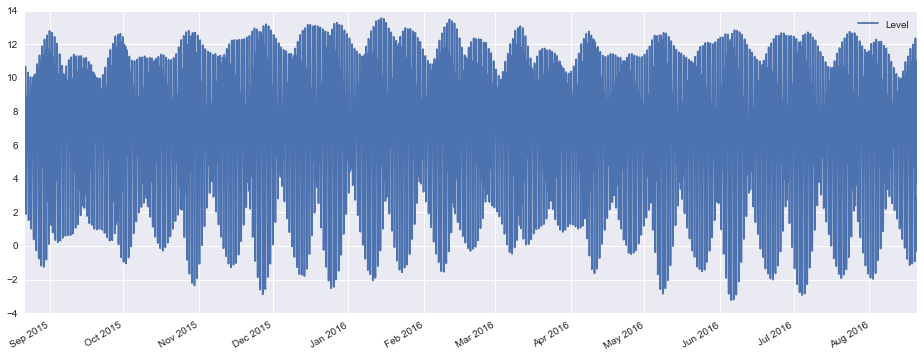

In [18]:
%matplotlib inline
import seaborn; seaborn.set()  # plot styling
df.plot(figsize=(16,6))

I find this very interesting.  If you read blog posts regarding this hike it points to the spring as basically the only practical time to make this hike (negative tides - ~ 2ft tides).  According to prediction data for 2016, there are many points throughout the year that fall into this range.  The data appears to be period/cyclic, it's almost like it is affected by the moon, I knew 5th grade science class would come in handy one of these days.  Put this one in the win column for Saginaw Public Schools. Of course, I don't know which of these tide windows is during daylight hours.

making some notes on how services calculate carkeek park tides.  pipers creek entrance is ~ .6m away.

The Data
Tide times data has been adjusted for daylight saving where and when applicable. WillyWeather interpolates its tide times for many locations by converting the tide forecasts provided by the National Oceanic and Atmospheric Administration. The tide times on the Pipers Creek Entrance tides page have been adjusted by -2 mins for low tide and 1 mins for high tide to the official tide times for Seattle. Tide height data is offset from Seattle by %5% feet for high tide and %6% feet for low tide.

meadowpoint may actually be the closest place noaa takes data to carkeek

The Data
Tide times data has been adjusted for daylight saving where and when applicable. WillyWeather interpolates its tide times for many locations by converting the tide forecasts provided by the National Oceanic and Atmospheric Administration. The tide times on the Meadow Point tides page have been adjusted by -1 mins for low tide and 0 mins for high tide to the official tide times for Seattle. Tide height data is offset from Seattle by %5% feet for high tide and %6% feet for low tide.

I'm not really concerned about 1 or 2 minute, but 5-6% on tide heights may make a slight difference so I'll incorporate that.  I'm going to adjust every tide level by + 5.5%

In [19]:
df.index.day

array([21, 21, 21, ..., 20, 20, 20])